<h1>Vessel Detector</h1>

This file contains a user-friendly amalgamation of the other notebooks. The system will prompt the user to change various parameters affecting the methods used.

<h4>Setup</h4>

In [1]:
# tensorflow libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.autograph.experimental as exp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization,Reshape,UpSampling2D,MaxPooling2D,LeakyReLU,Dropout, Conv2DTranspose, Lambda
import tensorflow.keras.backend as kb

import os
from os.path import dirname, abspath

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import winsound

print('Libraries Initialised')
print("-> TF version:", tf.__version__)
print("-> Eager exectution:", tf.executing_eagerly())

Libraries Initialised
-> TF version: 2.5.0
-> Eager exectution: True


In [2]:
# check if GPU is installed
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
if not tf.test.gpu_device_name(): 
    warnings.warn('NO GPU DETECTED. CPU will be attempted to be used')
else: 
    print('GPU DETECTED: Default GPU {}' .format(tf.test.gpu_device_name()))

GPU DETECTED: Default GPU /device:GPU:0


<h4>Initalise Variables</h4>

In [3]:
# initalise file structure, including data locations
src_dir = dirname(abspath(os.getcwd()))                         # source directory

# i am growing a strong distaste for Windows...
train_dir = (src_dir + "/data/128Aug/training/train")           # train directory
test_dir = (src_dir + "/data/128Aug/testing/test/")      # test directory
log_dir = os.path.normpath(abspath(os.getcwd()) + "/_logs")     # log directory - for run info
res_dir = os.path.normpath(abspath(os.getcwd()) + "/_results")  # results directory

dirs = [train_dir, test_dir, log_dir, res_dir]                  # place directories in list

for i in range(0, len(dirs)):
    if not os.path.exists(dirs[i]):
        os.makedirs(dirs[i])
    
print("File Structure Initalised.\n-> Results: ", res_dir,"\n-> Logs:",log_dir)

File Structure Initalised.
-> Results:  F:\_code\IRP\_results 
-> Logs: F:\_code\IRP\_logs


In [4]:
inShape = [128,128,3]

##########################
latent_dims = 2500
nLayers = 3
doSeed = 2021
epochs = 100 #20good
batch_size = 64
test_limit = 15000

#########################
vae = True
beta = 1e-5
train_status = True
rgb_status = True

In [5]:
winsound.PlaySound("SystemAsterisk", winsound.SND_ALIAS)
train_status = input('Do you want to train the model? (y/n)')

if (train_status == "y"):
    print("->  Model shall be trained using data in train_dir")
    train_status = True

elif (train_status == "n"):
        print("-> Model shall ask for logged weightings")
        train_status = False
    
else:
    print('-> Invalid input. Please enter Y or N.')
    print('-> Training has been set to True!')
    train_status = True

Do you want to train the model? (y/n) n


-> Model shall ask for logged weightings


In [6]:
if train_status:
    
    winsound.MessageBeep(winsound.MB_ICONASTERISK)
    runName = input("Enter name for saving:")
    
    winsound.MessageBeep(winsound.MB_ICONASTERISK)
    vae = input("Would you like to run as a VAE (y/n)")
    
    if (vae == "y"):
        vae = True
        print('-> VAE shall be used')
        
    elif (vae == "n"):
        vae = False
        print('-> CAE shall be used!')
        
    else:
        vae = False
        print('Invalid input. Please enter y or n.')
        print('-> CAE shall be used!')
    
    winsound.MessageBeep(winsound.MB_ICONASTERISK)
    input_shape = input('Do you want to run the model with rgb? (y/n)')
    
    if (input_shape == "y"):
        tfShape = inShape
        rgb_status = True
        print('-> RGB images will be used!')
        
    elif (input_shape == "n"):
        tfShape = [inShape[0],inShape[1],1]
        rgb_status = False
        print('-> b&w images will be used!')
        
    else:
        tfShape = inShape
        rgb_status = True
        print('Invalid input. Please enter y or n.')
        print('-> RGB images will be used!')
        
else:
    runName = input("Enter name for saved weights from " + log_dir +"\n-->")
    rgb_status = False
    tfShape = [128,128,1]
    print('loading info...')


Enter name for saved weights from F:\_code\IRP\_logs
--> VAE_t2


loading info...


<h4>Define Functions</h4>

In [7]:
def sampling(args): #TODO cross ref with https://blog.keras.io/building-autoencoders-in-keras.html

    z_mean, z_log_var = args
    batch = kb.shape(z_mean)[0]
    dim = kb.int_shape(z_mean)[1]
    epsilon = kb.random_normal(shape=(batch, dim))
    return (z_mean + kb.exp(z_log_var / 2) * epsilon)

In [8]:
# define functions to load images from file paths
def load_image(filepath):
    raw_img = tf.io.read_file(filepath) 
    img_tensor_int = tf.image.decode_png(raw_img, channels=3)
    img_tensor_flt = tf.image.convert_image_dtype(img_tensor_int, tf.float32)
    return img_tensor_flt, img_tensor_flt

def load_test(split):
    train_list_ds = tf.data.Dataset.list_files((test_dir+"{}/*.png").format(split), shuffle=True)
    train_ds = train_list_ds.map(exp.do_not_convert(load_image))
    return train_ds

def load_data(pth):
    train_list_ds = tf.data.Dataset.list_files(pth, shuffle=True)
    train_ds = train_list_ds.map(exp.do_not_convert(load_image))
    print('[DATA LOADED]')
    return train_ds

In [9]:
# define function to split dataset into training and validation sets
def split_dataset(ds, ds_size, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=1000):
    assert (train_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=2021)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds

In [10]:
# function for calculating evaluation metrics

def compute_metrics(y_true, y_pred):

    conf_mat = confusion_matrix(y_true = y_true, y_pred = y_pred)

    true_positives = conf_mat[1,1]
    true_negatives = conf_mat[0, 0]
    
    false_positives = conf_mat[0, 1]
    false_negatives = conf_mat[1,0]

    model_precision = true_positives/(true_positives+false_positives)
    print("Model precision is: "+str(model_precision))

    model_recall = true_positives/(true_positives+false_negatives)
    print("Model recall is: "+str(model_recall))

    f1_score = 2*(model_precision*model_recall)/(model_precision+model_recall)
    print("Model f1 score is: "+str(f1_score))

    model_acc = (true_positives+true_negatives)/(len(y_true))
    print("Model accuracy is: "+str(model_acc))
    
    return model_precision, model_recall, f1_score, model_acc

In [11]:
# define conditioner function to ensure input data is suitable for operation
def condition(dataset, inShape, rgb_status):
    def reshaper(inp,out):
        return tf.reshape(inp,inShape),tf.reshape(out,inShape)

    def reducer(inp,out):
        return tf.reduce_mean(inp,axis=-1,keepdims=True),tf.reduce_mean(out,axis=-1,keepdims=True)
    
    def nanaway(inp,out):
        return tf.clip_by_value(inp, 0, 1),tf.clip_by_value(out, 0, 1)
    
    def normaliser(inp,out):
        return inp/tf.reduce_max(inp,axis=None),out/tf.reduce_max(inp,axis=None)
    
    if rgb_status:
        return dataset.map(exp.do_not_convert(reshaper)).map(exp.do_not_convert(normaliser)).map(exp.do_not_convert(nanaway))      
              
    else:
        return dataset.map(exp.do_not_convert(reshaper)).map(exp.do_not_convert(reducer)).map(exp.do_not_convert(normaliser)).map(exp.do_not_convert(nanaway))
        

<h4>Import Data</h4>

In [12]:
ds = load_data(train_dir + "/*.png")
ds = ds.take(test_limit)
ds = condition(ds, inShape, rgb_status)
print(rgb_status)
x_train, x_val = split_dataset(ds, test_limit)

print(x_train)


[DATA LOADED]
False
<TakeDataset shapes: ((128, 128, 1), (128, 128, 1)), types: (tf.float32, tf.float32)>


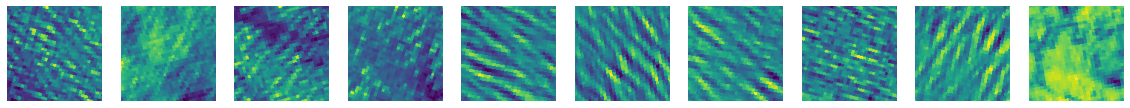

In [13]:
# have a quick look at the samples to make sure they're loaded/shuffled properly...
samples = 10
imgs = x_train.take(samples)

fig, axs = plt.subplots(1, samples)
fig.set_figheight(20)
fig.set_figwidth(20)
for i, img in enumerate(imgs):
    axs[i].imshow(img[0])
    axs[i].axis('off')

<h4>Setup the Autoencoder</h4>

In [14]:
# define autoencoder parameters
params = dict()
params["e_filters"] = [32, 64, 128]               # filter order for the encoder
params["e_kernels"] = [3, 3, 3]                 # kernel order for the encoder
params["e_strides"] = [2, 2, 2]                 # stride order for the encoder
params["e_paddings"] = ["same" for _ in range(nLayers)] 
params["e_dropouts"] = [.0, .2, .4]

params["d_filters"] = [128, 64, 32]               # filter order for the decoder
params["d_kernels"] = [2, 2, 2]                 # kernel order for the decoder
params["d_strides"] = [1, 1, 1]                 # stride order for the decoder
params["d_paddings"] = ["same" for _ in range(nLayers)]
params["d_dropouts"] = [.4, .2, .0]             # dropout intensitiesdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABGoAAABsCAYAAAAyoVQIAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg+JYAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOz9Z5Bt23bfh/3mnCvt3Lvjyefec/PLAe8BICIJIhlwgTItiSzTLrAkf7JZLsumaVep5E+ukklb5bLLUlEsipZNCjBtUYYIMYAECRDx4eVw383h5NN5944rzTn9Yc611t59+px773v9JH7oUXXrnu7ee8UZxviP//gPYa3lwi7swi7swi7swi7swi7swi7swi7swi7swv67N/nf9QVc2IVd2IVd2IVd2IVd2IVd2IVd2IVd2IVdmLMLoObCLuzCLuzCLuzCLuzCLuzCLuzCLuzCLuxfE7sAai7swi7swi7swi7swi7swi7swi7swi7swv41sQug5sIu7MIu7MIu7MIu7MIu7MIu7MIu7MIu7F8TuwBqLuzCLuzCLuzCLuzCLuzCLuzCLuzCLuzC/jWx4Gl//P+982kL8HZ2ibmJ6t8Pgxmh0CgML8cP6IiCO+WQr86fRVuH/YyKNnfmQ3KtAFiP58SqBOA4a1P6z+0kk/r30zJiK5oCIIVlOxoTCk1mQv7g6Ln6/DvJhOfbewBci454IXoEwN/a+2l+973nUMqSZwEmVXTWFwhhmd3vER67c+ZXC9qDBQBX1sYM43l97P1Fl5NFQqAMw2TBlc4JPzp4h8yEnOhW/bnf23+ecR6755EsCKQBwFhRf+bnt75LT7nzaCt5fXEZgKO8w7/86seJ9xQmtOTrunnooUVEmvf/x/+75kDfp/38Z/8DO73VB6DoCCbX3XMoepbySg6A1QIRunuwxSn8Lpe07gUI92dUDkXX/dtKMLHrHBaeCNZfd/dSJoJ03R0nWFiSY/flyXXFyScKulszrg5O+PjgIe/NNjB+PDya9epnGClNVgYcHnWxpURM3VhSc0lrz30mnFq6D9w559uK8bNQPpOyPpzxic2H9S1oK3jzeLs+dlYETEbt+n67b4R0HhqsEpiA+l6thLwv3H2GkG4ZrAIsqEyABWHdz5VVnwV493/1753Le/xLX/p37E48AeAg7/La0U79t+nvbrP9dfce7/9EiH5ugRSWreGEbpjXn3vr/jYYfzkzP/UtiML/ToDYyvwNgT6J6LzvPld2LPmNnJ955XUA3p+uU5pmnNx+uFEf+3PP3a7nQ2USyw8NbgPwt//eLxBOYXbVn6dlYVC4D04Ckj1Vf09lIEr/p0/k9NdnACzSEOPPv7M+RgnLySIBoBW5YxVacvLGOmrhrksWoro1MO68pnoM11M6nRSA8UEHkblr+At/6o/4Dz/9X57bXPzJX/7rtv3+CRTuprLrQ06ejdyYApJjg/TLgUoNwcL9EO7Pya64SVe2JYevNEu3iQABwdS9uvi4ua9wbuuxLHT9atn/nEBHFgSYlnHj14KaKa79Tkl44p6hLA1WCPBP4PYvtsk33DX13gnwyxvtA4Ms3cGT/Rw1d+NucaXD9LJi/rNTrq2PuL0/xNztABCNBdFJ82xm1yy65S72i597i+utYwD+67c+SbHb8vcgaD+QqBRkYWkdGkwgSIcSE/pnAejEjdnKrIB3/ur5zMVffPbfcwcWAjPo1L8XpV8/Q4VJ3AsQmcbGzXg2gUS3A6yA+XbI6EWwAbT2BMM3C6x0l2gV7H/Gfc5KS34tr29EzNzxbEcTPQjZ+rp7BvMdyfTm6rwDiI4l3buW0m9fJhRMbhn3Ti3EB7Jew4K5GyNWQLpl0bfcCzYHMZ27/j6EW+MAZs+UPP9Cs85KLLlxn3v/nR3UTNb30392VH9ukYVkY7d/isjQ6aUE0iCERUn3eMezhHzS+B1hp+Dtf/vfP7e5+Mu/91fsrHDH10YyyyOMHzKtsCQO3By9e7BGMYmhFMiFZP3bguTEEJ2UxI+mcFbnTCEw7QgTKYpugCws8Z0j97c4wobuGU1v9Vj4fVKW0N4vwUDr4cwdVwisEBx+tl8/c2EgSN05ZWFp7btxM3ohQmWs7EXLtv7dKaJwc9cKgQ29P7SekK6764nGhs6X3nPn6bRIn9tCR5J0Q3H0CeEOLaAclqhOeeZ5km+36jW7+8AgNEhtERqisfvDv/xn/9tzeY8/+ct/3Vol0LHg8OMKBKy9aXj046Zes9avjfjfv/ybAPzG4ef4F6++7O71Qcjam+4zeU+QD5rjFp+asT5we83+YQ+Tu+ez8Ych8djNsTKRTH7F7claS8oHzp8QpaBzTxDOLDoWlH92xGbXHSstA+ZZhAUmj3p03wmQpVuzO49KhB+Ai42AsuX8CxvA0afdOcORJL/s1mYxV2z9SbMHT24KFs9lAPzYS+/wv778TwH4a+/+ed7+1rX6c9tfhmjijvfgxxW67f79wsfu0wnd9/fmPY5+/xLg1oSdL7t1IFsPefTDiv678LX/9HzWU4Bn/y//Z2sji41NvUn1N2fEoY8NFjHGCIp7HeJjiZUgczcXwklzHKtWj2tC3HhtweJaCZFBRppBf06g3H0ffXfTzRuqz7o9UxgB1XIqQe9krA3de7RWUGhVT/3kn/bp7Lm5lfUVfglk9DLoxH9IWGzo/r1145j9+2uIyN/vSUgwa96lWgiE9wNk2ezbOmrW3ngE/dvu+QgNkd+zkaBjhQkFe58JKXruvLrrDti6ExK622Dwfsnv/4O/ei7v8bn/039kAcpBCYHfIpWtL96WS3FFKUgeOidZZrD1LXftZUsyer55iemGxWxniMOI6EQSjf3XW+49AeQbGtkr6u+8cv0R7cDtl9/5py+hnFvH/LLh+V/3Ny4Fi0sJi6HCBnDyApjLKdYK7EIh/LWqqWzGBhAfN+9l/Lyu3+fmlxWyuYR6HOY9wcnH3Ttqbc75Dz/9D7hbbJCZkFenV7g3W6MTZnzzK8+x/m0f98wsKvPx0tWAot8ct+jael3LLxcIv1e+/z85n/UU4Cd+5W/Y8c2A+Y7l2u/kCGOJdqfYu26ft3lOtVFOf+WzlIk7tQkE2m/X0cQSjzXhSYFaFIhMI3K/buUFZE1cMv38DQ7+8gwhoCgUa7/ZQVi3X6jc1seu4tb110uiSYEa58hZCsYgSvdS8usbzK7GzfNqCyY33fUlh818sUpQherCQjBv/Ka8rxg9J9GJ873ajwTB3KJyy+CtGXLevOhy2GJ2NSYdCuITWx+z2p8BVGZrP14Yi1qUCO0+O3q5S95zXxq+lfM7/+SvnfkenwrUVLYeTJnn6/XPcxMxUAs0klcztwG8Mb/EuGwxK6MnHWbFpLAkqmA37dUB3/6sw/GRC0ZUaPifffp3nnqMUGg21BTlPZMv9N/j+GqL3AQsypC9SbcOzJNLM/Rxz31vNwQP1OxNunxu/W59zF6QkXUC+mHKVjTh2XgfgIzwQ91XZf0wpacWJMK91BzFN47dsxotWsQ+GBVaIDOJif1A0QLsuc05AN7/c0OKrhv466+e/ZmgVdLtpBgrWCwiilkIhYTIEB2pOtiT2gXO0cj9nG3YelOyH4Kf1burWX/dorKYo2dv8A9fvgEWyqsZz13dXwG6AJ4bHvDc8IDDtMN7jzYBKIMQ9h4fuu09zfCNHDkvmD435A8/s4FVoK+nfPz6w8c+v2zzq4b5VVAptB+IOujUkajvq+jZegEWljoYDuaiXqRNZD/Uczhvm+2EmACKNcOgkxIGbmE4yZLmQ2c58D7oEgZkKignIcmGmxvh5oJ8KGpA5GNXdlkLHajZC9scZ+3HDrezM6Id5Ci/OWc6wCCYlxG/9h/9PMJAB1svTh/GdAzzmyVrG1PWO+787x5vIebuBTzIhvSHDdiqjURJQ6gMXEnhHReh6pbFhM1DiJ6ZcmXgvLxpFpOXp7y8H4DpRFIO2wR7zuOI7x4TXNmmaD/+PKLjnODAe6FSouYluh0gc0s0hrzvxmR0IkgOLd2HJViYb5+9rC82ZD1+rbCYzhJAjAsKdEdz/GLI9pcLdDvAaItOJCbwAMLSobOhpe1BsKIliCfu2e79UAtZuGd+8oom2Jhxc3105jUJTT0udcvwF378jwg9UjX3u/7P3HqTf7L3aVoPFK0DSzg1JMeaYFqQbUbMt9xNSQ3W+PFcumNX9xuOz3dNffxGXGAOzklWmUbkJQgB2mKVBwtLgy0MOpK09wrmlyOmL+UUlywqjZxT+ZQtQChDctl5ns9sHHF/fcB0d0h73xDMLCoVTWAAmMSSXtZYqSj6VfDaOHurB3fPq/r26aDnLAtHiqN5C48vYSzkpRsk7a0Z2az32HeMFRR54MBQ64KeYHAGwBSVFEFI3MkRwtZB23nZS71dvnZ0HQAlDYHSj60B2kiK44R4L0ClEI8s3QdFvT+YdoScNZ68jYIapMvWY7I1d7zu3YyzLJgbotAnHeaG9tvHoD2Y0nFrt7CW1qGux3k0dXtMGQuKtiBdj+s9xygX2J1lVgCB+6DuhBRtD8K3mw1LxwI21+BgBEKw2AxJhwKdOFTPBk9AgbyZw6gBhq0PMr1T7xIYElk8/q6/V8sGCh275MrOl90mbKIPnuuq5dbSouuDjPjD+S+za4L4NQHWUrYhfdhxwZqF0K+FQrv7loUD0qZvDODzLkBMgpKsCCiNpHdpQvFwSDSGbChIRgIdeb/Q+O+X7l0nj9zvzQe5oVbQei/iW8PLfGv9KgCh0rDVjD+jkid9u7Z57gJ8dz+C8MAlUNUiZuPb3Q9+UB/ROvclOgITKXTLoq+lBMon/bTE+gUxvDbDXINsFiHGITJ3YH8FcC+bVdTrnCwgeRhgJRR9w6iUICyt7tnz0n3XIrVLUhgBWEFWBMRhibaiBmmKPGD++ZIjI0geBmx+RyN9gHny4tmL6MH760THcsUnqfwwoZtEoWhwKwDyVxa0q4TSvT55z83h9Tc0+KSHFQLj15TNV0tmO+5BzHdCyrZFty3hXBBObX2d52qBRUbu3ZlCuYVHWuQ4QGjQHQPyo53XbuToNEZWScXWki8SWFRg0OXTJ3DvfcnuD7v9yERQ9EAtfFJnI4dCgbA1SEPZgDLgkxebFXDgfufiN0HeFw40nNoVwOYsux4eAvD373yO/dc3MW1D60gSpMYf8wfwTj6ClS1J3nNz4O7POJ+mezdm/bUuwlqCr72NTR+fN8trU9EVWKnIu4po7AE5bUlujx77nko1m/8Pl/AqOhLrx4YqmueQ95v5ffRyQHyiSI4iksMYlZaog0kN1izbfKf5XrCwhFP3mXQ9wCqB8AmE05Yc+vfs47+yLVbmIYD1+3znfkbnISw2IwcASbePyvLxdykzjZx6kCpWJMeacC584v+MC6mu/Yl/AQo/ExJR8N58s/79Wjhn0HbB3IlucTddP/P7EruSWdd+se2GGVIYlLDcnayR5u5FGivqLJ87vyIUmlBonukccme2zpX2CS2Zczk85lJwQke6AaOwfDF5j28l17kzH9IKCgKlyYoQYwRaS5BQDAxiLecvPv8NJBYlDNvhuL7GgVpwLxs+7bFQWEVuVO3UzYuI2+9ug4XPf+JdbraPiGXJftnjpdgBBAmSzwzv8Y3ja3TjjIMbOfF9d9+iFNCC3qUJSlhG++e7Ed78Kcdk0FbyTudKjQIjnYMhBAg/CqWwtFo5xSRCphJbCHd93mTRZFwRLmttJc7hDgXHLyoHGHx8TvvLbfcu55xpg/dSOo8CTCAouhF3PnmNfEOzfnUEQL/tNiRjBfMiZH3NOQsj1WJ2zYEEyYGkve8dJNNMiu47U1q7ESaS5IOIO9duYQKY3TB0nzlhOm2cFbHwC7PPKpuQeqNbMesDy6UxWj0T5eee0ALb8ZP/HAGb0ijGpbvmd042Ofz2Vv23SMLsip87vZI1PzcrNltlnX7KbOyOYWNNcBASzhyybJUPbANJdKnx9DMbYJb86szvUKVVWCuY5RGTecwvvPJdIlmyHU64lw3RVmCs5Gw3aNWE9Y9TWJBuEww+eUIcFhgj0VbwTGdOIA0biXN4gxuGN9+4grACFgqGLtgCFywqYJZFmFxRPQUTgO43i2EFZj1+QQ7I+IGb9GwDKRjfcucNviOJZu4+in5IcOA/awwy1xT9kL3POYfLxM7Ja+0rug+WojNLDaxkA8H4+YrpoYkPPKjRJDTcZPYZxM4dRXRiKQYhVorHgpfhd2H/RwRWWIqBgUcu2B7fEujYB4E9jQ3MyvGrOdxtZ9jbXXp3S2RpXebYT8XBawr945IQzVxHjAo3x7/0//40198qCacpMtU16AEQnZREfUXe9dlP656j1BAfigZg/gDn6SOZaM5vQ0XR9xkc4YAYcAGpynGsCGNAeRaMFBglmFwPsRKmt0o2d9z+M1/bpL37+LgTRhDdi0C6V7W4LPj0rXsAPDs84o31Ie19x55Sc4mau/tOdww29lneDbESwFtpEdrdh277cxqQpajXtnAsmI8jVD+HQUExkoQTUa+TCIiPBMeHPeJOM6CUMvV+Uu8NwrFoKjOFRKUe/CsVs3lMp92sFkoaNrszOnFOpJ7swJynSWGRAlphQag0kyzGWkG8sSB+s4fyWbL5Tkj3fu6AzXaAHM0QRYmNQortbj0+T+8h1f6kkwDddQ6wKE2dJQYoLvUI74/c3xY5tu3GVuvhAnDgp8wteV+dHbQvZQnrX3lncXGlReuBp8AtOZAqs+ioyYqOP76OlRuYAKZXpQ/Yz2INud912hnpd9YI5sIxILVba62AxYagvV8xCtzxV9ae79MqwF/48VhdpigbFuDJpM1/dfh5AmF4uOjTGqQEgSa/rpnNu0Qn7rPCNGCNeKdN/qkUJS3tbsb0oANakG1rZscNaNJ6qGpAozq/VVB2IJyuXqu1ok5KViMjH5h6nASzJiGGdYAcnAEgLb0KHeOYN0B8DMmXQ6KJYfdqj9dvXgFgmsc8yYSF8ETS2hW8v71O1/tcaR5S9jTCCspCYpVCeADxB7U1RmM3Fq2CWZ4w6seYjqa9PkdrUfupxgjCpISkpJhGyDJonAjhwUZWiW5WNs9RZgJz7CZPeSemc+T2jrID+Zpt/JH6yz4JcByymAbMlfuAWsuJopIyVzWbuP3I0r7XOLxX/lWCVYKjVwLml40Hw5sTqIVAFoJis6CMDVhBcKII5m7+1GxtAfNLhlZraZ1dz0j77qYeXAqRmXvPV3/XnAmyt3ct6bog3TLMd6D8WEm68QTn/HuwKsA+MwmgBeHE3auZu0xEFXa5fbI6yNJ9P/VcS4mEwBKEGukZUt+9c5l2N+P5jYMnHwAoE0uZ4MDnookBZA24ru6Zy/dlA1vPd5UKCp+PKDrNumMlpC+mMA9AWf7Si1/GIJEY/mD6Iru315E4AHHtLVMDE1lPomN3vnTLMYeiE1Efs76WH9BENAGUbVsnusKJQBjL8YsxQsP2NyWmyEGqxhd47CBuziAgGypKPyd1tE7n3RFCG1YCi+q2ln41er5hplXxFR78j8aeTbUWEI3Abjna0eRmjA4FQfb4RbX3Gj/CBMKNHyUITpqT2lNJMivcGgtunS0/30Vo6N0viUaNU5n3fCyvLWUsXVVGCMIK0jVIRoJoold8R4Soj1F0A+bbTya5PBWo+bXdL9b/jmRzky31uIcQyxIpbJ0NXQvmfLx9n9BzYF9bXOUdD/aES8dqh0UN1CwWETIwSB9w/ca9T/MLV74LwDCcE/eaWZPIogZplu2N8Tb3jtYAyOYhjEM6dxRSQfqpORIIQ82N6BAlDNpK9BMi6sIochsQiZJQlLw332RSxry2v0P2+qDO0qYC1NANjK99/Tk+/lMOnMlOeVKh0PVGff3aIfrqKUfO/390zoyayiQW+gXCZwPkKASUQwA3DONJy1HprEDOqoCuQZWFAbWwSO2YJgi36WlPQbQCdAt0bPl3P/kH6E9IHuV9fvf/9QWKnnID/F5ZO45WNvSzcGoIxwFWKcajDQQwlht0Xzpunl+g0UZQHCeQuE1vfqtk/qzPthwEbH4zQeUxwdygUnfh0UlJOxKUiSA5EthvrWG+qCEwIHFZE9y6lxye/eyFgd4dVz6T9wXphvv9MkMDqMtWnpTV/F7tj99+lvZ3E4KFXzzb1ECQDQBPj229ETPdjImDkrwMWMKuMEbQ80yy2SwhHrmFwQrOZO+3ooIo0EzmbqUapS1+8/1PYQuJiDVyKRi/Fh/TqzimSyaFxViBFIbFtqD9yGLCJttlQouVliAunRMyWDB8YUE3aub2ogwxS04uQCsokL0Ca5wDt92b8kzXlRbsp13e2Nt292aePJeksI+VaAFs7oxr0KcCps7Nqph40GbybAeEQ/WrYPnwU5JLf+zepW5J9NBlGkyk2P1im/lVgxVu3FaOUdlyyH/erYAfkL94gJIWbQRmz3NntQCqjK0gOHH31n/HjW/tA4YyERQdVdNvly2aGtAgpANwpzeauW9axl2Tzz4iLGocYE8C3ttPePE/nyKnGXowwfjMcbrWpD2FsXxp/xlCpXn/y9e4/Eea6KRkp5wjLG5zBzBNBlUUxjsW/k9h48AFmnMNCitbLneysslenpUJs1KSDxNMJNGxZPSccmuEz5SKQmAsSAHRjxyh//HQBQUCwjF1uRKI+r6KReOFl1ZilXXsiq6o1wdwDDnT8V6vshgEtq1BWjrDBeW3B/4arVtDJBRLAaYsXcArpeHSzpjd3R2iUQXoNk6j1atzzBhB6ZMYYjtDeqDFLM3FsFW4MTaTzqlThrX2glu9Q3bTHpn2SaKgfIxleZ4WK+e3RLLkRtetX9JP0lfzSxRG0GllFLJhBukIn4mzyEIjFn6tCoMVEFEWti4xUWnpyh2tRe2doNtbmMiVnNWJD0DkBpE5582mGbQdIC8sK9lvWVqEETUQ5r7gnGyVUWdnTdAEDnoJOBIWbMWSk47NU1nRkTXDTxbUc1loIPSZ/0yydX1CO3TXevwpg/7tjcee72mwShamKQE7ByvbApVajBTMtgO6D0tUarnxjx0T0N1szO/8wst84WPv0g5yBp0FsywiikpS76IJ05T9AXTesuzLdbfOAvR1HZjpmLODk1MmtQvIg1SyP+mSpSH2fovBy4fcHDq/5ttJU1ZlQoE6FWBY5d5hVX4hNIhF45sVS8xUmVo3d61juu3nPbaiCWkZIKSt/er5JUE0c98bvurHs7Xw+12Kn3HvMwg0sl9gTyKKoeHhn15n+6suSRIfl6sBxzlYNrR07jf3GMwFJgS1CCj2+25/aln0ekHYciUf1gjWvhG6G7a+3MBCMHd7UNERdVmGeAITKZgLqjDCrW0CKwVl29bAOAJXJoxbr6tScbubkAG2qwnX3EHKVmfl+PGhW1OuHAiKbghScPxi5NZ16/atolVpClifMHF/E5YazLAeixJLwbldXhd7Jdrnd+/+bODKtoD+m5LS/z4cLwGmsSVZS/nMpfsf9Go+tPVeGDFPI6wfz1Y3/lpwFNZsGFkIwgl1XBEfG+IDDxC+2KHoW1euLh3DVwUWnSknNfAUk94fsqliNu/wzb0OiWwCbVlSz9snseeEEfWzE5b63wBmCZyxkscStuDeU82QErCzdVKzy99bbHI7XeeVzkPemW4S7yu3tJYNe6RoNXM670M+dGMjTSymVyJ94gXb5IGf5uN+L7b2rRHhrO/LaRXBzO0DJoCtr56gRycAqOefobXnHKyyrZjcCM8G6ZasbEuslNiBY+eA28tY+ARc4iZcmbg5WLnfJgasWwelhmiq0ZFbnIW22ECSrYeMXlhCsoStfeRg1lRJrJhYTfDrRDJ+VqIW3idOWHnHRcfd4FEvZPCeJJgbROmAUXFqbFkJRjq2ZDZUyFKx9rakfZL6vy8l/AJRA8xn2VOjkA/jIIVC0w9S2jInlCWJKJEeFktNSKLcwv+J1j3eX2ygrUBbgRKW/bTLvAgZPeo5JHmkMD3Dleed/sxma/rE81aW2pCvLZ6t9WPe+9o1Ovd94K6W0LEngL0VWFNZW2XsLKe4/D0mquCP7j3D4sBHBANNOG50PmrzJ2zLnFgWPCrXAPcsD4sOxRLL4Qfnfq7adsuVTxxlnTP/LksI33bPzyhLvqWhV4IRhAdBnY1WWZOZVqlbKToPRJ3VMqcSN6Es2Y4mxD/ny8eKgN1vrxHMA1QGm9/Kasc2G0gqCSABiAKCXJB9ZR0roHhpQRQXWCsQ7RJbaawsIcvFRsnDn3THSx6FrL1dlZc1VEWgQYG1gCW2kBVu4wxmZz+j6t7Dia1LFNINQbZuEFoQLATB+SUoVixuF2QbMeEdly1XRbMBAcxfyBu66SLmpGxRZgFRO699KvEBCPzi2Zzh5oSfueYK97ejMe8ttvjavivZe3TUx+YeDCikcyz8Mf/4+Fl+dvM1wIG0h0UHKQzGCu5O1tzxP7EgmLXQrSbDZbqPZ8tPX2cgDNe6IwDuzdYwCBZFyCvXnTaVFJadZFKvO08y3dHsXGuAv+2OW1+MFfSTlKNZG2MF2giUXxL+YPfWU4/5US2clFgBs+uds51d4RhqFiCQjF5u2HXhzCJzX9picQM2sMxv5WAjir5zJKyAobRIYZ2+TGVGkNQMHQhnrGTepLQYdfaqVJd6BCAL2TAlZBNlikJgY4tMHVsimAraey7AG76RIceL6hZrS0YaHQVuw9Rw/I+uUHQhBCbXAjYPn4y0jF5oYUIXeFRZbVk65xvrQA6V0jjx/y2ZDiWHn2nROmgRZJbZtnL1zv5Zm6ABkHrvKOaXYtKjBKygn4iVRFO9+Vdz2EAwdoxOY4VLNDy/IDtq+1IJqLaY5Egw3bQE7RLaJUkr5/raCIB7J4On34Rwz697bcxPXn2XXxx+k7/T+XHe+I0XncO7xD4I90NsL0P5jGZRKIoTvziFFtl+fI5b04CKCNjoz3i+7wanXBogShow8gcC1ozLxGnnPQFVF8KSFSGLWUR3eWmxrCYb2gliniKKknCco70mkVqUqHGGqF6oFI7JcgoVTx7N6uyi2D3CLjzgrRRinjlWjTGozNSstWBuKDqyHtdZrwFkVG7PTLZaJVhcbjbZoip5shBktr4nlTvgr9JikwUOUE6dRoINz8iEnnFCUQWdy9cgxbkG+UXP3ZdV+HKhhtFWBQLLWd9qbFVAosxdtlYY6DzUBIuq5gSEDSqZoA9v1We9jpAwkOzD9O3+yp+fZFY2bMgcPCDvqPhVhlu3JPnQBQdFG3w1MjoRBAtL60hz5V/Bb3c+QbC1oDxsEW/P6bYcmLD4UQ3vuH0lXBiM1ypafoXT2wNsZJB9rzW2kzB6wfm+8cTpM52nDT57wGzuWcK20RrDNmNILQTqfoR8KScINFpLRp/PiR6G9N5bPV6171XgjSxdkGclZGvOV5WZIHg8t+S+Nxe+HM5pSdg2j2kRgktOfPLFu9zqHlAaxW+Jl3jXa8mtfwfW3vAxjPFMHWMZvp5hfQniYkMxuyqx+xHzKxob2DoBLEt3/SqzlIkDiKbHbYRqxuiZVrEChGX06Sbr37oX0rlnKbuCfKi5tDZ+wgG+NxPCrq4D0v1sjUAnbh2HikHTXHz//eYlHH5CYCKLji02tnQuOWd8tmihMqeNaWWjP2ciS5A0YzHPg5rdpGZypYRs2V+uyswQHnwbKXTvg0syK+DO+kSZsA5QrBjYKn+C/7T0XF6bXeb1/R3677rj5X3IPDNKx0vXdtqWDq1CXa9LRXa+ycRyo+XXbsv6ayU6cskoHQnSSx2SJMGk6crCuNgKalYmuGRHDfY/sRS3SrC7BczGCqEdAy2/Fq5oslXjRcfuePFhhm4FmFCSD0LC2eMnMQF1eZw8gell90M4e7o8RRUHwuo4gcZvC2ZN2aCJZP28rK8IqPzZZZM5tN+vaGQCE7vrMaFs9uIn2AcANZJUBxRG8Y3vXkZtuoVeSMPsmYgfHbxDIgrWgxmFVRgr0ULUSF9qQzQChUUjahFhYwX3TgaUpaIsJdFBcxmnXbrCe7cVmDLTMdoKJrrFRLoJ/tZimzuzdQxiZYAL0zjHQoO404IbC6yF/2b/k/zS1rcBuJ8PeWPaiLO+1N2ty6ESkaM4Y9b4CVtRXbmSgrBEgeZyOCL0b+mgfLxGvzJHtfYv2wrWEzdgO7fONw28Hrnjpjrk2avOGb57sIY+cWkGNV/KtBmByCTBIHPCWt0CHWh4reeYNC2XwaooirKwJD5BVmXPiq7goOgihV1hQcRhif74mMU8whpBPkjo3LfIsio3apwRuZSlTS+VSAtZGpK0cnqDBWVX1lTY6ahSyVxCv2NLOnTn7jzSDF4fo9sR4+danNySPhtpGyFdAAH5mqnr1lXWaFus0OEqNN3/W/d8LXVfEI7UCgPpvKwoFMvkj9knUn725dfqnydFgvEX9ZX3b2JOC0LjMjBVwGMt5ANL2TPYRHP12hHb7QnPdg75pcE3a9Djpfghb423mGQxg96co0XfAVzV+7ECa+Dt/U0+v+aAwF/72hfr5yMCQ9zy2gGZojwLK5SuxrhisUhheam3u8J26anUCXKPttF+TDmmjne8rSTz+liRKmknGUf31xCZdMBjrJGhYb0153qnAWseLlzA2grcNWoj0cbVxAthOXl7CL/wtDfz0axieS2bsE4gO5w5gGGxaWkdNtmGynEPFs5ZRUBrVzB5TkOvQClLumPqUhJwoKgUlkIruq9FRBMXNISz5pkaJR6nSPtho0M4fiFwP1vY+oYTupSFZfCGYPRK43hUIsXRgSRbd7W84UTQ2rVLWQYBoRfYzUv2f7RXg6fJYfO5YG7r+VdfZ1wBrpK7PxOjW5Zw6mqZ3Vy0NSuhCi4dOAPxyHg2zod7Px/VZK4JUk3ZCij6ioNnFIsdS9kvKe8GxEcWYTz7Qa2uCdYnEsp3u0RPK82yEI8do6ICi1/bvsLzN3cBeGbnkEdBu9b7kYWjBlsBWTcnjp0Tc3VwUh9S4B3NpTXTCii7BhOJeh3O7vT57Eu3AfjLl3+f/034Ys0aNIFzmIV2IF+V0VwJbKsAWVq3/mjZxDrC1uvEg/c3udk7phPkbMQz7pVr9d6hpKEbnGftmrOTokXgX4hZ8oIPsw73x32OD3vYTIIWzC/bOhg0ISx2Ilq7OVZJyo0usufr96xF5k8ZbB4BVmlZayHIgxPskrgiSjmdGu3YOg6ocWNNx43GS+uwrMVOi1bQlEKdihWq9QOgXBK2ltrWTqhRUMV/Vgrml4QDFwPrSunOuKXldbgVljx4UdN7W61obVgJeVc6Jh5QdmS9DpyHBXMeX8MqW4oZ1VTx9pFjdGdF4ErhcQG8XNJCeJoJ49bn6vlWznzg120bsKIPVZ2/vW/I1n0JmYHjd9fZ+dSUQBqeeWGXO9+5DBZm150+Xu1rSIEoK0DQr7Pa+ST5QHgGs/UsZveVzgNb0+k7t9vkJx2nrrh96tFUGJ0PKNr7JTI3PBoO3XcXsNgRJDsuUM6iD9a1+X4sCUqO1j1YaZZY3B5kqa41u1zQDTRCWK4OT9i5co/RrRaHn2szyyLm7wwYvio4jeuqzNZAjdACO3LnWGYw6UQ8NnewAoEFD9hUzReCmXAsWGW53HLrqkHwmWv34ZoTY77T2eHoEw60GbyJK08WDcgLkBxpF8gKaO1KEI61OttxenKVmKqOBbqrEXMFKFfaV41F6xNe0j5+/UuWDwzbX9NEU0k6VNy2lyieOz9dvspvOm1CWmxk0X6xMrGg/WCpnGWJ0WBDW5fhL5uMtWM34NhNZcfUTrnZTch3XDmjzpbWN9/swx341LUmtgbeVOo+pzJF/kyK7viKg5OwYeRasVSi3xzHCld+LvymZwOL7hgH3AhqNg3ArIyIVUm0hFwI64CDWisraLRedGIxiXEsq0IipEUp8wNlmIIv4/Fjq2L0gYv1FpuK8hc/jSwtrYdz10BBioat5C/NBKL277I19//kyNJ5Y4ENfRnlGfFROHVrV9xX6IdOHD7vUb97gI1vu8+oRUk2bKEjQdlypfrdO5bFtsBErJQw5n3rddagexdaB1UZZ5OgQJztD1dldmXS+KnhtAFmlpkxeU/WzBhh3TmzDUs0EivMnWWzgdOae1oe/ak75tuHm9ivuEAm7FiKfnUXqhYNXkYKuyqlsKr+LzMha2qO8W+ktJLST+Y8Dx6b1M7RtnW3hVSHfHPksvmB1AzCtD7fQdnjUjhCYfn5tW/zdxY/Tm4CXvjibe795jO102pV85JNYrm0PubPXn6DzWBKat2MSE3ItFhSijZnL15KGcciAESsyde8GKKEMCrrzzws1ng23kdb6VkFksIqTorWynrxmY17XPcox+vTy0xKdw2ROue6mSXreVX/IDCw4zLcrXc6tdNR9CzBts98S0OSFCRhifrinJeHe1xNRvz6b/8YohSoVNB+2AzeyuEJZoLf+s9/FHBiw+VzDWJulxdOYTGhm9BBahm+5mrl55dckAcwvyJgqbxIeqZAFGgGrRQhLJvdWT0uHo76lIVCPWgQAVlaxCwlmKWs74/pvT9gsRNz+IkQYdziWPS9jocEG7kZLqwg8+JhMncTCuODoLMerg8c603mHBfUrd9M0FFDwQ3jkk90HtR//9rkBgu9xO8V1inuQy2yVqQBpKoOzoo17em2wlHBe5qH6YBvpDf4XOt9ANbUHOWDmVAZ5DhA+qxBaUGkinAi0CLh777zU4CLRYzvJGEDAa3VIGt+2WAjQ7K54Ep/yuc27/JMcsAfjxx7ZT2a0w/S+rzLNohTjhZtFnnI/XxQC4y+/mAH9VrzznXbIn03MhsYlKeM6iXg0FjJ0aJda2eNDrtED9wmZT142TpnIoYNJGVbebExFyjJEoavCWZX/HUFzvsyAaTrknBi6yxOe7dhvQQTiV7zF7iZwd2kdjr4nSFelguVOhX+0yasQzeqLmU2cAGpVTC7KpoUqzn9vWaMRyeynqs6gSIHG0LRtwRzQeeRcUHIlZjZ51o1EFS0qZ3MlWP752FCF3xMnknY/SlN2M0pc4Ut/VgSQd3N6/Qx3CaKX5sfLyf4fs0GsmFUKIGOFUVXOqCjBeWSDpKjzbugIMwsybH73mJd1vuSo/m73+dr1Kw8oxzoEvp357Sw/L3kstb9sdY5JqXP+nbu2bp8qhglxDsuq5vpoAYkrw5OeO1qh+ROhCgFZWgxSXVPzeUHM7mSLCkGlsUVU/+tcs6yNKTdqfYWTZFobKqgFESR5vLAJT4ejXssFs53UL0Ck0unBZBKDILMKFIdcjRvcTJpI4BXrj5Cnr3ifl8msfTDlHGRMC9DTvIWxgoOph2sFSTdjMXcbYw6djda6TaVicBEPtiHFZr/qZNABdwIQX5tvfmT/73eWUPe2Vv6jnDlhYM+ttvCRIqyGznHP28moyht7SQGmUXMl/ZJvxcLDdkTxHWt8EEoLhBczurJEgrfFc4GIHzAojJBGYLolkzmCdoIJlPH3hS5qDUFlplgRkGwME3wfdQAhudh2nd7E6VwdHjhSkGXWR8yj2uR62W/s+hZkkPnROvYlQ7W38maeRlMVR205f3Vsag8sCByH9iEzu9JjyWtY9cNT6VuLYrG7v/JZwsipYlkyW0PbJnwFAMSHwQIMNhaH08W0Hrk3lXZsY1GDpwZDKhUkKUBiyXG2+SqZ33llu0/cXPTJOGHYgQ7fYfzDRb3x1UbUbGynocTweAdN3DyrkQnAVPdRbQ01zzwvBYtCIQhTxR87gTzWcG7u5tE3+yAdf7aSgLXA16ysDUbyY1bx1g1oWdqVYyFpU47CDcHoomAiUDcl/zz2afpPzsiUIad7oR2kLs4JzSUa+7Exx9XjJ/z4qP3RN0FdTk4CxcWWbpkSP+Ocb7wlnKsIIlLjqlqYjV7sMwFoRdsLQbGBffYx/bt+FACmnDudJHUVLL7zR34uY/2rp5kkxMnnSCqZcTYM4Ebq6wvMWp+J4wFIXj587cZpS0e7K0hlX0yC1zgfFwv5svdFhoQXedb1sBp1ZF2dnpeLf/g/idLByohLAIwiaHqxSEySXTiyux1y2L7hQNvpmpFw7Ps6qbjVaLrZPz+pMPDb15CX8rY3hwzv9ujW9jaPzjr2uprlGBjw/PX93ihv8+d2ZB3DzbqUmI7P19GTdWhSEfSdRMrNEVb1qWyRUeQHBrUwdgV0lvL8H1N8IVrrgPnQNagCDh/0AoH/O5/1s3Jwe2CcFqi5qUr9ZWy7oRoQtexTBYetLONVpAV7vqsdOtE3eTCd+sNMkv3HiBgsSko+ksla96cj+neUXSU1l2cdD9meqVNOHMl4Mt+kFG2KYMF8jXBxCNR8djWCVCjGrDXCsHkWY2NLMUabP6mpVxLUGmJXBSuZCpoBuLTwsXv+Q33goyroQMZJrJFbhVras7tfGuljfXTLB/FBMcBQSqcKK1wE2KaR1zvjQAojaS0itwEZCag5Uup3p5v81LyECVWg8A7x0PyrWaRMpFFe95ya3POv3n9ax94XbEsG5FiYdE4QdNWVLBoN5t/2dUEE4WwkI5jkn6G1pI/PLjF5csjChtwUrZ5e7ZFaSSPZv0fOBr6JJuV8Qq7ZdmEoRaxzDLBLPGtcK+kJD4QToKS59quhOlXf/Z3uJsO+fr+NQ7eWyeYSMKxIDk6IxgsBeFb7nhWUNcMyrIpwxDG1gGIyi07XymI/+A1hFKUn7zF0cdaHP9k+dRsQSg1P7P9OlyCg6LH308/zwIQ45DtLzfel01ibCCJRyVXfr8k7we+c4Z0wU4C2ebqDmcFZJuabBNkKtn+ChjtnLsyESz4b9/EGx3ef36DZxKnIL8ZTfl9X6YjlUYqUMoJ75WeGik8EFozj854nubUL3/98Ed4473Ltdja4F1ZB77zK6FbwCp7wp56bX3ES/09DvIOr23s8MvX3mY7mnA5HPHf67xNWyreKAK+PbnGTEcc5W22ognLcOnr00u8cbRNqSXzNKLIAtfu0W+SIpOsNCQ541oGvTlbrSnHedOt6uH+oA6yoofhyvd+EFptsysRedeh52fNF4BsHaY3hBOs21zQ+UaL+LgJvIR0Dn3nnmC0pVDHIdJCNGoCjQ8S5DNKMLvaiH9WGdl6eVoeBgLmW6rOvhcdQTh1JVg6spQtR7lXqSVYCIqwasVr6TzMauHS+XbbAaGnjp33m9aG2bqoMxhFH3ZfMIS97PFrAoqhWREwVBNX8110nTAl/t9BBuna+a274xd69N+a1D+fFqADQFnm10uwjukQzKlZUgDx2DD3Ghoyh3xYvV+7woCoRARXzO+T+9MOqRfZKK9q4l3lqdSC5NgB6P3XAowni54sElpLbUyxnJnVqk+jXRCQ2pDCBmgrufXFO7z5qkuemNAFNliwo4irVxzYkKiS28HQlTR/BNud95DCMi/CJqgGHk17XOmeL00f4Hr7mIFa8CfzZ5gU8RM/J7zwsY5cxm25PAUcwGlLWWsoCWObjISUTsPG2ppN4xbisyen6LSwYQBhQDFsew0keeZaLQtLtOdAuNZd6o5OVgnm184uc1aFrdfvyrl1P7CildPat2QeU9KJe882AFHCzef3eLZ/SEfl/KNXP9Ec/NQtySpZFvgOdiO/OCVPftYf1eaXrNPGCg35UBLMA1qHxpU6RLIGttbegOObIXFSIKWtGmshr8+wd51AZNERrgzTWzSh1jix2Sm2zBlm4qo01P28EoRPbM0MeaoJmqy0/7frYncGqv0E04liesWxKIO5IJxb0q2YWd3NRlIlqE0gSC+1SR7NEYWmtecy0gDRWLCYR7TaOeWgZPxc4MeHYPPb5xsc5vc6DRayVK6SHDT3HE0Nm98UmECR9wNeS68Rry/4oWt3HzteMY0onnXBtHo9qIPesu0SF8IuMTpwYzXeMwSpoUwk6VB67bNGKLa+jlGTIJAF9N6R2HfXOXxBM7sckUSuRJ/IQL7kc/uvpVuQDZsyIKEdqyI+sSs6GpXmXJkIVw48FljPWq+S2rA6zkxLE/pytU47I/FUzd39Aeuv+/VBCKZXPVX2PE3gwBVpsEa6bqFWYAvpypA8CzucNHoh8YlptOe8vbS2x0tre0zKmDcOHBVMKut0g2jue8Xsqf8L112qSoZEE8WyhKJaCNLtj37/soQytAw3pmgjGesuZGfHVYPBvE4gLx51UQbUg5ije1tc/bJPZCqY3Fj6/tIlld3mB9XP2UrcWp+ogjDQFL58M3l0zjqK1TkzQzjOEGlJuJZQdkPSdfV42ZCxYAy9L90BIP7YVbKhu6bpFVXvKcu+5ckzIcHcaYoFiwCRG9cRUwmKbuCaQ4Avu2pO1XlYjQEJ1pKuCVS+WtourEtmqgzUvqvwWOwYTAjlsESUIe09kLlZYb+qccb6dwxFPyIbBpQtSTYQ5GtLpZi4OV/JY8hyKXmGY6mqfMlHOOVPm1hhIkVyNCUoSmwSstgefOC7eOobltKQ+zrNwWcOauE4gBc7u2wp56wmomDmBUqqkgltXYbsXr7OTuiQb2MFbz/cdo0wpiHddwNE6evy/I2oVDCeJ/AEHy+Uus6u5VaxV/a5k23w1bdves0R6YTfKjtjb1TYFT2Lnkq53GocwcOiw/PJbl3yVIkN/4WbX+U/OflJrHUCi6ZTYquOQYWkFef1Nc5NjEYwKtrc8xodH8aeBKZ8P/bP/z9fpGxB+7OHDNsLRouE0m/a4p22E1/zFs6sR97Bjtqki7ZrS/fjx+zl7qVshDOO8zZFqRhcP3FdqkRI2XZCYU4nwmWXl0WWZAHxsXshJoKTl917kqlk8Laozx8dpZiZmwnhvUMG8TbJUYTUFhNE7P4PsvpZbXZ9F6BTZTJVV5TcKO7fHAAJ470ut37dkA8Cz2ZwiG2QWVoHpnbEWwdO2GlyyyBT8dgYEsZNTllaNr+dMXzLPa/p1cAxEWAVwDgH05GnOnvtgOxywee6t9lSbtzuhCN+8x3nNKuPcm6PbhgrmBYx3719mS+ZZ2swR6SKaCTrgG4l+Dc0K8gS9hPMBFkCwabziK51Rvzc2rcxSO4Phxz7+qeHxRoFUFjDlsxq4WGA9+aNMOU4b/HNd685sEiAOEMjAVazJFZQK/O/8twDfmnn23Rkxqvzq7wx2anPI5TF+uUi39BE+x7Vj1zp2xPIdd+z5UtlPbUWDa5r16d/+TU6QU4sS94Yb/No7OZb0WkRHzW1vkJDZ6/ACkG21rTDXXZERBUrCncvRcttaHlfkA9cJlZHlmgsVr/nk3Hg5nLsyxrLdpNhEAZEAcTuPCZ0wOXsinVU0rL6PitAwOC9ktELQe0kV07U4pIl3XTIkonc96ugxpUb+JI9IxqW2LBERrppC10KmFTvznc08tnU8Q250lb8+7XjFyXC9Oi9MwEhCKcluiWxUjB8U7O4ZYi6OVJayoMushDu+S2BZ1aIRgA5spiWp+KWsmFFwcraYyL3PIR1+gdHay0CX9Yk+jnsOkC8bAPH7jsqt0zuunFkO5pLvQZgEspnmvw4wTpgJlj4zjw+eP+//ouf52/8/K8B8JObb/OmvOYo35FjHQj//eudUX3s2wyb6zaiLlMMlWYBWC2wWmJbGjF1L+f997a5dN0NuCQsWcxjrIXxLCFUmvHifMsvBmoVYnf6VA1931qBmktE6e4xHzRsp2woiMcB4bh0GimtoNZECaYuW+YPsnKOZTAEQGiDun8ASmIHPeeACoHuxY1gtnViueAcwfCwogGA2D+iUqO2lzeXjkuddQ7SJuMn7FKmXUDRdV0al9eLGhzQLqAJUsjWff19aPnU+n26KmOqY4QymMx1vbFtQ9GTTtCaStfN08NVszjb9vm9R71euL3KuKxz0VO0Dv3ausT66N3JOShk3bpbSlv7axSduptl3hePBxb1hTfvzyoohr7cRHsBUuFYjnWG/Swwzrr/ZkVMbjSvvnsVIuOmoDmDen+GiVNrg9zMSHw3oN0/F9H5k1YNqnV2Hbtg/VuCwx/zC5CyzK9a2vcdKJ6uKZJdl3hKRpp0PUCW0L+t2WslzLZ8u/lLTbKsfPN8g0MbVoLmlnB7TvF+14Enyx1ZlKjZpFZAcKIoZx3+cO8l1ExiIsvVj+06Rr5cTUiZ0P0/X3PjXxhBa08QzpoEYQVgytKSjIx7zyNBcuiYdOmWYH7pCb6HADHMybOQPA+I44Kkm2Mt6FKhUy8ce+p7RdcBD/lAsNhurimc26bcw1+/LAQUbuzp2LNJcggWLpgVhsZvk5bL/XEd11zvjfjmD72ILBS99y3ZxvlnoYRwIA347auaQBXrxVv/PUP3nhuvsysRphUgCsM7/1aLHw7vYRBILO+frNfHKkcRIjEII0h2ZTMPA9cVaVn4+bHr8uvDMrM2Hlm3TgjB5Kb7XvX9Gkc/vVifMiUNMikRS86FTGXNGp7OEjrVGmNoOtOdskpvp9JSwrr3u/2SS4w/ejik3c5oqYJMB5zkrRqkSR916HywlOv3bCJ1/kUwyVhcimv/8OTZkN0fvsaNfzQhOJi4B+bR72DSIKDzTdmwmYyfhx7gbO97yYhWQECJmGQICWGoULlLcFWNF6pnmhybms188nyrbosejanLryrGjCvf9utFaNGhpbs14y/+yFd59Of7/MOvf4YX/7ZPYhcVci8IpwXBrKQYRCRHLhac7SjygWOKy6xhaVfMPPCgUiAQlda6tavAW0ui0iVGbF4gihIdr31g85mnrra3hkcsfnxSZ9klDRVtL++R2pBEFPRkWpcRPRPtcyfb4CDrcpy3fEcFL3JqRa2dIbSoHfonWWkkkdIMfCSxHs74dOcOkef8fWN2s6Zlk6mzs4PKEnR9zW6SU1jFVjhCYRibFnMT0VUp69GMie8TW1rlBY/dIarSiPVgSr83xxjJs8NDSqt4p+sCSilXaXr6A2Xj4CDrYnx0eVIknOQtTtLzrwWOj92iPv/6BnMg2ymJhikWR5u1qnkX6Xpz3clhQxktfm/Ib/W/AMIy/MIepVYUWhEutU61IVjr6I5Fz9dYho0AU+uoOXbew1EUgd6NE37iz7yNsYJ//C9+iHS9T+/6D9P+ja+47KKAeFQiS4MoLc/+30HNcqwSvP0XL7tjvDAC76ceFw1joh3kvLLltBzY2mX6H8SYIuLRqE/8ez3njObWbdjCgzAZnLxgMJFxSGq1AZyxt6lMozL3DPq5oXUQoGPBfFt+4Pj+KHbw0+4hfurZezWy3pMLEp++i6x+4ncrs6lCJJpozc2nfietBXXfP1rn1TddppxSIJeyBMvaGrNrttl0fbBmPNijMuGEXL2pYHVCSgwKJ9791sxlSv5R8BLvpNv81p2XGbYX9Rzaak3rbERuVNM+sbomC2KmsLF3DELrFPKr+KhqJiTgYN5hQ01py4yf6L3B7fk6c1+6eXP7iPfueRFD6e7H1S+7+zRXnqA2+D1a0Wuc8WxN1Qt0kMK39y7zl57/MgBvT9xgnk9j1nYtnd2S9vsO8C7W2+h2AFjiYxdAgsvoVqCLE9asHE9AuuASfFmRzxCY0KIyUWeBk4MntM+tXqv1mfyxY9VsvJYzuRpy8pIDtYRuAKXRS9B5KGtdnuWyDcSSg8KpLJl3moqBgVJQTCLUSeDY3xsFQpkasKm/chzVmc7eXUs01a6bVuQ28vNsjGCVE2+Nhwm6pZhvKpITgyy8hoyg1msB94xNDIttyeC9EplbdCxRmaq7OolSYgODDQxl2wkxC+souK6Fq20cUevWqNPdHlzZhQXh66Gtm5PhWKJbFpMqjtMWw8QBFC/ffMgboxuoVGBiS3gil8o2m4AwmLryp5mJyWyAXMtJWjlZGiJOPPsyF9ydrdVgzaCVMgq6UAoWJwnBcMRWa8qn1u7zX7/xqbocc2Wb1IKsCGoNET0NELkkC0OOzvH9LVtmA6QwzPKIWRaR5wHSawEoZci2coKHsbtOSR0QaIWrK/fKzSo19bg3oURVjp8QTpMlL0ApgtGCYr0NQiDTAvH+Axekd9oN48baRrdBOvZb2XHnad+fr4BAIgiwuZu8Ii8xLeeHxYeZXyOc8PCZIuGWGp0pWk2wp2OBjnGMV38ZovRC4aXgN1/9JH/6pTeZlDHdXor9xpDoxK/V/VXRzpXTRT+YzO9j55GuwYGwzb6lEwFTwcKPu+HWBOXnqF4a68u28jvryidk4cpi0itLi6QAe4bvWbYFumr1a1xwIkpXlnjnX92g7FgCXObfKtehpGyxUn4F1B2fwAUuamop24Ky1fhnsU+ihkpTRq0VfUZ4XEzdBJaiL/zfBPla7EUxLWvvLpWMlTR6dD8IiumyCaBX8OzmIWweMi8iDg+vuD1HQ+ehqdcLq6jbXIcn0ussCg7+1WWylxf0NmbMJs6XTtcVyaFARz7uDgDj9COqEo1w6kSZbVXeWN2yoW71G96xtPYE80vuOPGx072pmmmctqrLljEC2y8o++73RQWmzBXhScWCs1C6QC/rC/JepR/l/FJZuLLC+p3W19c0sOg8NHTvKKY3OpQty8lgWgM1e/MeOnbl1MevUJf0naeOoimcpogKnu6LOqamjwmVYO8znnE/TLk9GdIOC3phWoMR7jvNM64ZawLyrpde0C6RYZUHTrVA+BL9+FA6xm615fgOqSqzdRcfcP5I3TnKCLfeV+vwk1CW0/dmm7XAWsHxzN1bvK88Q8+XRvYd2HRmItDvNYmXAHnm+j6LIuRLD24CsJhHmKlb54OpXGGcnIfV4uKlwbZCt8+UzR5iAsH4eXeT7/0bXa7+bkJ8mCLnudvnljRbhKX2yWc3tOs6CcQPQuKxJJxbgpkmOGwWPd3y5X4LCFJNOFEUXbGiU+Ou0/2/akyyDNStf31Ett0h3QiRpSAbSnTHXcjzySOeTx4x+kSL3/vVlwFIHgRc/b0UNfNlUL7dtiwt6bpy4O0hJIerHRJPt2+vcT0L0xs4GQ1Adgru/5Jk+CcR0dgi8zWie0fota5P4D19bX06o0Y4gU9zxmgaFW0iNB0fjU5EUQv+3p0PSfX3sCkL0InBGOmEh43kxcEet1quRmYzmNQgDbiuNPczl7nbun7M/u0hCNi8PkL7xTAOS7baTRufqU5QT8jIL9vcxBT+XGqJJfSprYeNpsVSCcUHWa4V+/fX3A9elO6R2GDnxlHNBsn1h0infA9mAud4CetpzN2iXpC6zx5z2Ok5JhLQuh+cCTAUXT/prODw69uUV3KCuMRG0FpLyWKNvP84yORYIO7f6WaDUGfbzUm+ePk24PSOfvHPfIWjvEOqA7778R+mvevKi9Zfe7wVu5znvPi3XenP/o9u8p985s8CINZzPnn9QX3Mykoj665bl9bG3P9RSbmfIHNB/x1BPKqyhqcWZJ+ZRDhA4Pglr9nQsjzzD/19SoFOvNOeWdZfzwnOUCI/D/ug7kaVmTe6RCNBccMj3QtJaeBTzz/gZvuIhY54sOiTm4D1zpzZSeIAkcBiC7eJ28BSRhbhwRnTMvQvu6x8USqKu90nnr+y98Yb/H/tDwFuzkzymEcj57V8a+/yB25/iSogsCTv+3bigQtao4lgsSOcmLO02KARh152VA/eX2f/mT43o/3Hjv3u3a3GEZUWcyUlTn4w7w3cHCj9hqHmkvbu43f/uwcv8P7v3SRYwODE0rtT0rrbMCGCSROEdR9qjgZVOyFqdlzF+qqGSrUGWOlYATqG1l7zrD4IVBTa1gGDynFtdkduXPXuF0xvRpiOY6jhSx4ATCSZXPfvbZkFrh17crmcwALlhr8QZekOnQc6u9M/85rUnaQGFpIDl4ms6Ow6FATalVRGJw2d/zzMSutqlG105t97r0bMPquxJxFBCMWwRLZLxt2Q4RsVqGlIDiXTa67NuUxFozckWBH5fZoVixB5ErpsVezGlm4LFhuS1oFBZZb4WDJvWWQqOBx1GV5qnCLH5Dl733HZIlCx4EExZG4itJXc3Dlkb9IlCDVZ3xCOJcFM8O7eBtefHQHwwmCfg2mHLA0JQs2N7jH90xHo0nlEIRBaMjrqOgFfK5rEi4E8C4ji852X97Ih0zJCCsto2jpTTwFcdtOGFis8W8J/bL4tCWeemRkIJ9oF6CRALkqEdW1D9aCDTHNsFNR1+E8yKyXlsOUygcLtK8vMkHwtJlkUVO2IbLeNKNxzsdY2zBX5weNHtyR5TzK77EvPJSSHop67y3pr4Qzmt1K2N8dIYfnKo+ukWUjxqM36yZOdzLLl7mP0QsLaOzy11O77saBXIJUh3QyQhSTvu2f5Ya1sCcpOUxYDHseqgjvbPAuV+iRBp8rCevaGtBTDEgjAwOyq6wJTgdfL+jHxEbWwvsgEtu38i3xgCSerQWk4d4DEchODj2rCgBwFNdArtGBxtZpPAb27T39WairRayVh1y2w80vnHB1629k6qf89yyOKL7h9T5eK9B2ncSZKQXz89OME0jAYzFHSknYzxgcdkrUUnQWou0mjb+bNKEGZLD2DJwzpbNCAON37mmhSkK25Z2HiFotPL+rud2fZ1vaYv3DzqwB8bXyDr96/DkB6nNB7fan0egkfMFIQ+A6NTsDd+fHLzQMq2/yDR2z+AYhSM/n0Jb6x4+pe55cEwidG6n1YQOfe+TH4xUJhp4oitM04/R7AvXkRMi/CVZkIP25tBZh/0DpiqJltKodwalfmslFuTi42m/W83CzqgNgUfp32FWJq7gE16RLM42kLrMCeND7AWSXQK3uK9SBsCvPLovnOclJH2LqN+ZPMHkf03nPXV7ZY0ag6V5OCou/15FLN4I0x6aUO863HY/tsI4GNhPAkJzhZONAGkDfd98tuA1qAY+eNC6eJFU4lQncIxzkyd4w+aMC0zm4Ju4C1xHsL5DzDtGPg6aSG+NGMeA/SKz2iiSIdKoJnPV6hW3z53s36s+mVkvlORP+NDKRnBUmBTgKWYRJhITnUq904l0DTp1nULpj9dMHs7Q6LzTadqwmt/YLug5zp1bN9yco+AKhxbBgpnOjeZwd3SLxHH8uCnsxJKjAD+1jHptOWlqFr64ubROHUEk0t2UCwuGzqUoX0KGHUahEHJW+MdrgUj2nLnCPdIRRlraTdljm7WY+DtMt2Z8qNT7rVO1El87LZSMpTfFIpDApLJEoKoejJBUQAa/VnChvUJU8JRQ3WBMKg/fEkDoE1RtTCTlGgGWcJ7y226KgMKQyPjvrwMCGsgsglmQBzfWlTFrbufHOelq1D2XYlBSawBKHGWghDTSsqaF87qj+bX1dYK8hKhf7dITJnRaUefLDnnWatJf1OSreVMWvnZFmIuOMyOrplV4S2nChblQVR9WZ0mHVqkeOWKiitJJCG4Y8/Yv8bO4DFypidr7jATRQakTdOu1UKWcD6N937Gr+Q8K2jZwDoXJ/w3LoDc6Qwjp0BjNOY8shNdJU5TQdZOgBAFbD2uuD4467UxgbOUXfnsqQ77tw7zxzx4EWHQs3HCeu/744dpJZk/wcT7Kc6wPjOaUe6y7u5Y6bcTddJfreHr04jGsPg/cLVP08DJu5xEIwVx1mbm+0jWipnXkZMc4+k5ZLh111pyugVV/vfbLRnZMA5/WxcG7//+S/+E56JDriknNP1Tyef5Lcevow2kkUekhePLztSWCZZROSzMV9+7RbhUje41lQQex9uuVuRzAT6SVIYS1mYtxbb/Prdz3P8e5fcxuZvJzRQrDfgQPQDBGngVAbLOwGycGK/7b/Z4def/1kAejNLPPFaCy35mHPiNghX693a946RcWO3/owUPqCrHAIv+NuB3m0IFu69FR1qEUthvaCl//z8qqXYcgdtvR/Ru+2+Y0KxMhacA2Xr81bsluOXwkYHw99/XV5lnMNkL6W1AGHF0Iuipd1EOdYPQHAvpHvbP74S8kFzEXX7awUicFTU8bOKZN+y/fVz7BrkA6pg5pxAKyAdSHp3c8JxzvYk5PZ2UoOFcknXzL2LxklrLp4aELayWifdB/I11+K3KjMLFo7Wu/GHEZObTbaxEk60ylJ0wec3CGa2Fh+d9k85BKHLXFnpulcEhavtlnmjMRIfwf/ty3+af+fzf0AiCzaSmQNqAk2aGBif7ey3oqJmyC10WAM1KtDoUtLuZrSigsOgS3g3Bi2wR6ELgIV1YIPFtUDNFKW0Z57ne7WjpUSL0y1x3T6MEZRF6Fg/VriOKkAZGoQJatZg2aGeAyYQK3CXDRv5YyEENl4KbKvsWcW2EQLb79ZMuSpzWTHQZGkxxu3DJpJgDBRlfQybVAC2XD2HH1NCW8QSSwBgeiXABm4tzTaNA2UszQ1V60XsmHrpTsmvfOzbtGXOncU6X5t69qXyjFy/NoUzp1mFdKzZ6veLbcHg3Ua8+NyskMhOQbeTIqXhaC0mn3tB+FOYmMgE1m91J+M2L111TNs7PxeivzXASosOneAveDA5p2Fi+GBR5i5wKyNLeOxOUlzKkYFjfJipWmEAPMmEgfBEoHKBrBijpx6Pyu0TQYPKrF0NCHXku7EZxy4U1mnPBYulsq6lNdmV0sh67XedUNy1dO9ANAoQBsZdSZK4dTT/woTztN5b7jlO7u6gf3IfKSzjWVKvH1IZ8st+DdcCqwJk4cseRqIe62WLRszWWysqaF0Zca03IlKa6bWYV9+4RnAcEB+7YySjU3633zOzNUG25sr527uOIb7cPlkUhmQ/c2VjB5LyGwHTywmzK4L0464G0GTK7WGR4ZeuvepuAcF6NOOlbafrlW8qXguuIKau1DzZ94ww3YAeQjs3IHs2QyjHwvqFl77Db3zr07TejSmW9cyspfel27WCxPzT10nXA9INyeyqY50Y5Vjz52UyFQ6wzF3CxjXlEIQnkvaDao9y5Zvg1kj99Ph01QS4WIDad4q8lELZ9cxuA6d9VHDaXJVVJSpWUTOoq+PX82h5/tolPSMBBBadBlAK4qNmsJnICZsDmLaufdn0YYfuUnnSMgOm7DTvt2rtbEKLbhlOfKlvOyrIioCy9N1Iy2aN5uyt93xsCVgOHxxjJ1PauyH2M9e59MeK8U1J3neaeq6zpb+seVq/gq0/0iAl+z+8TrYpoFSuBb1fN8u22zvzQUDRC1C5ob2bU3SDuntSZdFxhnrkYrni6qBmslUsZhNRV0ictuRIEywsD447/Ptf+xWiSPPC9j7fmV11f38rpveuX9MMyKJwYF+mgbjuRGaF61wYTqtSYur1WS0Mncz9frYTuLG+kD6OOvVoQ5hcl3TvloSPTogePJ3Y8tS/9sKM7XjCZuhuoC3zWmT3aXa9fcxbky0fUMK0iJkXEfcerhM/CGt6vpVuQ0iOLK1HivmNRtq5ZpwtIbLGSh4Ww/rnk7LFw/kAcLowVbCvT8Ga/TClE7i/DYMZl4ITFIYtZF16pITloOjVKG5qA9q+1UFhFUoYlDB8vHufr41v1KUTg1bKOI0RwLNrRzzbOay/k/kIxWqBOgMlVZkgUrrucrUWFCtaOedlVSbGVnW60wgZa8RqrEUgTR0oHdzbIfJ1rPFxUw5hItBdc+bAicPSCYg9N0VKQyfQjA4d/V3ksmY7qLwptTIhfPXVWzUgcPPZfbrR42PMnFrQq2yZMIZyo0U81sw3FWVbYLHITGISQ54HvLHnwIwrwxOGsQN7xmnc9IL3NY3QoO1Batn6qs+0tSTzKxK1cNmxxZUS0dZESrPVcyvwcHOPX/2xPwDgHx59lq//p5/6oNfykUwEhm43ZW/apR+lTIuY//jwp1B/r9FyCRJbK8gHC9uUvnj/xirXSnwQLWirnLbMefM712g/cIvmxmHT/teJDCylFpesmiNKGT72yTv8/NZ3AeipBdfDQ0Kh6YicdZmjBPzl4Z/w6uQyd8ZDWlFBqSV55nYrXUq6nZRAGUot2X3XlfyI8lQZ1YeJs8UqayPZlzU18V/9P7+AMBADJhJ1FsMqEIXr0IAP0uLYO6N5QHkGqPR9mYH4SFHJY3QfGLp3mlYb8Ui5d3iWny8ENpDuPyUoug0wWL33yom0wm/6HUHZFmTDpR0FfIcTPz5KMMrWgbkJLIXfBI0ClXiacvj4Bli2JfMt5WjVm26R0IUkPnIT1px6fNavQ1ZAtmEIds5uM1KWknzPBdIiF1z+wyowhcwziFbKOTyuUbYcFd0GvgONgLIjOFMv4vsx69sXq0aLa+PbTjRWlGYFkJPKEicFmbKMbrVJjvwfpX/2Aa48qSMh0dheiZlHyMxl7x2Dyc0BoW3dHtsBNs2AlxpsKutju85ilVaIB9iPA6Z5TDfKCKTh47fu8+pb11DtErtpCb/UbrDZag82uNLiJcuyAGukaxvqndp8lHBSJAxCX1qZpKRFF60lX394lZ+6kZLpgM9dvcd74/X6WHUZm8enCCxI6zuI+HVZfGC8+pHtajLijckOmQ7ot1P2D3tnd2+qGROszEu1cCwJoVfZEm6vVU3dO9QBMNY60UQpMHGAvLbTfG5JgwPcMQPfrlRmivDIz5VyCcT0x0QIN+4K40AiKeouHWdmeoPVtbICUE3gr1/RtLsXFpFLHqV9brUPuNE64l5/jTuvXUKWLpgNFkvnqP7/YTLf52BmFpK3c5LIsH7lhMnxBmrh2JbRWBBkLgGz+Q3B3p9yN23yRteu10o5lv3mmqvjBi6wrERM5Vjg3UiiE4FcLs1Yyqwumw4bXa1q3lrhdVD2PTiuQVbBhWBFqPoss8KDRR7wLXdj8naOlAZrHVMmGCtX7jqQJCODMJZwIuuOVTLzLJm2Id0u2f+sIpy643XuGxLPluw80ujYifEOvhtQbEmUMkTR+SY0Kr9DFlD8N1uuDG/Dkl1eBrmXAmr/6NVccOV3XXxiWgF7n21h324xbicMXj6s44dIaQJpCIRhLVpA6JqMzLsgCkH7kQDlEhV1CWMgWGz5fTCEo49BOSgdo2dfka1JEDHxoRsUotCEI004UPTuCHp3XMnkfEey2HFA+DdPrvLj6++QmZA7s2YNXJShA+lDS7apKfpOFzCYCVp7boxUXWekrwhQynAjPuKvfOFfEn5R89sHL/PWpeeQBVz+wxnhu4/cwdstEG4edB5qOo98cmFdEk3Pb4KKQtSloVXyDi3o3KUu7UiOLJ37KQjB+GbC8cct8bHTSpKBZZGHKLmasE4XjfOv0uVFqwHMwrE7vw1kzbpZZj2c1VzBCrGyNoq5Qnvx53CkKNumPoAo/b2dLrleYlGY0GD6fvCUgvwwQfYL1EKuVE6trMWnk13+/60r07pD6eGkQ37P0e9kLug+8mOyyp2e8xqrUv34GlSxNosCqS3BwrD+umG2rZheUURTF2/oOCYYtxAz3zl44ebG2psLwrkDnubbitk1Sz4wqFTQf7dhegVzjSgt0ajAhLLurHjabCDq/SsfwtSva+FEsvNlje4lqJMUkzSo2PSKwmpJqSXWSH528zV+dvM1AP5m/8c53O277sPfPqn3rfRKuwaErIT5FcvkzyyIvt5FGBi+VaLSJnasYsru/YL+bVfi/vBHA4pcUCigWxD7pGM0sah5AcYgsrP0Bhr7vqKQ98shL4cubdeTKW/ljmb3XLLHqyeXa2Hc/VmHk3EHGRqKvlmdbMsmLDvXjxHC0o8ylDQOPBC6Lvcw9gnf9SaxrEczQv/5WJXcTA7penSoIzOMlQ54wWD8znw1OOZtsUPmUw1TndBeEmt4kA+5lw3JdMDeokemA7Rx3aCWdVqeZEI7ej40E1IW0AlzOh5g2og/RG/E78GMp5xZqOv0TKYoPmSG0qpGRNHm0NqTYNscf0bTv9RkVqpOHcu2tuGAjNFRB3wLwZpRJECvsDbgcNaux00SlATPTxzKfXQ2bcJKSfjghOiOJrm0hm4FLHYitAJ65YpWxDCec609cv+OFtzvzLBW8P4fXW8W6zMeidDQuSvoPNKEM8P0SoAJFMdrl9n82fsA/PDw/frzN1uH/PM/dY4ZfOCVa4+42h5hrOTdycaH6h42vhGSDwTppsVcTRHK0m9nXGuP2Aw+QIHMHz4aZHTbKVkRkvvuUY5B5hy2Si8HHJ0wDUJCoZnZiB4FCstf3/0Zvv6HL9YAbXa1aIIzaevMw0cxK6H84QmX+lMudRy4+Z1Hl0l3z+52oiOnAwOOxp/33D0GL07Y6s7ZarnyyEkRM8udY5CmIXp2vkDN5rctwUKjPPKuFk++9zIRRFODKKEctlDzsi6DWO4OsWymCsCEAzLSrbMBlmwdohMP7JQQFM2Gfxpcqb+zrSkeKuKRJR5ppLbsfjEkW9dPzezIpalggkYfJ5wIirXAsfO8J6VLhZmGCC0Yftt5pk9yRIS1jSaPv8WiKzyLwGVWXVYUyvb5lZUGc5eFLVuAJ2UsVeQic03vPZhdc1n8NA144bLLnL728Wskvyf9cRzN+bHnXUjiAxf8qsz6ziCPv0OhIR75LLIGEKigCbJ1hO9K4GJ7K6H9QDB9OeJSZ0zgH2xruMBaQVk8+Rm17wTc/uwGf27jq9yIDnh19xLzA1dPawPHnIx3A/Zu9RgMUu7O1hinCekicuu3sIyL5IllmxVwYBJL0CqdKKUVaO2jE8vjaMP3aUdFhwfjPnnps5VParG9ZOGJqLPQQermWODnsgmabia1To107dvrrhYCMPbMNsrgss3xA7emCq0RE7fxqiismTMEqmHUAGgDgcJKSb6RUPSD+lrU4ulevG759vBeULhsW5TXdqiyhVY4YOK1/R0etfvMi5CDd9ZZ/5YDAsu2fazFbGXL7IP5TkR77+kO6fdq8/0OlfcUGrzmCzUz4sNYvm48Y8bNA6tcWUE5qDS2AsIPIJIIaZ2P5e+5bAdID2SK2Yfwt1bJdK6JwLKf5u8nWNhayyY6kWQ3BVK6xGY4zLDjNhaY7wiSkQNt46Om/bcwOP2jSo/iQ5Raqsxyst9pEjg/QCvbbuxEu25xLG5kdHpusS8KhTl8vORaLkqu/MtjxCzFdlvs/fAGi4Eg+okDuq2s1sp8e7S50o0p2ZM1GxErCE0TOJ5lNrDotmV2RbLYkkSbriNiODfEx+VjQW44tYRTsFLw6vx5vr79jGODDDJeueRYXUezNqRu3FVC+HhwQWi3LlgD7UNL+WqL7OPu5WsEykPYf+XaP4d/95/zfr7F/3H936D96Ln6/MuMoWps9e6WxAfnp8EnCzxQIwgn7uEV/Q9GEbKhwXQdA2W2iFHKAY5VlUJxEtf7+3JZ4PKea2XTJUlYEKlwBNXSCQfreBXpF8bWYu1nmqXWDxK2SXRIIxATX5rzIQASMw4J8tU1SMcN0PgB4ezK9Zz+tyxBjkE9Ye39Xi04ySiGSa2Lluyn2OLp8UzeFSAEZSLIBuvEY0331QNEUWJbMdlGA7a19wzjlyxyLSdPFaMXM8JQo7+yxpU/bM6zLEHhEnsJun0FE0lOnjm79LLoGSbXFEU3IVyPXAvwTKNjVTevAfjsjdVOcZ+5dJ8v/6yizBWzS0NaB5Zg4bQOl80+N+PK+hh+Zsy9b16mtadQLUs0NXVifNlUZtj6hmF2SWEV5H1X/WEVtPcNctTET3pr8MTn+4FRyEHWpadSYlkwNxGh0ESeDjHSHXqxY5CEIufbXlB4bqIndi+yga2pX+MXLMc9L8S6fcKnh0e0A7eR50Y17BYTEsvHB0ooNcN4Ts+nOdbCOcNwjsQSy5KpF0cpljiwM9+Nafk1V85jKJqA42Z8wKXgBIBD3eVfHL1ctwqfF4/z9SrKXLi0evz2/RfJigB5P6Fzl/pFVgr0ALd//wYf+9NvATApYzrq/B0ZUfqMcvW2tYDAsjVsvI44KNlIXLAqheVuf0iRu4xAMFdURCpZwNo7BUJb+nclMnORyu1fDjFdNy7Cbk6yVLqgrXAZSe+BSE+vR0BrTzF5xrcihkYlHfd+b6wfI4XllX/7Vab/w5gv/d3PMnyzgGFMvLdw2UjHVyd8cESoDc/djUEIiu0e7/zFthMtFpbtZ5pJcaN1xLPtA9ed7EcFix8KycoA+xsbVCrjKn3cyZOFoX87dwKpxlJ+bROk4D/7yT/LX/jv/yu0lfzad37oHN7aql31AFNluVakRUDs6YFWwcnzHvjC1cDKEqywlGuabjer9XpmZVxv8DZxnTrAidK+/KfeQ2K5FRQcp22nbC8ssyLiSLp3bazAGFf29nDeR/ZN3SFtpDv8rfs/RW4Ur796nXAkXRbgoAEX8g0FnQ8SRbErAWzZsY6yC8jNjI9de8hOMkEKw63WAW2Z8/nBHf7m/Cdg4mZ3umWIjxtKedlxFH5Cy8dfcF3BumHGejTnSuye7+vTS7ydN91TztvaD1JssJQpWK5WUJLOw4LZpZDug5xgnJHuuGdeJgqZLc2pWNYtp4uua51bBQdB2vw7PoLFDvV6U7YtZlBCLuneqbyFVaejpnMKaO0L5kGMzARXv2yITnJUYUBbTKTIhksOYCkhczoessFeVo6tcmr6eDATFOMQrSPWvyU4eQFoWaStsvtiac2sxrmgaIuaily1QqzttPPkj/Vhuql8WFsWM6yAMSvh4LM92vuarO9aWNYdkZ6UmIBav0JlYA5VPRercrj6NqSos5ImcI5RRQ1e7tpVtTYH98xKT+sWGipsdJ5GvqTZUBqFUoayVAShZvKCrssQUL70xelWU1rJVXXCVXVCOy5cYKysY115IOnOo3X2xt26HNhUQaoUpDogUSUGQSgNrwwfcT05prii+HvyC/AwQWQCXUiC2K3ZldMOHyxS+VHtznRYJxccI8KuLPjCa03EnZKiUFgjWLxk6PxOVNOrl4MyE0qErsAZ2QQCAqQBuywSXJ0uVE7NNpCocU50MnOCjKdNP/nebRJi49Cx6GJJ3nVZ5Wh26lweuNCR09YZ33QllTIXTaa4Wi7rMkIXlFoF2UGHWctlRaORrBkiwqw+OpVTi2TbAFoOo6Roi6cHR9+DVWwuuRA12FDf68oH/d88q9dayd3RGuC1626lKGkpU5eEqb+25Htbaf08dD/LsumYlxcSFWmEsOjI1KUTs+uG3vvuYnQimuyrdqwYJ8YPMhBIrylWtKhLmAGSI3EmULtsZaFWyp/KtUo/R5EOfAm3XG1JvWxG2aajknLjN/NrUbg0jtRMfvjg8iPY4M894MHhgPIwofvu4y2Ae/0F3cQ5oWkQkPuga/B3e+hO6K+tcHMJELOU9Vcjso2I4u46uxub3N6ESz92n6OTzso+ES2Bb2opqN7/YQ2+Gx+FRM6UY/stvQoTQrrhxkRmFHlXEs0cqGKVZ1RpD/p1BcEUgmmIK9MK+O67t9AtS3J9ciYjS2aiLhUSFqKJYftrGv1qyHwr4W/e+Tl+4ie+wye799kv+2wFY+7l65R9w7giiS0k4dSN6XDigAuoGJnnTMcwDser2hcHc7lSiiJMAw4aRV3CtGxaS4xuSked/qD7Z/eOJcgss8typRzRlb4sMTOXzhcsaDroLZXozC57nabqOFWZ3VytJl6yVXCzKsN2pdvLezTNuPKCxme1ErdB49su+0Z6q3AdsmbKgZEfsgPwmc0fvl8T1OB70Y+wz7mmLboV+L2Nx9byat6kQ4GOFN0oxEYhGENrN2Vxye0dh68EiIEDGj/+3H3+7NZrKCxvXLvEP974LN27kuEbLsas2KJuvkjKtkRHop5zagGd+7YpZQuomaF5TxKNrUuSpJqtP2kzvxQzvVWuaJcelR2+9sCV8lrrtBxnl91+In2n2ar8rUxDxmlMP8lo7ToQvUwEwbJelHWxfuUbVP8XutGHBBhfVyyGV9n6ygi0peg9uQ7wqUDNetiI8BYmcN2fTrW0fJqN0hZ5qcgKl64RgBjm9QYA1NREbSSBbGZH1ar3OGvzO49e4Ee33wMcELLti4hjWfBid4/drF9/ZxkoeZpVn6tadUcYbsV75N5DiYRGLq3mp4Gnu/c3IHW0b7nuZspbRvKFtds1e0eblylLhXx2hr3XhaUuLCZ0qtDFpYwrvtypsJLjjyBQ/GFNWA/WlBDcDyg7lrJlecSQztqCtfYCKWw9eLfjCf/Lz/w2AFvBmL9556e4vetKbNpfbdXOpkpN3Yrt+f8ip/QD7dEXu4xuOmn1ztacPAsQM1+m4dt9gkO7VWYZvupWSqtgN1gHCf1Lk5USqEteoOTW//Sf8UdHtwB447efo/3I0tnz6G2ag9aI6RziCJVpnv8v3DGsgH/65z/jRCGl5X/0p/6o1h3qhSkdDxDu//mSB/fXQQu6b4cuKLPOWalbshnncAttCMfue733Q37zP/5JR6X8pIHgfDfAhQ7Znfddy/vDNfKTGDlVLF5qPmMVbpeUTpRMWE+fHSkWvZhOxz34rzy6ztr1OaHQ/PSnXmc9nNXzrQI3jZVM1ePtOwKlud4/YeZL/653RlwKTgg9ePv397/ISe61f2ayplM/0SzM85AsC8nnIcFE1huhji269/hzNKOIxaXwsez8Sdliub2PjQzRZ078/Qim+45tI0JDNzy7hPP98Tp77/hyMiOQ5xsbuvOXBqGcSOj0akw4M8jcUvRcq9z1rzvNqBXNCSEYvdjh+GV/b88seOXqI0eZBm5/+Rrx4eqzFta6ev6gcoosdj13+04I2TAgPrZ1lrbau1QKEc5xV5ll+EaTLZClbZxhY2k/lL6sCsJdxcar7oHlXUu60VBGq1dlRQMkRRNL726lb+Fq/GdXbR1UzC9bunfdpju5utQC8wlsInAAh4lwzpqGIHcaLYv1840uZOnuoeg4xpINYC6aLkBWiZUgr7JwLSVb69YgTHRiMZ4KEMzh5EVAwPSmIR4JX7Puyiac4+eeR9l6wryqnE4cTVe3/HlGou7iE/9Bj/LfkkTCEEjN9bUR908GRIEmbcUgXStZo1br6eVpj9qb7hjwpah2HlAulUVIZWuw5s3DLZ4ZHlMayTP9Q55vuwg+pkBK4+QFLJhUUXh2y6XLx3WXqvsnT844fS8WCEMUlORlgFKGINI1q0hIS7ebEni27Lhouwx3aFbAexO4LBm41s7xSNQi3jZoAmwTSURpkMZPBG2RmQNkKoFhsdTi9AOt7iHr1pNKeyXeT8n6Hc/E8EGecfpr2XrYBMCWx1lwvmSybFl0Yh/XeJkFmNAgA0v5XEr5MCGYu/UiG1J3MCn6tgEz8g+XeT5vcwLpotarMp4q339TOXAkhJN2m64PGIJQY41ABAbdtq6LkPSAykJ63SdLOHWdn4IUTEk911rvh5SfcL6ASkr0zE+c5UBOuLLbilHoOhc55pvKmm5PeZ9VAF+sxvCVdk4TAFvGD1vUlVjSgu+o6fSuzlgrrNfe6bm5mofSldsAKpOrQsxL0z4cS/K183+hsSoxVmBDw+RFi5qoJ4JK0GiZHX1MIUqFsDB8M6Rzd45thYisqLP4lc5PMIeDf3YVfckgNnNsWs1bRatmZi7frG3K1uKC9asjAOZZRH7QR/suaVWVTgXYY22doIhHGhMKio7rAlqJ2pvIsZiEnx/z45bzGa3wGjyroPGyidIQlBD0JMPvCr7z3U/wuz/0MVqXpvzI1dv8i298rAYVqkSFCd18Tm8W5F3n+5y83WX4ev+jvainmCzEY+zdSuuosjIRzK6495INBSbSiFIgYs2wN6fQkun8DJFY/yiktkQnmuhEM3ohdGxS4557VS2ABXnywZmZGigCRKJRPrlcaoFdqMYfynzMFkE6aG5mueNP1WVUTgM3P+du0urYdW2sjqWjs1k0OnZjTUQaWiXmfhvr981yvUD4RLb9ENpX36/ZWK0kIFwJrAebY1kDOCZ05XQmcGuaWWL2tA5Nw94Dgtt79G5Xx7vJoWpRdi3R9bJmhP3O3eeRpWB+2aKjkMt/vECUXpfNg3HLgt+Vzzp4N2fwLhRdRdGRdB7mlIly78MnN3UrQJaWzkNL56HkzW+9xDf/jNOnOa3xVe9XYuld+XfZ+0ZM1o45/uIx0+dLkiPFabfIBrBY87InwpXIq9wltKrkWj0eEsGjHx8C0N578t7/VKCmCo5rkOYpVlh4bXEFgFHR4v2DdYoscHRiYVGhQUiDRKJPZa4Qrg3tdC2uO0eVRrJ70iPP3SXe760BbkGvgJonmT41E7oq5Xp4WP/cETlRBcI8wYvQyLr9+JqakeqQ1965AlagRgHrbzdtEw8/HWM6mvGsy9HNTg3UnLb5ZUH6YoqQlk435TObe9xsH/FM4srHTsr2DwSoqa3KuM8E4VjAo4iiG/Io6WFCy8lzRzwzOHqsvOz/cOu/AoeN8Kvhr3L7mgt4L/+BJfDtzMxSN4vtrxcceFWt7LDvkM+gYXtU5tpVNj9bBWuvuvc931/j7bZzzD/xQ+/V17T8bl/6mXd493idR6+v0b5xyR1LwOXfegSBwkRLmTFtef7XHPA4vdnm19Ifq2tOP/bJOysIKwDKMrtqahFOqwRlK0AWio3vpisb+uJyq57Qix0/rs95Qf3m7tVahDefRi67A7XIFXjnVHuqtPJOhAc98qXrMVZwe77uwDksnGIRVmLFUlg24hmDcIHCEGw65szV+Jhj37JiGMxqkAZYAU+CW1Ps13qu21gL5BSw0L6rmD1XlbwJJrtdglFAlDsaflVakG4IFk8QCpZYXmo72vDXxjeYFjGTIsYW8kM1xqiCzo/1HnJ7scFvPXwFYwUP3txi82s+4xNQ16ifmwnB5EbM+Jb0VEjD4C1FhYkvgxBCW8JJycGnW2RroD855a9/7h/Uf/8HB59jUfrg1X8tmDnhPFs5acISngiydQtGYOcBol0iAsNi29bdM6xc3W+qbjanTceSYjNk74fk0jW6Z/TEsoBTG57QDjyBVdZMa8+y2BKEM58lLzi7feWyWfefVdStNoXXomXpPOdpwYw6yzlPqJ3IsuXafVagrswFJoLoUHEw7/DicJ8v3rjDly+9UgdlT2uKkQ8cUGOVexbhE+5lWW/ELj1rmfuuWgLygSE+lE0A7d92LDVr0YKipwilZtRqY8XZmZ1/+aVP8L/4lX/Oliz5qy/+U/7a7r8JpXB6BP5+1ETBwHlQxTwCYQli7UqZeDzhUVmZB4Rek0otglpk8ZEZ0n/WlUGvd863NDhUGiVtU9JpBfKMDOhps6rRR7KyEkT095FIVK5dGZcSSGPJB+6P7XlZt9Ze1q95oimJ7bRWOkWJQvsMYwPUkBfQCuv23u3dwrEn0mpjeHwNk6Urfcx7XjtFCJcdFpwJ0pxl0xsNu6xs2WYwW1HvSSZwTIJwajERLLbCMyni36/priEcNU6zWjiQPR8IohP/IesSQyZyYIvcj2CwQHjmVqEDVGDIN0vUOABpMZF1rIbi7HH7QWYDy3zHB/vadbprWiOLMzV8Tq8JruOme4ed+45RIEtLdFK6Eg4hECZ86jtLN4UvmWp+F40E5mZGFJVkWUix3wItSLct0UmjqVNllIV1a3S+9j09iqfarIjQnglbMzKX9ozxgx5j2YPI0F+fPdZ0wwoY31SozCeJ0qjO+JtQULbdPZQtMD3t8OxEY1NFumnQsTvZ2psfPDa1lnWzDKcp5I7deSAIF833VWHrMacyTSfTtI7dPS42JLOrfg05dXzrk21Ce3Bgwz2Pzn3z1CTF/LjFvzh+GTmXNcPNMUoEJnBzOvYgjS4V5Zpm//Pnl8AIFmAKgW5ZSl+ZlpxqtFldvw4Fi0sefEgML17bY5jMXXK+3eZo3qrZjtNF0PjT1e0vExg8izRcS+t7U75kTmbQ3ivIBuoxcdoPsipEDWcWmbt9Fttoo1Sd8p58AAingvCUykDVrSsfGkTh1indMUjP4DSzELWUcBRzVVccWG1Jt9zv4yNRA3HnaSZ2IJVLIBqCebES31UWpMaN0cA1Edn/jNddHUHn/eamK50ad9ERrUcpVw8kZSfgtfQFvn7pWTrbs5Vjd++ZGmRRC4MoNGouCeOA45caIG8ZRginmu7bJ7B7QBzH6CsbLga0lqLryoGFdaxIlUL3H7lBWnQF6Zb3h55WAup9zWAG00nCL33+m/zuznNMRy2CvYjLf/j4ni5sU6JqhajB9WpO189yblcEr0/bhxZgKKxyGWtcm2yA28UmClOzUzbDCW/OLgGw0Z/x8NGwusK6qYUKNNYKrA8Cbl05YBC5OzlMO3X75NJI0plzGOWHaKe9fI3fHV9mI55xrXWMxNKTKR2Z1cjdWXXyGsGV8JjXMwc23UldVr1iXexOuwSHbpFNDkXNrqhNWkRoWOiQk9KBLZOTFnbhHnH/Fw7ohQVxUBJKzfO9x1sFK+HEzspz5pZa6Vbts0qLg6kgmAnKtmX0rU2+LjYxieWNT27zmeE9TCzZVhMSLyzz/PYB73u2yPFN8HEe0W93aR0awplhfLMZVvFI1GrZCFXT9Kzf3J5k8UhgfQD4/n/5HLeNq7fNfnrMZs9N6m6Ukaa+3O6KrYOU+a/u1NmNS39sULlZYf/kXUn3tl8sB/DGHz/jTipw9egWCOzKRCpbYHvuQ3cvtdCx5fIfaVRmKTqyCdbaFus9rZdevv/kG/yINp/HBKGbZzLSQLDacSmwPP/iQ0aLFqkHdObv9wlmpza4U9ZShetuZg0ayWvHl7h7bwMRGH7hY99lJxqjhCGWBVvBBIlhbmIkFoPguOzQkwvWlAuifnnjm/yt+U+SlQHrvRlHcY+ybSn7vvai8iAs9SorcvkYfdNKvxFGzVx95pk9rnac1/3p/l02AwfYjvIWB/OztWmUNChp0UYgWyUfv/GQT/QfMAxnrCsHMl0OR7x1ssX+uEuwvWCx2aV1YH1L1Y/0mj7Qbv9i4rI/PY3180gnoXMGSpeJX9wYEJ7kmFgxvhlz8oIv3eutBqoHaZd7R2uY17tsfqd6toCArN+8d7W0T4pSuBIl47I8yxTcFRpu6DcV4cR7w5khXZekG4L5x1ICz5rIJzGt22F9DNe5QDwOsCw7VlVZhc90F31B9qk51gqSb7dWgMea2rxkOnEZR1k4IdPT5zhdu27Ou4Y7bQLZ1u6Swxk4x9r6ksnWfrP57j/XobX5YOU6oXE0XBDnHJ0KXCk6TdbOhI6KrDJ337bjwE/3xya4E0tTbMUsdelL2YFpGXOj7VZvo0Sd0b61c8Db16+5tq3eCaxYhd07HgiQip9tPeSvST/YhK01HuRmRnES1+dEWURStY8WtUDi7rzPWrigpQqMFfzCK9/lt+9+tgaW8a1kxZJG1CA6Pz0FgFffuYoIHEPkLDNW1Jm2INRkj9y+Pn4e1l5b+qBd+r9wYzobSC8A3TjzNpI1oLVsojS19pTpdVz5VHXIUGFiH3TkqyLCohIVTjNkFKK77rkH03zl+y5gs8RHBemmm6tSW4K5XQU3K3BXC9cNrLq+5cdzGNW3q1uWst18ZjnpUjHahBaNmL105U/Beb7Grju4ADhqSjkrkGG5q0wFelZd54KZZHLkWZaBcV2bwJXzJR9u4V/RniglZhIiU1lnwGFJF7AUPEb49sBYUQjCmbu2cGpXiOvZUKzcRxXsVkwbYS07X7Ls/oioD6pblmSQYYdw1GoTjBvUo9IbDKew8My1OC4ohFtQypbr5KWX9oZg7nQY4hNXCn/edjxrOVH/J8zFYOLOqVuCsa8Lk52CIGk6iy7nb8u2qtfZcGbY/qoDL/c/FyPmypWjDlypCcJpqfTelQS+NG1yQxEcCkofwMmweXFFHtQd3qxq3u/4OcHklhvzw++4AFyWluRII3ODKC3Jfo5VAitDIu/f5l3BkWflOaHkCvB0/65BphckJ89LwqkDzIqOezeza2DjChkVdemy01YRiALXzMRajJYIaV33oO8RfHyiWbdX6BZoX4YUTqnBKysco0aWrvSnHJbu+SvLMHGDUgqLEgYpIApKjt9dZ+0N15GsvW/o3JtjpeDolbZjngm37ugl8rfJVL0WRRMIZiXBosQoyfRaxOyKoLXn9/DqWT8tY+JNlKyIps+e1Q1zvpREhwrtx2Ol83V6HxauMtZdZwBiJ8VYEMcR6l7ivq/s6uWcmm5lxZL1XRE/VGbyI5rQFqEtKi0Jdk8ckN9rUXa6BHPjx6lPqJVOo6zsGoqhJdsWlO0BnQeWwTsLQmsbsVwpa6a4jgVqAe3bAebegGzDYHoambmyYd0KEKVF+qSGKAxK51iV1OWK0+uW1HdMiiYG9jwbPS8QWYFNnDr+Yl2x2Has4orttgwEV2x03WremY5AVFXg2eNDJJCan7nxJt/oXONBq8/9K+7DnW+06mSzSxpWwLwl9GuvLF2JGHi2tOGpZcFPBWqqVtyh0vzh/i3unwwIlOGnr7xVf+bdbJtbsaMwqyWPWgmLzWVdiiCTglZS0I5z0jys9WdaQVGLfH1YW2Z8JLLwbZcDDrIu4yLBWMFu2mM9mjEIFjws1rgUjuj4Lk6pDYlEE73MbEhhA8Ym4a3FTv37qhwEVqlR4F5mtu7/Nszpr8253B/z9mSLd4XTuLBlc51xUNbdnYwVzMqYTpBRWMXcRLRlzjCYcTk54RvH1z7S8/ggMxFgGodR6jMcBmiU5aXlnVev8HZ0mavPHPCd9StciU8orGKUus1cSkMc6Lp0bfQTM8ZaIu8lTjhNsdLitQogqo0QTjl28EQwQeZNN6LyrR73E4eEip0UcxxD16zUTusIV+Yh4cFPClQW0NoV9N8PENau0PkRqxTG9m3PWhlYoqrdoaCukbXesTKR5f5PuxNufk24ul8Bg7cER59xrJZEnV9nBKkMvbbzcGcyYt4KkZ2Cdjfj5vC4/lyg9Eo3imULlOZq33kz2/GUTpBxIz7kfjbksOhQGsX+uOuot1rxu3ee4y++8FUAMhMyMzE9uaAtM+YyZu5bcb2XbdfnMAimecQ8cw59erWo36vwgKu1Fk45CfmWJujnzGchxSDAhJb1lw/pRE3Qcbk9rru3TXVSA0fPdI44XLSxVhB2cydAitsQB62UnbZb1QeXFlxP3LMKha6ZQKEo6wydUvbxkoBztGrsyblEe6G9oguDdzXRuEQtSqySmKRhTFU7xOGoy9945+dqIG76zQ12vqLBenqnzwqeNY1c6QwILRFTV14mc6+PUC4xcKyrXY8mhtllRZk46mat2yCoAUMAEWlUFtLad98pW4LF1pMfoANnHOhQdixFzxBenRFKizGCfM3Wm2bVrlIWuBbBG67EqOwZ1FTW4uynTccwv+7ercwlVp4z2rZkFbjV2nXPU1gXWFkJyYGtu8Sod1rMbkZ0gpx8u0TfDzwl3WXVIy/22HtXMPoYngVjSQ7FiiNWt8BcAmPEaTDLAMoDdBMHwotSkK81DIjvfPMmN37UzYWWKuiGGaOshfDiwJXjW4E0wGMDSyjrggplCddcZt5awSyXtTAmWlDmiiAuybKAg3kb5QOFvaTH1WTkrkHmTxR9HcQLIqlZj2Znf+B7NSOwWmKVrkknVzZHtAL3kL6wcZvfeO+Tzd5vHne+i45rTSpLt99ZCemwYeSJJRBtdilmcOJLcZczlMYg5ktoanS2UOKyCW2wJ5OmVCrL4YVVv0FYEFmJDSSi0MhcwuaHOLZZ0mEAVxJ1VgBtwC6Xxi2JEAfTBqA593Zdy1Zd5pPOIag72OV9t9dX+hm1FtdHuMZgTp2ky9bESkZd7MZNTGWW2qH7AVBl/qvnhHVZ9fj61An/frVfZ9+X23LHI1szO6fXBP3bgrwnkIOItbedTxCNNfFBg+YsIoVYs4549SFYYgA20fUYTzdCil4VbAu2v+Z91yXB7PM0+aUBHSBbc8cOFg6wPjNnWeEYVmBvzetXl6cdDj/mBuTgPV2vlTI3yML9cOmPHAJmQsnuFxNECem268hUMzHBd+aC6KE7nrlVcjJtYS3I201Gf6XUR1mXfwrg8PMWMcgJIk349a4rbZtb1r+bUnQDB7Lp5mTr31xi8e6Ix48tcO2ncWWGiy03Jx1DCyhd5YLIlqixVjSJOlxJojSuHN6UT1hsvw8zYbO/1JdtoS7RxM0XHQl0S7B1ZcR4lmC05N5kDXCxZiR10/XXNMCkynxHRaDoCxbPOt9QTAPkVkrox3n8WoT2r2j4ul9XDZiWZHalmUeLmwVR36/HxoHyupAEU1V3YwwWT9GHEku+onDvQqVu3es8sHV796q7ppWsCOQCdVdDSwWI+s5/y5WHganL2NSJaISvq7+f86t8DDCouhUejmndd7G+6HZq8Vvd9t3WfPJO5MJLewimN9oE8zbrvsTOsambDp7V/DaRdW2scWzIsgXHL8QEC0hGGllY4t2lRKV/BOVayYOf92vGQch1c9OfxyJzz+JtK4quYydn64L2I0OQWUrPsEoj8di4BUifyev3E92JaD90v8+Ggu3N1aoeISDwpXMmhGzgjt3eMyvd/qr9ahl4r1i5lf9+lj0VqKkEfDMT8qBSpnqKTXTCfd8u+2jWRs4bKmqwaWjHTyk6rS7a/19JQ9LJCQPNemfOdjLhR7rvIIWhsAEPirX6GmNZkpuAUOo603/aUhPVg19Zy9pSWmemH9fiAAeouDQTzBYx8bFfQAOYXneBBsDG5oSN9qz+TlVGs7495ui+u85HhwOevXSAxDmpkzKmF6Z8ofseiShIZI7C8l2uOAX4cza3SLh/R7su2wuOGlycTUao7dWjy7zKZU4WCbOJWwHjVkESugm3yMNa+KpcL7GBazsiNYiClWBjWQtj2YSthNysXySdHoPMTlFwl8zsJ4gNt9CWcVCXAwkvZFqhzWrhgqjpFUXZgbznPDSVrgZBy85aDdJ4qzIEjo7afDDZk7SOClRqUIuS4GBK7+4QKwXvvPsc/MTTn+2HtWc2j+q67HGQkPn21o8BiEs/m7WC1vMTQmV4pjXnme5RLZobCs3l0AVqlyPJYdEh8OLNbx5fXjlmJcZtrOSg7PN33voRuklG4oHHWJV1q1OAND87GKh1wQS0N+c1yBcqzSe2HrITT1joiG8dXeFkkVCUikKpph49a9NSBVJYHqRrzP1qtyw0vj746MGcQa500bI/csLCX9vi9vnVcEMz9qNjQfxOgLCQHGmSvawppzPWMyAE7T3N+ESRb2nKccTxa5dqZ/6MSu7V+wpEDTCGY+ckKfzmKKm1GqrW551dTTQpkJlGLgpGLwwf70hkQT9qYQNLdKSIcDTV/ntuEz153q1dNYhQbaitJqNtlcuoGe9wZCcJreECKS3ZdkF86N5rsHAb2Oy6cfexmRHFJYGwFLMn1MThWG0f/5hT9T9ctNl96wcjDp2uO/rqxjctyXGJ0Bbdkoyec+1s84Fz0qSGjVct33jlKp0kp7M5p2wPGlHiM3Ck6FjWgf9ZGbNw6kTsqtr4085adOKc5mAh6nXfhK7LFABWYBD8/3n781jLsiy9D/vtvc90xze/mCMjI+eqysxiVXVXz91kcxA1QSRMiqJt2RZgiCYkwTZtSKb/MWDABmzAlg0bog1LkABZokXRJiWR3WSz2c2unmquysrKeYiMOeKN993p3HPO3tt/rH3OuTfiRWRW1SstIDNevLjDmfbea3/rW9/3rYdXmBcx/WxBP4CiPvJPnKf/1W/+j/n2z/+HoODf/BNf429961cAqApDklTSatcpKXMjWhmqTUYBSmvQT9KRawkBrc0pcPNkg18899Hp7/lJwyq+fO0mVzoyF15Kj5v5ZGJPH2G24xg/Y4gnrdZEethWwet1p743y+0tywBNO0bMKlCzFF5rXCfCK7Hzjk48qrTiABVFT9S0UdYFppVv2q0e3fTGU085UFSZrJku2MzDqraMVzTsikejKXI4RTQ/fcfgjcxlyspzla+fHRJeryEeRbld088UyUnQCNDi+tYcy4+wqfGRR/UqrFUwlwszvWTY+W7YuJSa6YUATjlpabBZPYcj7ccWdC422Oig+7VMjNr6DEqgvt0AKw8nz2hcKqCReqd+uD4Dy2Xp3H3Qn7KVbnKJuNuuo8Va9FQ26WcgIPxYUTOwQdggNatvsSHFseY0T7mPi1dnzQ2evhpAVau4/p/Co1bxunSc/3pO1THk900QuvYremrLbIXqJGlOOrEy5lG+WcMeDR87krQSMfSfGTHNE+zcMLmaCeMih/UPH7/AZiGCuSAAY6NnFEEZ9huE9RvaNkW10KA98YnG5Ipi7ZTj2lhi2s2iMydi2EyOMz1STRFWV08vkgx7OdYpHh5L8VVrTxxbqlBsTA+F5WTTei1UDfDTnEu/Io4tJrQOdfZWGSnetGBLg7knvgVpPG1BfmFEFgIZu50Hns6hw0WKfAmYne96EZYOER8tdREchb2CFzty1biIKWYXPYuLMs5Mx7aE4ZplftpNSVyzhsYnMVFgshQB1Fx2wjqLaIAaH1ic4ZovOz/5yRQ9kVzbpCnbW1eYPTDMtxW261s2NJLDPfxSDA4u/f6c6Cg4lqUatVwBPyWqDkw64qq2WB+gK2lDc0a6KJavl+05HnxZBkwyhrUP5XhtpikHYY+5aMkCUe6Z7WiqHm2rbuIxp6xjxYZj8HFNjZU9zu/deY6Xtx5yOOs0ryvvd1mGOaKFb1p9JxdMs76uuCR6TiVOLMdnbn3yXlE5vQJE1C1Pe5VsZo6qbiNu6b0wM2pV/qKI8F2FUl4W13BjPtjb5tzauPmO0azDbCzASdYreHbjEK0cXV1wPRE07261sXJsqa4a791RkeGWHKPqKL0hrkfZKStQ7mPGrkPpDdMq5c3D85zMMmYnGTiFOYpIy3BBlVR36zh8b5PN19uNZx07vSknQ9m4RLHl8+v3eLUrbjMDM2fLTFZYSD+tqKvldZgCkqlcg3gmFLRiIEraLgYzC4lFsnqdrNX4wIRIhhXX1oRm9nA24DCc+zjvNffWGejsqyZ5tR2YXvIy+c7qyp1vJnUljDpM6enfk8+rMlHhRokQm02XjmltCQaNXCuAp1Xoyw3VpBrJ9KGan7XfF83ALI32+hYut274JdExZ8AFAT41F6u1NrFw4BydDw8ormzQ2fvMw+tTYy2dk1thog3TnHEv5WTcYT5L+ERt0EsLDkc93O0udqtEGYdS8MrWw4aFcu5TtJ1A3NZ0cAiYxRnfG13me19/nmimKDYcvmvBKhbDiE4m13+zNyNa6l3S2rFYJC1opD06tbhp3PQaz8jY3R0BkmxX4YJ3TNEAM1o7YmNJAzNpM53xjXtXcU6hFHz14idE2j6mqfS0uL9Y46RK6UcFgyhnf9Hnn771MnGnxAQa66W1EVf7R2jl+O3Zy5/5sz9LZHuq2QRlR21rTLGekB4tWGyluEix/4VIHAkg0GFWE406bKIxC+mxr5/ZuhfbBfz5UaqnLlvws/vQkR0GZtG4xEyLJhHa+V7O/a9mTSWgHIoIuckVndu6mUajpTZQr1oBXJB2HuXlT7veVkhXXKYKTT5JYRoRTTW9e4702KG85+j5OIjVephFuNjinabaKVD3U7JDT2ffcvRidKpGg3WaaKo/dSH8UcIsPPMdLRVnHxLTkAiauWuYQHVrVz35LvK4GRP1E+sVEEmrmZeiKL2b7fNcC44ClAOCVXfYuCn5IE8Aj+vhVqmm3W15dTEL1axfnQea3/zh5xtno9kkxeyM6MQl155/wN3Di5i5bBSWCa/FrR7mF+SLfqn3Ln8LAWpcpZtx2xsWPJi0JaMV8NhpQF730fEW27vTBhj5yq+8w9c/vibHqsCHZ2Q8P72Q8pPGM89I+/HzvT1e7khb2syl0gqKuE2+svOAN+5eZDFOIXXNZq/qtaCXABGPfHi9pyqhd7+t6nqj4BHtJ6/A9zsNWONjQzVoz9lrEQb2JqDcIH7rzgo70VqoKnRhW122ANIshyot2UHJ7FyyKircvICWffFIxf1R++bGMrp+v/JUHVbAGmnn83QOPGU32NCrwPA9o+j2W4BrblIRrnYKm0StGO3SBsjF8v26gGwfXBw3BTcXidGA8grWSqLIBYaZoiploJVrgXZMzaxZcoEqpPCjwka+zmuq7mfL8epjK/vQv9nOq84oylAv8Lqd158WyqpGGLtpTdxdUHVSOg9a1oWbRU0L7nL42KMKYQWVQ8/RCzHZkcPGit79is6tJwmS/XiRbwYQZNQCWboMOWEF3fuCRuvKM34GbNeheu11db5Fq01kef7CQcOIf/9fvIJysPmGonMoHx5PKhE7VZAdWcxCk29q5puaZOzZ+f6CvdfT5p40YZdE4oPwb7M2LxXwML4BDqrK4EoNxlNsV+iZoRxA8OcAD/1bcq2TsW/ujeTH4TULYVsIkx9pj3Gid9SsqZXCBLMOk0uhNBktifrPDQRn1tr97ExDeaKZIj5ZAuY7CrryXcsW2VUXbBkRG0tl24XbOcVi0ebNSQFrH87xCsbPZBz/yoDt7y8oey2w2Dzn7WGQTNpnup4/y75m/orsE/WDlLhms3hZax4dpY0jY+4xyjO5FDEPelPVTiFC0+FNNbjjDaut5ktzfb6l8C9NyLTsgXX4/tmdPue+LnPq6HktWmE1SB77Zsr3CxMYRjUrOVyzzZ/eHtJHmmpHJh+dd9GHYwFtqqotEjhHclzhVUR2JICWzaR123bk+TTBATPem8rapRRmIWApwORiwmEi7YrC5nxkjdTSzm8WClMGWYLbkIxipldEW6PzQAaCtPzJvA0QzSznv17ijGJ8NZF5W7XMrlomwyUCetrUM7gB+XHUMEnNrF3gTQHjiYAzx4MO/+TL/y/+nZv/Eg9mA25MEggaf52D1oTDJuLSWRdJl7khJg9Mxac4+z11J1lXlHIXM50nVIsIHXmypQp26Q2lN2jlWIvm9OKCaZmwO5xw47iDqisbDzKmnYLJfuu8AsA44uatoDylwK2VK9p3j+rJOK/5aLHLD8aXmt+9OrjDTtDNOSx6zKpPzwQMfsXF4s35FSY25WE+4N1DUWvKkpK5EYFSO7RUR1pEPx+5nvUhbqYzBnHOg7k82OvZnL/ypW+257IE6SfKngrSrEXzMxdNtLsFu7sjlPIcjbtwq61G1/TfZOxJxp7OXkUxNEwvGGxquDve5eJLD6mcpgiVFxWJsGMN2P3M9ieNIPLXdl7g/UOpYB8+GKLut/disRmU53dckxAmwb656np6dxTJOFBQmwmuRbHNQhB2kER5ubFIzdpH2eSqrUKVUikpBrJwVV2h69cA4jK2Fk1akdDFRquzUfeEQhBErifO2GMWsFg3IUFNiOmjjyaCSp/hWpgFLYeHM7l3eRHj5hF4mO2n5EGgTAHL+i+fFt+ZXuPufI2PjyVr2H8wZOcNeW/VSXjroxep76CqVKtEX0T4rEQhjJrlNsFeUnJ4b03eZDymE5KDTgWTFsitw4fqfh2pqeimBVlUca47Zi0OdGWvg+2vfgwUPS1Kq3lwa5f8qjwbsV7j7v467jgRHaEaxAOZ20yBUnDraJ3LvWO0gl9/4Z3PdB0/ayw2Pd178mws1hTdfekFLoaG0bN9Rq/YoMtzChcTKAeeeCpOSbqA+aZCeUMe2jC7D06/LsvC3enI090TLSZdtdWnqh9jZiV4z/T6kNm2oRx4SQiUX2KSqRWgpewoxte6OCMsk2K4BBoUp7dZAiQjTXJEsPDVrL8/xWtF1Y8b14GN90umVwx2ILT8cq+DmWq6x4r1jyp08fj5moXih+9eBqswU8POG550dIZIjVyC5k+vwgY8/K5Ya92W/J32uTa3M3hO6FBlr6ktSLXQKJKRzH0mb8Hkx89tSZAxazcRyy1KXnvp/15IMhdN5efswK+4MxQPE9yFllnqoakO1RV3AJWfXkG/X60Td0rs/S56ofCbigvDE+ZVjOlYbGAh+EL60pV2FIWhk5QNA3V5fe+YsmXfLM1fxjjeHbctyWcVdbvjtw+v8uKl+2gcXb3gayOx0nt/tMP+pMdiVCP7Typ5rsay3pMp2qQbwBuNco8/iz7S0JXszceGUwWACweVQ40m+OkUN18Ve9H39uGZcJ0iDUuCxS4xknR3DPNN3bKsnpAqiYB1u6aoOc1D4CLwj7xPOSWOSKH9L5p5khO/BOIuAThnaCe7vA4kaUk+S0B78vOW3k3TgtTLe7mQ8yjnGX7QglDHLymqNdd87mlrTO/8FJsMEFFRtaJj5hUNg7FhVp0SK++xYmMPUG44qu5qpRVqwO3x58FFkO+mZA8X2I4mO2xbxJOR5sR1pJ3ACEijtEft5NjjbmMrnt2JsUO5IeUoJdkI/3Ahxz7Imo1KsW4akXflWdFROov4M7/+XQB+8xuvEx+FYuBJC3bVzBrlYPgx4DXznQ5VaM+yWxWmKy/eWZs0uemd0RreiIDo0efhJGhG9u4YornMpcub+kbnzHl2vyvX4vj5lKorWk/xVFiMXi0xq73CdyzxoH2w7ZLsQegcWQ1Fwy5Fe05elHm7cy8CJ9ouj9WTvVz79BBcGkC0gewL61atxlHVQ3wiova9u6IhomzM/HyEzZwI3X96F+SPHo8Av8sxvdTKDtj1Cg56mE5Fp1OQhaKf9y1QU84SNm878B6XRhRDOeY7v5Zw4Wfv8tqmaEB+MN7hnZvnG6mJtfz0gScNEvJv6tKcOG6107T2WKuxWsZQDSovn9cSFohS0lVQR7afgmo1eGpG9EooGnDm0WumQmt6955nstTBWmUBYAPikcFmUlyu2xLr8/pphK6t22tR7m6C626B80T7YygruTebAxYbcs+qVISF6zbCxcUSFTuqowSc6C92PjpsvkOFXKZ3v6R3X86l1lHzWvSbmtcutRErL0BlNIO1d6VzpxbvxkN3v+43EqAGwFSezTcnqNKBUZRrKUVfUwzVKnNZyXed+wbNLxtWlILjV8Jl0Y4/v/tD+irmP3rmNwF483nFv7n932eWJ9jv9EnGDuWkHbpp84pX71nVATqsWnw/Ek8FarajEz5cnMN6zbM7h7x/exdnFf/swQv86jnRqXEoSm9IlWMjmtKNikbHhEpx9R9ZzMLiteLWr6/RmcsEU6y709YeyU/C3VBKLKN/YeMj1syM9wsRKr6Rb/H+8U7znsvZcQPUvD68xe8sJNH6ZLbJa8M7XE4OuRgfNYK4NUiThJnQoRtb4qeGbhd8F8Gf+pPfwyj5rK1kQt/kxMr+SM5NN8ptrNfsRCdkquS1zi0O1vqf+f2fJbL+gv/5878FwAf5ef5u53WOipj53T7n/0A1olB1VTg7rOS/jw+wGz3mF7YxQO+FiJOXS1Ti2cok0e6ZgguNrQL88sb7/PKGPBsfXdzhN9Y/R1lEqBudUyeUYt3hY0+2Pef4fIo+idh4U5GOgqDd0m2JJ75p+7AjhT1K8QpmF0My8gS+vnIKl0IVe4pzYXItNSY3OKNWJoA6fKhWA0KproHFZTX2UtHdk9/bVKNLj9vKYDNlfCV+YqL248TLvQd87+Qyo7lsGsoi+kyf77xq2Co35lv87vdkllGZ5dnLexzPM2Z5Sn4UNiOVYr6jRAh1IZvGoCFOPFYsOkrYS5Xm2sYRmSnpRQUHi6f3z6nwv7oSq4xvWqdArHLryExJFp2eRSzvX2pwRyvHue6E+9MBibHcPVij+60uysHOsefhbAd1LjgCTKMgwKgkeVICKvhSh7Ysz7WtQ/7o9rWWCfCVT7nIP0LUyebmWwt0YSnWE5TzFDuK49eq03fE0Mzs2YEiOZbX1JaRtXuEXiy9VMlCN7lm8amUi4bvxOhFzd4QFoiLApDiPZOLMfuvrgMCNrhkiVnmgyh4qDw4o+jsh8VLK04uf7bELz1UdB+KdWO0cMQTWUSjeRCMc14W79DLPT0nekU4AV+zB61Q4PhSxNrHpbSIPXBML+iGJbf2Zvy44PtZh4Jy4Cj7ZqW/ePAxojMDTC8rhh/JcQzfh8NeV5KK7qdv+tUpCb4pfHNeg48VAVPAmbYNxWbSKhDNpPUtnkhltY7HBA7DoR9NulT1BmPpe11Mw05IjzR/7od/ib/2zD/jbrlBr1MwH8l6NTrucmF4QicqSbOC2byzcoo20NnP9cdc6Ai7L34ExatfvrUxprSa0krr463j9cdYsj9p1HPOX7jwXQZa5ofcx7x19OmgkO053MwQzURDZFlvbXmDVfQ1oYYBiDaG68h10JUXYPTRqJxo0GipQqrcYealaNlYizs4FCbNp4VzMsazCNuLparc0y2YgIAmLszv0VSJ+KivN6JLn7WU+7A0v3gN3bs6tP6wol9S9lqXi5pmPr38FATjrCNs7jVg9aO/f8IxLN27JK24vH4MwJWe/DmM5vxe8tWGoVgz1J4Y4VrVItlRHsR8669f2tCzvYA7sg5PLynWPgxrpZNNd7Emc6CqQqGqA8fPRwwjqdZ29sXMoY7ZpYiig7A+/COHGe6f8sAnkq8mFZjt0CbnoTpFl8jrn97GEEANCwotC0nV0+iFIhmpAFysHk/3gQcxfqS6G+Nied/ez1p62zJhTQ67jWPWMkA4u6DIDgTgrjpGQIAoOOspWdNqRy2vaGQP1JIbVdUV0WavQHeWJwC/som3lUFNImEjP+3iKZhfDODBvUhY5+GUl4+9AdC9sGyq8DApq5pWZV1bxwdygksCu++Wolg32NSfqsvxk0Q8+dEfDDuP6KxNGzbm0aRL9k1ZTwYTz9qH0yAsq1kE8dVy4BuQBuDeyRC9n6Cson9Dke0vQMHJ1YTxpZT02NO7V/Dgq+pUp3oQAEVrS0Frxw0yvpv5cmlvelqYRegQsPXa7Tl4tdWqsl1LZ0kioJYCeFqYXKGLID0Qi5ZS1ZGOgWgqrW9PKur8uFG3iqkqOMqdstb4yEDQLVSLiv5HE3ysGb3Yk7lRKcqBx3TC+r6zQN3KOHw5Jrm4iyk8/duFfPYyTurF0h4IDDNxBXWRYrZjmjnAxmrFQlx5T/eh6FK5SHH0QkTNbjz37bL5DhW0qggaNvHM0b+pGb0AF790j1tvnX+cbeYhHttmXdz+noHvpdz/FcdfGPyQkYOBjjh2FferXf5Xr/wGzmv+5sO/TO+uQXlPMvFigvEU8n/1lPv4VKBmGGB3oxxb2ZT3w0Gf5LJ7rhkpuYspveGo7PL933mRjXfl9y98OCd+IJt4rxXx+MJKkgAEC9P2QYg7Ja9fkkG4m074+eEHDPRcWpNsB4vmc9273O6tc28qzJWvH1zjxcv3iZXlXDTiUnfE892HaOX4he77AswoR/Yj8N+d08zykKnEDpNanv/Tt1hPhO3ypeFNzkctQHFsu1g0pTf0ooJpYPXEymLCUzJ1KSMri+J+NVypJq77GYmy9PSC6EcUV/606GXtLD8wOa/tiCpSecFQ/AmDVp7v371E8vsDimFMcuIZ3FyA95j9E/r7J/g4onsr48Lvaog07/7qi+RfmhEnFZ1nSl7p3X3se/eKPpt9uV7j7oLKahZ5gjtcVlJqf8wGCxbGMd/JmO9IW1E6CiipWsVhTOGbzUM81jJZKci3vSSVARVd/nyvadwYvJMFuaY9925DPKWxE217CT26U2Ei14iN4ZWIjxnPfMuQjD3R3DUJetU1IjJ5hvno4AmW78vhDUKVNB4ThK2+dfMqVZjofalJ9mo6tOGj4hzD3QlJXFH2Kuw0gthTDnxDYXeROCI0E0zshPIJDOOcXrR4rPXIaIfpBRaN8sRJxbm1MVf6R/zS+gcA3Fxs8Qd715v3FKFdUSsRYa4ZOtJuqdHKMa0Srm4cceNgE4C3D8812hUumzAqZKZzhaF3vx1bZqHatSB2bVUksURpxfPnZCf1/GCvqcS9c+v8Cih3VrH5pmfjjUPUdI7vpNiu2Ab271XMb8bMnmmzJzM2TbV38weB/eLcqs1kSNzlhITRstgS9osdVsT9oq2Em1ja2xvxYIVNFKNrulG7r3p+ZY6utReUlQQx21dEuYAFZoXNslz5kLFhchV2SXII2Z5ieKtqK8VL05wIvskXjy+LQn897pX1DWCR71g6941UW4Zw/FzM9JL0RNeK/rCaTzVaIWcUNhH2y/SijLfxi5bsSIvrAJCOfWPBmRwvXSEPZh7ouY98pjNtRb6mT/fu26BJYRrAenxZs/6hXLhk2tLeXQp+aa/go8eBs1orxMWB9ZP6lcJIUUTokEjaKzkqiGZ6TeNioUu49WCDWxc3n3h96vbnqFvx+hVp9X13f5fZRE7ivXu7XLguQM3EpsRh4kxNxUsXHzCvYrTyzMu4cchYZuydVfyfnvs78tl4Pqk2yH2M8Y61NGcUbH7XunPyPMZOY3FCqtsHuyXRzY5ovZ0yzwvrQNhqtmOoOuG+u1AQ8TKelPXoRRUYmArlHKpyaA3etPOqKp4sTK/TFNIU1ckalyddOWGHeo+el+g0wnYissNKqojr7bVcHh/Ly8wyUFNr3HkN1VaJTq2MTaAaZSIAvrTBrT/XxQoby7+dvGg/s7DtZw2zNNC9cfggYm0Wq6y/00K5oCEQLm081my8rVHOc/IXSj63ex8dCnHPdvbpmgVHVY/5jmqYi8vsGBVa23Qp97/qyuZK5miZC6uOJ0pVc52Hb8XkP7cQi/DYNmtT1V3S2XAENnD4a9iwyc+KKnt8XOjCEU0Vtm6FG5ZsrE3RynOYdJa0qkT4GXhMpHQ5XCys5MmzDlNE9N46Wwe2w0L051a+MxM3tHlHkXvZKyTHAnR5LaL3NZMwHi89c9/tcyvuix153zcivI9G25bQFqOKNUXZV0wupqx9bFkMNfMdJTpunhV3M11CuidjdOFSqnBP9EaBCoL7zmnYS2WPf7K6+ZEW1iAzcNrUVneoeZq1VtYIBQHzqRlFNVC6bKgxO6dQTopuVSag/TLgc5btwCAFEhEel78LkLs0z5zGJnkkqkrTD4450bwVD57uRvzr/9pvkbuY/+T7P8d4aVc7nmYNQz6Z+IYJ4iNpIyz7iumllPTZEUkkJ11UpjGdcE5jjMNazeBtmfSUle9PT6SoNLlgmLxQNvdJgWhXIUy0Ybj2y0XfsqekVTLck+7OlP/D638XgP/P3s/y+9/4HGwUmLk+FQw5LbwCn3jUVNh8+hT77580mlaxgRTFkrEAHcp5lHWY8SNj33v0NAelWH9XxIVtaqj6CbOHKT726I2CKBcgMd+UFqYitPduvFu0GkJLz4vyYKa2EQLXZV0UU43ItItkbekc+GYePn7eUAauQzSD+XYSmJWebl7rmDl8JCSFeO5BK15Y2+PZnzvgn733Au7jDBsLAOSMahzltPX0b0lF9Pp/oflL/+x/AcDOX7vBa2t3mNiUL/Vu8P+88Stsfk+LIPVCnOeieWgz3zFUnTDndnjcIfWU+JFENFQQBzTak6qKOKxwn8y3OQwsEuXafv3ThKRcLJVaZRXRTCbdYg1s6OMtF1FT6Tosujwo1xikczJVkqsY6xMGJud8Z9xsELfSKZtmQqIsFsUrvXtYFAbfgDSfFvcWa4zLlJsnGxzuDcEqosMIdTGnE0SnDudddlKhVR5VvRWgpqsXGOUZ6Dmb6xM+XuwSK8uWmTDQ0rqxZ4cc2pZ5cBq4dmD7DbBzVtFPF/y9vS/JdypPHICgWNvm55+7coPOf68k0RXf3LvKna+dJ55eYnjTMvz2XXyWgvUoa/GR5sIfzeCPoFjv8DuvfZl/cO01utsz/vorv9d87/IG3miHdZqsUzDtiT2iCgJaKqCu3oM6WMoOFTJBgIifxqotMft2QlymGyvbgi+qUqIf4cJi3H/ydVVeepUBFqXGG6Gq5TuOKPRwO6uaiojSHvoVJz9fou9mJMeG7n3d9EDD2VeernSOuBFvsigjorjCB9tGF3lcpiFymK44GF3akmezsIZ79zfkA5aBh1DYnM5SXCUZgUpEC2RxDsrBZ7fgnNuYG0cbjaB0ElV85don8pVeNa2IuY0Z2Q7nohHn4hO2sikHuYyHvXmf3XRCxxRc6hxzuOiSGEtuY25OZFE+yjssyog4LLZGuwZYOS28gvm2xuOx4yCYuLZY0dbpxZK56MDei5U98w3hclQdxeJcn+yjOWq+ID4pWGymzf0gbh/s9bejxtpyuZ1CWWGb4aVSLVoLAqYstmgFLdXSIEEWrWQiIIvXrVBheuyZBsq9mSuqgSc+UY3+Uu++I8pFZ6KsNwtGGLH1x8fj0DtvIS7k79mR9OiOr5rmcJY3tWVfUwR74GJNNSArgC58A1LFE8UiE4tWkyuxjw0gxKLGC5S0ENXU7/r48AKsTHfPTi/q0aS6TkBrAE1YBmGeWKoCKyu97OXQh3Yp+Z1ZADqIR4b8c3DTnb7RVLRJnVetmKVfPbBGMNp4Jlc9vVu6qQhVfXlpPFYUQ42prV29opzXPTGtWL6yNG0Pj8ZL2w/5Vn+daKrws4h7J0MWZYT3ipcuPmjG5wtbe3w/cLq9V826Y73i4aJlkNbj8LHTVp4kejJY8ePEN/Nn+IXOxwDsmDG3qk0yXfJLWx/yD+5+HhDxY2McPquIEouzelXAfelQXURT9Y3mMLgt51iDNNAm81LlVsLEDEw45RwqtCv5J4nDKoUaDGA6RUURJDHuynlsf7UXycUGlUToRbv5XayLyHXVUavVu6XTqfVbQJ7LImwEfQxV1+E7rilU1LbmdQHFLPyKswUE0UT/+PecVSwbVIzz9HSyTpg7q54Amz5SDD6R401PLMlRAR7Sw4h8OxbpkXcGuHMC1DgUn+SbvNK7xy/23uP9f3mXH/4dYaaa3EsxKUS+pRtABU7JAR79uxftPzsVBm60VJBadVdSPK3y441UvmtnFD3NGX68wyIwQSaXn75Wgozx6X63Oa7lQy02HEVIIyaXNZvrZ8v6fmvvHFVl8McJpi7ehmIC4Q+vPYtNT74NblhhjmKimax7nT0f2L+hZd0BAZjQRWBN2/aMaovyUyM8w6PnDFUXiqFr2GbxNLAsloZnNIe1b7QsjNFzHfLtgKxffDKgZXLJT4s1TbHl6OzMmO930XO9wnZZ/ll5GkYt0NgUew35MnYe1hdvxPikzgmS0dOr+j9R+NX1rhyolbHgshbUjnol2jjK/DOuywq6uqCrC/7Sq9/hDx60RT57nNAJ5h/KulNZIF5wcNGc8opFnrRbCaeaQmwaALnT9O6aAaElr6pCi9b21yP6twvKoaHs6kYodvQcK5u8X7h8gxhL7mP+4IPnRFPlfiagr5ecrBisHvvZwtqfPZqiTgrzNBER39JjFoENfXAKOmQ0NpPWPbOw7HyvwL8hLM6jFzukR56q1zKMlkEZEwAUF5v2OnsakEb2f602mC490ULWMa/E9a521Fp+vvt3Amin5H02k3umKocziih3VEts6EiJLhkKiqFMBOUAXCIdDINb7WB0ccsYPfy/PsNvbD/L8Uuer71wndG4S7+nGgAZ6hzeM7jd5jEnVyPKfp3nPvluP3WU3C/X+MHoIgBHi64IWBEq5ktZZA2EVF7T+9I+7sMtorljfr5DGrfCZYObjr0vy0XXC0UcJploqhqgBs+KXoVFMXYdrFdkuqRHQawqduoZ6seMu3bA/WodEEbQqMi4PV6nrAxqbjCTcPP2U9zlCq0dJ3naAB0HRZ+d/smKzkxXL0hwbJkJ6+bJK0ENYDg8d4IlwX45wChH6cynLqg/atw/HnL/eIhziupuF7+E/P/cs5KoLoNZX96+xQ9+zXI863BvmnHn1y+ic8Xzf1vanWwWNRNy1dFsvG9Z/0AzubzG/+X9f1F+f3HBV65/QvUUPREfBkQSaKJKgTqfM49SsgdCK69t6eqqnA9cQZsFn/tQ4TiNhORNYIYEUbZkbADD+JojnrcVe3nx6ntrS730wFCEcovrW1TW9j7W/a7uYk61yJidUyw2IvJtj0sc2d7ZrYilNyxczGZnhs3kc++fDEQdP6uoytNlqa1bOoaweNeLh8oN1ippA8psoyVjH90kLGds2rOxNeYXL3zM/XzILO9TeUMaWfbvSvI21Z4Ptee5jX208iTBlW1WJeyXA85FIwZmTjcquG+HzUf/1kcv4UKV45VL9+lGkoS/d7Kzeh6PXBcQQKi0hrsf7hCdaE6uqcZKHYU4gimwXQPZ45xf5xX38yHbyZR/+NbnMfdSqXT9NENrvFLc/HNGhLF1LvbgIY5e9ex+Q35ebsVbrGnSkVtily0tTr6tlOlxRPeNBBN6trMju2oVuEIdhfRQWGplVxagWuy7brUxC+l1b9ybtALnm4quyWnE7vp3Q0UxahNtF0O+bnCxJNQ+CvosdZXKLZ9HSLwq0E7R+ySIg3qYL3Wm1O+RlixAMHHiiW8YJ8rB9MLZZ6fKQTQSKfLJZUX/dnvoppBr5bUkE1HuRQ/hRFH25Rqlhy1Yo/yTdWlwbbIubWo1G8DR/zhi8qxtxnbdnmaHlmrHoRNLklYUJwOWOlRXol5vPLS22kuTidfiOFKDNfHHGV+7+gLX+/v88OF5XOqpnMLMNONJhzipVj5b48l9TPJBR+byjqd8zogJgFply2SmpLCGvIqZBxt6XReHzhio+db42QaoKb2h8IbcxfzWg5cpKvlu5yFetqPXDm8N3sHkekU0icjrLmzVgqTuRMHt9vf1ulV2FWVPBD+9hm4l1bxHBYZ1XmF7Lfji0lhAl8qi+l3wDpRG9buPgTTth4DrxKAUi61U3JbU42K0qgrrghfHkqYq7xX+NOJUQPxcqYjuJmSHinjigyMiK05xNglApIfeJ4bJs2d7D2eLpAFr0sgy7VW4aYTtOhYbUgyE0CoUckzb8Zj3RNOg6miSYykARdMKtRGhlGLzLU/+SzGf7G8w2euxfXHEv/fqb7FpDN8Y3OO7QwFqYq1WgJqnRr1JnYUWG+QZmDzMCHr5S6yDR9Fg2jnRS1ujLmWNm52T+xpPwewdN8WsZaDXLa2f6voU/8M+Vc9jO454rOneCwXWj6NG/8Jmp7gaKZhftJSbHc465vtdkpEcp17InqBeG/TSY+PCumw3SuwGUGmqvgitpgcCnNgU0SyvtUa8WpnTyr7ou9QisE8NBVVf3GbQ8jlVT/4ulsyroFq274mmch72QbeZu2fnfaP5s2zwkYwUxRZc2zpk1J8Ra0f8muXO71wRIH+5NWTpOmgLvVvy7LtYo4I122JD1uhmbTS+YbKVg1o3Ts57cfV0t7kfK0I+7ZUAtNXSI1JlItSNArVRsD4U85Uj2+PgqP/451Cv68LQW7YzXnHoBMzUkIa1TVtpZQOYXlDkl0v0xJAeyD70UZdU+UCFLQzeiiaS8r7RYiwGQROziwA0cCrgrK0jPXKU3bQ51us/c4t/+cL3m9dsGQE3Zi4le7vTFJtrJq43UkSpC1RVx1OthaL62oJLWyNuvneOaLIK5PXunu1+MZpXFIOWjlsXCb1R2Ezj4gSXrcm/lY74QaCbLANMSjVATDx17LwhrbxVRzM9p1lsQnYQXruUh+JbW20pXskzbXKHXWIO1p8d5Z5kZMnuTRptt+5mn/E19dh9ivKlInoiunmSGzs6DyJ+/zde54U/+VFTuG60SBXMzstfXBRjglZrMmmtt12kGD8jPx9/uIkbVow+V6FKhZlrNt4ypCMn85hr2ZK6bMWn6yLPqffkif8SQivPpEyxgR7mrObguM+3h1f5mfUbHJU9+mbB7+49z/SjNbbeUGz+3TdwMwEq/C+8jg9IV00xejSKTSf9uUCaVtyftpu3h51hoz8DEKvTF/pj22U3vC7VpQghK8eJyxjqHBu0dOrIVInBcWD7zXkCxJEN4mNg+5IAbw2kh/JXdj/gV/rvNODM8rEYPMmnMGGmLuW7o6uclJKRD+Oc9UR2FqU3Tb/+WQM1zqlGxCqaqWbBL23Kt5MrAKz15nx+8z4LGzEqM46DqOSgl6MHMwZpwewLCucVD75/jp3vtMdYC/AqC517AUg5yvju3Rfl574j3pHz9DIu2niECj3o5dDLcVelXWV0Z0jnjmzuopn85+KWBhxNoHtfNq3ithIm5Li11K6PLZoJor/5AxHXLIaKYigaDoPbonVhM0mkAVxgLZhC1PU3zp9weU1WhNujNbwXF7PJLA1K5YG5M3R45ZldObv7+A/ufwGorbCfkOwG3RWH5iBYvI/vDjDrYTFnFW1WlnazvsQWAqlY1S1O65sTopAtZFHFX7z8XQye88kJf3golY1eUtBIMTjFoloFexIt7UwPFwOm1XN8MN7mo29cJV6yQS+uVCuWh0+KeqEe5yl/eP9ZjHaczDLKd4dkQQNrWQBaF0hLiQI3j0g2LJGx5FVEJyqb8fbR8Rbf/8bLpKGi4tInT5w/bsQzsWt0az0m14eyUd3J2V6XRfxw1GuSalWqJgHUlef4ucBMseAnqhFiE7qtZ74ji9Pmm6oBGnVlTy3EFgPdJpcKBp+4hrarK99UhWwqtG9Vic20VDbDZ6ypZgOKYgUEqt/vItnEzc4JMCMg0OnXxkeBHZZ6Iq9XkmipiMrPyUg11pR4qQTrQsRyB7fasWFT3VRZzBMEBn+cqCsg3Xuh1ZIWcGpITMtznGo3Tdmha9sKjW+EfeUXQACWbKKaBG5403JyzTTXfrZr6N0XMWizkMQbJ1Xjan1J9ymriJZABgjHV9Ku/IWGMFaUEjtiP5X+bh95adkIm3sXAEGbwg/eu8IPswvyGZ42iQ2fE0WWymmud/d5uXOXke3xdu9Zsj3pr/8n3/k8/8JXvi9acQHI1XgibblbrDFdSLar9dPX1J8kHIqPyk0Kb/jbD7/KxyebVNY8ipmQxiXWtgWH+SgleSgXcHrFn5q4CzAZEu5MMb2gmyqtOKHJWjS5EBGPSnFsSiNM5WSRrNqeeEBA2iJk597TCAs9JWwnFlaz82R7OfOtnuhwjH2gtwO+NRIAub+ntdJUfYdPhbG5s3nC/fvrZJ+kKCub3hoErK1Tl4UZ68q+sBs0T0jhfqwYjbpUA2E5TR/2UIVq2vTw7Vx1Gr3cGdnQ6rxsLMzXfuc2eI+KY975E9fxxqOBeRGzYz5b9b8GU53xwTXIE01b+3JT+GYuE/0Z9ZgzlIs8RU/T3a9QVirGVTcJDphq5XxsKuP6+HlD79Ym0R3ZAa1/b5+jL22Dgo1/kqH+8glaedb6c/Yutqiw1zRryUpqoRB9s+aglDiBKs/Ri2frxLZYxGIxXX913bZe38rwrMr8paA0IrqvQRVK2jittLz17snY6TwoGF3PKIYK21nVgHBJyPG3fcP0bJ4baFhuxTCcf/huF8l4tz1HtSMXq+wnRHm7eV623o3H7aZs6wdte8bJNR003jyLdQV9efNamrOdTbiQnfDaXxAJiD98+CzHf3QO5YL1dFg/O/vtzVpsmGZdrdvyvIL5jqKiXssfv+5Rah//5Y8Z2ZHj6GW5h+XA4dYq9CiYySy3V0Z2pXjrivZhvvCPI8xCaPQHnzcUwz7dh45//d/+DTajCaU3fHP/meb19x6uM7wZAEwrxgxoKHuGYt2huxV0K/JthT/uMAPSwaJhTcBjNVr5rAA6NIYiPTh/8QiAg1GP8jiDwLRXFrBerAqX4trggF/sSKu/RfHt/BonrsN+OWD9fWmrq7otK+MxnUxNo42ZZiXneyfsfnHMtz++Cset/ls6PtseNr2wpAEsKTYTqkxT9rToX4VjtGlwaX3zFj4PTlrDAWpd9h0+Op0RKhIRGptK67hLPCfXI87/kcGUnuS4ajpyXKQb/dRiLWIRQLN41rbd20QJ68Z6lK3ILw/wGvq3xLjGRYqyK45KXinUKXdbWVmbsj24/bef5fyxF2AxohGwllZmYcHW63j/niOayhgs1mOyg4jFhoC6SnvILD5RMNccvQLKa+KRYnBLGOp1Ua2Op2kNPXXl2YnGPNs74AfHF+nGBS+df0gSZvJeVPDxfIf7c3GhMb+1wXZN8zlV5lzCZQ7VqaislhYYBRef2+PXL7wLwF4x4M3DC6e+t/QRibJoHJeSIw6KfsO++cb4uUbbJVaWtWgO3vB+cZ4vZp887TQBeO9gh8mdABB1LOpSwaVNQQr/1SvfbixEn2annfuIAnHBcqH8XXg57lhVZKpc0Z85KTMGcY5RnsoLk6ZyhvKMuYm2MnjtqPYz4qXDX54Y5kXMR+MtIu0YxDmX1kaU1vBw0qcTV9JDrTwHJ32qoeXer0L2IGJww2NKWRSiqW82MbCUq5WKIti1qtwQnwRGUezx5xcNiGSWSgf15nnt8giCCvrouAujGL3QJMubuCUEPj30pIdgO4rFumopj8skCi8TcTrypCNBZeNphYs0ymn0UFwxbNa25Nn1iqtrx81HvL57l2udA4xyvHFyiR/G53FOYz9sqwP+DAG309pxlPL0O5JRHBW9xprUOcX0gYx6rcDmESarUMZhu66xmlNW4Z0XhpVT2DzQDhW8/vwtzgXBz7ePzlMEC0WtfDMGlll1j0YWVzzTPQTguOxQOUOkLd+49wzHD2TOWOryOTXuTta4e7CGXRiGGy1DrXZ+Qg6VTlIy6Cx4sGmJ7kShH1Xcvsqhp3f1pHmentk4oh8tmnljViUr11a1edlPJXq3ZVGbXR2cusGzVpO+3UF5GH7ciu16IzTKciALRdmD5AT2vkzjHLF2VZzdyv0t4tnjZ3DyjJFKmxWAofNQk5zUi6JqHVoefav3re5ExCq4sBwBaEDD7JwRK/tQYX9Um6z9bCg2fKha2ga4LTc88ckT3uRpOn3iiWL9fbeiEVWHWThcbJhvqcYV67/NaGjgNYBjhXZdU+e1FWIEDjqHcvCTSwI0L9YV2VELwi1H2VUs1nSjNxOHKnTVW31dtTAo7ShnCVHHo0IbaDyR3miA+CCCtbaqqpRvbr/XHmKZxyRhOn1d8pnDl0YYHHNDb21KJy4pneHlzl2M8mxGE174mU+49Q+vyfdUiuOyIzpUXpOZx1luj0b1BFbdjxsLG/F39n8GEMepflI0rlcgLJ7Pb90H4PsPLzabi+pw0K45S59XC22bXFoNprumYU6YnKZvXmysW+CxVpQ04xxVtypZC8OlkrTWEEfitKE1KjKQpfgsEbq/OeXarCivy9pcV3vNfOm5WjkJGgHN+Y6nXBcW6frmJLSfWbTyXLxwxN69cyt23KeF11AM5Dl1MWcK0gCkH2VMzi/NE09pW/XGw1AOYLEmF8IlCvNwhC/CLrfWt7Ch+PMp3+/rluwQumyFpV2iKHZEIN764Azp5Xp08vbaD27AYr2t3OfnLT7yTC9GbL7ZrnvpccwsaHcpvXqqXkmustjK0MW6fFY/Yf2Hx3IsWczoCWYLdSgvwEKtXzO9BL3t9vvn00SqzTz1Mv9YURxl9O62YGbVPQUADbWk7KEBB7arg26SAGI1SAPC/owPZ2wfyvEXuz3yLamEjy8ZZt32M2tAyKaecrMC41HTSMT61yvUzKDz1oHKReCDwxSFltbcjaVzWfMNq6x3V6HKdiNeX/71Dyzd+/LMjZ9JqboZn/Q3eG77gGEk83GkHQ8XA7xXdL4i4Nv0e5uNaG93f4lhcMr9UF6KF0UlSV3Zo3FBs5mAUFl6dorCytOeoILh1hSCBfnJURc1ad2cDp1eYSo2n1Gv4QGknl1QTK5ofq7zIV1dMnMxn9zebgamHkUtsziHeCYfMD2vYXfefK5fantzVjcFjLI0zVa1915C/778fr651K4aQf5MsVJA17OQ6CDfaeYlPjbMdjXzXXndTvJk8RjloXPk4BCyfXkOqo6hHCwd5ymaUVo9Pi6yvTO00WuOL6xbc8fJlYiqJ/pQJy9AuW555u/7x4GlYQ8zlmd3sTUUhq+jESU+/YvAx557vwLpXsTwY9MU/uOZa9bI5eJBPHMkx/Lclv0Is8yUqV/mhbVdigExyYnCFFHzfNV59WMRxmgtOVAMVKMX5mKPLjTRXIobDfMH6N4c0//BlPz6DtMLMZMrKbMLDvq1KjVgg2bO1hLgtBCiQzFQT9TSgk8BajJdcDU9RG/IB2xGU/pBBe3t6UXuzoePv8mDSlO0k5P48F/qNHRgH3uyrTlR0JggTG7jPOX9yS4v9B+yHs3Y7kzYn0tW88bRJa6mh3T1Aus1Pb3AodkyE7RyuDCzT23CjWPh6Q6SBT+7cWPlsHIfY71uNpc3ih3+z2//OtO9oHi/H9EJE2D++YJzAaQBYbukwS63WGLlnLiMT4rWfWonOmHdzLA1gu01Fo1FEQPno2M2kxmHSw45HVM21tY/GF8+c5AGBDOzVpPum6b/3Gsory6oSiPuWoF94rzCec2l7jHOa3Y6E1Jd4VDcnq6zyMX+EqtIj5AFLlHEM088d6RjOff5lqIMj8fy5KsWqqmUe62w8wxroFpzdM5PqJwmekIVdW19ButwfNBHH7SiX/UlW+l5nHsSpRoBxNklEc9MjjTd+8HtxsnmKdsvUZXHVFKlTkcinju47TiZRcwuAgtNbiOywFFei+fNs/Ri/yHP9/YA+G/izzOfSemimp6d/2GkHRvpjFmVNGKd6528sZhV6579vfqCe1zHoYNwKaVCZUjr4k7eWuACdpIImwbaPz9DWBT2kWf19ZduNj9f7h5zOZEKRKwse0VgrukWCakGjmjWuvgop4iGMr98sLfN4nYfnSt06pu5Alb3H7AEYilP/tyCKK3YWp9woXdCNyq5kI04WRafK7OV9y4CZbiykiguNmV+qu1dfxrhdWjnA1ypOf7WDnhFtoD1D9rn36YasxD3lngGxTrMLjj8oKIzzLm2LiDUeJFSVLU7QDsm5puaSShAVV3XViQJlfB2mgMEXBCdMejfK6VK5TxlX/QtOgeOyQUB9Bq9jfCd8v76uFerBV77YI8p97lxVfAIvfdpGwhXs0zac1Neql1VV1qvonn9fapJ4qYXDMcveRGljE+fU36cWN7vSOU3rBvbivRwKSmvXbKM/GdsoMh7cWmZ78D6e47syGJymXOm59PV+UwJ+8FFtPRvBaClV7uQ1jebCFvSZqZx+SI3lLlBVQqbOXiS7skyk64wxEfy3NsEsUVXUn12pUdXAn7ricGViv6NqHXe0x61MI+1KNVM1qO8Q+9uaJPuGtGh0pbErL7+Yn/EB8U21mmcNVRWM6u1M35K4VBoPLFxvLL5gLV4zkY0Yzv0Z398ssU4sHzcM3PUh8HGXEF1ThZVpcDPDSY3wujsSDvKaeGVAHX9exXJxw/xZSmMmW6nmeD08RS70RO9NEAlEUprYXp2M6ngquBO84RbW6y3z1PZoxEIdknLgkGJraopPbNdTTmUirjtOMywYG3wNEGP9nxcKk44YtFdV/WXQIwquNR0fzqTqrJqZTzajl8ptCT9otkcFutpAKsQAKwGauo2NGe5/Nslt/6saBPMbvf53z77c/yN7T9gI5qy+Qv32TvuUzmNfavbtB/oksZ+NTn2TJ18psscXgsIO9/1ZIftXKlL6D6Qv8y3NfMrT5irljb6i7W2lcvkqmEUF0NDlJ9emi0qg9Ea6xRoj+mXZFnJrOgTh1Yd5XwDLi42HslFl4Gh6LPnCp81dAU0dtzS2uUSvwJARzPVsBXNTGGUPMs10+/gVc36u75p1air88nDKclDeV/Z2aQIbQbO+Ka9vhz4plDgexXWeNJegetoqtLgjhLMXAnwXp9+JRu3OhYbnmJb5kxzElEMaLQYoxnoMC6WdXUHtxZ072vydwbc2lrjB6+XvPLiHa73D7g3E80vpTzHh32iRL4DYO+LkbQ7eWHRPIloXcfyXKRLMLnGHa7BX/gsd+fTo0pb16mnbmMWGlskWO0xo4h0tvxg2QaQ85F/DICyKOIHcTN2kmNF/06tBaYYXYvp37OSI9SMmadMN9LmIi9c+8jSeRBAsmnEnV+NqRmB5y8c4byiqAzVg24zFHp3NL3bcmGPX+hx8vkSlVh+9vkb/E+3/piBlgn30C74mktwXvOwHDQ5ynIRxqUa23P1P9DbmfHF88KqqrymsIbEWHzIz+R1T7nOP0nU7kqZborvh687/me//pusmSm/88VXWNiIb//uyzz/f/sYX9mVxNzFrRaS8ZDtS14/fqbbaBkKeN8C1soTCmohPx22ltadh75h2cWT9kFPTsoVceNsb04x7FNlrZtv/QzVjBxogbh05Jhva9HNrXisjbUuvgD4zZLF5ZJ5aH3Wv5GSHVSYwqFm8txkH+3ho12i3NC/rajSOBQuA+tv6XigFQkXbaIn346nAjUGT6rLxnHmUSvNwkW8d28XgL4V55t0ZDn4l15msSYTWtW1or8Qwla6BWpCOK/Iw2Yp1nZloz6vYh6Uw+YYBmb+VFZLHU1yWPX45vw6f//u65TWcL530nync0qcVezSgw+4cQzbsNuVJO1748t8de1jZi7hG+VzHAVFzUg7NqN29qtBHIPH4rBopi4h9+2GPVaWzbR9zwudB42Aqfupjbo2GkJPBet/KICCixXHX4w5po9OLH/6pXfktcoxjHMiJVW03c0xf+XiN9mvBvynH/wMJ3ZAum8YfBIq7p5GST87kv+8gtmuZmZjcNK2UIdoYMhzEs0Nbm+NMvPMLuV4r9CRk1aopSitofdusqSsDmVPBl1yEtqbIGhotO+zCdiuY951zJ/xoD3xXkzngSZaxMRjSzStKIfS62wKT/ejY7ofhWOd5dz7569y/LlACfyCYXvrccS8m5SUQVvBrJ0dJfG19Tto5Sm94QdHF3FeNSANQBLsDf3cyEZcgUsdeljSyUqG3TxcP01l26y+nMcr1YbTYjTPKAMIMI8sh1WPiU1ZuIhpmTAvYyLt6McLeqEaVHrN2GYMTM65+IQ3Rpc4zjv0kpJDp4iODemxYn7ONZpJ3vhGo6UsInT++HEtigitpbVCK491msORAJ/ZZk4SyyR+oXfCc/39x94P8O7hDll43WjWYfH+sPl+e6lEhU39YkvTu3O2Y3J+TsbcYqjZ/2p4PuaRVMk8qEcfGSUJZ5WJbfr02cDsSy27w0lT5eklBQ9ungcH6nmLcoZaFK/qLX3o8qY8VLmzQ4cpPbrwdG6OxVlqmEkb4SNhExFX8wryXUfvjm7LzqEyWVft6s2ormD2bEV/R+a9xTtrpIdPv67RSDSqlIPuQ4euPNMLhkW9Bwnf6SICc06ez2KoWreaOtk7Q5AGhAYdTeUYOvcV6ShU4fXpFuV1m4mAYDDfbVu3yp5qHMqUlxatfCskRi+bRhy50ZeqowZzgi5NNJf/XKIolvXY67GthMlRJ+tmoRrdo/wkkZYGAB1azyaaqAIfa1wt9p56bOLxmSXulfT/uLdkA/v4muy84jvTa9ycCsp6POnSyxTpiWPzLcvbly/x+os3KWzUaFnlNmZSpuRFTLGIsXODyn86gOlRIWBLNyqpvOZc94QXhnuhAKRWnPb+9Pl3+M/e+4pcIuWxoV3MR2CS9vmy89MRE2VpWgeVk/t0/msH4D2+m8F9yTX8dIrq9/GdFN9JqPoJi40Imyiyw5gsiMUuk5uU9dIyGhJlH7X6AKpy2J4c09rHjqOX5I1m0To8dY4ssy3D+ErQ1chEu+S08F5akr1XVH1HciJA+3J/vTjyhGPz9aQQ/u5qCsPZhCohOjEoK8wUm4oGlFcClFX9ABBPItSgZY7lr87pfaODV/DwVy+w8w8/lM/rdPCLoHlzuCAeJc0Y/M1PXuG57CGxslzonTALwN08WdVrqTV5UKKfYQpxVsrPuSWQtxXVPG0mVIG5YrvyHVXXoCtP934AUdaVtP4gDAFdPf4pNtGk4zl4j5oZ+IfnGV8Qpmn8wpR+V1pApn1L1dENQFNHNIU8j0mDplunWzTObaOfOVvXJzNdXWtq7UFTSZtXPd5sKmwVXYrwvY+AwFJMnj0hiizTVxXT2wN2s3V690qSh9OVDbFyntpYIRupJmecXFEUQbCUyJMMgtGAcVAaMB7b9/iuJe0WVGWEjRw2MY3Tl49o5sIaqPcImC7zuiKeeqIDz2JL8s4aTMoOSopBghkb3vv2Vd7jKrpUlNsVulPhZ2Zl6NRAXXrQMtZgdSP4JNKzslI4+OyWEZ8e2V+9z3lk3t8b9SkrEWKvKgOLcOyadi4oBeSqNTqUFbZBDTpe+cXb3D0eMtvr8cPFJWJVrRi41OdncjlJm4o74uiaId/xaCMTrvOKuFM2OMKTNDOXf20K1xIMDEzyFKU8eR6z9p6mWJPrH828ALFpRNUBFdxWt5Mp26YtyP+FN/81HtxbB+DCb0V0jkpsqoly24Cet/9krYINKnX8uWfebvTb9oo+eRXzYNal92bG7nfkohVrEbo449anWYE+mYFS2G5Meiyt0JPEcy4+BuDPb77Bf/DJr1FeKnjrf3eJ/g9Tzn0rF8fCU45HLeR3/ZtzojwFBUcvRrgTQ77t0IUiXioauqQVf7eZI/rimEjLunz836xjFtB9WBKPW+ttcRj1DD8Y47KY2fmU2Y4W1mSxes+l4CeW35f+8secy8b807dfwn8vRVtITmSemV0MuZ0BnVh6nUJau43D/ncnTIGjN7e5+o83MLklOp5jE5lDorlv1oHBJ6KJBp6id4oDm+epNMUfyQrjXrHGrfkGldOMi4z337zM5pt1QgDde/Lw9O56FusyoXfvGmZrT6bXKeX53M4DdtNxY/f942i0dEzJlX5dwXfMQvlx4SJ+++glTvIUoz2zKmlo1i/vPuB7d/oYK2h8eX0um0Dgta27fL4naKbzWjRvPkPUbJpj22XsOkxsxsNiwElQ1qp+apLrTw93Eq88GNBOTFHuufQbMmVXacRv3/+ivKfr+Od/9nvN/diMpgzMnIGZ87/+3G+QvxLzQX6Ov/Pun6DMI8yDlPN/9PjKULcYOQOz8498f416hz9NrjAfdCSZjT2jzVS0EjLL2sYTypPIhF1vmEAWi7r9Y7G2ZAGvCartUO6WlDuQ78Qkx4bkJKbKFNmRbxygALAOP8s5/19+wHlARYb9P/Ms//mla8xfzvkrr33r9GM6wz3+aWPCe9Vo0VSVIbqbEI9Ffyff9rhr88fe81kiHopF/IPAmKusJn8gi87ceH639wJf2bpJqivOdcfcGG1SOc3hotsANffmazyYD8kiGWs/eO8KehL6Wg90W/1pAfTHwqUe17WgYRKcn9wsIh4UDfA0yU/vlX84G3Cxc8LCRdyarjMrE27dEh5udivhaLdWAWtlklSlpE/+jDf2y3HwarBKX97cPmIDvuycIHo7AYg89piJwfYtdhJxMkg52h/IQuUUF39byWZQw+QCp15XaQX0pIca5WRBGr4/BueCbfApc2+wp0SJLs1iQ6y/8YpiqFrwNdzL+EQACZvSVEGeZnUeHRuqjYr+BzHRXOj/nYeeKHePLbB1xOO2AmFTGL2AiNQXvgG98JAeaOaXLf0Pzo7dtuIK8YQqpsxf4uLkjWzM4zAcOw895VDu0/gaDG7pRg8pymGxI8+fyVWjfbXy2UEXZLEurk/ZQxX0DkR3o1xTrQ3y0r64HHr6sqQRT+ReyvnE5NceF5V0qYhfqjLsNgYV0ZIQ9+yipx/0AZIjw2JX2gZG84yN7hzrND84usggls9+afchb1/rk77RXkeAaZWwN+9hlCevImaLhPkoO8v9/KnxyUgApEvDE7pRQeEiHEWDgVgU7wfl6lHZYX4UNuRWNRscrx4ZZpnFTUwQtSQ4XEorhktXtUWasVYDLEUBcYw7t47tJlRdQ77VpmhVz+CyCB0cMnxg1OBXK3Wq8tIb/0iYwpGFdon02DdtAo+9bq6ougofeewsouwajPKU1rAopdXUeehcmqBurp36GS5WjSZGLfYtx7YEHp5BxDNIj1VTIDK5l2M39Xn4p+5G5xc8iy3YGcj65pMYFVjBXrUucvDkx3GxY3FLmgznvuUad5TOw+iJbKc6lJP2cQii41ODWchcPjt/ulB094Gi3JBx7mMv2nSZ5+hlg7bCOKhSRdbr4N6Uwtv5NOHjv7SFsorFgy7qupzc5s4J83PbxB+tnmHvnmP2MKM4t8RoOaVd5Sxi8JFuNBq8ap9lH9EUcgDcTkHSKSkXEcUkxkyM2BQXamUD3r9hmO9AvpVy4XenIiwMuCRq3PkejWim8KZmpXqqSVeYm9sFfhrJOFeQ9CSRjuIKVySUQ49ZiI5huf7p16fsKYqBrKfJyDC8UTTCvyfPt69TTtqt0rsxEEs+FKYDl0kL+2lATL7V6mjE0yWw5qc8ny7nqEp5cTOzmmKakByEtmvfblCVVSuiuNG8TYlGL3gumooXtveptg75L+4KSP7+nV2Gd1Uz39Xj/omhxEXw4uYJm5nsH94/2CGfy7iKbovOVnGp/OztfB6SY4JVvCffTgRk2lV87pl7ALzWv7XylhXpgnDI0prd7gftZkUWwOS64AhCOjgJRYUHowEXvtWu1b2bU/To0xmPP0qovL0p0aRg411hnVVZh383/kv821/9p1xODtrXh7xvclmuac0QrhfGeLyaJNXP49YPSuJJxcm1TNpiracYSlGr6i2tGZtFQ97IFzEnPyfHl95J6DxI2P2WQy+qdj1dGhPdPTkOF6lGO80mrbbiyQuOV+IcrTx/+nPv8E/sK1BpkgMBFt16hZoafOQb0oBSq86U9lzBwy+lonNz2JGcVdEAsLDKnEqmwaijEIHlmnH9tHgqUHOz3OLro+tMreg4VE43zkgAgxuBM/gpUYuSAuxsjPkTW5ItRtqS6orNaIr1+qmMkmU2Tw2GvNS9z7tLO/+dZPLYhjbVFYNkwcG0S1EpJlFKlDnGRcr+pMfG9cNG3/jZ9YPGGvzF7v3HjiF3MQsXYUMql1KxtuTuZJRv2kFyn5wK7kTKYZdW7ndn53kpfNe1zgG38w1xwzjjUF3L7Lqn+3GwgVxKQJZtwUzh2f22/OyM4vff/TIuEgv1P/svfBOtHFfiw+YaPJ894H/yhd9jYjOOyi4f/9wW4zLj6G9fbhgCzS1p2zoBqBKpTCorQntLHSzy8lLJBJ96vDKcHMb41BNteOKRagTKTut711VLBY2nnsFtOYDxVS3OEwqIHeZYqKPFmqdYA/AUG4ppHqHcOp1bY1TQBPBVeAaNYeub+2x9E/JLQ/7R9V8EYHwd9PUJzimUkr7rs4qpTXl3tMu94yH5JBU9SSUoL0j7TH+pZ1k5hCKpHx+fWvkmqemvzzB1BUh5zg/GZKYk0q6xzt7ozZkjrUvKKu4dDZmvB8vtKmZRRkze2eDB0PLxtoAh1ip6nYK0XnAeSc59YAj4qHUkWL9wwqhO/DWwVYhtolO4WTtVldOYWSemm5R0kjIkBMKQe/3cnaY3+NsHV5kWCUVlKMqI3gehdeFTJkUf0O2aTv1TC6ekwlwpNt6rWkcf77FLloHe+2C/GpKbbsWVc0d88vEOyV7NNUY0Rayg+OmxZ7Eh9M9sz1CsOVSl2P6+LIb1NegcVODalc3HIVGNNHtf6jaL5bKDQzQHOwRqZsFJcIJS0hOfBAHF0rabtbW3IvJNI60Hz07hoI+uYO1GRTRzlD1DPF7gI02+2d4g/wiQ17vjMaUsdIthyxwohwEPSmhAmmgumlVbb2ri8dm5WzyaHKvwfaZwkLc23ckYpgMVRM5rkAyykePE6+Ce5SnW2vNddrcIhXd5JqrWUrauOC4uObzxTC8LWGZKue/justJyTOhSy2A5EKRjFuaeAvUwHI/l92osOtIK5P2MIpF82kc4RNLFFviuGJ6Mcfd7Uh1qAJS4Rrn8wS6p4PELhaAwSYKNVe8t7fTiLJr3c5LSb+gmCYoE1gIU/PUitNPGrX23mY85d/Z+mM08O8f/Bz3cwGrJ2UqAH9oG3GZl7bMCuwkwoRedJNIX72Zq6a90TwCfmob1iylUPMFFCXVZArOwmKBGc0o1zN0JWBKlQlQVrdKNhbeUdw8/49emlYfSaFD4oiS56MeTy5uAY7OkaMcGBnn9fOgJUHP8xitfXOfllljPmhegTzjjaOUW61QN+2tlsdZgz+laMZpOBCtPf0smFbEJaOfhTipyA8zfDcNx/lkkN45zVHV4zfvfw6AtY4kUfOtmEXWDtwqi1dYAnWLqKqgJldPL6ileUTR2fNkx47Ogae8Y8i3PMXAk29osiMnz0rYzMt9dLIhCWuoTaXikF92FDdaLYb88oDkzSdfozr39Vo2MPNzit5dsS0H0AtDVbbz008LqInmvrlmNlEUawHsDnMngE8dSSYPUpxWLAqDSxU+Fk2oxV4P1a3o9BZPxuYiTefQkp4oyq5msRbcITtqpcVKF4o4AHZulOESj0vAdhxVKUwRpZfcnVJP1XMMz4/FgbI0VOOerNvuycyWYk2BVijrwCk69xTeSDHERyJwLKKoXjQdNfjEozcWuA2FtwqzyIgn7bqwHDVrEsSNSnko+qrRD3E/Uqn+JwtdIW6/gYguQtvtv4+vO/o3tLCjrkyavdiyNtnguxmdg8ByUCLsP7kkjI8ynJc34J+ZE4W8MktK1lNZjx7MBsymqeRLVjN4qEhOPNW9hLLrOXk2E0fNIEq8UlBD9D5PC2+gWHf8wuZHze/+q2nbrnv49hb0BDTQlUdb2aT7peQm7S/YGgiYFBsrshke7s7XeOd3nwPlKZ/NVwp5P41QxVIHTEcmLK+ECbb59Zj/6P1/TlhuXY/frVCxwyas2KKbJf0WvMd1Y1RpWWylSyxgmUuGN3Jsx1AMDFFg0ScnipPrgaG2dLrVkvD04mLJ7neFzeRjQzmIGV+KWPu4kGv0CHmz7iZJj22jazN6JeIg73FAj08ONiAwGYstC5Ej6RW4TGMLw2jUpTfI0V4RL+mpqqOWBCF5slyHfMdQ9UQPLh35wDBvBcVlLRS2Qjz1Ky2Uj8ZTh+nvHr4kB20N1aeVBULMLqQs1nTY9Ap96fz2qLlml/ojhuGIYm1JT9llJ7pimOYN6LJwEV/t1urZmrulVMIy9WSmTukNVdiN7M165O+soxeKW+d77G22KMVGd77SQrJyLi5hVHUpveGw6PH20TkKazjfl81sLyrYjieNbs/UpWSqDBS9YyY2o/SG3WTM3CWUTixJO6ZoLbq95nvjq4C0GnWeZInyE4aKHCpy5J+T6621J3pXJpLFhmL9g1a0tA5tg12ngewQ/vD/8RVcBOm//JA0tNr81SvfaF6/Ec/YWJfdhP23hEr8D25/nvHXd5pFpBFrVZK0SIuSpzQCkQuVUbUDrAYRvCxaVovWRtWFqy8/4CRPOf5kneyBoUqXBFGXQpe+ccHZeM+x9pGi6GtGL5hgX7iaPLrI0z2E2U7EbHtDRNkO1+jeCu5jpW3Q22hW0Q2bZZcYxkYADduz6OLs2FP/+P2Xmwvnw+d6wBsn2jPaty0ZQHqoKNcT9KbQm+dFjNGO0hourY2ahQvgk5ONJgkfJo9Tmj2soNSLUcZv3xBHr/ygQ+dORAy4RFOWT5gnPCTHgXafw/QZS3p+xoXBlI0sOJ9Zw3EyQM8CWDCLYFigtEelFr8wTXO3tZqiMpTW8Oz2QXPcl7NjumEMLaxpdFs+c1iFGkcoq7AXFnRfPfn09/wIocp2wUg+iIiDAHvR13QfytisLa1tojj4goyFquf5i7/2x+wXffbyoPfTq2A/auiVo+uazXfDRrwr//kAZF782lJ7RmJwgZVbDAzJnsGHys7hF/pN8la//7FzqBR6LoKOyZFetc5MwobfiyBb3atsck8xS6gSoSOf+1aOqZkBOij3A04LwDrbFaHIeBzU+40CFyrOp+wVfD1laBnLNfisnDgNaHuGyY2isS7XpdhP1vTrst/S0+tFuHZ+8Ubh8MHm0jcCy/mGsPhAKP06V9iuw/Y8RRHsg1lN9mtQD0LFOWiVaBcS+X5JklYyHu8FNlrkKXuSFAjLQxL15ATKgxi7XZc6PSpqQRMfvk/nmhe+8JA/u/sWf3X4Q/7ryXP8+2/8xeb613O1c6rpp68ribWI/s/88jt8b/wKyRgGHynGGwlRIv1TSSLtjElckcYl61vHvLL2gBvTTd7+3jNnd/9CrIeN9jDO+R/s/gEAL8UjdsMc/r/c/gb/5vRfAKAfL9g5P2Lv7jq1G04D4kar+YOivVcukbaHuqCQjj2dQ0cyEvvtaCS7FrOxhj04FHbMohT6dHiWO3tlI1yo5yWnsd6axBTAe8ykapJm240p1pIwJh1lV1PrQIDMN/mmJt/xFDsV168/4ObDTWxIip01qKUFclHGzTxfPFeS3ns8jVSohsXgjZy7rkJy+hR23U8StbCvyUW+J5548l0ZDwC9rFjJ9bLO47mWTyIYdFGjCWZakIxE6BEg/3DIf6a/QhJZkqgiC1pMaVJRzJLmttz/NculfyTzaf+Oo+wpkokn21ccfT7M92u+AQKAhgFRu9vFYxXmOXHgc5GA3iuFr+VdiPn0+U3NF3SCI5Azis3unE7NeD2/3tg7w1I+9MjHnmpvfBbh2++Mct84GJV91djyVjGrbSvBqdIroHaoO4lZPEippT7iiQ/Fh7bFSJceXYpOoUvkv3oNq8eteaTtWlmFmUM8MqTvdMi3YHHOks6EeVaDl0Y7DDIHLrZK7Ja0Kc9PEuIjuck16xnEgKPWA5H2NvAOOg8FRO0cWGbnDDZV+GNFvuOpUid7I+OpRhnpAY2gdbHWtkDV7VgQHNfqIs7IE+We/o0Jk2uPWGP/BJFXIQ/2iiq0Pf0o4VLH5MtyYS4NW1mBw3mXRZATeHS7WLP1vGr1cWwKf+YFYZHNbcy92ZCL3REgLEq3MOjEEt9OBLhGgEKvwWrFbNuw//MV8VD2MuVRxjwwcPrf7oh9dwAlTAC6q0yjL0kea0Lr7LGV/dUfj58nPdB03pF7NHxzDw5HsDEkv7Yhuc1TonImgFuK3u9npJ/clXOPI6qtPm5n8Nkv8meI8qLsr6ODpQ4G1YJ66aGn6imqHsR7EeVuyZU/dZMbf3wFk2vm25qtt4qWUaJkjPpOxPSCuFcmY49ZaHAeXXlhmCEgltegK8XwI6h6iuNz5lQzFTzE47pooRg9G+G14vCVVNwNZ7Lva4CRuru78uIsBrz8HxxLWygw+JN99CVF2fNU65a4H7TntEMdC8N3dpDg1irYnBKFPfBKXuZa9oyPWnmB2QXJAZMTTbYn85JyCrPw2Fh9agHjJ8JTvaJZxFBw95e75Occrle1FXTjGc06rHfnKOBo0WXWSejqQoALUzVAx7uz8yxchPOa6/39hkXzqDbOaZHqipMq46iQwaGVb1qpHuytkZxCIX80LnZGDZtlZlPemlzgpMxwXnEw75IXQTW+SMk6JdMq4UE5bI7/tMhdzMwlrIdyaNcUjYMUwMLFfDLf+tRjO+vQxsEXBHhYH0y584zIY+98XRMFR4Ka9dD8HICWxd/fJdcKNPzvv/znWd+UAf2vXHujEdit/+zGJXxVhHaP3txuFkCvRdy3iaWB6LUXAbY6lnsQH4mra8dcfe2Yt/7wOvNdYeYoJ7obEDZUNT1S0UyKycSx813Yf9VQ9R3KKpLnTiiLCPXhknBloLAt1jWL9TVpsTq2RHOLKk/vxwTpTddPxhF//FBeWnPKAPSVBmPESjs/ZyVZ2ZLFrtsr6CQl/XTB4bTLfHE6jfrRuDtZ42jWkd5ihB2jlnrg/WdYfzudgt3+hI8ebDe5Xv9mUE+PoPxZGQ/H004D1MTG0t+dMrsxbM61Xuy9E5p3zc4rS9M4P/2o4Z5yGUwu/aNeg59GzIdn2DITohacPfXYYsWtP2Mw52ekacW/9eIfkPuI/XKA84rtZMLBoofzipcuPeCDW8+0Fe0YJhdlIVxsQRkqhGYB+bohOw7z6czhIs3ax7IQ2WHS2C0+qTNzfsHSvSOviXLQD/Wpry2GkB1AnaONnm/F2DiJcGHJOXxFs/PdkHV52Wg6ozl6PqEcwOyqxUeO7G5MtveEa7VklWhyJWKQwGLTr1TtioGmszi7SnB8Iold7QxwWignCUF66Dn6glgbH78Qs/5+mBfvaaZBNHR6WSzGa73raK6o1j4jsBSEmaNckm/loHM7wr8ekkbjKILTm+14xlc0nYdhw1IFhI8nV3yHwznTOxnRVGj4/5trf59rkTw3X8xuMn01p/eDTDYF4wg/qHBhbnpuTTSi7BM2d492c65152RRRWoqEm253D0GEE237QXsny297fPrQlNfzi8+qvpcfkJWlBiL7oTNeVay0Q+OMlXEaJLhgvZXuW4xs0iEZaM2wTWFb8bcaRFdvoQf9ig3uhRDgzeQjN2Ku4TrxJjAqFGlpTgXEFfniU+WPjvSUlB4Qigrm4uTa7LBWWw57Jrl2jVRXB0OZhwdyAagvp92Kiey8DT5nV6cPmHYpBU49pEnXeim6niWzd/FIOiVBOaBjaF3zzdrb/euZvKcXL+jk25jEqGUJzaWOLLoc467v77J8IbFRZAdVKQHx7B/xOD2kINXZA3oPFDkV2OSyFJUkTwPyjdtfi4AUFWlKfpyX5STeyjx5Bw031Is1sNmpYDhJ8LMqjqKsvfjgSOiGyggLoA/GrHz7bCp8/0GpHla9G8rTrJE2JoIC9oMz76YePR5z8YPH2GHKZm/a/MJF2s6waWocponcSTTo7bQ17tX4dIIFRtU5dqWKq3I15cYyJ6VHMfFHiL1mEBvPAM8ZPuQHcpa62LRRfNKczLpMOw/XhrfuDiCi/LzaNRtGMLbfxw1RYT5tmnbPXyrJ9a7b0kPK0xeMbnSoegbjl7tYM6dUoJX7XqrvKIKqWxn7FdAt+xQrmP/xpOdiX7UqNvQ57MEN4uwoYVcn0Rke4rF5o9XLNnfG0KYe7bHbdHVa2kjexqHoGNKvrp1g6uhVef37bN0biTYxNO7C929itl29PjQXPq7cgoX1h5dBrA0COxPL0ibgJnD//DzfyyvUY6ubp/Of/z+y6zvBbD4gUVN53IrIiPPTqTYez3i2vZd+qFNeFYljIMr8JNClRUuM4yvnO26ePAFeWg6B1lTNPw0+VSlPM/+/E1mZcI4T7l5aQNlYfc7vpFEybfaxLvsK0xR55OO9LhCOhuicE3kdfkm9NZlfp0+6DF8t2ULTp5xrFSQH4myK9bc0dw3GnE2AV1poino0oqAfwBWNt6d078bs1gz5JuGxUaf+TlHdC5QmT2gobsmx2OdRmuHvjTjZD1BjyI23nr6hSqGjmII/VuaqqsxCxjcLDBlRL725JXxqUCNKE1H5DZqWnqOfrDdaBIYtdoaUKx5XG1HpRGasFUUhSHqywWNteWw6DJSwqV/tX+HXniop1XKuDr9oStD+bHwhgPb56jqYb2mb9oBUTnDaNHBoehEJf2gl2EiJ64jBqLjCDbh6uYRv7zzAakuWTMy4SWqYq+ShWxmU07K2uLYkxpLzuqmrXKacZWttDj93btfYlrKA/na1l0SXeG8YjcZPxFwqrymDOwfZ3RTMT+rWF+bMswW3D8eCm0zso1+yqCb008WvPSStKPdOb/WJBzx7661OjaP2v0GilT/7ZTja3Ls//HBL2BSS5oV/HPX3ubDyQ6zUq5Z3S5Xt7noUrH5A/kom8LkavhYB9q2C/YyC0fninikcCksNhxl2KjPK2nn8hGUIQ/Jt8Mzmiu2fyCUw7pVqo7JRQFpvIbO9RH/3DNv47zi8NkeoyLjzTsX6f5hT1xqSt9o3thUixtP7ui9c8TgaIpPE+bbG02l5FHa3ZlEyDJ0LC0POnL88vUPeXNf7OzV2pS1LCcNLioLGz1maeucYlYmK4LdB6Ne89l7RwNRwl+qenqnhCJdV2fmQofu93Kic5ZpOeCFz91hkOSNa1ikJYmtpnHD+HhS1K5LH93dxluN2g7j1vjGul3rtkXqaVF6w/2F0PnyImY6zXCHUk0261Kp8wr0TOO6oX819egayA1f4YKY5lnfwscsF8N1LbuK278WU54rSQdTfvHqx3xxIH3O2SNlpMIa9qY9vBcHtXrj7WLPYjMI11qp5Lu4pTjrwpM9lEVnWFrUPDCPrmy0h+PEuQVg9kpOFvrxB5Fl4tbo3qlVbJ98jjZRrRXxdtlUJmxp8EehZW5zqW1pEDO5FDO9KEyTqufxgaXgjV+hjsfz9rntPoDxVTmeJ4GippBKfvLW7Scf8I8YUb7qsFFlWmx5g6C+8u01SiZeXJiQzTDvyT9lBx4Xa7r3ZF2qxfchgGVhzDRz1vIY8vL79EBTDuVGnDyr2HpT1pfeHc/kdRHu917R2ZmRJXKBRmajcXgRgEx+VC7s55Qnziqe3TmgGxVkpuLj10vG/0y0Wv7V3/rrfP3P//sAXIlKnru0x723rsh1mWnKJAjqa8el7BiAw7LHpAqiqM7IpsZA2WXlOTqZZ6yty3sKZzgsuqwnc/pRQa+fMzn8bEDzTxozVzDzJWMnmnbHeXB4QgRVBSRWslmPKtKoEqkYBy6PUKXQ+xv2w9J9q/9Uta7MyRg7mWJ2tiie3cUluqFIW6Moexoz10Szln1WbbSFhFq/SmzXVVOdX4lGRVO+u7NfoUN//ORyKs8lYE6MJKBAJ644LDR6WrdC+pYJszwXB2ZOI7eVtK2lPm5dWxbbjuiWXmFOnEXYjsd2wC+5Ac13VOPClB14Js+F184i4u0lRk1XAEEyeO/FAfHYhPesfkftHgKyFtYszdxEGCV29t20aNgmJ9NHWp5V29atC2lh7X8C42fbe7XcotK7rT7TNVJWNfo73ilUatHG4+JIchUv362SBF8UuPEYczjBbvbZ+mHOm288w3Ofu4vzivPXDjg83MUrAdf5wKCsJxl5omk7V7vSw/DTj+1Hjcuv3efkxRTrNLP31ul/Uhf0wvnF0L8+Iq6NSCrR0nM9gzsIzpXKPzHv8lrhE4OZlWT3Z7gkYv8LPVk3FDyqUlAzvV1MYD969EKvmGHUoUtZY8oe+E86jFWH7FARbXmqzYp0mGOdbthca2szWAPrNAdfHjJ6QfY88Vg0W7RFRLKX2OGmFmO9nVOsxWTHGpt0hGmVeGm3feTcBWySn49f8Q2zbPC+oXNgsNsdktHZg25uYSR/XAjrdv1tab+M5gKsguT8s2slycPguDkQFiiA0q3eTeHEPlsBqhRR2LqtxkWBieCE/Tt5oSQ+iERYPGg7nMbEiE8gRpEdic1zNLUcvZRyEuaJxuigoRyecpJenqn5TtgT9B2vdz8B4E65ye8cv8KXBjfl3xamcWZMjstGrNz20wYIya+UPNM/bD6+coa9RZ+DRY+P/95zdA+kZX3nWyd4Exj1/Q6Tiz+9NbG2kQbo37MN+2hyIaLKWgc/dYqt9ODFIwD2riVNASN5y5CEpoTOfntRo6lt2NVmYYNRRUrR0+hSgO8ocsQjw/qHbeLVfagphpG0GdXt44/sNZp52yDuwh3F4csG9UKH9Miz+02LPpnj+h3KvjyL6ciSjCE/MXTvKVzcwyxkXcl3PItFTBRZoshhgv4Rm3Ar3aC43aEcqADgBgaYWj2mOmwibOt0b0a6r+idYt7RXKMn/gvw7v4uJ/uyiVPB6ldlHvPwdJRNeUFPTS4Jt+vKzUjTiquDw5XX1lU2fUopLzMlqa5W9Ga+OX+2+Xlm00bPplbFBjiXnnCw6DENFsY1YHJ195CPZrv0Nuco5fnvXP9eY7tpcAy1ADX2M9R60rjiJE85mHaZz1K+bxXf3b7U/PuijJoFe2EjorDi5i4mNpaZS7BeswiQ4cJFvHO0K5tloN9dsNU7W3Eooz2pqXhmS+5BpB37sx7WaWG81Mduo6bvGuD8X37QKG2/8/99qREGfZLAJ7n0VOY+4e+9/TpxUhHHlthYTk46uIElOQwo6rT9HF0q1t+Vj3AmgC0KFuurHy8gDuiZbCbv3toiPx9xeGedJeMNqWKG+SsewyIglbqCbF/O10caF7UVjCSqBEhTsJ1MWIvnXH3xiPRl0VD6nb0X+eC7V4hPpCJdO7XgHKqQXc7gVkXYWzPfMsy3z6526EqNrzRYRXdrxl97+fcB+DDfaRKAxNgGpKlDQMaK2SylmsSYseH+xz1u9107fntVo3XjnXpM+FVpj98s8EuOJj9/7QZ/dlOa33947TLHpWxmplXaCGavLJLKM7kaki8jTJkahPngwyWF6ai1il8Rp9NOVvDwmc4Kk8h7ocZ+tLeF94rvuCvCiKo3ul3fijq3b1/SL5CKr10Cgcz2gr/+2tfIVMXvHLx46v34cUPs/sKmIhxPnZTbzBH3CpxTlI/QVY7LDv/0A2lF9Xcznv17eXjPgmlYrE0pz30xJIi7K1TlOfdHx4+1S6ilaru2jv2Xg9h5DxZflipbon2zwQe5To9GXb3TZVvFnF1QJMfy8+CthPxnA4X0fkb3gdyA3e8sKNbbJEOXS/T/SnZ/0YnBZtA59MST9nhrmrcwQk6JsBnsHDn6H4lQsp88WYj8xwkX07pbaVZaRpXzK7bEckxyz7UNbUelJ56pxr67ylTTCpUdQNXX2K6jXHeYuVDi64W/HhbLmzlb34fKEy08+VFGfBARzRWLDUd6/ZgsKfEbBTbNBFBW7TyZHCt4tqQX2kH2pj0+vy1r5DBZEPIrTNjMTp2nRBFry3w3OLctSdYdjntMdlL6ZsHCRhwGFthR3sF8YUT+tuz2zL0UrsmcZa0884m2TavUw7xP5Yyw+348YsET47jssB7PsWg+LM41TpH/+GSd7x1fBqQdc5kRVLdexLFlszOjE5VspDPuH6zhD9PGAGs5rfE62AR7Afmzvbwdf0kMzmIfPCTa2aQ412s0j6K5F3p9boketi2Y5fm1BnzRpW/Gg4uNiCoiGlPEGpSiGMZ401aelfXNf9rKuHNDed/xPGM2zfA+3Ot6iC2BDXggcajY4XtQuURAovBPbXZMCz4uVb0ftUA9swiFHacC/dwTHD3rws+q4OypAv0abEejOmHn7sQ6uwZmx4sIv9QyddqZKOUbFoxyvnGD05UIDYOMd5Nrqk4LeNVR9mjasWuwT4B3mVfKQKLq3tEstgJInyj0RTmugy9Zzn8taCVuGLKXr+PfeAeURpUVZlpgpgXpXocP3r0gYuGAMfJdLpY5ST+h3cAt6UScVcTGstWbcTDtUm2VHG8CpeaZ/8ozuRRhM0UcP5LbaI/WFYskJrtrmvXUFHIf46lf1coA8B5VebR2+EjaqSCAGss5QVh+XdICHN7IWFMuMCsqURhZHVugnehS9G4r/L2YydUBblhhuhVRZOlmcp+m0wxVKmxHBKF5NidOKiYHXZK9CK808cSTjh85ByUsBLNQVB3V6E2KgLeW5z0U0b2RFlvXcU2L5smrluf+4idE2vH93z27/KYK+h4s5Bh8LMz4uoiiqtV5cXBuAoL/c7E3w3vFSZ6y1snZ6UgO8v7+Niqwj/o3NOmozUfy9XZzPnqlQiWO6kLBV56/wd/c+SMAHljHv/fJv8LtZIOjosPizXV6hYzJeBoYP6UwrepcZn7eg/ZUC/ne7KFpHLZq7a1Hh4aPHTHtgvzG3gXe2JMC6vD7Kdv/7BbTL5zH5BWq14Hq05HY2gk4nshcnR55bD9pnODKQRQYPWcbdbFZnJHkZ2V9056+9vGCnT8YAfDwl3cZ6YSb/Q2ubBw3xfM6ektzZf7FinnYW0T/pCfMKMWq6K6VnX337pyOViTTjP10wGzD0TtUK2uKWQTNJpS4lo6FUVkDljZjdYJW4NLQGhiLluD8Yg8u9sSRc+mW1GLfpvREudzzwW1P94Gi+KTL/BzMti30qpU9c+3yFk+8CBkD+aYOa7RYdC/P9emxl9zc+qfqoz0VqDnZ7z3tn8WRZEmAy8wV/RtCjZ9e0Mye+Ww9ijuRJCEXshEDm5Lqiq4umvYZEC2XGtSJlWXhVw99cYoq1t6k11gl1yDNjxKJrsiWNr7OK9Ko4uP723BXFnLfceTDuNnQRMY17JGb0w1eW79Dx5Q4r7hXrFG4iIWNGmvQ/zail7SDRQfF6vM9Sb0rrxvWxWSREhnbiMsuR7Hum81YtBcGl4L8U7q2vJfK4+bGFLPl2F+XUnv6T9vzb/akXhSxs5FMnNFMN2Ki00uPfzYODu+uoay0PdSbDncxx9yW+1OzDfDBGu5IQDBvDJtmQPeBoRgqeP6Uzwe6ukArx6/vvsOv/7l3+K/vvMb9wyHHexm92zG9t+R11SN9op0DS+fg7EqHfvHpyZH1ijujtaaf13vFczv79OMFG2tTTt7fkR5oJRvyJonODSTtsfpKiahW4hoV+iiyVJ32GNbjx2m3bglceDAbsDfuc/5yC9DOzj2O/j9W8bAikKeMiFfWzG1jPFZ70vcySagUFJ+boYC9wwHZDzvNAtosqk+I6tkcYxymBn2cEhAsxK899/5jLJazCl1Jol334D/pa94+OM/LvQfcL4Z8Z/8KD4/7bP83geH3BKcDXXk6e+J6pEsY3FoQH54O+rp+xv4XZSxWHcXJl8Nio568KERbOfZ+j60fCqB58DnTiAzHT+ixNQXE35fvGdx0DD6pfXsVPlJNRalzUDG7ENP7UDZYkysRugjgf3n6OqJDxbdYk8pOLdKqrSzc/Q9GTziTswlnFOopeVLNbMruxOQXKnzsmZ439O9Y6nYvr0WLwiw8VU0zrjeYpQBWNvO4sNk0pzwvNnPYjjAEN95dkBWO9e8l5NLNSnKkmc4TsqTk3O6Io37WbDyrjM8MgKjgrnKripn6BOc1f373h7y7cw6OhbVWJ1L5fofvrV1mM5syLdOGAfbEa2kNFbCezElNRaQccxs3OnO7wwmfHJ7tmrmf93m59wCAD/NdPpltAjzGQqwjMZZLa/JMdaOCZ3sHTav0Fy7f5Y3Da+AE0CjWxRnEGZm/4gJhzvUNnbtPa0kScCYZVU0ffXy0OtdGk4JqIFV4kztcHLTWIoV3dQujbNqWXUWWw6aa4+cT0QrbnbEZRCxP5jLHKAW25zCTUKCz4IZt61enUzQ5z9FkAyan3NulX8Ujjck9g9uW5PinUMWPZfL3xgdw5rO97yjvyHrpRdjVa1hMDJ2Qp+jSoT9F56yoIiqrKUPlWCk4ed6RHgpykIRWSWekimoKaVNMj5ZE2pc2IMWGp7qvGq2RdOSFSbBwuESRb4cZ+lPGbdkX0fhyo0OytSlITFHCvlS7e/c2WWw9faNXdQSEr1uf8OqJFvRnEaOTbrO52njDkIxmbI4K5uczDv5oBxDh3u5rR4+/2bXtDcqDGsNiI0L3DdneYmUdOXp5lbXupYNFPiaiKTLLP8of0azVllGuFT/2uhbul+cvmp3CuhlH+HFEEXkWSQABraK5rJklTmRsdbdmzJOMchARTTXde4bFsEN3z5IePn3sJCe+OR9xPxMQSVzc5DWDrWkDUvZfP3jSR/3IURbyBdHEoOrCQhDT/izU5JfWZS52Xjcgxexhj51vyI3pPSilRTp++oP/Ny/9w+bnmYt447ZsHtxBykv/5Yhis4NNdRBtTlDOM7vYvt8lrtFCVMcxuhSWjS5aGYWaKVltte3bTwwPOE/vjXv4boZb74Nz5LsdpueCbtFgGsxoPns1oupoJtfPPk9NJo4qE22oTzMp3v29B5z77YrJF85ztD3AKzj+qmX9wqq2ow25fBOu1aNBIywh51fckbxW5Gua/ieewceK7l4p71Gy1p1mq2tKTzpy6NJTdTT5um6+w2kakFtZGiClPp7PElUHUNB5CJ2Hhvk5zSez3af288ZTT/de+JpEUQwIjCTJ0evvtsMnt7B9ukaNBskcwxdljvGL4ZM9mEk7aZu83YDoSv4d40miamXz3zMFh0FL5gfjy3wxE4rYL/Xf44+msmN2qBXldrsE1Bjl2DYTUl2yXw64X7RczKc5Rz0asbIkYac0dSnfGD9L4aJG22YtbgWN09DCtLARl3eO+GS0SzQxRGNNXsREQZRhmfZ6zxp+aftDjHKU3jAtTr8R1mlsEOcrrWksl88qbny0C8DmxRG9pMRoRy8upDUlJKXjImU0aZO0NC15YX0RWrf0CoKs6tZAJRNWdCLoYzWwDZqpjScKCL4KLkORdpzfPMEDo3++xHsBE+KvDYPwWdtepPxq5a1/z9H/4T5Ehnt/aoeoq3CRaRdU5bGZvP7yzjHIms7+9AK90PXw6IYvOSqkkuw9/s0e34i+wuFLKcO/KKPqi1unt0usD2cwnLHXW+PtvyEzvI88F36vZu544smPJqT2qWGVCAZqz2zU4bf3X+bXtt9lI5rx+c37TcvgW7Pz5JP2OUvOyfN9ff2A7+ptQGwkl/uxOw8NNqsFkT1+GNpOfGsT+CigUnpN7pPm326Mt3jvwwuoRESrvRNQ7/qWtFAAHC863DtZ5U1r5YkHBeU4bPQqhVMGjEedxKiZHC8I1TE5biuQi/qaPHqp6iGoPK7jGF4Yc2X9mIWNGC9SOnHZ2AADLIqIwsZNmWRcpexXksi9MHiCQMqPGTUVsmkXWLqsgxua0XqCihz799b4jydfBWQTayePTNVhkTKla0SIQRLIqqvxWrHYiImmMaqoqG1869XSxZrxM/IeH3lpOauFZcLB2cpwfNgH5TH3U577LyfYdIYOyP/B55aSXd8CNaLL0C666XGgnhvFYishPSiwHdOIOU53Zf7YeK8iGcm5VFlKOQxAWsRKS6FNZJEeXddUHUnca+FVXa0+p7WLle6e7Zy68h1aKtfpyFIMNFWmyI5rjSxPMoL8glznYgjcad8rLEVpK1m2UdVlYF7RAj7KCwNGl1B1fCtS3JEyXzE0oU3Mk0zC5qEeLpFr2JOH+hTGD9KaRtg4LsqYGydb/NLuh7zYe8j/+8sbJL8/oPNQ8a9/53/E//2L/zkAr2a3yLoFs7HsKtO9qLlX++d6p4sAIvdUIdekmiUo7XGl5oPjbV7fFrHEVFcUxlDYiPV0zs30bB1nrvUPWQvaceUjQgeRckTa0o0K1tI5zqumyNExJRrPSdVhJxlTesPV3iE/sM+SHGvik/YcgRXh50dDRRHmpechMvhIS1VNqQakAajWO0QP2156VdpgzS0CpOlxqDI7mhYVaIktNfXa5I7s3gQc3Plzm1RdSA40g2ttRTCJKqY2w1sF2kuV2YBPHN3NWZMbL4vy+sjhlV79PqSa37tpmvYEXUL28CnWFj9B+DpPDbHsaKXzeh4xHE67jQhkZQ2LIjCgtbRP4KSdsvugQ3IwJzkSR5LayW37dxP2flGD8ox1j+HmVPBJr1pGAWGjf6ipdVaYy3VxRrqVXCTjvXY56d7znFyHahgY2FtRw0ToPbCngvMq5GB1VIcZ0UiTFYr5Do1DlM0MqhMGdrW6sTML1Vw2XQkYEY+F1VwXyVQFtT2UUjJXNcDNGcWd35H2SXelhMDc7By032FjxfDjtuVlkm9ivLBG1Pbj84JXwlpaDOS5XAy7DD+eYyqH8p6yL1pANl1tR/YK7PoSbdEqoWg98mwvh3I07mfKKvIdh15XosuyLsChj6QAoQslLUFeybUORM+8iJkHWngUW3xugsaMtLzYTLHYiBjcCm22TkSma1cpvF/dVCtaTSjriU80XsscN/vVglmVkGjL+NE2vZ8w6rxPWTA2MG1rUXoD+Xadf8BG1N63RNuVYjyAxhONDWsfyfwUjeboSd7McaNnLjQCyapjSbpFAxY9LZLDOS6LmFyRMTHfNsSvjhphi/k8weYR3oteXJ3XNHvaEMevlpieDNKfu3aD3x5/HucV/79/+lVs19HZnZHf7fHybzxo31S79CURi3UtdtQRrA/mnEtk4ZjYlO+Mr7DZmXFSpJ8ZRDjLcEtFNIDxlfa6bv5wjutl6EUJpcwn/Tfv04sMPkvZfDvBRRnz8yl3/rQnXluAapnt+u0+3QN5XzR37bqlgzV3ZoiCK1NdfBXzhpBTAXpmyUK7VL6dUXaD2LTzzT0yC4euxF0TF9RYEh+E7VWjdVR/Tx1VRzcguXLQfSgAYb4VE+UK65ZbDRXpXiTunZcKJi9Lp4IeRUS5DqBS+9mqksqzTSWXO76e0lmP6d2aiuD/E+KpT7XpCMrrPSzKrOV7Gd9cQR97qfwBxVB+1yTVqePixUN+9dwHlL5Vbl5uMVqm+McBNBlVHeY25kp2CmqOsBwGplXY/qzxyo4MmO14zPloxE50wlAt+N7iCr99+ApQM05qQKgVJK4Bm5v7G3gP8YkhHinSY8/RRody0F5KHRIB708/vvV4tsKoORz1iD+Sv0/OxfTPnZ3AF9AI/x3eWufIKnSuUZfmpFlJbCzb/ancm3B/vIe/cv07/IvD7wNw7DJ+/+XrlKXBvN9dmawIjAc8JEcGk0ciTKg9eZlhLs/oZgWJaSdl6zTdNOhjlBHTn50HS2RQX2urvfGSLo5eeNREkuoL/6iiOreGizUPv5w1oo2Taxbfl1arWFvujNawqWfyjJxX1Ruw9mFgJVhPNJUvUs5jTuR5On9nBH93iup1+K/+xpfRWwvi2PJvvPKH3F+srSLe2uN7cl7d9Tknf1l+PT3ocvEfny0lMR4ZqgsL4qwSyq9yTGyGUY7UVEyDbcFprLHaerbYFrHhaDun+51eswB5A75qfz4tlPJsDab0Exnczmu+HXb6zmvee/+iUG5LjetWzaT87v1d/sRlAbyiR9zVZrOUKo+gVOipbDKTkV5p7yh7HtXQ/B8/LldJS9hi21Frd1z9ggBtWnnWknnz7GWmFSI0ymO0wzrNsJdjO4umIvrW3jm+f7elcP0fXz/9mvy44SJJfr0C24NkFJK8CtTU4MMG3ZamZWzEntmOJj2WhKwcRI29oS7dSuvNynfFGqUiXGKIJkWz2dOlI9tX5Nth4RpF+M0CnKLayzAzTZQrrv7egvTWcfuBa1186KXt3vNSxVdyb5IlAotNg/AirCSQZU9TdjNOnhVx0WiJ8FNluvmMtRsF+68J4Di5bIhmoZ0uUkyueqJ5mKuiVrS0vgJyPT12kFEMY/mHc9c+9b78qFHbbttYkq2yGyrq7nFq9HIs1sQpy2vp/Y7HFlMYpolpGUb3FePrUiAp1y3Zg6gZr8X66sZiOctwiQ66Xp7Ofjtmjj4e4L44JtKOYrciPZJMxCxaYLPzZoeTV8PnHiW4C4qNS7KTSOJKvsbCYhHzYbHLKLhaJJElH8gXlbnG5LI5mu512QxtvN6rtt1Ze+zFBeZ+KgDV1OCDtl1l24dFK09mysamtTs4O4v1OmZOjA0WLuJ40SExlspprvSOeCYTNuDtxUZTWKoj0pZYOW7n6xwuehzMu/Ru6lUmR72kaoIwsLAiGkAGcOdXKamn0uoVEEfN2K2GGfm23D+pWEuLYxOapt8eaJ6p7N6k/d46Ea0U3isOTnosgrNFdBwRT4SmXWzWi4S0ptXFl1pzQylPsr7AH0UQwESbeXx4JnXFYxuNqn/2ugoNmBmo9bPzQadGweYbLQh6crhB9BURuY6MpdQGaxXJRk553CMZiWh2QF9QlSc9WDS6EMmxZs+apiD1WeEKmwm7xUUCIuWbis6+Z+2jFjg5ub4kanpK+hDNLT5XmLydZ6aXAnhnFclBXU1dXcfzDUMnS1BlhU87MJ6CtQxulkTzqDmJKlNN+4doutTf21aidakwUy1FuTMMU4RqtfGoIEK7/5rCmZAXX9H07oSNmpc23/oa+CPdCtbTHmcNbnkFUQA3CK0S5/5oRLmecXItZXZOrcypK7u28DypShEFwXdpTQwW19bzqJeIN1Cljklf9GAAinXVsKbKgQhFh305ysH6uxB/Ty740Yua8moR3PbUyuc6I2PKG0W+oXGRCppprXPVsmlG3QJYO4gBVHe7vD27QNorSNOzY2S4SUyyb0gPhQ1W9j3ZfvO1lH3VMFX0lSm/dvF9eZ9XnFQdKq+Zlhlv3peWoeW26yasXclb55tynv/Gl/6A1zo3+c3j18R8wUo+f+A+Xe/TG0W8tD+ZVhoVWGONxgjyp9f1/YdlvYVetAhGOAozVySjCO4NWTsANZ2DUvgswQ5ksV1sZ0zPyyCfXbH8lSs/aD7rO4dXmOYJ0zxBf2tIPzhKaisgRv14Ti4Z4OwZNbUBS7UE/C+DNvuvy1rYe2CJ5g6vFN3bk6adV08KdKTxKmXzOwboMn4WuC65hCrbot6jmmpVJhTUqhNRdXRg3SiqDpQD07g8KeehbhVSbVEkmfimJb7smxX7+WIgjDdvJG+cb2nimW+KptmhbT6vjuTEEU2D8PbHC/Rohs9Sps8PURWYhWFyuQaxEZBZezrXxsyuQVEY1AcyeepSQPBa17fOzcqe4uDVgcwRT4inAjVpVuCcRilBLH3oFWxomsrjEke07G2+5RqhuZeu3eNLG7ee9hUA5D7m2HbJfczb4/PMqkSSpScANcuxZmYcmh5zK5nHTjrhdrXORjbjcu+Ym5MNnFck2vJXz30djcMoxyUz+pRPFkR3GeF97/4O/mYPPHQfKEz+6ct0VxdsRhOs13QDxN03OQsXc3cu7IKLWyPu3suIJpro2LBYO3unmTp0ETY4dzrMkgzfr5hMM7JOwfnNEx4cDwQVX4pD2+ffffUfAfC31n+F/eelzUffzFYe6vqz0wNNNJPe7um9PosOTPqewSuHdB6ZfPNF3FLi9tKmCqyqlsIKYROoV7MXXTou/MEEtbAQaca3uszOJdy5fYlrv3STyb0+Waiw64UMkMNXZONWdSCeCIvj3DemjyVGfjrn5b91zMkr69hY8R++8mcpNhwMS7a3x8KcCtfJZHaVhRc58s2fyFDtsai6jrT76S4Nu4MJ07Slx/bjRWi902xcGmGdQI9etW2NtSWoiwRpNhsLXrl0n0RXHOQ9DqddFPDKxgNe67cso7dnF34kqua0TJjOZJZyhcE8SEgKSa4fdVd4Uiyr0LtpvVlRuK2SNAjfnuQpw2yB84pZlZAZ2SwmWgC8C90RsXKMq5TKaTIjeljVEqLwxr2LPzUr0nIoVurKyTMeT06h6nsl1+gwbvSbUB6bgkUU82ugpg4XKcq+aYRtAYq1hHgsz43LIvQs6MUsSoY3Lfm2VBzcsEJNRPi5c88w/CQIUj0SelawuDBgfCUJwNrTz1U5cZkqO7px/Jpe0MFKl0aLASBfV3QeqmB/CWW/repOrvgw1/hmngFJoJXxYmdaSQtReixCrYvNZKX/+axi+V6VnU9/RrJDT3k7wgY9iskV1TjeZUeaeCxgjd40KywMN6ykoh051J1INvFPwn+dIt91TC5GJGMnQtKm3bCtvwv2NU2kHVeu7XP0/gV5/jIaPSFtPfPgbnHaWUlbIXCnw3+y9fNsZjKu1jo5J+OObFy3CtiTZNRMDOM8RS0xN0+NU27Ri737GDz3ijXmYQfy8s6Dx1/4E8RJmfHb45dFM66KKKxZaRN+NHqmYDudUDktTEBleePwYjMHjl+sGL4dtfs8J9fLaognIuKrrMfFBvOUfvR6QYyO81UqeCrznS4qoqmj6snYtakhCkyJchhRdrVYcAPpiZOk9pSoOiLcbd/cIhorhhOatdFHYbOba1zmoFKURUQU2JGLPGY66YJTqIUm4ikgvxczAlPA/EKHKju7Ikbd5qo8JIe6ZaW51c1FE57H5vXPX7hHpB3f/fhF4qm0lmrrWOXqf/ZQCkhcc2zeKKrQAqJLRRUesactL87A7Fk5me0fWOJRjs4r8J5htsZsJ8JrSA81i01p1RAWkdwHmwgImx2KDbXd6KHzEh8bzGSGt47ONz6k/FMvUgX7a1PwVEdEADTYjkP1zn6DWA4cKmx+/UQApKOXNcWWJT035uEzASytoHfn8YvnDVSDuo9ANSyoaK7Y/U7V6DcRGCjx0ZxeqnFxjAlrik2g2q4/8PQb5NVSC4UT4fBoJjnrYnPV9EB5WZOi+zUrQDZmLlIsNoKzk2PFQVBZ5DokDh05FkOFd4r0w+xUXbYqkzWzKWQ5abWrwtq0XCvOt5S48oY4PxxzVpEcbplBkgABAABJREFUGDoPFN2HDhdJu5UufDMfFktOhj/3zI3mZ4tu9m978z58X/ZF5QKe+UZOcvsQ1/v/8/bfsZZlWZof9tt7H3ftu8+/8JEZactXV1WX6Z5uVhc5003OkCMOTVMSRwIHxAgQIQoCQUH/kCIIgZAIUKQgGkkECIgESQ00w2myNezhzLSZrqru6i5flZU+vHne3HfNcXtv/bGOuS/iRWRmdSQ3kBkv4l1zzD57r/Wtb31fB9eP0GPZc+avbEj7PlB8YsbVSMDXXx/9mKmPSCvxoZ+llzHvC9jXGStJ7gN9LqP0aaOeBnUs4iuQllw/LucInMX52g+RirbrVOLJ3dYIQI9yvti9xU/Sy2Tu6bmfLj1lt61KjV9+vmBpPeq2vvgYUJ4yUc0asRgYTDcN6aq4E8Y3Rmz+yRRdWFRhcUlAuizrfNlVFJs5EZDPQoZTmK3JeXQOOcMeXRzt/PUUfc04CQjmwtAc3C+I0mfnQ/FxSbIv12y2bsiWfYNdRMfCarGxIl0T9mc4kWsfTNsWwjPXJbOo0qImMwY/nOHnKf1OwvLlFbK1iKPjmOmnzhaTosjCJwSRLUvN/Gaf5EBAXpNVelo1w+YZHaXPzCa19kSVhZ9SnnmpGa5MMdo11efpaQKnz+5ZXbTKBujojC+t3cLgsGi2yyVyH1B4Q2pDMhtglGNmI7pVL5VDNdS4whuObRdTI8ROMy1jDrIeWjm+tHqncVg6LWIBasyTkzr1ARZF6kJyZyidITIlnxluy3ttwmnZUgOLSVSzMoWOT1XNsoqgahF5aWOfTy49IqlWzVgXDLRA7okumDoJhIfBnIeVfP5aZ8L9eAMmQkUtyucXyACNWBzGN+ACyuOrBdvmhmsXjwiUY7iZEijHWnjKqYtIfdgcM8CnVx+xV+nb/ExvUcyr4PEkwMxUI47aqe3otp1YpE0V+eEqaQDzF3KWN05RSkRly6IWGF6g6nuajVZ5KHua8S9ekfaosbRY6cy2QWjpGNyaEk47dHc0x+9cYUMrJpc4N+soe56yD3jY+0IPXA9tPZu/t4uqqmd1O5ApPGs/9hy+akiB/ckKOlUYp7DDEhNYtHY4p/Eeln4Q8+FrbR9t5FmAd4qTvMNR0eWw6PHNmzewh7GwmjZnvLh+0DDAJkUsVH3leGlln7f3pQ1u9pk5wR2Z2/mq5V/+2h80c7bwpmkF+GP7Aod8iLYR1TIbdOhQCpaXpvTjjFnl+FJY0wgR+tS0Ca9qWzF84FFatawaBd1t1Tr/LDwavdsBsysVey3XUDvVOk0vlHUj0iUv9vZZCQTN3y/6ZC5oWhhqRt/0KW5zz3ukr6Ri7XgSoSuB9vmmp3dPdFWWfyoNtZu/twuBIb08bFr2slHIbL2am5FUH7T1FD0jNpWqomPGinhcXZeFZMUbjY+CZl5PLhjiTwkYPp/F2IlYH2ZrjuxYkRx5qWL0O+iswMUhBJqDT8T4c3aORsDTC3sgOSgqxxQPBNhINy5MInRYJS+lb9oj4ruHot0SBugvblD0BaBpmAaLxIGsWmcUDSATpP5MoFT0n7+eQqOVqmjEhEGutVBbhTkUnTp06TG5JT8JyGtNpMevXXWLdNkKrNd9/aZT4q3Ch6DyOoGuKquFuNrlBPjE4rqWshuKs4IXIcfFVWhehBROs7O7RLjUJri6rKu0Ara7SO5HdrfP31n6FLk1aOU5veoITzThqeJo1mmAmmGcSmcdYELH7IVC/hJ4CmvOZfkp7cVVpWpbwyniQUaahwyDORfDYwBWggnfn1zDec1W8vySCoCd+YCTNGlaIPtJG2SFytGtqMEvdXaZxVETwzijmFXg0adWHvGjg4vMsgiVWLQNMHPRS0pXVNNWocp2jj6+H3mlGkDGTDLUrBa/WJzsGqK6PbX6M1DkPVk3quUNG7UgDdTPV/XdSlGs90hXIzq7nukLpSTe3tB5VGcjlc5HQNtak1QsnMwwrRyw8Ao9M43GVl278xpUpvBVG/Jsy7P64/aZLHrPN7bxdVXbqXMTpDq5ap6xAmnnrManXnjAawMBAH/AK0/V/zr7oaAyA9qTpiEbowlxULI/6TXPWx4GuChAOYXFn2kxqo9rtqWIx5pwagkmBS/8twW3/qmOaBwte/yoAOW5/ZciXv1PWkQ8nJawHhBknnCqyFYqdmYFvAGEE0P/YQvSeaObNtAPNXwLSOu8bVkB2aPD8PkmicpK7GsnAapfonPdsKN8YgnDkvCSJDzzWcy0SgIHP0iqVlgoF8XuA0+xLHOjGMHu50O620OW303R8xKVe/CSxHnduprOLoCaLVynOqbJzwkiqViVkYgHByUkh9LOli0pspHEMbVzaTCTdcHkkC0JM7IYCthmslZ7ZXEeR1FJvyPrwV6p2euGBKeK7o5vWmN5rKairbDRo6kUPGp3Gaiq+RVjKYpKQv3xJPu6lGTXmxboyLYspso5ZmXUOATmLuA47zQt8vUIJhD95LasLYFh8voS6pKsPw9/RfHKp+/w/p9e5cbWHj2dU/iAns6avNCi+L//7X9c7NqBS797jMpyKDQ7vzpqrok3YKpCgoc2R3ItQ0/5xwAYhbCqKsZTDTQ5rxsQAKT40bSdLwxnWgZUFBdcDE5Yr/Kqb+7fIJ1FREkhb23aWT+enOJpw1QgWzh1zfqZDVpdwnzUimiXXfCRxnuPD6T1vrvvyIYaF9G21ReVk1PlLDpJDNMt+ZD4WLS4lPPnrsM2krmsS5itB8zXBtIq1VHgKj3EBcmJYFqiZwXhCSS7mqXbIbPNiKNXNOGpAEDeiAagNxUT1Hhs34IX5uDmdzTFMBJm5fhJq3Q/mRK+NcVc2SLZC3Hf0xy9EnP0Nfl91CkaFqrWnjKsCo1K1tTxJ0rUzNB9pM8AmY+PZwI1r67tspFIG85x3uFWrxLbswZbbQDnBWHh5hytPRudU2JdkujiTPIH4oI0MjNCLAZH7gNCZfnM0gO+c3Ad6zU3Z2t8avAQ6zXjMjmj0n9cdMkqCGpSxJT1Z3tNqCxGucZSHIReZ73Goik83PXL7JVDTl3Czfk629OK3dI/aUCers6Zq7D57OHalPCPRuKUoEQDwMbS5/25zz1oArnjosOLnQ/vMpK7AL2SkdXAwHMW8u5sV8hm3xMdKYrBWRFooKGXB8qxnkw4sR2+PXuZH42vMC4S1uMJo3DWXHOQYFtVVEY3KnAzYajoQiiiIG1wRb9itRQSgCRLGfMswhjHSn/GOIgxyjN+AcKfds5UAOrhFWDAKcX0ZVnhkiPPfFU+e+1HM3wo3vTKV9WhwDO4J8d3ckPjFvGThX3XGfnsekH1/a78rBT921N8oDl+pSfXzIMqlFTyPeijAEYZgyRjnodC8Q8XNDWe0/CBJz2JSe5GmBzu7Fzi8JUucViyOpqwexSjCkXxoMd8edwAFaU3nFY287kNsE7jnGJ1ecK/+PnfbT4/1gWJkvcc2n4DxD5tvD3b4nihfU/3SqKKRru5dNqsC7UOklaeOCgxkcXmBpVYvDGEp3Ijyq7HJmCXqt7V46ChzC/aMy8O5YBBQX84rzQC5Ji7cc5XVm4BokNVM9kAQm2f0KM4b2jtsfb84OzPMnRdbVvKYZ4QjaUi19u1JAcF4VGK3juuDjZAF21SkQ018w1h30wvQ2c7bLRQGpDmnGG7AemyVPrLRDG5VF3zvkflAd0kZ9CfczQJUVNDdKgZ3i2IDnPCu3u45SGuE1bfc7Zyvvh3rRTRtAqSYoVNjCQVTxlSYRTbznAugbMb9TD7Y1SWs/WdlHvfEADSpJLoKCc2puHEn/uMOSPPcNlRlInh8BNPr/T/WYfyYOaeslclYVUwVzPUnuqOBw3QNb2giU+0VHjnDhuLroVy0HsvIv1MiTae9GqOOQixywUqM0T7iyf1wQGccnDy41WKVem5s4msUV5JlbW7I5oHyT5kyxVo7uD23XVGaxIDPM7mmVdVS4fCBLaJRVXkRJAcof4+Tq9f7s5Z60/ZSQZcXTkiMSX3xkvM0hhfacHUQ+NEXPJ5Wz5BU8BJK5A9Lw2fXDmkF2S83NnlE0nLHvzR/BppFdkvFp0yG/Dw4QrhTkj3RBGetr8L5l6sOo0IXgtQ6bCdQMBXVy1qWsOCC9t5TA4fhWQbXUnwN0Nc0N6PoqOJKpDQpA7Vr7TSrCR/3e0MM83xUcB8vWqRXQC9/WM6XzaGfKlaV1ZzPnvtAUlQcP90xIOHK00rtetYzKmRtpOOB4voJRkPaZX4aM6vMH9MowZ/a4aoN5XeQpUUlV1/Fv9auJf6hSn+fh9lPelqRP84Be/RWdk4rWjrGb4VVPoGism1Hr2vSIvcIMkYp5Kh9QYpp5OQ4NSI644TrRJrhMXmA08xdKz/yBFvV89XJCwSAbwWgJGqradc7VF2A1ykiceO5DCn6LSs5gaUqsbTmFSLQ0Srq+JJIJpHeNDeo6q8xP6PUMOIxp7eI4+ymqPXEsKJrE+1IPrjo95HVQndHfl5egn0sayf+XL7PKlSmEY2Uux/ssPgYUnn4RxlHTYWtkCQ1gB5XRGo9hwAD529VlhVF4uMGs4YAigrjKzOvgc02UihSxGirb8nPhE9orqVZuUti8krFmSoUE7DUSRtFN02dlHG4wJPvuxxkcakAsroHNHB0bLnBNVeCqAqRxxTyGmFU0W5I3N5GjpY+gBK7EcYJlUNa/bcmE37Ji4snWE7lZxrUsS8cfMS/eUZ6Txi5ba8ZiH0AQSwaO3aHWvJlLU/9ybXuwdsl0vyHm/OmFqY+QL7tl5jvThheQMoyD4zQ6WyttvCwKlszjrVrXh0yRnwIBupZmFLhlmjwfrt+9eJ555wIr8evZc1uURxcYl8IN/TMFQWRrh4wZwin0V0aJ+/cEbjYiaFzee/JwLkfS3zqhZOXjis5NjCsfy8vxqQj+SXm9+Rwnk9vNFEJ2XDuA6mMZMrCf2ZFPHyQQXCLtzT02uST5u5tFu6CEzqRWvp8VOtmE0CeFWfZaSwCBDMHHrWarcpDapw9B5kJPuabCWsgB8IJopiESQxEszZLhx8MgAiwimsvFkTCizJuztPtG0p6zBzRziNWP19uWn7XzW4gTzDRRowvFu38EMxFOdEs17w1a+8W3Ur/O/OvSfPBGo+OXzEXm18X9+AWsekunbdfsb8isdVLBClPJ+/fJ+OKeiYogE9QnU2QdovB4xMK1BQ69c4r3Becff7l3hvpWDts1McirkNKVyrc7OoJfO0cVD0Gl2MoGLiNL+zfWbV7r0VjVnpzDicdzlIe+x2BqyGUwpv+J33Xqc4qkR2neK1b+5Jr29guP3Pbp7bS/xBw3nFxMYcprLal05zZf2oOdaHx8OP/qEfYgxuyYNWdKS31Qch4xeguJBTev0E86keNw9WuckqF5bGvDzco2MKToqO7AV1Ql67fiAASTGQ5MXGbS9eg2BXIHNobGPLuBzPWL8w4QfLl5nMY+yPhlQO6kQnC1XyBcridFMz+1rlVvFiV+wTe5aNbwaYohVXy0aasucbUVo3LFEVyumdorMbtxO6/prSwg/fkp+NYfXoCqO3OpSDiDu/ETaLVzGyrPVSeRaiggf3VkkGNIvHcxuBJ9gPG7Hu5ECR5iFx+GQivN6ZsBzJs1U6w04qz3Bmg8YC94NGDXI6r7BOM3vU55vFi7w9FEbOyTwhMJYLA7lJF9ZOODiV+VxbLNa6FIUyhNpyPE+we0kjABxOlFT/gWKpBWmeNfIBlJ+TwDYMLb984R6b8SmP0iW+9+DKmeN/ln6V84pAW4rqegzDlB8fXFzQ0XAf+lp9lOE9uHFIeGIYvi9tQcHc07s3lQDCKHyvg5qlYB3pasijr1VrY78EpxomTmf7KXOs+ue8ryk7Cm8qZzPOJtvBRDE7jYmjkun7S1z7XYvOCqKTHPPo8MmEUUkgNrxjm/5qFyqKKpD4INp80VUcfhJcYkm2JSGwHUVyVCNyinS9Q29fKqdetRUbXdCAeiBVlEVaNUjgZQ3kkVRxHtdved7DBUBVLa1dnOop5yr7R5PJ93d3JTOW6m3lYqc908ue5XckwA9PLelIg5de6zKpQAvlMUmJXTv/XJRvoZrT60762CudiviwvUadHUWxKm9wHYfJ5XhmV0t0Ecj6rM5eZ+CMIHC2ZkFDdppwEudN4J3EBfMq2NWRxZaSdJZ5IPRfRKj26tIxq7G4jmx2TxuK+uPf9//Z/lLTLlU4w/X+4Ue5NR965NY0MU1eBnxucI8r0flOKEa5Jp6ZVNFzL8hQWpxenJG2hrACK4OZzFtrpCVCW09wKgu4FB7ah/HcJ9ksgHFa2DLz1cd0kFTVShFqjLMEqSWcS0Wzthw106e0c1XzwofSitmpEl5dKuYXHKprwSnmZUgSFFzsn/AwGOFLQ3AcYFLItkrRFakTZ3iidboes3VJouvr8zxGXfHG19o4chDeQJEqzNxX10FVOkGKYho0bOK3dja40d8j1iV/+ZUf8zvf/hoYxcl1w+BtAdNUYbGdUNa/0rP8bsHp5We3NhvlIXYt2O91U9SyHS/isk+czFnWTVQl6bmCk8+sUvRE2yo+8fQefsRKUE0SiAJMJ0FVcys6Shv9HRcHzNYNjVxhtbbpAsKxalo1zMRg+8+Z9b2QGK79xIqWk1KU3YC1rTGl1VivnpmaxgdtsUJnQcOkKnq+iSXDmSc+koA0W+tweln2Che3yd75QlFtHBudSHGhHrUejC49QbXel4luLNpdIP/lI9kf5jNNeGNMdq//xINvQ1lHkl2NTTxpPyJLQ2FujJ+cc86Aq+plyoEtVdNiZfKzAsNeSxLcvyuaalOd8ObkMvzqMy7qRxjhRAoXLlRN0aK+jA1T/hn78eSoS7AfsvKDIwDK5Q5qIGhNemWZkxc1S7daXZLzxs35egMAAcSHldall7mvvX+mNbb3C8+gquzYq2V4UfcnW/VQ5ROXV44bHcji7SFJ/fEe4lvSkoXRnF6OK1MF2PvlgqBboo3jn37pR8xcSFcX/OHsZW7tiW6ZOgobHSOQ+aWrNiEfaHqXJ0TB829BzEaiDaNKRXf//GvltRT69JqsQ9u/HLL3hS7925qN702l4ER734d3c4Z3IDxK8aHGdkNcpJlcDCm6Z2+m7UhB34UCkK3/wLHyVsbsQsz4mjlTDLFtw4uIVVc6L0FiMFUhWedOQKQqd7Qd0zBNXSAtXiarntVIMRs+ObnKLux9rgLw8gC+dBXbgRf/k/fx/S6+clfMVuIz8gx4Gpt3ct0U6FwIflDKHEmKM5IS541ntz7hGRcJ4yJpXA8e7YzwpaIzSlnuSzKolScvgjPvA0kMnzas10yryP67kxf47Z9+Rs7tOGT4nmZQek592IiknjcOs17zPVkZcDCRFo3arQEEoKnBnz+dvMCX+lJpj1RJVul8D0xKN8g5Vh2x0U6XmkCsOEpItmtFac6tdj0+Yl02IFJPZ2wFxwAcuy6nNsGiG6ZBnRgGCxvD1tLzpXgXQ6He1lWDcO4kgfDQ3YX5SsT2t69z+FlH//KYh+GQYTBnIzplUpwtp9QL0rSMeWH9sKl0vldsUlSq8p1HplnsGuEtZPMY3IIxfcq1gjwOSKKCZGGx+fz6fR7Nl7j/paIJoGd/tII9fDIwKBc6cvTlGVFc0o1z0r8SMD7qEj2M6N2rnAFKZLYr0LFt2B8Xl08Irsq9urW7SvrOCspKwBfdfwTegbW492+jgFBpXv3ZCn55iB0m3PynexyNu6wvn4r49FSugYtBfbCkzEcei1WzxU2vf2ncXK+1eEqvKgWIbf2Ax4d1ihPbYcnMKbxhVkZ0tTwPMxvz//7Jl3GVZomZakypKKd9tq9ozIKgZD06YXuy8ywizUP8T4dEJ4Jau0DmQtj1TW/xs9Ts6ypRsk9DwfcKln91m1EiUVJiClYqQCrUVizES8PRpMtPxhf53NJ9Cm84LHtnKvK3pqv84LaAOn/htTfpVIybWR6eOaePY0TviI24skIpDTIpoWZrHYJpiY01phtx8uIGswuKdNUTX23Xg/l+O+ldTNN+o61vKM4ugKJXCdOqs+BM/d0gz8Tl3zb07hlUcYKapgJQAgQGihLfTfCxYXa5x9Gr1UZVQFAlW2ohl/SahubttfQw93akH3u+qjj6XIlKhFbKtrzRxjQbGshrp69visbMyFTuRzXwIc6CtQCxLsVKEiBdbp3pFgGjD6t99FFG2amuYf0clhXApis3FC/Vaa8gOha3nugIsmGn1aBZAFdcqATvV9A5cA3gE/QUZRYQJIXkHEIWwndLyp4irKyTwxNNHkorke05yr6WKtLjW5WmKSzolYzuFSmZT6YJZT9An5PPd25FzA5CvPZopyh7VgQh87PPSRRY5tV+6got7m/KMxzOmc7lhoTGMozmDWOmjhPmZchKd87JaRdvFb/11mfp9VrHxXNFJZ/DeHAoVVhjXIP/7xRDrkQHaISRe+o6vJdtspsPuJ4cNPv6UjDnpOzQNxndYYojhkp3qdExAOIj31DXzaxE51VLYmjaXFArXGRQhQOjoN8Rp7aFoUqHSS11L4ZXVatc4YmPLTiPq0S+denb9jol36Uq7YD4qGS6FaILz8r3goaCblLfPCt64qt2aYt3iu3TASdZwu7NVXp3a+ayBMYZNCDNmaGlIh0dK06vnAWJnyfbVGUKH8saWvZ8U0H3pm1PZyEGURZ0JuwmgOwk4Z9f+Q6rOiP1hv9u+DVxoKxjvaewUpo11Er8uTvuo5RvCidKeZRxjfD6E+1uRoCcsmuwvUo0/VqHJdFXFRvXF6uWs6hkcilp2nO8Qdx+rAADuqicHG217hjZY4uOJq3EVqdbPVberIwArq0Sv78LgDmcUK5LYqsLS2/bcnppcVGn+t3Zn8vnXMTIlgUZCmceqhZB5UXoftSZN2DxemfCm3ublFaT3hk0mi1ncBUlFflmfS4Uk+seHCy9h+gXRQYX6YatYEOJk32VfCfborOYrXhqJifQtOjWQE2ZQFo5jAZzRTTxTTK+KDdS9gQ08caTbjo+s75HtPWIo6zLnewyqz+uksjHCny+0PiiOpe+xQJqblBjudcsMFfk8ysmmRamkMQGNKKsov+mGtZZePQc6aYemk4qBYuh1P4XHdeviYPmajJlKUyr2BTeeOsKKtP4xPLCb7UIWHgwxYcBKMXJCxHxVw+YfFkTGss/d/kdfrF3k//h+JMSv7oI53XbWVENk/sm78EofBTg45D5utxrX2N79cGe87jXcU3zd6UYvHbAv/DidwG4NV9vxOaDueRZC4oZ537ecE0kRKLA8vnuHbbtElj4zskLFHsdmcMzRXziqvMQ17563P4r8ProGDhbSHlewwWqAZbrkS4bip60KE0vasqrc7l2ypOszzHGkV3VbH+j5F986Zv8p2/8Ev3f7ZEcSjEymNlmH9JpQXqhT3dHdPiykWG8pBs790YXKJBiZvjgkKVHmuGPDUdfWK9a6kSUPRrDYqsmSNGsBotcqIgKh5nloDWqDNCFgHD1Plk/z9ZD/91QmMZrrd6UDaWwDBJfzi+WdDemvPPvXaD3x13Wvz9r2+/nnqKrOHkZVNzeM5W3MWp0Aku/I3qpj35N84cbLwHwrz7lfjwTqFkKZrxztM7Bu6vVAbrGOg8+PPFKV5Wo2UIEPXMRP5lJsnR/Nmqo0nqBYhYdK949Xufl0R6BcmIduaAl8ea9LXy1YUTdvAm2bh6t8qn1R08cx3I4a9yitHOkLmyCwUiXjeVkrYfzYUY+cthRyVo0bc51KxqTKAFrrNekPiRRBSM949j0OLZdXu7scLuzys5MEOPCaV5e2vtAltDPMy598SGPjoYcdProUtF9qBjerQIKW+kTeFj7rkb9yYhw5vjtz62Rr5dEuwHF1Yyl0YzVRM6xdIZZGYrGTLWyffX194mNfOa3br3ILA0IH0X0Hi7MEi9B2vJb4FVI2YnYv55QLpXc65d86vJDNjsCIdd25wDzXzglrwOD292Gkpq9mLYTWPnGScpoB6mIXE2vQPcRjN6B2ZY8KHmW4F6YVu5Jnk6lw5R0ch79yxWVb+mUnde+CB4u/I13cUeC8qOVUNXzArNf8MJvaU6vJux/toMPPPGRxn8MWtDBkdh12o5vHvZgIRMzyp+Le2jl6QZix2iUIwplnhvt+ZOj61zvHZC5gAezEd0gb54Hl5vGcUAt9OzWYFASFcRhyTiTHalY2JXTScToe+1z+jglux6248lqlPsx1wYzV/QfVItkXFGCPTx4tMzoBXmGUxtymHfZjE9ZiyZsDU+5dzAim0Wc5knTqvDOZENE6qpxd3ulWTfqa/T4Zjc56RA8R0eEeiwGVbMtTf9BJbyXGGavh+RLnNl0Hm9LUJ0S0ohgIqCMyaWvV5ee8dWgFcl77JqbjEpkWP69rg5NLhj6t6RqTBhAaSm3RkwvdzCZZ7ppmG09KXbsAlVpy4jjRE13tpHcKxcKoGGT1lVk0Urd5FSCxUK/L3ttgOUDBdYTjS3JXsjskhx3ciBCwf17AjBka9EZO+Lm/Qpml6q+4EzRu/98A5myK61XZ79UWDA2arW16n7r84ZUqOV946sByWF1vLZlHPR2LdPbMfa1AqUdyih8qSEz0npZLIAxj/9Z/9Us/JuTYEENc6iKF1FgGQ1nHKzFJNuGYijsEJ3RtHHhoKllP+VSzvOQ4jBBeYU51QQ3Joz6M3EHMtJGOJ1HPJotcbl3zO1TaaNOy4DjqsBS9/v7xxYy79WZltvnNRp2sFeyl2nHP3j0Cl99+V1CLAWGPxi/Cggj+Fl7s5lLAqsLSd7Oa0FJ12P6kwoNc458vTpvLYl3sjNvfvf4ZfZai6V9BQS5QCjk8VEF/JjW+SmYWPJR0Hx2thKLLTdQdgzTC1W10y0ADgunVgwE/RUdMUX60xHuWNUSYO15lUh8cDnHZzUCCJSKYGyIjs8CNB/3OC9fESFjSFelXcWFkrgHhzViKn+IPIg9Xz9WK4pB2LJSQtU4UoYTzaMjATqCwD6VMVD2FxbQ0DNYn/DSyj4/+PXrrP1Rt3mOm0S3gOl2j97WlCiynL5kWf6xXMi8r4h7hvCkYHhzzny1R7omVeH5CzmdpRTWYOyHTUXeV+yGWvetGc5hJi1ypkcxthLx1DmYD9E+9TzG9PNzJscRnQeGlbfsGd0m4Ay4+0uXpNh6uNXlO92XpBW9kHVeuaqVfeEcbSIgtkIEhmdbUdWi0zJwHmdU1wyazo7sc9Iuowimj2mgDdrWDRvBbEMYkcmhZ+Utiwvg+KVaAFbeOLp6TD+Ua/7+g3VU7Nn9knxnsiet0CBx1xnsvHq/jxzZ6mK+VDkv5mJy0oBK1XE6I/t9vReoejL8jzi88W13g3YE2hJUltyr3zVEE8/kYoiezdr7Xlk/ExiKv3RMbByBcVweHPP1wZsAfGFwh28ev8SjdMjufMCdg5XmO9O9DhvV1A4nrgEAJzf64hapwMcel5kmd/SFRtt6/iuikydbsOSQXNNSf3uywoMTAf0Htz2jd6fMt8RBz3cT8B6VPbvYYM8gQfJffKgY3pSqVLoeM18LGrczsA154uMawezsvlDras22pJ1XP5TYv1yyJBuSGxrj+IvX3uBatM+//fnf4m9f/gX++LuvkuwZOnuG1bTEjOt+MtUU8nXhmwJc2aVxcYuONPFB9XrncEuD9jlVMPrVbR7eXgMP/ZtB030RnbYHrgvftkHhiA9SohNNvhRRJoEU3ha39lqSR3shA2hYffmAvUdL4BXRToDqibNtmRk6+w6UwgeKzt1TumlGen0FH0TMJjHpy3L83QdtDNPds813bnwz4P3vviJ/+dpT7sWzblRX5w148ayhlT+zQb3c36VfedZ1dY7BoZXnhG5T2a5pxIU3XOyMeXt5zuygi+05suWAcCz2dXsnfX5hTZyjQmXPiDYtDqWkXUF+rjZR5YiDnPWqv+JCeMxIy2wweI7V46HHOUMt3EQHKi8gzVBKsfyuY/4/P2KYZBwXHV7rb1cvUxTeECvXiPEm7RPGu/NNnFekNmgeNAV8sv+goVY/77E1OqX8rDxMey/1OR5XosZvhI3lb90fDbD+Q6HqK+tIb8UUvYQfD1e488s7vLa8y7SIW9q7KQkWRMl+/eWfoZXn9ourvLO3jnMK/26f7iPVVNxREjR1Hyj8dkgxDPnJ7gv8qONQnZLeMCUJS7LS4Bao1MV6QWGlZBnfidGVNXz6coqtXldYQ3hSUcTLNqnqbnucgehEkZ3K6rv/iwVx1XKz6AYxjFO2/gVpffrOF18g2BPE85X/6AE+qpCYwDDfiFEe1n/osaGi7Hhs1X9ai249jxEfSfK7CGjM7w8YVItAYBx5pdHy5vEmX1y9C8gz81JvrxGNu9tdYWc+aMCJm5OnNIGr1mK12dC6lq3lU5KgbEC5R2MJUh/fLpqg0LcBg7Ky+RQjh48deR/UzLSilU5R2zemW5b+g6pCXLTVqc7NGP3i2W/7mz/9PIxDoZNrqQaP87ip2JxXcajb7wpnKLThf7j1Gul2r628lgq3sXDwz2nUa8nyOxZdeNJloWGWXSUgDbQgi4fwVDMfJ0SVo1V4N6b3UICXIHUi9Eb7+seDzXr9Cqa+cZYouqoRSawrbG6YkC3HjK8H5ENFMXhMAHOB9eKMVDpUIQr5g/syF3ThmVwMSFcXT7hNVHGK5L2EtZ+URMcp0a5EpK4TUvbkefRKAmjjPOnIUPSF0q4sdHctnZ0FwddTS1YlpLqEg8+2gWyyKWvd/CSB+8/ZDrie1w5G76cUfXHaCVLPfMU0VdrZuiE60Y0YdDhte7PjIxpmWbYsIpRP+y5nDeZ2gko8KhZK8uNMofBYN1bK+dARTkRIOF1VxEdyXUzmCU40dgjOKorSEAVW1s1BQarAxxZlw1afgTO3/swcOzjuM+gLuKCUtJdEhzKx0tMY+jOMdgSBxZYhZWG4fzhi97TftEmZRSBS0bTNpFmIvS9AxljD+ErCp7aeLL78WYb3UMwiSDXr144w2pEEJYlqRdUXR21mUI8fn1ziqBLXVV4qjahKKHuxPlFlAbMNTXIok8NrRbrSfn506qQIsJAYe61x/UiEYLXYDSvXahbkfSXzxlMBlnW2L8ll7UoZzGxjy62sP7ezo0wU04vgYo+NHRhQFfhS9nwDupx5T79q/5sGDQD8OLC8OLI1VwnlfoxJ4sKSFcxFx87kjtlmIMLk5wyzsHt5A9NrJaOLY4rv9NDzsgJqFhhQC4ef7HmmOx2CjTllaSiMI9COeRYJqFpPFw3BsGoVVJ4Xl+WBf/Wlh+x/5+oTQLguoXs/wG+2/za9pCiG8oHx2EgC4zzhpBWifXy0rC1AK2arAUVfsVzIvq+sJ7y7116LtA88VmmqMdqFfdynzxc49ceyRs+3HOrNypjAKfoPHXt/+wruG0dcHI7PxJkAn339DgD3xkscLg/AKTo3o6ZFHLXQHuGhu1cVY41ifE03IIvyUK4UUOozltj1UB5UIWLAjUCzEr3HetRVeeVg5UdH6MNTMJr+vWXKbkgxNDz6msE6Te4M0TlCvp0938yFcAZBWl2XdU+xVRm7ZG3u40JhURI4sAqThkRKnn+dV7euum+LelHKVa1iz3EUAxjcl2e86OonikUfNPoPq4KRk8T36IsbItYcKF5Yvsm0jDhJ5Wbacz74cN6luNvmdBs/UnR35ZqZ3GH7Eap0HN8w+Fr6IGrZlN4vxKNOMbgj7AiTwfEnHOmmiEPjFf/cxbcxOAofNPGlR+IpVVi69yT+sP3KRbEXSytcHd9oYZw+qxXsievbVzRZZKm4fzxCKc9s8nxFpJJDR9lRRNN2r3OBYnqxvebBtGWyBKkhmsiDcPySJrsWUPgAg+O7d2Vty1Yc8ZEmW4kx/ZDxtRBnaAgDZ2xzVQvuR2PQs7yRA0g3EpwREHf3q5YvD4659ukjcmf40enLFH2JFaOxJpydg10oBXVbsJdY2Gv5zuTAoRxMLz5ZWVhKUlZenOG94uRSwusrO1iv+NbdT9B7mOONwswKVJqhSkvnvT3C8RKD5ZjZXXmG07XzixYfRgPso3sIK9CdkjCwDOOUzc4pVzuHHBUtJX/JzBugZnGsBFP2SwnIb81WG7Blb97H/3CJrffkwha9NtlVyj8VvOj08kZH4urKEf/khR8BMLEJ781ESyPSZXMsImgcEKpSbLor1ymAYZChlcc6zc5swCwSl4d4Zc71/yBFzasEIcvxlRVmdFJi4lw0ZxZahLo6p6uzxkUHxIIc4J10i5NCgjv/AT23z2usJlNO84SyYjStDKfYKsDuXitIKkbJOz+7zOB9g4216EZUa0hy5EiOoThS2PsbvKE2OHkJeFkWo83RKctxbYFcNuBTN8i5uiJMFLt6zLwIOZknpG8v0d0RweFFGnR0onEzRb4Mk1mfCaD7BWFc4j1yr6tFMd41Zzaa4EcJaSSL+OzlvO5yenJUD2V8LMl/8Ucr3FIrmBym1y2+Y1HBWTvZ168/4tGKABLv/jvLBD+TzWDzT/JK/G2BHqkkISo76rlXEnUhC2YtNBjMVLNJKOUJKmezQDuWFpqoFwV1T8IOe+nZEkFmA/YnPdb60wbQ+cJLd5rf//DuFVyum7W0ESp2msBYykrnIZtG+EIqSum6Z+m9inKrIB+oxoHIa48K60W0pdKfN4p+q44PYin7hdHd5u9/473PE7+XyKLb99j+k4vzrIyYZAsMH6tRM1n6fvdbn0bZqq978RgUlKchZvh0u96fZ1z6g5nQP+uETHWZrxiCmSeYqiZ5NxlNK0r/XojJKity97gui6pa9cSl6fhl1Tp/jJXYf3IWbxJqfwWyHjnml3tNoB+detFPQYLA2u3CK6ogVX4XH/k2CMpckwgGqUE51QSFZQeGtx3JQcny2xAenaDsk+t5NtDkQ7FKdK9MsY+kRSw8rSo7HiYXDfGxQZcOZzTeKLKhljmSgBtWgeyiPWrgRDj3ye3o5x69R47BnZnYNTpHcKLgQg8fKJJji01MYz9edgzlWn3vPhj3q0ViTSqVn9U3ehynFRV6oshWnYh+9qt7U+fmpUIvtCPVa8/jbp+6UBSzgGg3YL4aEFy0GOUJ4lLcBn11DKo91nCsGkcCPTWYC1XLs/YNuB1oVznwGOq+rqwIOJ10cFbhrTji5VnwhEh33dqktWO2Kw9AcRISTdrzyebPn6boHnQxvrreWopJ3iu2yxFbwTEGT99kHBQ9pi7mrvJcT0RzoG9SMhtwMpO9vGk1qq5ZPmyr9U27m1Pkw5BgZpvWJRfIe2yksJ0AMy1EFL/TEfClqtQJUOPOFVWvRz4MyAca5TydfdsAhHiP1xrlHN27Y2YbK8w3BPhXC4yrsu+wnQWqdl1Uy1pg0GSeydXmBaJjUlX08aA0+MBRjkqUDyj7rrkONfD/PDnDPvat85NS+HkLILiApjUmSFvAURcCNKMkOXs33+QLA4lT/sb/4t/j//Lw1wm15Zt//QYv/IeVI8lhQbrazsGaeq9LMKmmmIpGX366sFl5haqRkg9Rf8uHkgh2KnZdMFWM96oNIXRkl+zCnArOb8uyirLSi/Rdj31NFk/nNN50m3Xcdus2VkmK65Z+k5YEM98wJl0A802Zy4vgba2T9ryGr4Q91ML98xqCuWN41+H+8yFH3RHbywr79WN6cY51mguDMeMsIStCusOUPAtRLmpc0FBgBlTP0cIXqrMtsumaY+uSzIG9owHFaQdT1O6Tktg9wVpUkF4oJKb0ovEDsm/ro4oWYx3BzgmmmxDtKq6ddDn96Yh3+8uU/9gx6kDYseU5IKIqIarAX68V8aEcsItE7wbA9ryANEDdx+MNFIli8kIp7K03w+Z6Rgv6Hs/b8ELa1WWKhjPH8UuGbM3hYs/WtYOGkZ9bw045bNjzTxvZSOGNaPYMoznryQT6Ii3xJ9MbvBDvnenSOG8siu/6UEGomb6a88kXHwDw7s46RVZLWyjMXOFDibHqmEHn4Dst2+7SpUP+kYrR82+880+x/8Y6drWg/2bE6M0TiceMEuZ9NY4+MWi0SyZXPP/+J35LyAK2y0/nl1kLT0lUwbvH682+3mixKHUuEJtXDqpu9tHT+GdfM1+1jLmmCKC8b54X5WiYeqbwrP74tGErdXZj/rvhl/lbm59na+sY76vrWVQFcwU2lpbMsgvzzSo2KmU+Kt+2qysnxS1vpDuCqE+6bMiXFMFUcsOjtMtqMuV7b18nQFj6g5sS92RL1TqoDUXPoJyn+2BBFzds3dC8AlNI8S8+EY2s7UjcTcueFLWNkjzrpdE+F+ITAD75+dv8JLmKKhWX/15A3AkIH57g44iyH6FLT/9hjgsUnSpf9UbaEj9KfviBd3i9O2U/3cBk8tD4l6a8tLmPVp6vrdxsLCxnNmqSxp1ieAao+dnsIm8eb+FQZKUgkA8eLaO0R1etVNFCr+XTkjZhAWjRnEHxj14TVBPg5c5OCxDonGEwZ1x2yF1A5kJiXXDqEg5sn63gmJ7O2CmWeGvaliycV5ROOud/dv8Cvm71KKctDe+xMUrmjKIZo3DOWnCKVp5VM2Gg5/S0XJvCB+TPsB7pRxkr8UxogMHJs2/IzzH+yfUfslMu8SBb5qTo8NbRRvO70FiSih3xmU/fhk/D+4erHN8cojNFZ1cxvGOx1UKhqwdy+S3gLQHndl7vsfuyJP/X1w55bUnsLhcJ3EY55kVAoB3914843uyBU5jjgLXvgztQzC6otupV/+FVY2+21J8zSyKs1WRpT2z3FlpJ6gJFfC+i7MrGmq9aTgJN96E6V8RQVXGksrD0ltg/ZSvwdrCJCeQDO0nRzK3iJG40HsfXw0okVDbHOPPoA8/k4sdkMwOUPdfQAtHSK24rV6VRV8CZZ4no1uPByRLTeST26pmh8yDg5uqI6JJspqP+jGtDCVxWRhP29wSo2j0YsnpZFru336ky+tBBqejeDkkOqoAvb4Pkj0JKUYml288oCsPxqz2KrQwTOczNimY5dGfOzznd0sYLsBZ85ElzaWscmJRRNOfN2xegtqn3LYjnF8CIxeGNh9A17RjPaxSDkHhvgQa7eG08FH2HN9C/o1i6LetHmRiykXkCeXRGkS1pgkrALx+cH/CBbHjJkTznJrPYUEsFn4rFEp4PmLlQABuTK8Ljti21Dh51FZQoK8F+/27KbKMrulBOgpzOfgWglP4MSFMudciXI1yoOPyM54XPtYJq751cQM81+ZIjPNWEY09y5LCJpggETHamatOgooCPA9ywxDtFWRiC0KIDYSEMHj6/NjYbK/KliGS7ygaqJKe2HhZhTPlVMTDN7xeHstJiVHbFonq+IedoE1mn4n15lvu3Jky3lij6NG0LrrZLjhdcMJ4yTV3oKfqKaFwFUnugbCjr1V5AuhLS6+T0OjknaYgvFXa5wI+jVmNAtXvz0wifSnnCpYzytGrLmhtOTroCmi0cmys0Wntc0+bkefnCQwBOsg7vVEDN4jz02hNEll7wfEHTRR21g5Me66MJhdP89wef5leW3+FRPmLmIu5Nl8lsQNHTDVBz3phvyP0oBp7y+rzJf9V2THSi8QbG1wJW3hTac7JfYDu6CsrLBuyUg1Jnq4wLo7a+Fb2pSgNHCdjjlQSC+dCQHNTzxFCsdZseehsvgkfnn0swMZhUkvP4yJ957oOJohz45v3Ktmu8jT26ooUXCig/5lKUR2KASn+pTgpArMF72/I8De+UuEAEs8NTz+xipZsG/B/+8K/wm//4fwrAQLWWxdrUHywClI1+iBIAuhGNdB6eIqD8tBFoy1ZyytyG3Lwh1zG/lBHuRKz/SGJnG3Y4k8o+9hU+NKRrEUHq0RUpZr4ZUNSHeSEjMjXL3JGue+J9maPpckByVGJjw/TTF+ncE9a5nuQM7sXklXvK6VXdsqRc21YTHzxfoObiZWEYPXy0zMHrUlQZve8wlXiqLj2mEDZh8PdGTLsCVhxcHqCMI4hEo87tJI3TjFwk6FbW89MrnvF1Oe7u9mNrsvJn2O0oSFeFTWHmimAujm7hzFHG9fxSVeHPs7I15te++C5aeY6LDt+78znZ/0pY+9aj6itqYWtxfur+V0OWM4cLFaeXDLbD04OlhWXUZNKS5RXMtxRuUF2j46Bpm8pHHrMkm9DsCyWqAqHT+wnBXNpmo2fjJB95LL/Tbg7ZUJOuV63NGzP+lRd/H4Bb2Tr/5TtfJJ1GrK0N2b+9wpVtQXdU6VGVE152YdC2cVdjkc1ovea9dJOJjZuC/zSNSPbaedk5KMSC+fH2aOUbl9swtLiq2O+9orOnRLfLt45jj7c5L7YbWadZeQMgpLtboOdFBXxqiuVY3Lmysy2Vf/nP/zG9ymH1Tr6GQ7FbDNnOhpx8a5MIAYk2/uRYvqMXMd0wTe6VjRSqI9faluYjrz0fZmjrG5075cQpL5i3hYVmeBqQBuDkxZhirQCr2H60jI4sapRLm5TijMMatAUlHwkAqUtpH9OFRuew+oP2YS6XYoquAHf5UKF2Yt7JthisTQn2w4bBtfgI2VBx+I0UpcCmhut/I2n2y/nKk3la0wXgPBe/KTHY3uc73Ly9IUUJ7fnsZ78nn43mztEyBFI8u/cbGj2LWf7ZJuFM9sz4xDb7bmNA09dnis+qrIoIz0BjngnU/J3dT5OVASZT1eKnCBdE/p42ujpvkM5H+YjffuvT2BopP7O+L3zOAt0JDeMXHT7yXBxOz3zfKJyzmwkocJh3WY9kZdoplrgQHQNiNdwPMiY2xnpF6kK6OqdvUtaDcUN1vTVf4439reazk7B8koXx2Kn6QY/pK8LtP3454KvDh3RNTlfnrAfniwBr5XAVo+aTnfsc5H16QcZSKCJpsS7pmhyLYsVMzr+of4ZhlOfV+BGvxo84dR0uJccAPEqXuD8dNQtgveDdWDmAlQO2pwPGs4T7n41JbsXExzQ0+rqPtOzIhmHv9PHG8/Y04r1Y1NWWhzNWOjOeNexSSW/bY1JLbzsgHBco77n3jT7zSyVh3IrzaeVZH8j1uT2JmK9Lr3EwOdsKYGM5Nq9AL+f4VcfxZog+Dejf1q1OyDPwFPUoaSp/k4UKfTRVzaJb60qAVH6ShzOUtcRHibAmrIP/0zNP/0OP7p+TSCw97reAQ8UAe3xo5bELlranNuGBHYnotwt4cLLEyVEPXyqi7bBRPI+ONP6i7DOn8wQEm+Fif8zewxEq1WAVN998AYDlA3H3Slc/PBJTs47q1XTj5f1GTLp0IhTXC3MKa7hnHMYrnFMUK47wUBOMNX/j5uf5x668DcDnL97nT+68SnSiMZki71vCTkGah4TKsmTmfHV0k++E13HFU4JLJT2xPvSNG4jSXhgDH4PzE1CJiQr4vf+LFt0vMMZh0wCc4uBzAb0dQzAXJ5fcCUsjmojY7Gw9qFgP6ix10tO4EPUeeQb3alpmSXCaNaCBW+s9gegLK6xiaDl5fmxXgCMXeYKZplpiRYdDA4VHl+4MGPG4NWf9mT5SZBs9XCXkmQ8M2ZL8zoXtG5wXADY60ozec8RHBUFqMfOS2cVOkyDVLV1lT+iuwURRLFfJ6HaHYF8TOxjca6nIz2OI5pIk0rYn+1w+NBQddQbUkOukKitf2fxNJvdLl5LgFo2NrHkSMFSVQPHCP9uOg9hW18y0GiNUzIZANIOUE/00FOjSUBWAMJn83j629jmv5BaWGlUIgHTeUKWiOIkJhzllYTgtDWsjWZNXl6ZsHyWYmUZn8twq4yVuVR5tPCa0lBUgBEI9r3vtpS2kusahpxi4pi3SHiUcbXXPPaY/06hcPorjhP76IZ2gIHeGv3/wOrNSik+Lpgh1+5Pzmq+t3eS/ePiLuFKjLlt07RzRyplIgNh3cCT7Tv+BzONWmPWD1xflvNiQJobo1BHM2wTWV4ApHoJMHL/qoXMnexACENukElcMFibUwo+6UISnoimlCwFZ4+Oz88ArCdjLAY3oY81IBLDKt/jSx4zRyAFVB6UcBB5VGqLxAvOjdC178NA/tYppF4SRfmFwly9330Pzdd5d+wQAZUc/wU77SMeo4PrmQQMCvdLfpW8yaa97cSpaTvXpNNT8BRYHsiaG/RylPTu/orBhB2+qNqk9mVPmB4btX0VAq1xDUi9VnnStwJkQu1wwuRrQ2Y5AiVtPOGn7tJ/WRlXH6LbrKbvPkxfVDhM5Zq9UBc5hJA4rwPLbjrz/5LwN70fYxJMPLbn2aF8lfHUtZGH6ugCmVyvXttdLoq68yN3p0bty2qxDvv74hfeWHQinEufV7fZ+RzG5IWv+taWjJk/59oMXmHy5bOZmNrrI8js5ynpM8eR104Vn6XZJuly1zQYw21BiO+7FGfG8Z0l50VHRoZxT0XPkS/pc8FVVuoS8MCE97KBTTTFUz2xV/DOPOkxdOPY781XmYym67e0ssflHis6jCd5ostWEySsjAI5vBI2A9fTLM+KFNrFeUIlie9V0J4yLBPOtpYX8BJKdOebgFB8Ydn9lk3ykWH2jQBnRGyu9edLYsoToWOb5fFN+ma7CX/3SHwFwUnb44cHlpkPCOiWyrYv3p2p/KruGoqfR1nDwOY9fleO+EJ2c27p15jg8qJm8XgcaF7ct/PmyF9dar85oST6vEcxcy36vgI/JxQCqwptZqJe4ANILXZLd+ROfo3S1F6hKB1VJMavoClNaF4hOHwuFJl+JB99tSQH1KPoBNhFdm3wJXMdDqUnfGtF7qBrDksG9gmxkmm2hGdqTLYfN97lQCphlV7Snwuk5VahqDnfuRM3x/fbblZCMEsfM+rPrlsTjV2FwR6NzT9GVQnJyZM/Yuy8OU/37s4rCzwRqDtPzA6Nab+XEdsh8wP35MheSkzOtPnV/99yGLUhTnWjNQfVOEYSSoGSvw85GVE06LxbKxvNwe5nxyiOGgVQZFntUywWBwcwFJKqdQbEqWQ2lleNGvMONqFK559m23rV2h7MKnMJnmvzyiPid7eY1NhZRMmfg7nyF1/rbzFzEge2zaibiNGP7FBgMnu1yiW+dvNwIIl7tHGGUO3O9Ps7x/9v/DL+58R0AQlU2gNZmOOa1vqD9R0WP27NVHMIqmpUyMfudqqrfiZhHMF+XlptgJpWqMlGt1aQCco3NNWg4KPocIKBab5jSTzLAMs0izisBh6cFwc1H4Dwv3NaQxDz69UucvOZxsSO8dEInLNg77WP2o5a2tuQJTlVTwQhSaQ+yrWM4Ya+gUOBNhDdSlVi6aZmti1V5kHpsXPWBDhaSTi8VlfqDipHDG4/yitmGQZcicGoypL8WCA6nqOPn69z14kgsY9MiYHLcPpdGOzb6kigF2hEox6eWHnJ3vsLPjlq22JXBcWPZXWvZqMC3CusanPEkkSw8G4NJI8CblgF6Iu/RhaKz9+E293Kh4u8iRTaCbMNilnJ6XZlXo2TOKG4X+bqFMDSW5f6Mh3dXUXNDfKjpPZRK1Og/GvPGhU827+l/VTf6LipwjSvV4jDGnQEDdL/SJXJglQSs3nhM3K4vz5tNA6BKR77a4e6fD7BLFnCMNk4bt5DdfIh3Ct8vQVUBe+Ho7rZrmwsrdfywzVOCrHI3cJrR+xnhcQreCx27rigtUNzrka4E5D0RGkzXZO6Ls4U0PvgCrBHNAGcWqhVOtC/MvLqOplW0D6YeG6vGInr3F+KmghAfQX+7AhoWdh+daXYq3ajTgx4rPzQMHhTUGkf193R2MqaXJNBTXtbi6UU5qPClU/76a98G4G/e/xzj393CpPIaHz4Dlf2II1uRFpbVoiMgFdDZKyiuPUnDdqZNfLyuHOhqoWhNS1uv3Xy0VCPD1Q5Fz3B62ZwB4joPA+Y35APKlYJwN2yAueRYNWBPPmodTM4bdeWomEakxlMUBjKDTisGQeLPtDosxpVmYihrbZaV7Ik++3o98aXGllpcSpZyoqQCZHUb2fpc85OHF7m4IkjSiy9tN8ns7f0ViofCsNGp6Do8z6ELJW09GeTOUHpNEhSUTpMvTE6tPEY5ducD7sYrrFVl61iVuFJDqfGxg1zcDnUJrtTS6uMV0b5h7Y1Kx6my71XWiS1yLZaFMGFAN05BLtIU/bPnrEvfgDT1cJGqHCwEBPRGAFy8b1g60UlOGiZ4A8mxI1sRhk/Wrx6w6uENz2mH8NUctjFMrlt84DEz3W6uCxXd8Cig7FgB5boldhxWbDtxD3zeK6qyCh87wl6VdB8H6EUWzzmPQJB6abOubrEPQv7mdBmAoe7wzw9/BsBmPObtp4EWC59rMoVd0A3xoSRRyir0XKFKSbQnedSwVHeyIf3uHqGy/NL1W/zhzRsiRnxjwvZXB5JQWujeDZpK6/xqQVAl5Z2VOWVniMn9mXU0mHv0TEB9tGewlbHZl1hkPEx41F0iVJ5CQTGUAKp2M2mOv3Itaq5xqdAFpBsO1/l4AJrtvSU6vbOMubLnUJUEwv7nFL17qnWANPL82qTSaLEKSrnmdeFIedEjVHURb2GdGizPSKo9t3wt4+Sky2wSE8Yl8U+74KW9tHYRqy2voWUKJ0eWy39XMtG3b7/M0a910cozHSctW69UDO+VApIqyMKgumfqjNC8uAZWP2tp4Th+XX4fTNoW5mDWalq4APx1cd6xVhMdGFy15tvY444jaTPvlii1QDmnKsIkXubqxzDKnmLlJYlZe1HOG7NLbERj9tI+amrwXXtmT1HW4SIl2jaIMHN9H1/a2qMXZOQuQCMsaZAujqLaE3JrzoDK3Z0S80DYj9MvXOXkFUB5Hn055X/6yg8xyvFfv/UFiu1u03aHVa0A86Jj1+WMz3REJ7XwhofzJf73P/wrAAR/OmD1/Rn5coRJHa4TotPyTJzlDLhhyfJIbmKoLFMnN/FOusq4SBiFc+Y2bNvRHicIVIBH8yuP7K2nwXNnt5ncUUSGYigsHpNW8ZznCfDD5DDdDJhtDFBW7puaGwE4wifzW6+EOaJLj54ISFx2Wq2n0XsLMXp29iLERzmjdz0uUhy9GmAmmnJoxVTBgrHQf2hJdmYk0tSB7YQcfqojjLnH0I5GC+rUE0293L9ASVFwWmCTgNMrCfnw7Pl2H/mGqLAqWwV7nwmbTgcXgs7r51DaDYNZ++xFYynsif7SwvE8Q7j9A1ufhnHKyWePyCpk+6WlIy52JKi6NV1ttDwuJCdn3ldXnpbDGf3VGZP9BUqz8rK5W8XW6JSVqnfxB9PrqNmTwdjTHJjW4gn9Cl3tm5SNBUZL6iOyaoczz2AAHe4NG3quii3XLh5ggDAuyY8kIbj/9Zgb78jr1XROZydjcjWh/9Dxrbde4stfvkWoSgyOqYtIvQTse+WwQU4/yELtqOiylw+4Mxe+3a8/89Ufbfzot1/nx1+6CMD6YMI/c+n7T7xmOZxCV9y4chewHp2yZOa8Ob3AP/jTT1HFB40ietkVAdTGIlAh19GqVuxjUZy3k3JlcCznmnZZ6c45mHax3x2hy6plZ5w1fdfeSjVw/fsT1r8PxSjm0VdXOV5x0lrgWgaWSduKnsloaP7ZSJGpBKfBrp1Pm+/uuarS7cmHBp1LUJoPJTlVlmbRdBENwuoDx8mXZKMPtiOi45Dk0jLLb6WE+8+fFVWPT6zvcC8ZNX+/NjhqQLhj2+Vu3ooD+6fMOe8V8e0YHPhAWi+ckeDn0tJJUxmaFh9NhLVYEpV0oUuedQrySkAaFNjjCCqgZnfSPwPUjLOE/VNZK+b7XS78niY5Kknuj7E/k4fQb240oJj8w9njCAJLP8l4Z7LBbS3stzgpGgDHeyhrsEorXOhQlfCjKzQ6FAHUtZXpB7IHP+owqWX3S13s8vnzMXk3adTvg2mKzqre/cLhQ5l8unBEE3GLMrkAK9Fxji4dvTv27LVZGD7QqNxx/MkR4+uSqM0vl4SjlGIcEx6evx3Eh7qy5ObMPc2WQ7rz2j1OrGhNZll9Y8r2l/sSFzpw8YJg2mLCX0h7hAsVnV1I7QhnBLI4fREGD6rjfmwan17RTD8vc2Z1ecJf2BDNolgXWBSJKvnNK9/jP9j8Dfp3NOmyxr76IYTjP+SYb8icGN4zxEdVa8FjAFgNVgBkcXsCytNQiqMxpKnBB0LpLwYS1M03IV2LmqqwLqAhdXiavROnMOkCm/ApU7XoS6BlMt8wIgotAVfndkT+mvSu6H4B6YKWk6YF4atnuvn5se8yytMJC3qbU6bbPdkDci1JKuDHEVRATZQU5IQk3UrrqjDcvi/rVneYcq3SNfu4R7jAvIiOFbe3V1l/YUKgHc5b3jnYoCw1a8MpF/vtumjPi0cUuMU9RoGfyE2zHc982dA5tAKqxAZTVmwXJVpLAtIobFdTdj4cy4YK48n7mvmarlqh5HdFD/JR1FQ6s+WY8bVAwJllyJdd81zpgjNgDVSthLYuSsnzO79g8XXb3aJ+lfHNfQYBuH2lp6GhSZQ/DoJNk4Q/9QUwW5P70NuR9rLoKCU+6lTXXILm/9tnvsG/8sLvMXUxB1axajy/NHiHv/WZX2Ltx65p8aoBDGXBx/L5yQEoa9rnfZXmZxd7TClA1fatVa59tp3bExszc5JsDvtzhkmG0Y5bV7oou5ApPuW59gHMKvvtsBJBLTri6omStWT9U5Mze9gToKqG6SVPMG39hBe1tBbbOD/OMfpmwukLCbZqm8Crdr2hnZq1rfTS+5ZsqCm7iuI0IF0TBr7JaCaaKlVjkxyk0NnWjW12uWVgwUq9jpWyww7XfiQnfHqp7fMou4rOQTvZGotr58kHcrO3/1Bawc1rMzpL8tydbg/OvX+m8Gcq7C6o4qVAQA4XShFNF5Ig1+fRv+ekBa9iBOTnxCdeg0uq9cEq/DzAB4WYejgtrRpwRpT44xiLc+3ufIW78xXe2tmgf8s0QLGIiydPgM+Pj1BZwkqDcSOUnq19BvxwW655Oo+4tGeZrZ0D5i+AHFr7M63zvftVzySyL9atpJPXc6J+TrHf4V/63Leb149dhx89kO8s5iEXvp8RvnmXKAwpblwgW+8Snhak6xHHL0qrpU0g7Ml8uDgcs2SeZPceFx325v2mCOpCsCuVXls/pOy0YtVPnN5zJkV5oxpHNBco8lVdMScBLflVbYrQvEeBSyBbVnQe1vegLT7JsZ9/oLUWIYhBRh1jdh5N2/Y3o7CxqTRsPL0HjmRPMdsKiI88vV3LZMtIHLbI5g40135H9uWjlyPySp7TnB9+SyFknGN2j9BLfXqRAR9Ky6SG+LAFaUzexsOj91rGX77U6og+zgmp95xobHGhouzoM2vb08YzgZrPrd4n1iVfWbnVCPqmLuSgkAm0HM3YS/to5XmQjrjRlfYMXbFWJpXc+lp/ymRvIVD+sNZw1clq5Yh1ycCkWK8bYdSuyYmrXSRRJRZ1RsG/HreydVbNBIviQbHCzEU4r1mPTtHHAUGFmtvYgOAZLA9m7BxVFmsKqJx+7KjPg693mV+SRfvV649YD2ThSH3YgDSL43GgqfCGvWrGzG2I85rSC4tld9r/QFDn5xn+T5fwGm7f6PAfnvxqY0n6z778A4Azgs2RLvnG4A0+Hc44HvyY/9lv/BEWxf/13p/n3W9dB6QKCYLKK6B2QjEz3QT4Na1S6bP35OXhHsNgzmQl5pvmRe58KsG82eP630pRgx7kBT7LcasCZXqjGV8JSfYh2deUHaH/LdLlztNqMKn08gLYw7gJZNGIpVo16ocpGluU09jEEMxkoSq6co4ALmidkBaVZ8utnLIbMN9UTC532Ph+iC5GdG8df8S79PRxtMBu+8TyTsMKq1v/FkfqQuY2JCvk8T5+OGR/toYdyD3u3grpP5Ljn1xRFAtOUtZpdLUh1uyyUDv0Zop/lOCNZ76uSQ4808sSsJdDC5XjEq5lH0V7wRNVea99u2kqTycqeHNPmD/OKybHnaa1q3s3IDl6ckVVUUTZaQPZ2S9N+HPXbwKwkw7E9ctYHk6WGiA5CsoWnFEiXOqcrnYJj/eSfXb6Ga9v7IggczinYz6mKLWmwgDlN1eg2ruX9x3hpGKcRLoRtFPOtxqGpSc+khZBbNX3vojGLzBnlPPYyIBS7H6lz+Saww1KTMeijT3j71GDksoqkl2pPPvq4X48GFCuco9yHnM0RU1m+NEArMNHIUHqGwtweYP8kS9BcayIJg5jPV6J5XDdCsQ5cZYEpYZb/2TCxc9s8+XRu3xjJKWM3BveSS9wXHQZVzZrHVPwX7/xRUZvVdfBi37I8x7N+bn2/BYrcect45XeI3iITjydB4ayK2Bb0WufjfYN8k/BTFwJbKRILxqplC60nIAkkb4SfA7HirKnsR2pgtvYNEmtSUXs/MzXVM+tNxUTx1dBRZ30WEVNWFVO4Z0cmNqJyZYCcWRRjhdXD/jJfpeGOVsHIcoThiW9WD7E9xVRtc6czBPKLGiKkHULwoXlMbePE2EIKHjz/Yvwqx98Xz7qqNsxlfYshXOM8vzxo2tMd3vgYJYssNm8OuMGNViecfqoKgeGiuVViTjnWcS8AWoc+Sigc7gQuGmFC4Q9U/fMgwgtnjeUg+i4IDiag1GUw7OJNZydWwDTTcN8TeIMG4lmi3/c0KfaO3WhSPYUwUyA1TrYdVH9ezBzTfk4o+KcSR49jJp1vxj4Jmitk+znPjxNPOM2cqadsDn+dFX06eRcA1b/VKrs8T6km7KnRmPL3XfW4QWJzU5czKpJ+VJ8gH91inujy+SyFr2SqsorLWc81sp/9phqULW+J8l2wJ8Orsn3dwq+fPkOhTPkzrDcfUoW9thnzk9atkZ+xTdV3M6eOvfaZjZAq4U9THleWD8kswE7Q5m32TxkkiYtOFNK1VhbScrSNWm/jI40aeI+HsQNYS6XlZuUXs4ZXpSKxdFBn857sbQU2rblPB47oomimCjiQ4VNdGXtK+zgM5+dQnxctQH2FOn3h1QkYeYvZo0Afc3oB+g/spQVo8edPv2ki14rSppezXn9wm7j6HRXOx78MzLPlv8gaUCvxx1plPUEWQWQFmDmcPqiMJlUKXMt2Zc9uX6vCxTZ9ySv8oanupoROHHErdrIMV7oB4UiOH1+LMXTy6Y5lvmXp0RIjLfWqdwdvWr0YOLDir2iPPkoQDlIR7ox4bBJG9M/rViW6ILpTq/JO3pv79GtHHZUYcEYsFbyEeOfCng+PpTzrG+d8OLogPFGwluTLW7NpJAwtRFlUV2z04Dkh+/Jz0FAMZBJUAxCTi8FTK7LHAg357yyKbnxhc6YW9kGn+rc5830Isd5B4ciUI67f3CVQXWQvUeWoi+f9+iXY/IlR74Ahrs0QEX2XAe/P+sQkd2F76r2ALy4knUOSuKxwisxczgPYDAZDO9UeUTpiU5EiGV8NW6cf2tHr/r4a5ZvDWCK6UZVXA0NNqlMeLRq9MIGdx2DOym6dEQnIZNLESf/yBKbfzyVonBiWlF95FkFaWer17HOriec2JZNczgG51AnE2LvCWYdunuRFJtHQcOCWQRa63UCRNOoBmS8FudNXQYVOKOreL06Z+ub5TTvPx2peSZQ0694WKkLGzQzVJbViodXeMNpkdALRLy3RjpBnJdqWtrTKvuLoxsUqMjhqsnYWUr58uU7gCSjS1WZWStH95ydIvUBD4oVViuNl1Uz4bZbY1KVcn+iLzdgxEkpNuGhtk9sOrk1zPOQvJSePGXFUeT+X77UvmbJEVRuMCvxkxoshTfMXETmQgpv2M6GZC5okuvdbHDm9TWlOzEFgzhrLOg+jqG0J53EeKcId0P+y/d+BYByZFm/coT3imtLhwxX5N6vGMPVoMQozTde+e+xLzv+OIO/+u2/BoCbhITH1X1W8j9dQrSnqbOudMOhtuD+6Yh+lLGVyDwJleX66JBZP4LNfeJviM3397//Ehf/0FN0NJ2Dkugox9ZVaVUp3ldVXW8g3SxFjdor7HZAVG+qC1oZJmuDxLrq6E1VPaqciVAw3ahbfOS1kQU/kYSoGCjK6kHPV4CgjYzq6k/Zd5SJRoee8SdXntdta+bIeZvWe9kWj/IlMhdwWiZ899EVZreHrPxYjmndw2xTkcIZi0aA3n3PyatVXmXhnfcu8MlXW1HXwrbPcHRc0VI7npNX6qgOMK2Lk39M2MzGktB5BcFKyqW14zO/916RV4CSc6rV3wHKrqfsSq+n7ccEW5uQxGz/+UscfrnAVJRV7R2f7D8kVJaib/j9g1dwXjGMUw7nEiQlYUmat1mKLQNcviCgWyUTUWBZjZ+fnsnjI1+WQCLaDhuKvk1kw5GNaqHKFqpG5LfsGoJpW9FTZfu6WqNCeY8PDeUwbnRhjl+KmFyuXhd41EbWYiFe9EZ0qgnnipU3PPFx1e/eN82GZKOWlh2fOEzu6dyfoh/uQV6Ad3ilUWmMDwwqy1l+J+PRVxJsp6pI9nxDy+7saM7BF9G5VBLDsWii6cyRroXYSPHwlwN+8x/7JkY5lkyb1Dwqlvm97Zc5mXVIbw248C1pDbkM5H3fbMy1yPXzGsrB/mcM13+7RI/leEZ+wMHrT67dDUDMAiCl2r/XmgfKqSagdIEAOVEtZOhlzTK5Z+lNw/EnS7zx5EteRNWhcXTRuSSU+ZLCRe3vzhxTdQzKgjuI5LsV0sJTacX4kJYRswCKi/itbs7JOt2IMzYjcujQ4aYBRA6lPXFgCfWTldOlTso8DSnmIbOjDg+0Z6mTVi2ytID//PklFfKBkC17khtjBp2U1c6MUDm0cnSigpr7cPRgCbd8QC/IOSx6/On+NWx1QYxqEwD/FOFcM9OY1KNzTziRZ9gFmka8YbG4MLcUA2G+4CGcOnTh0LkjfHQsLwrPhm3CYJSfg5knOXYVq0aTLbhPdfYUs4uy19XOIsFUEcwrLRrvK7eyZ8RrHvTEYHIl7Y9Nkcs3LTqLcy2YKSr8VGRkZs83q/AGVC4tdjpw6MBhYyusDKA0njrMrY8DOMM6FK0rzZupVOm6OuPFUBDyC8tj9m70m4qyfkolFtpnXO53a1/bPCcdGoeWXNPEx/XQyhObEh87ip7BduReJfuS1EY7AfnagvNT4pq2s7IrYrc120LngiE9+NZlogUWz7X1I9arxFkpzziN6cQ5xysh8UG11y/S8S1Nu4Lycq1RVevbcxzOqNYkATCBZZhIDDq8lOEqa+B7t9fgzRBlZc7WmKnJpAiAB52BRjVxBwiAXmv/AA1rFWA+N41z2PJPNLM1TTQ5C0gtCqCKjkYpxxzqiokhc1En9oztdicqCFbkev9r//rfYsMIkPvX/6u/TljFqaP32nuqLZB7tFWs/FQAVhuL9bXyArDXphjpSDcuTumqavYRMwFVFaiKkUMFT9/7PoTvxIceNWvWG7i0dlwxExWPpkNWOzPGWULy3bZgH0xb0Ckb6IalMbvo0denaCCKSjY7pxTeNMYxJ1Ye5J+ctjlZZ0ejihK1aPoShUDIbN2w/OoBWWmwVnNrJizrfBYS1QWFp4xhlJLagFlZgSbTIS/+PwDvUS5FDQcwT/HdhNm6PDid/bM0P609UUV7dV4xsTF/PLnBt3dfYHtvibhTcGn5hN4j3+jZnQUXpOjtjRdnqlShDwK8CvCBp1h6vu1rj6//JhVAIR+IE5xyUuzJRmdBmkZsHc44qsnr5fxH7zlxxVQw2wylfc+IK2xn3zVAuM4dOAe1xtrmgNPLgayDp77Jw4LMN+3nNtGc3KjWib/QI72SM1ydYP7uiHDaslmgajmqjn16UTHfkPu7/I7FjIeY4wl4j12SuRaOc7xWmNzhtTz3RU83eeninndGBFtDPpB42sYG+/qE4Cd9utuezlG1xtTxw8/LqKnHC/EeL8etRsuxleQn9SHj8ucAFRS8/tIDtPK82N+nYwqWzJzyZc2fvH9dqg9RWwXYyYYNUAOS4Bfe8P5snUGQNsARcKbatfize0o5p7FVBvCKnYMl0dRxqqXzKn/m4kcnmvmqIYgt7x6t82b/IktmjkUxsQmpCzktE6xXnBbt9amlIqxXz2zHet6jRi/P/V31Z7IdkL4jIsA/WV7lf3Lpf013ac6ffvk/w6j2zUZpfimB93/tP+MfzA3/r+1f5Wd7m3ivmOz0Mecg9MFM8eCOLI6mX4rdLBAZS7eyeg60IzJi7f2LX3wH9wXFT7cvsPeoR7Ldo/fQiwNNdHYRcaGHuC7/ictTvgqqa9GRlVaW/aiiOD45BG1XDZ0tSKvvCc5u9LrwDO7Ka2yomF4KKLtyrsXKB0mDPb/hvOLBbKn5+17a5/bxCseHfdCeICoxxuNGBflS3PTtdnekMob2zDccnd2z1Xjbc/iOxXRLJrnsuNM8avRsbP7Y9TvnhJVxmO2o6Xkv+76xZ/XKc2315Mn3KE8SifivUh5zaoQJUR9XpHHGU17tEqxdRZeepdsFJ68GcOHZvHetPL1I5leoLZOFtg5rPp7e7A8axy9V7ZjZWR2Aenijmqq6C8AFoSD3HnyoUeeIEQK4xDRr1MmNqGFMCABZs2vAnoaYQYG5lWAyxfChJz6V7DuYn//ZyZFt+vI7D6aoB3vtL7US61nv8LM5+79xg/ELoh0Qv3zCRk/W7fuPVmBcW820b4/HnllHKofdR57k2NN9OCfcGWOXe0wvRs17FinL/9/dL/D+4RrjcYfo3Q6Du56ek8C2ZiFFp5aiG1B2BGx/XkOVAqroEvRkwff7DLtFNcGKSf1Z5wjVbubhqTg91eKt+VIL3p3nUvfE0L4Vh1Vg5r4J3ju7mmJJ/j1f9oRTSejKrmyF0ZjKacMwu1QBhYXCVwmTKhVBZZHd6Oo8Ays5zjqczBNMr2Rt+ZRelPPoeMj8VAoDJ5OEzvKTDLVumGNLgxqH6BImukuWPV/L0fOGScFvpSxVbIajtMNmEtILMr6wdo9HOyP8XI5jI5kwqmKQW2q1AWrOG96LRbLONeFYSYuV941VLNCANDXVvuwa8qHovtSVRlP4hgVwZlgRe8xGElw6U1X3VFuJFmtTR943VbW9srAP25beeH9hTX/aVKsKIi4QUMakIfGh/Kro0wS7ulDYOiHUFTuMCsdvdBee/y7pn5GEPm2UKz0RZq7Ymso6uo8G/J17onumr3i+krRr3HmHrVx1rWuPjLJNeju755+nLkTfyfYtNjP8ZPcCgbF4rxgmGcudCYMw45Ubj3jHbDVFC38coAqIjxXFcqsJ6AO5OapTMn41oP9e0LjtJVX7t40/+Jo/3g5lk1agHarW1WpNCKZVRes5j3jsSNer840c/W565vd1geraC3vcH4xwpUbvRU37Xc2aWhyL963oQaVq3jwf543xjZq9VgFlGga3obd9FtjTmRVXbqPxgcIZUz1fCYfrXVaSJwu4Bk9Y0Rr/4m98h3m1Qfz3P/6UIHfes/lt3ewNXtECtmO5l5NLivi4rdafN7rbHn1frtds04AyeBUz+9y81d2zqtEj+zjGYkExLQIeFEOyImzEZWsmX3OPnjKlNgYTlkJZny2a0hluzSVP+fa3P0EylnO48re3z76xuoZ2qcfhZx1ryhMaS1kavnP3OkUW0H8jFvtnrSj6kK6IK+IHjYa97MHHIcQh5UqPg8/IP3cfhcw3PXpNFr7BY3P58ZHNQ27O17i0a4mPZX/MRouK9E9Z4z6mFLJM2nmhS09nt0Bbx3w9Ipi78520EKC0Xg/zvufkhmi2rf+gFT6rRYqVh952IYwS75mvi5V1vTeF46wBaQDG1yV29wpOXtCNjqhXmt6jJ2OFuvDeiQr4S3vs3F6hd1eE8uMjERCun5/aOAPg+IYhXRrSOeyhLEwuGZZuFQLUGN2cd9HXZFXLo/IVwGrPas6cdzxKgf3MhIPrMZt/YFrHxA8ADJ8ZDf3KQJxVBnrOJ6oKg8XzbXu+yHBNWXZeNa5PWnk+t3qflWRKWvXdvtg/4PXewyfe/4WlO/wJ1wEYn3aJtio7WSW23DXwspsPuDtdIbUBRWIa5k94TsmjBkw2olPSMuR+usx3Hl0lrzR3FqubykM5q0oH2jdWj7bryFYl4LIJpNczOoOMILBkpTBmiqryPS47Z2ypz79OmrxCvJ1X5Dbg3niJNA+ZT2KY/Lz2AuePWnF7fsHhS4UKPPrksVu/8NAP7kLyI4MNB3ztD/636MIzvQi/81f/XXpaEaJYNl2+P7/OUjjnqxdv8/3dK6TDHNdT2MJg46CxyjuDus4Nu4UADUvLU15ekpWx8GcFHG+frIiWytYMc29AOPf4TBbJ0XuWk+vSavQ0J4YgKfjEBVGUml6O2H+ph/WKyYMhKz8UJFSXNMmpVwLMmNxLZUJJNavsVv3DiwWVQCoydXXQRVoUyIHubUPZET5iOH9+K+lLw32+MnwfgPfTDX730SvN76bzWl2u6kE2lqSfU/TEqUvAKMTVqLLLPfx61s577Qm0wxiPMY60fHJZULplRLhAPutTn75DP8h473iNk0kHpTxqpujsVkHiiWL8CtXGrLi3u8yVDanulU6TlQHzP1wjOfAsV4lsOHEk++3Glq3ElN2zAYUwTTxBdVM2lk/ZKYYYHPYxLnonKJrv+8Ch5Hmc25BZGfHuwboEHJ//4Ld+5OGhZqTXQGq9WdRCvFBtfFUS5ozCFLBoo1AMgjOoPEB3zzK+EjQBUXiqKHueYKqIDwJ0ERDMxO70cavEuj2ms5uj84qxVLimGuEig9EKnEfFUXMsd3/zKrOLjpWXD7jSETe7YsFaaG19zP50BawEw8mRVGd0CdGxb3qPl36417CKlAcb1joZjr18wHHeQSvPD25fQW0nKAQQrINvW9F2s6EhXVHYzmNg/HMYZ7QTogCVLrYW0LSyOCNrhQsFiKmrZXU7rdeyNseHNIyoYqg+MJ/VhSc4rdqfnFSia+eHdF2EJ5XzDUjrexa3mnFqOrKvGRHJrBPu+pjqP1XHEkQlxTjG7Jv2d0qEpVGV9kbVHjp7e8Sb10O8U9IqGZUMYtmTe0nO/HQBIPVKHG6041L/hKUwRSvHu2wIO8Ofic8w/RJ3EBFMdFOBfl4jmHv8cYRab//t9997uXWHK3XT4jq3IaNqWTTaUVTridYOPSxwpyF4xfFxD21E80IVqtHBKfpShdOlwxkt1fGuYb4aVIBsm5TVWgQuUOTDgOikxAeK/PJyq6uyFDSBItBS4OsESCvyvmZ2QUnLrvFnxAsXr6Q3IugYzKUFz2QeHyiik+rcK9txnT1DJ8FCVDO7jLBo63lslMJk4CtQ8WNpfzpzMLQtSR7SDU95LcXNArq7K7hAAuvBdkvr04WntJrAODIXkHuPAZKgwIeQrVt4aBqWDAjjbXaxPn/VAFIukOe60XKq7osqIRxXIsYpjMs+uisLbjcqGFRKzhd7J7xrNvGVdpBfKBiFJ20V24We4OoUrT2Z8ZTdKqb9gBpEzewOKiegblhwspqRuQrNNh6btI5y7hww7HnXGZNDS3zsxKQjNOx8ZQX/osQKcVgSV4z+/UmvARvcet5g4ycrhmg3QBeqYUM/3hZSdGkcDOt7aGv3wlKjstYxKV/2uAspSsPBWoj/vpG1euwIZq5JrLyR/SY5cdi5wivN0T+4wIERwGT/lws6Syla+0avsvDBmTjlH/3Um+yl0qL47uYa6T3RtRm9qSrXHV99j3xntixGJosPcfNcP3Zf+g9dw5Kdb8fM1zQoOL1hWwD1eY0PAF0WR6vLUQEqFWsIoByVDOOCvAgIlGs6IYrHqgThqW73sKMT7LEUAvVgwN5ffo3RzRSvFRs3DqrvVNjaijszjUMUePKholhy2K6ivJDxqf5pY6qy6PpX/o0NoNLUPG0voI3bY5tddLj1nLUlIRD0opzcBcIumocE2tIxBYU14iqq/BPyEDY+v6VIjra6xOrpwMDzGqJRJQ9FZy/HGd0UsINUHNDygX4iZvGBZ7Yl57RrYvAiPbH8Tut4GJ621tWdnZyyF+BCmfPpRodOXjZi+IujrIsAXtoTbSwMnflKQO+BJ12VPP3xa1rnikEKK2+1LLaT6wYfyL7Z7HkrhrKrmF7yzDciVBnRe+jpP8jPlQGowbvFOK/sKLLlVoT58XZMqPKy6jOCZ+SLz7zNA11NSDxT7+hVzIqhThm7BINnGKQcFj3mNuKn08vEumDuIr67e4Wvbd3ierLPWnjK3IYNu+RifPzU76ztmMPQ8vWltwBBUm9lbTRVekNqnzz07XzIu7ON5u878wHvfecaePjuy1f5hYv30cphlCefVzZdoxKzKz8rByrTmJX2AVTK8/Ub73DzdI07u9LKEipPENiGFfNh2DEdUzQAzjiP+dFbV+UXxhP2F8Alrxpx4+c2FqpiWIW3SooLuv1dLeakLCSVQKYpPEs3S3TpGdxX/BPpv878colZyvnXPvf3+M7RC8zKiCu9I7LSCCMiqITZlgrSmvihvAS9i0Vl4xh1542LV4Bt9EBKZ1jrTomM5eC019BUlYPuTo7OHWs/KfBvKI5eSzgtQ3kQYi/2tRo6SZs89YIc3ffkzrD6yoz9iz0mhaF40GP0pmzAgqzXh1tt5Fpo4UJzbI/dpGCiluopbQPyght/8X1eHQpA9Lf+3lefw82T0TF5o4W0Hwye+VqtHav9GQ9We5hCk614yq2cz714t9GFeHt/o7X7K84BZpRnmKSM04S8NAyW5vAZWQ8GScZnVh/Sq3b6C8kJf/fO61ir8Z86xe0PRJQrF5HJJrCcBRzNOuRFQLbTZfPbigHSShONW1Dg7IHA0StSFda5BI+TVwo+++ptyuqDtfKUTuOUJIqJKRrXsuaaKE8U2IYhFAQOG9nWuCQ36NAxncV85+51tP7gZ/rnGd3tWnwWOrtFa3OfGLLltoXw3BVAK3yoxYK3Qui9biuE9aanC9+i9E5sRWtRQl1Ie0T9PV5L5b2+ELUloos0wSRvQBNMxazqhfDCFgD7n+2RrijSTYeLSuhYospqXSvfgPYA+3tD4j3ZlXr3feOcJ99JdTwKt9RFH0/JL48oE8Phr2b821/+LQC+P7nGrpOA1tfaDwgQpQuPtiLQeHopoKy1658zSAMQH0vLjI1g+88ts/X7h2AUwTiluxcx3TTNuuqhScQXRx10Q3vfQOoMthIpLTuVALCp2RdyreITT3ygRbR0YfjAUyTVZ3sJ7IP1FBM4vIciarWGvJEkw6SeYCb6E/VIY4fpFJjllHxizrQ8ulD+85FH56IGaTIoCvNEYAQQGIsyHp8Zyizg0bvrRIeGfNVy6XMnxBUl/Dde/Rm/s/N5sZsdBxSVrTeTgN59c2bveF6jGIhj0Eb3tFkXD057pOOqR0bTADV/8M7L/OanvwvAq0u7/P33XpXreLcLsYeevN9bjT+nvQsgWzLM1wzTLU0wk6IAUCV8nPk5nLXPcr0mulBjK2v7xw2wTCbPczjzlB1NJSMoLRmd5qOlvTASp6BiKG2GqqxEFDOIT6VX355hri4Ak6ZlrJmMJwolylagzbEmW5Y2OhcDqgKMIodOn2N8o8HHFhOIADzAYC09wxIpNg2hV+TGMbnQo3Pg8N7juhF6Jmvc1t/f4ebWFvn1lP/64ItsfHHM17rv8n+8/t/y147+Kn6/y/yqIz4OG6bbosjuGRDMgZkKk06X8jw3Gga+BVIetwa2XrFfJezKOEhAR5ZiKWhFkz1tC7dRH7hPKQuTej4DwyRjWBlwxP1Dyp7Mp2kesX8StS3cCY3TkC5Vy5Byct7P2xJYOdC5FZZboLn4DzX8wxEAu7+gsS/OieMC79W5UgpmInuii4QRHU4kdrMxjeNgPRbz/c6uInqvcg5aatv00gslploSO/ekeOtCmK9o+qknOJziuhIA6iI4Y3kfVPhfd8/y6n8sD8v0Sp9/96/9BdZ7E9aSCf2gjfmzhYc5MA7XkRs8filg648deV9La6ESYW9R6G7nmwvbtsNgIq+p21eSBUZedOqaVuDlnzx/Nk0+rGKHGLIyQCuP9QrnNFo7pkedygP2yeEX10DjubQkoMvrw22+1L/JzMXcz1e4NVtjbsNztQN9WT0k1lL2FPuf7pAP4PMj0S+cFDGTuqhp5Jo9LkbuQk/cLQiUxXnFO9+7yvLP2ns7vJs34NL86oBwWhLuTrj/jXaSucSztiYJldGOTlCIPo9XZDbgnZMN0jJg7+4y4Yk4dXkFyjlcoHFhC3zkg1aY9sy5ArbrGhDqeY7Ftco85ry0GJiK05KncyDC3iZVjZ5ZviSvVVZRdgWp8NoT/ivbBMqR2YDD37pIfOzobYu7Z9NyVQGgs2uiUZr3NfmZAlZ7TGax0Gjku7vbntmW4urFAwqnGUQZyUu7PDq8QDiRmGqRPT64ryq3TcV8U74nOYDZhRpw8YSniu5uiQ80riqE1A50Zy7PwvoeTTzFQOE8KA35pQKVBbJXHbRC5fUpPQtG+FB4nEVx6AJ6xmFQXAxOOcjkkVsLT7k5XaP0mnGeNJoQHzSuhDLBHJoHxTIggND6UmV9GTy9rWEQpHSDnK3OKT2TNQnBtIz543vXyVM5Le8rj3sPxc1BIxT88uoe3z0RAIdSUV5sgZmkm7M2kB1qJZlxtbdQdvyQZYRaTDlQ0Enkge2bjHGZMLcRw2hOspKSHnTAgS0MprJVCpKCcvr8YdKizxNWfDVDQqpO1bHnrdsKVZUboOhqEVD24trzf/6Df0ImaeS4O1oW4UUgXHoMplceZTzKWHkY5wG+BO8MuX0s2qzGWjzhy0s3mbmINyaX+PbXrzO+N2Dzjx97ofckR47kSBb6+aqmGAbinLIUgUwrykqsuTkkJUlAdHnKUdAVjY5TCZ5RIqC3CNzIaVSBioXBvTk2MdiOoUwU2erZTa/upf0LX//+uef3cY615VNuLB3wWn+b/yYPOVo5H9QZdeccTuVZNcaRZwHOaQrlGXRSLvTGrMYzbrLK/uSsY85pGnOYd+l1zt7r/F6P4Xsi6EfVI64XXmKVbkGhpzxK0wsR42ttn8r8guVrX/wZvSBjWsbNfRRhurABAg6LHmuROFwsR7MngJpxlpCVhumpfLa3mrBTkMSy4acmbKotH+dY+aOKSagU2bXVZ1ef/JPOEC5YeGYeu4a6aq3wRklLhWo33FpE2xkJ8Lr7DmXF7Sw8yZv5XfTDtkezHkqRriWgEN2LpZiyK68JUhGBdBEwN5zMOnSX2iBq/x9ewGRw8bbFK9swcBYBlJpKmy8ptr8yIJz0mV5W2NhzdWuveZ4Wh9mOWap0/JIji8l8G5weOSa9tmXneQM1o/dKHn21SgxCwJx/E20kOkveQDQ+S3vSZZvkLramhhMRYHWh5/SapvuIBqgJpy2QtjjKngi2+tBB5LCxtBApD/5OF25MUArcwIqrYuBxiTA6Ogceph5vNNnoyXNwywVp1eKpewVuHjz57HolzJSqwGFLzcG0S1Qlzkp5SDWkGjOVE40ODO8drrFxQfb7Fzt7uNUCm2lUx6KOwzPMpY9jzDdE42NWRkSV7tGrG7v8aL+KDRbP0ynupyMAducDuCNr5+NH6G3b0uhjhwtNk9CfXmknok3OOk+4sG3P04UnOpFrd6ZdamHUzjwNayVr9R5Mriiq+R+dQHlOdmTmimAmyazOZd7FFViu7Nk5GZ1Ie17z3lpHoBBtjCcPrrL+jaq2V+NwNXD0nJ1m9HJGUhVloqB8oo0HhDlSWEMUl5zecHQOqiqq7jH6zjE4j89zhjc9s7nchAefXoZuyz552mgAC9VWenUB4ZOE8SffW2rRcAL2ox4eOJrIvNLG4yvwsKmgf5ihhA1ickV85InGHvtuIskS8GC2xtXBESvRjFBbymrP+9TaI37/4VKjeZNeKDG3K4ZOCbZfzY1CETxvrSgq1mZ1kosaGWWiiE4U9o0uZceTXyzQkcSSz9K+jE4qlmYOdr3acxTkr8xx45Dw5MlzCE89Qd223TGU1VxakJwBoHerYm6kOa4bYuYWFWnGV0NcXOnf1NOmYYd6+Jur7LHKO5/yqAsC4Lx6cafRLwEYN+64iv4dOZZo4rC5Iph5ykTWl/mmal1JHxv5aAE0ShW2Yvsvgkkf59DXpsyrOC8rQrwHYxTDn0YEFchZdhVhVYD1BophzazxjNZlT+gGOdcTyRO7OuOV5BE/PLnMQdqjExR0tj293epCr4xg/9mghVYOU7W868iSLUdNA0Yx9Ni+FcDv8bGwpLhANQvjzpdCdB7S2UsoRq7VUvsQIOZ4ljRzUBeK4fsSB9lEkw8MtnoGJpeV7Ose8ItW8xCsPbul6ucdWdV+rTx0d13brvQM+2jlaRhKybEjnAojyEWKdK169i4VBMqJ3EFQcPLnD9l7f8R0OybZ84zeSymGwRNtVbNNTVblcj7wTZGi+0A985gAQu14bWmHf//Cd/m3Nj/Bb935NCdqldU3XWM7Xi8j8diT/8YJvThnZ2cJNQ5lDUnb6wESj9lIYjHl2oKLSX0TIz8xHOhxgDeeMnLEOczXNZ0994EgDXxIoKbwATPnOVaV5ZyLGhpa5sIzSXA9fIUg1uNackhR0cM+0XnQiP5aNLvlkMIbtHKExlJYQ1YGfHP8Cl9fepMQy0Y45sR2CJWlb1IGoxSNWK2Ji5NhMx4ThmUD1MiBtH9q5eiYglA5OA2pRUSXl1sKbPhhtCsqlNhUG+n747WmxUIrx9XeUZNcBNqRVJFarEvmNiLWlm6SkboOOIUrDHGnaKoj8cXTDz6GjzD+pb/2d3hjcon3xmvcvrcuOgShR1X9vWgohrb5+cGvV1X/meHy78prnmgxUsjsKhTzuwOiqUx486hHPJee4OyiWC2qvpy/96qCgoU19PDmGg/vrqJiy6euS2QT6ZKL8QmRKolMyeu9R6y/eMrkWszWr435VOce/8Gdf5TsP76ALmXjqts3grTSmDHAT3q8/fYNANKLBddf2AWkclRUm0g6jjFZtTH3vdDlnNDUda5IDr1oRyxghlItKzBTOSc7jFj9cYw3moPPKByKt0436QYFw/D5LaShssxcjEXze3uvsPNguRFMJGgF44ZRxss9Oddfu/Qu/834c6LTE1luH6/wpa27GOX5X25+i//nQxGSPsq63DldbaJ+rTzryZNqr9bppgp4lHb53rdebTa6zT+1hKcFZl7y4Ou9xnrxzPDiOqCUBw1lLFX/w885lK8dAxxqgQ2lAtcEyx1TMC0jHOpMD7Tzip35gF6V+bxzssG9HwoqaweW5YsnWKdJ01ASzXosiEsCDaW6dEbwhO2YzraGv/KsO/PzD2X9mU1Ql5D3FNOLisE9qVQ8k0mgYHLBNInh6H0RHsV6etuOyQXTvE55iI6ktSE+taLCj4A7i9bSNjENODu90qN3V0TVwmnJ9IKAXyajAuMWDqViAeZZwK3vX8bkspFeeDtrNlMbafKl4IwdYdkRZk0+oGnRm29CfeLTPOKn88s4r/it3/tFLv2+9EhfP00pe0ELwqjmf82o56A3IgD/vIZych1ruqzrhGfYTFGlDxFO4fgVed30olRl6murLCxabkUTAYfTkaZ8SRJcW7ZsGqhaqap7GR/7RjzSa8XkpRIq+/nxS57RW6oRIk2vGvyjhKBQlCPbRAVet0Fp3UMNgFXY6lkIOwV0Fp5HDbZyM8pHjujI4I1Hz7XoRuxGkCuONkNGa7KGLAqMLwor9+Oc31j+ESGWRBcsLf8ip5VNsB2UqBNhSqarnuhYMb/w/HtmzEQzKyJGcdvTs2g1jZNKoEezMxsSGiuFoSsp+p4cqyqUrMWxJUxKimkoDNLAnwsS1kuXjSpwRlX2u9VrbazkZ8eCS4SsFUW/svN+bG19mgCwC9s54yrx/HCi5LObdgmx8w5S2UuVkwC2qJ3B/NnK5blDyZrQ0rwRNtJjh+Ujhy+eX6KfJOdU1h+7OEudlBtDcXv6U32Fg/kIF3o6ewqfnt//MbUxe7YtcqjYEXVzXHA2EGq0m86Lzav2FGdUxUTxJIdKQC8FzoKr9MiyacTRQuV80TK63MyJHrSFhxo70hnMjzqsXzwWQeCXwY8jvPEUk4D4SGKXxfU6PDJMyphBLWXgFakNmRQxulviy+pEirb14lwttefMOFWudT9hbvGmBhd0w4jxAejQChscntwb1Tn/Vh9vtQ9c3zqgWJcioXWa45+tCtvU0bgeogScUakB7Uk/M4NqnpU/WZL1PlUoa7GJHKeynqLaw2zYgrAuCrCdoHF08Vra1wova8fP9q82mmDLF0/OnEd3t13v6uQ0SD3ZsmZ+cVE012GOAlm3HpuHZUc112S22f4+2XvSyfHPPJ6CT4hmlyFJfdM6Gcx9Y3dedjR5pTliE88LywfkLiDSls3wuPmc701f4CSXoO39b17jytuZaKxZJ0zcz74OwJv/mx7rW3scvrmKmVemMUDp2wKgL3XLdFVQ9hy6W+JiR3rQ4UcPJHfo7OlnzvViUN33btkwSpX2DQAKNHmw9Zq0DJo2vmeNBuzXEivXE95szVHKk+132FyaYp7C3nwuw3NGPHf7K7If6xLWflLilcQzZ7SGqjG4L/c2XTFNjlXcsBK7eymen9xbQiH7+9a355JXpSU2CSj6QeM6+bizZT2Ho1OJj7yBbEk391JZYXXVY6madP/m+s+4EB3z7zz8i6Qb0uY4uNWCJTtfgdVKG1eHDheLjb2LwHY0xy+F9B+IrbYLFoSVszreK4l2JvhADnD82kgAGtp9GEAVmmzDkq8oJtcUZq4YvbXAsD1nPBOomS6cbajKc+qaMiZFTGYD0jIgKwI8kGUhb55ssRpOMcqh8Q1gMXUx67VaO46r4QHvZls4r/ml9Zu8M9kgUI6vDt/jRigaJj2d8Za70HxnrItzba9Pj7qYw6qVyUt1SWhVnpVohsEx9h0RwIQnFraaoqaVtMpkLmBeaet4p3FW4UpNMYkYbQigsjftsTU4Fbo/6twK8MN0xLSMmJQxuTUcPhjRvSeXf77lMMvte8IP8SB/lPHp5B4nZZe9tM9nb9wjCQo0nj+5fV3OudAwkxtihnmTBBdWsf2VypEn8KiFp9GfgZlpUEGdSwARZxAfhoxulux8URZXncP8alF/gGwspSK5F/LwH74ACP305j+yynpvynIy4wtLdwBhJH259x6/nKT8hdf/Jvzf4H9179f49p0XMD/tNxuPyeTB0mULsKhMN3oZiwuoWEnXiXK7IHjjCSdKbOBiQPnms7yR9o8aqIH2Abv6d3OK/2JEAdz6lRVOvpzCFz76/Tpv/LnhO/wPx5/iMO8yiucko5Rst4q+rMFri9Ked+9t8vJwj/uzEQBXNg7xXvEbF97gi92bfDGW5OlO2drjBto9sdKWznB7skKoLVdGxwC8cesiwY5ETXdnS8QLFeH4sEAXFq8U8aEnXZdWmyBtadM6V+SHCapjoVdy8Kvy3sVvfgLbKZ+MgI+zDsdph5OpzCvnFOWjLg+uLwEwmSQEFUbmYtHEeGKUivwoIQ+qKLDQBGNpsQhPFfHJk295LsP7hlXiwgq40GKlWwzEGQRo9Cba94HJZILmS0FzoeKxZ7ZRbQxXQkY3M0ncLxhcTKOzlBz4Zp56JdaKyguT5fRqtwkMDj+hWJaO0zP6NU8TMQYwqSLZkxZC3usJe09DtiLnaDLbHLcwemRzLbqP3e0qoRS3G9GySP9gjX/4zlcJ5o6rlERHGVSWjWXvye0rGwijyyYCJLhQAp3nmVjEBxlL7wWcXhcRwu2v9s+IBQdzT93ioLySYlgVRNTnWWvYiH6NJz6pgP3UE8w0Zc/hA+mdrwPq2QUY3JJkOpwIg+iJIKlidNhI1i5vIHhL1gkXnS3dFANP0VUN26p2aAtPDHZoMME5+1D9/sDjtaMoFW65AKeIby0oNi9UFU3oKLvyWS5X9B4oVOmZ/DdbbP+rIz4ZC4XzX3vt7/Fvfu8vSYtO4OSeGSiXHOXGxyds4rziZ3ubAJJQ7LT6HGXXk69aKBQ3d9Z49eIOgXb0eimTJJYq6qAkiCy6LvJ4xZkQQLWBt7I02lRnLGgt1MtUPoR8YIhOLF4hQWudNGt1LigANMFj3RKZrVT7rVWYShRaLNwlWBbUTAoSysu8jU4qMcul+PzEy4MpIO9L0ucimkpyfeogWjYu0fjksXXDte40z2toLe3sdVuMrRLDenSjommVSMKSefTkZ6ggIMh8JZYLv/PGJ/mj5evN75N+5YC67kWE29fxpTDnai2aGpzJlhVl0iYM/Tue+LRavweGYuDRuRKw13jUJKBMSoKaWR3aRkdRB+6Mo9aiWHE5MBJ3Go8JLcU5OgjS7tq+58F4SPYUHbpmnVxYJ5RF9sb6OzuecvAxPY/VPlfvdV4pTAXslV6A4ifekolDoetLnGZmqhFoPw9kioOSOCgprEF9ch8+CQdHfTo/7aALKTI2VtfDgs2VcfPenZciHv3SkO6eY3hzdq6emDfyXE+3DNOtLr1ty+itCdlah6KvmV5uD0oXbUH7+N4IuqUAnFYxuRihHHT2zz5DYgvfrsMmsXDBUk4DVL3ROPChMOqUBZuoprCgvLACvH82S+Kjjhr4XZSCmE8jUBA/BqjWbAR5n8LekGS63834za0/4YfTa2Qu4LCiA64EEzIXNFqDwVy1zpcVOOxjOYDB6pS17pS1L0z52urNJlf8zx/+ImWp8V6RvB83oJxNPGq5DWb1XGMy1TALa/awgOrCVrURFMNWq2jR6GdxjlqnGnOO41mH9P0hXEyxmSGpHPP8Oc/sE6P6/DC0aO2ILp5ydXj0VOvyP8uYV9oyqgT/Zgu+lx3ZW5yD00tyrePjqqhUFQp02XZhuEAJSF3nTk5xmsm1iIxFL+d4D34nxszrvNBT9sTdSZVSMFBlJT2rKsLAOWvA9IIWcXtExqN4ec79/RGX1475t9bfACDzBX//QMA816nXF90cL15xOpMYxmULC0clLTB+0TG+oXA9izk1JHsCZvceKDqHdcBgUaX83H2YEo1Dir7m9Iqh+0hT9Lw49yHsIB94ouMAG/tnCr//XD02XVWyXS7x3myTuQ3Zn/WYppGwaFzbQ3rvYES2EtA1OQ7V2MLez1e4FBwxrsTLZi7m1CY4FF2d87Xl9z/UcRTecGoTpmVM4UURPL4b03tYJyR1dVboaH/v9qv8+vU36ZiczqUJ8wd9lFWMT7sMB8LDS4JSXCi8pnCGR/Ml5pU1m3Oqrcg/I9bQytOtIPWDvM+bsy0O5l3yMmg0Mv7HHAe2z+35WUGD2JT8uRvvYb3izYMtTk4lQ0w6OWkVyQQLgsMupAW3DBBXlY15ZdX5lKFzx5XflUVY5Y7xi/I92ZLm5DX5wFp8FkQrZv6dVe6Gq9xMPG+8usWwkzKIMr4xfOOJz39h/QC+fsDNP75KeKowuYiThqfSH2gjiLfk3lqvxHa9GoP1CcnFkvE0wd18WvcsZ0TXbKiYXE0IZ2Idu9iasjjW3pjTfxTBv/jUj/1IY8VMuJYccJg/2VoYb8z4wqV7TeXgOzvXONiXauC/8ZX/jhVzjhfyY8OXSqrAwM7hkNM0ZnLc5TMv3Ocba5K5rycT/uHJJ9GpwsW+0T0BGF9PCDLP8Q1BqsM6tlGQLy1co58jRn+he0DfpLLZvvuLzKcRbhYQ7S20YfSfvWGND3uQa8xEo0tZ/E2qzrCl8pHAj8XAE43V8684Ab6bcPr6itgTbrQOD4+P+YYiOVYtILOfN5tZvnT+XJ1eUUyuxUIzXS/p3G/nejEQkVldisVnMGtdY/a+QGONaubnH8//n7f/DLYsS9PzsGettd2x19/0lVm+qrvaD2a6x2AsCAyDAkQE6BQgJQoixKD0Q4yQSImSgj+kP2IoGFQwggpFiAxRNAIBkuAAHADEOAxmpsd097Sp6q6qrqqszKy015577LZr6ce39t7n3HszK6s6G19Ed96695xtl/nM+72vzitRkRloptfEiamrY9H4fAg2wMmNAO35xPKhorPfOle69IpFVgKexY5sXPGRpnfPNW0++jGVhmBaUAxDJleDRi2p7Hiegqglv37WZgONyV1Dbvskyd7adAHZuiI5hJqMr+EZCoT4NZpaoqkl2Q+YrDmqwLGI3KnA9pz3oyUZTaWgEoRHXUEXkuaa4FShUoMbFijtKK5VpOOEYCb3UKOEHmfFPIJSobsl2jiUctie7OuuUpQ9S+Bbm4JRQLFt6MY5G2sz0m4gfsEmVPfWqTubl0k1f/3g8+J4Kody5sf2/mqruuKsPTxca9AxACp2Z2WkNXS6GTvJFI1j0ouZrJ/f5q07JS6L0Kmon0mJ3h9bteNlub3IZK1ksCqfXF1rrnMJkdfMJeR0NoD0xUyK8+e0GCcHgiLoPajo35yinKPqhjhPzJEcVUwvtUTl8dhivPqcDRXzXQ/bz9vk8mOtEmJlacFUj11jPo11ogKjLUZbJkuqfh9n5VrJ0RsBazevEN05AGMYvjcBBjgF1Vsx1c/OMUoI9uvEj3txDh/Ie69iH8z4YeAAm1gsMLusCWef7D6dU6TTuMnlm6iSOaZVo7qkn4K/cPPKiCO7jvHKabqAaLR0749pOV+xUq/4PbUMe5ksFdueoaVbIclhy9kGkkxI1zWm3meUIlM+kOpZWDt7HTaQTtR8KPctSSoJrOfPZyuBbXbqOZQdoCPrYOeRzIOFCeFC+xlzM0FZabMP5wnBVDa+kxdCqo5w8p23F+pbD+jcgm4Y0nl0iXzN771fCEh3fdAYLSVkFIw/I/c3P2o5iga3nvgY5T58m1vZt1SJbv1UH5eZBY3fdJ56z49qKzxCBzGqVKTdiJ27FeGkJNsMWx6Ux9gXe7eZ25i3F4KMPqm6fGP/Oe5/uA3AxtEn3xuyNMRWcm1BjZ5C/EB7X1q7y42SwCNAdKEaPi4Qv7DmLbHDEp1UuFK3fHkeuhgnrUNQt/86YLbflRj4fkL3qCUfd0Z4U35cKk6f1KJXxXnP3h82KOp0q66irVq2LomOek+LZpb4MKMYRlSJapJ3s8uK3qB9mIXV/OSNWwC81b9IOexIkna+OqeLrhTeaj405QAL8aFqWnVPWzGA4H3ZlO4cxjx/+1/jr/3U7/HXN77FN956sflcODINH2u6KRnM9FC+ZybG84s5bHc1UWp6JfRK0kuOQS9l/7CPOQro30nYUor47mjl8+HUsvVmiXKQDwMWm9I2P7+oWFwp6Tz8+Bf/xERNogtSG1JgGNkuiSpZ1zmRskyrhDvzjZXPC/eH7Ox1/FGhqZxmWsUNBAlgrxo0iJiZjR+rlJR7D6dCUTjTfOek7PiWJ1FpKfzvb/zcbR7919clY+sko5yviVM03+/BDWkjubw+5oMH/Sbb+9ltkXczynGSJw3HxXmVh7qPt0beOKf4Vy7/IVpZrNPczHYbKdlD4GjRXWkDkxO5xglK9jXVFc2VjR9PGf978+f48xtvkTvD74xeZxCkzEp55g/ma1RW0etmKOXoRAW9OKesDEdBp3UMliapUw5d8930HGW3xFlF+DDCxpD7TH7Nk1CbzkvWfyAopGy3Q/+BJ3adF8wvyMZVaakE1LZYRGRpyKQT85/v/zR/Q1le6u7xr65/h57J6QY5R2lPsr4BlAH07jv0BJJjJwRRynHke7/rDSSJCr584S6Brgh3LZ2XcqxTvDW6zPvfu0qRySK9pArfWBUpqkiqrtG0ncQ21LjYYKOgCYKflRksldPkleHRfMCru3vsPCcJmI7JeaN3j0TJavkHH75w5vupC8HCo2pM6gzfWNzgj7/3UsMDsTw67XHMJA1Q2vHmR5d5Y+0+F8Ixu/Gk7SM3njTOI8Hml5Aqe1ig54Z1T8BWnkZNnGPKWJSm4RdIOjlJ2GZQLoUjujrDstq+5AyNAxNOFOP9Pv3tGUknZ74dEpwYzEIzvbXWFKBMqhooZh0w12NUqqHyH1VHCYfFpWcrjXDvn9ppFEFOWziVXmn3wpwKyB90WlLRfGlTUtI2BoJKmV92zfVXwxLTL9EO8nVNNNINDFsk5mWzHN9Imgy+KoHINceuVUvKWLG41CM6KYSYb12Sbja0RCe6Fj9orB4byYFreDmcgcVOOwbyoWpag0Dm7GLXCeljTch6rFccdjRNkjjdThrejjt/LhIkgpGqlK5YJQd0nnEfR7TzDPu5fStDE2ifGuJloojHjviooLuvePA1SeqWnfazdQuQMkjwG/h+69qfrgfsGb6g9kdB5MjvOo906/CHjnwocr74oK8plFegI9uM88fSPDhBkAKUowhVqWatsNphPAG+coogrNCxZd4LiY8kMDCpKGycB82uiYwB/oPv/xK7Q1nHJlkkVX0H2lQSZKSeSLjUTWvXMzOfCKpmQZsucj6h5ZZ+7laoQNqyO0aIJl9ff8T+pM/sJAGrKNOAsCOkkUqBnulmTzpTAfQJOuEwkl8FC4iP2ipzuq7pZRasVBadJ/cNMtu0UeR9RacOWJxrFYaWzFXqzFoTH/s56DxxpJ9felFSeiSNSS2do/Z5m9xiUvnvbON8t7GZC65emxUsaihQq8ZTB5LPwspKNwTmSViS+rZmpVyTXHlwsEZeGV5YP+TqYMT0hRibhrheSboTEd3zSaeTObgBKFHLOSkNzqOk6iKkdcKlVVfSbfjJ0HpOq5X2P+dV2ADKSYuPd8qh4sfzNNYWnmj2PpQinNnIeOXl+wyilMksoTjqCTR/oVb2nDQLyXttkqITFGjluLo94vYdCYTRjmzL0XlYV/09Oi+F8Dig2Pj4a/skttjUpGuxoJpSR3xU+la/dq9GQXTi/YpS46bx0ntwLXKt3s9DuV5VSsJm8GbMnftX6X1OeCcrq4nDkqI0BLd9G6MVsvj6uPlMs38sRa8wKttrOfXKsw0hy67Jx/N1h9OazoGj9+4BKgxxvtIefXRI9BHgHL1vZOBJcO/91deYPu+Jw5N2jS4222d9tKllvPh2GBXaFqR7DqdX/Z5UqZs9NFi07dJPkxB+WrOxw64XrPtExfH+gCCTJMb21xXd2ydgIRxpbBKQr0tiNR+qlgg8yYhURe4M+VLV4KjscXDSJ3kkv1u/mRN84225x699hpMbXdbflz0+DjIiXZGfZlw/ZU1sUrbjKhyHK6phdgl95zxabkUUJbBSIFnaSP/SC2/SNTmFM/wX3/8zbK7NqKwiOgj8Xr9a/I1OfBuYg3TLML6hQQmqq7ooH3TzgHAjbda6ZTtOn44X9pNadKzIhc+X8Rcy4p7f878/WNm36uchHQ0WvSiJ84pgGmBNIvFSx9FZuvYL3bZ4bH5zgzIpRHOmYygGBpNbKdCpFtHToIet8Eklh3I9tZS5LjkjHpE8NAzuaP72N3+Rv9X5JXqJzE0pKikCv6cVXdWQeJuZ9pyCsnaqQ83wlmWxq1lccBTzABVa4coC1remlBuaeb5GthmjqgvExzD4qJTrKlp/OBqXohwIDO5q7HcVeV/Q0adJz5ftiYkag5UAz1t12gtYsjoAVsphjGjWK+WYlAkL5YNwp5sExum2pfrvdTiSqAKDZb8aYHCkNsLgGkTxWrBgnsud9YKMUSGZsPV4wSN/mc5n1pvKnPEyxFh6QQ59z9OgLfFpxjBvFsWhJ1210xA91wQLhc4UxbYoHWnteD+7wE90P6RCsRbMmXpmwGvJEfe7Q966d1l4bYIKrUXpKV8LpF+8fm4fp6v4Kc06RVdndIF/dff3eCGY8pvzF5hUHQJlGS06lJUiCuQNG+U4GHexa77drdCnSADblarpyzSOrS/u8X946e8zsR3+z3/0l3CLgOn1kOt/z2LSsoGDO89VFCwsqrQEi4q1ad2vagCfJFtXZNfbc9UtaN8eXyNUFf/s5je5V2zw7/3gz1OsWUxqCOY0cmnKQufI0fkbQtBWxorZFbmP6ZYjuHRbrkNX7PrZc/HCCT//y+9hUXzz+Dpv/unzhBNFONZ0Hz15U8uHhnzY99Xyjye6+iQ20DknVYf70zUAIlOyHp6TRQKe3z3kwUSci9vZNpOgw610i2kV8x9Otrl7tC4fjCxqXCc9HCzvaw4YSxvjf/WDr2CCCvOdAXHQzqdsq2qCEKccnCPjedp0r2BzQ8i6F3lIWWrW+ws2O3NeGe4Rqop7i3U+HG82a8p7iwt8oXcHjeVf/My3+Jt//2fp7IlEZU3AGcyhSgJmoawDDc+E81XPU3u2M3IfxZptHG2zVjS7d3m94tmm2sTKrjiPOpMquKqWKgUOimsZiYe/O9V6BWU/aoKwvKcZvbp63MYncQpnQd9PiI+krWF4W3aJYFo0YzKct1DLwW0Yve6PEznSTU3voUVZmF0yjF727Y9Ri7yxkbRN1eSAIM4qSLtZ11cJln3Hpn3Qb6b5UJFtL60lTuGUkyrDgSGa+HG2ZpolZ3pNM321JgAoMaN2C3NKHNZgpnCZPOOau8btPH7v+jTWe5iRbiSUXb/BWrWSXBp8IAnpqhudceorD99VFpJDKxWppe0nHjlmuRY+j9BiRgHaoxaruOU/iMaOdLsd541ZqQYmh0JGnQ9VgzhquMW85RtOKv9OAvjZNb8/LwLsErxe5e36v8w5M+gv+EvX3+RqdMS/zy+jbq+d+7wW85j1oaxXBy+WJPf9mHp3wOwLckNaQRwXpKlvXa7j4cJzsvw4pUitjBvlBH3gAhlPJoV8FKJ2Mk7GPe4MNrjSHfHu6ILA+hcGM/fFpIseZerOKT5amuSetOatfqDsilNYKwotu0cms7jANL9LN3Sj9IazZ86VDbQkiGYBOlNn5JoXFyzxkQTvzijQWjwrpZhfjBo1yJqc+LSZzBGkgq6woSRelFWiCBZbzEJTE5ifrtirUp0hZ/1RbPrOBrx2TOYTNDXPXzqPcKPW8y2HGusUgRZ1qOzU6u7iENuNCDIr7TaZZTFKmsA77BRte4NPGnyclYnD1cnARFHmwsdlMlp1pb5qPrOSNXWKqtRESUmgKhZDA6XGOihmAaGPc0wmZJc2gGo/YbwRsxYv+OLVe3xz7yWikaYYOIJUNcT+ydf73PuaT+Bqx8u7Qi8Qmqq9BnV2z2zM+sD/WZpCWumMougqim4kwVkg50NLYnNZaUukg+u9RmSys3UfsNXvqCH1lbncvadw94TEf37dMbmQ4UpNd+r5ovw+DLLWuqtpk7CeH3fopF4m20G6ZjAdTbikIFOPC2eE0iDbhmC+S+9hQTArGL3cY/29GcHDEW42p/IEuCoIuPpffQBBgOvEPPyVC6SbimLNUa61Aa4LbZt1R8EolD1ZO6JD09y38L2148oph/JzMVt3TZtInaB4Fnbx9T0qqyk8vYCaGeKRIl93mIL2XZRWRAu8bfyLd3mtI/vlX7/4j0hUwajq8v+8/QsUlbT2vby2Tz6KSYBgBsndMVWWYdbXSTdDqgQO30iYXoe/dv330cry4WKHwplPJBJRtzuBFFaynXaxcnGdlEHm4kxB6EShbcm6JqercyoU1SJgf7oOVnHtTypUBeMbwQrnZ40SAVkv6/yUDUWIBUANCq5tj9jpyMQ/TrvsL+QlPvrHV+AXn/oWP9bmHw3QJXSXkknKOAJfKAm/fNT8fvruRpPM7e5Zkvs1Q7RkDzsHhSCGioD9YItqIMfovSpFdhAV0noPK/qyt5WJhkQKWMFMuGiCObhARCbkAdUXJ5xLIIXhfEhTcOw+cijnCGfyXm2giA8U8YEsbostQQ5WLaB2NRHnYPCRJI8Hdyr696RIP7sYsrhkGXUizHpOpyP3UiMfq6gtaMTH0L/vk0BZW/AQAnXdEBLrJ+S+P5XrkzrD7+y9ws0PBBOoe21vbRSVwnnhrXKKGpE7txEDjyXbL4esmVnzuVBVzH1KyeDo6ozcGQoXYFRBT2d0dcZJ9eTsYccUTF6wqEqcu6pfNv21KrTn8sectrfuXaY8XHpz/RYaEh/rtjLxqEfn4hRrFb+3/xI/cf1DDA6D5Z3Zxebrbz+6iL3bRVnIN0p0xyeIPvZKno290qnRQpaL/pn/SvcmABfCEVpZSmvYz/rnqnapYtXZO9N3fsoGesF/8NN/g89Gewy04q//1F/mg6Mtpg/6vPofz6g6AbXXY05xX4TTgq3v5qAVJy92sUFPJt1PlA0qaRm+eiU85heuvc/3epd5uDUkPUjIh4att7xKwdKk2/z2EZv/8Fju4cIWf/TgSwDMrlr+l3/hN87cx09s3IYvw/3pkMk8YW8aoQOLvpew8Q4ES9J1p/OOEow+2+Dwzw7e4TtHVznJEvYXfXbjKR2TsxuNGeoF72cyH7+6/SHvJvLzu9MLDXHgx5lacurVJGyg2/1vdQT2jmX00icYtQqmz1n6z580v9ruz/js+gNiXTIuE75/dInSao4WXcq+ITQVVzoj7kw2KP37/r2HL/IP89cAmB53efEfZkQPJ5SbPR7+1FNWE3x13IbCt+QMuMDx/GsPGiLwHz7YPYt8e8YmMuPQf1ihKpHSzYbLDnqb9D78POx+S35e7IatzPkTMkjxniGcBnQeOUxhiY+XCAljg1n46vNBTrrhq4gVJHt+jbRC0nZeztgsQCeKtffqeeUaHhtrVMPMv3rDNHxBdRXZBnhSUy9fGEuiwlpWk4X1IbT0IMt5lv6gfGCYamlDcpLEqOVRs011JiB+lrbxwxbiPHo5auXGC1/iXErc1KoI1niUmZLnUQfm1oD2vEH9+yXpdtioB3T2VNNi+bh2PJO3aCJlWwlmXUjVq+zKuIlGmnTdYGJ5GcVGSfdPW0LMyWeeHEV372tJDg3Fi7u6dsLVSBy3X77+Q/7+ez8hSB6AtwY8vOrHWKoZ7h6hlSO4XjG6f+Hc49djv5jEqFyjM4UuFZWxzxwZHu0FDReFqiBZhtNbtRKoam3Z2Zjw0Wid9/e2yU4S1NxwjkosSkG5VpE8CpqWMuV53ODJ87e5tqkjGhVgHTovKXu1GozIs6cbMobyviaeWKpIeT4qRbopPDbhSLdO7bI5xfB2LjwgzhNWK72K3lItfxLIXlZz4JjMUvRhfq2SwFEBT+CdCSeKaCTteA1p6zOy+Fgx8m2thI64/3gE5PLavrkuRJzz7R06l9axkaaKDeHEcyl9CoUckZj2yerI4fqlVNyBURiy+aaWltG5axKn0UiTXrBNgK97RfOzCSr6nQyjLXFYMk9rlHeH0KvTmMzznPgiiVaOxA9K17GUhR/HtiUy5zHttk8yXYDy/k7QEXLRZ22qWl3fip7nY9KQbTiqxAnC250/hnThSA79u/OBGr4KfzoIKvqSGDW3kmbu13wYyciy2Dp7f3oSNHuZ06K8BJIEL68vMEFFMUoaZbtlm10MKZOI8a/MOXjQJTrps/VWRe+/8YmaTgcCn7wedhjeKRnegcnVgJnnAyn6Dts7e+Mq002hp0bVVR0HkW24wmp+SVUsJUodTcLmWZrxiaRwrOnftWRjTfdRij6WYqjrfVyvpHCS3v7hxSZJf9fscun3JfMWnVRw/5F8cGez4egDWHvjkEuh+Pim43iQS+Hg777/BupOhyan8pjN5ONq5cqjLhgHmNRgA/9O6qTYaf/lnPMMPio5eb6l0CgTxfSq5yvdFk7Hj2ub3Jv2m/UgesbiTxvfV4RzIWl2WvYB8UvPfjZ6ccwCgd04oxneDAT9rRQ28j5bIMT06+9CHfU+eHiVu4kDB9uT8x96TUpvMuE0So4r4hONDRXJqPKJXU2+pLIUzMX3skaSvN39imBWka8FLLbPzst8oMCTgCcP6wwZjx0fdStX76EVHlMTkA8DzKxLv3BMr8nfl9exMoG5P3dyDNGokHuLDVVHN+t99RhBAHiKRI1Rlp7K0coytzGjqotFk5UB4VEgyQenYMM7foUhiFu46FtHl/jC1n3GRSLqLT7/UTnNwDefGtUqu3ycVUsRscHSNe0KbJ3Goqg2WvQGZVt9cpXisOgR65LSaYEFZ5ryvQ1+69UOF3YkoOz3UubvddF+kUh7JUqBSiogkEx+CeGxJrhi0crxXP+Y3Ht2cxtzmLWSxuk0+ljUtlI0GcZnbd+cPA/A14bv040Omt/fLTu8n17kWnJM4QyLKiSPDM4p1odzDst+WxL3GwCADqvmd8GdRIjLAvjp17/Lt+c3MMryK/3vc8lEGKX4T1/87/i1C9d48/o1bn9+kw9HWxwe9dn9HyKCTNN5mLUDewmF4oyi98D/968N+VAPsRGYv3hApEtSG/KF7m0yG2C05cr2iAdmSNaPuO8Du/AwYP0dP3GKpbHSj7jwjTlOKx4GHf6Tv/nnAch2K37yS+9RWk03yBtFs0E35ermiF6Qk181zL8ccf9oiLvdY0MQmE0b1LJSy7Oy93LRT4+DkqQq6QQFn+9/xJaZYpS0RZ2UsgEW55TCTooOuVdT09qitWOwNSPzlY18FGOWpHeDJR4BG9IEJLpYCjQcbV+1clBq4j2DWSim1xzFUFA2ZaV5fqvNwtdoumGQEmjL2HMLHOVdOibkzcNLbCSLpm1imscc3NqU+z/URA/bMVxb2fFIH+8kuMA16A/lEQY4+f1yu8rNDy7w2VfvAnB564S7B+uASAwHYdVUaJ+V1fw3wVzUi0xqKTphU0UZ/GnC+LOG8DAgKM4mAOv7MZk4sbqQ/063ZVMtu9C9L6+jdlhrs6GmiuVZV4ni5BV/vAqiYxoHruxK1dfkjmDhcMqz+DuwURu85QNzpuqqy1VnR1eSkCm9gszyszd5C1cFCXJCT+i8kuSwgjLJ1gXxEO6FFNslam4IZiLfWjuqyz3lqqKRytTvrkrM/yg2uSbPcHhzQXAoie/w0naTqCm7iqPPDlj7YMH4+YTePakoqkpU6parrs7QVLpNWjXBVDgNWXl53myosB5KG6SO5ADKnnwuPtTkGzXiyc/ThQQwgnjw76bQVJ4sT+WKcFaBgyrWwmGTVA20HqvQc8PgAy0Q3soRncBRPyHcTPnhox3eGVxiNxpzLTnCBXJN9X5RDEwbNJ1nFtIiIApKrNVkaUgxihtEXKNwM9dUzzg4DKbq/EQGcr1VLOgTc2HB87uHhKZiNOuQnYgT4zoVlPV4VXAQQ6FIDn0w+QSHr7Gl5EE4c/QeVoLMcqLAFh2KjxQfZKS7MU4r367gEzMdha50c5iys0o2rPOWa2v4QRuwRic5euZh9VpjuyFYR/dR3vASONUqWgQL8anydUkYFz2HXvdVxNSAUjLXKoUqlczLidx/MBclqWCuyM8HXH1qC+ZIkuaUObu69lVWk/tBeGkwaX7/0a4i/yhspVcVDVGwmhvcoPUZlHIEQcX41ZLeh8ItYkPn2wL9h6w8b22hKlXrYQ9LnIokkKsr6EqIL7MaFafBeFUjgCCozm8d9IWG2uIjRewHQP5i0KDDVWibYOnjrLRaiFq9o9pbS5mnfZRtk7j12DEpqGcc4FeRqKvZoE3sLyc0hbQaKiMo1Lr664IlEs7lBI6ff/VzWmxAMbCYVNHZV9JirGV+JAc0CbThnQKTVXQfaqpYc0iH6Yuy90WPCZ7zrYrL2xI7VMM5h2/uEI+l3WNwEyHtV20buLm0oLyouL8V03n1pwEY3LZsfkcSDDZuF0ud06Dug5mi7IoKUdl31JxPLnCr64z3c0ynwjno91MWaUgxjXCBxmUGdYqW4MdmDuITi5nmuLnvlU5T7v/VXUmSK/iPb/w6f3f0RbRyjKouQ50SLvUwKwfRnqH7KPXPxMKVi5hLu0xe3+T4yyXdmyEmg05QEqmKCs18qW8pO+jQG53//mpGjipuE11OSyzQcPkEDjzdg0sNpu4wqKdXHScp+LU7n0cpxyIPCfdDirUKM9eoyqNVlwNyJ7FTPvAFiqHDPCetUsZ3azgnbcRZGTAvoxU59x+n1W1xJbDxBzFOx5gcDr5aorslSSdncXfQ5KYExaWpEkXVDTh+JaL7qGp8vNpHA+jdlR9MIcjsfChHKbqyf5n8/GJhPLaypywqrNEUQ8Pskm7a6YXA2F9/CuGkIpgXBPOSziMFSjG9FpNuaEHM1a/R81mZDDbea6sv891AujPcKuBx2aIxrH1YoHPL8JYcMN0yzC7JvhCNZL1WTu5XVUL0oipHZ1FiI0O6FT4xGfPERE2oKtZ1215hlG2SEf+nl36df+P9/xnhiSY6NORh1MC0gkC00q1VQMSBT1pEuq1qPI6TZtl6OkdjG9LhiU2YVi1hXLw0YENVUQA4TX9jzvTQV9ojS7XuJOu8MPyjD19mZ01Krmoa0L0vD9aVulGHCU5LdJdeos0qkgNHPHLEo4qTF0Ku/Zwsrk+baGquvVNQ3ahYHCfgYCMo+amNW5/4OE9j7/5vPwPA3/vLX+LzX/wQgH/nuf+eCtW8h8O8z1Emz2xRhpSVZm1tzjyNqA5CccKUbH6lUw2fiFQLFVTwD/7rrwKy8Pz+L77IS4MD/q0Lv8V+FfHO4jKhqoi0tMRtb00o/kXFOIsI/nDYQFp3vzlDlaeegVtCryyg+hvbfL+7zffiN/j/fG1G9bCDCx2XXtqnKr20cmRxpaLsWw688pINLrDx7lCUNIZho3CBap2D6APD+9+WvpJiqJhdsdgQLryy35D1RroiihccJR3sy2PmL8N8GtN5R8apLmDw0bN9j//2N/8yANd2julH4mAbbLOhLZNyltZwd7JePzryMuBgf4CaB6i1nJ1NcVQXedgkIlQikph1gGQD15BEL3YV4S3H7KKm6ki7EICLHJ99+W5z3h/cuUQw90uKpmmFskuqS1kV8Hv3XmjmWrqIcHsyp/94kjRryEayeCyjfbHdZ3EhokwEVlt2HcFzM6KlJSUDXB41zlrtwKlSNXKYcnHtl3a7E8pN38ZQcxmd0xP8o5jTML3m6D3QROMKp6XCZZGkhqoc0Z7nWagUZyI9JwH64JbnPPFWDBRl17V91MtmJcC2oWbvS6FwmTg8J4oCIwRsdW9+wy/jUWH9+20Cgbw9vi4dEy8B7rTM++TREkJkyWleuQUl11v/3H2ofGDakuCm29IGUm+QRV+g6WVH7lH7irKqA+L62AFNIik+bs/zLK1Gyo1f6LDpEzUbb51w6y9tAJBvWrJ1hY3qNjwa+e76nusgRJeIVLoTh75un4qPLYXnIil7NK0S+ZqQGA9vyU0vJwPOmy71Oyi6sLjivXOr2neiYXoxoP+gxGSWjTcDRj+bE8YlRRbgRiL3m25D3091aeFRFCciK/b2+CLfyK9jnSLZ1017nQPCqaYYSBvd3qTPxeEEo5wkLE8UJlXMbw8Jnh8B0OtmjGahJEC81ZX26hwOhmdiTvkKZvsA6ySNM1Dudci3Be33/NYR3z/pQK5RuU9OeECEStXTtRI4mnV2mTtksaPo7oOnGmv5wCKDiyRwLOOzvezLDqTJHFWiiE4c1UwRTl2z9pkl4vvpc12Gb59Fn6jStXKj04rOB4fN3+ygC54EtbOnGF/z63qhMVPjOd3EOa0TpstqispJwvBZImpM5giPA2wo60JmQQUOZoH4bP7ZzOYx+dAQmYo4KMkrKUhd+cWPSL9/mWDRFllE8tdx8euKh/+0H8tW0+nITdl1xfy5pcXXtu+gfhX1XFTHvvXRSRKtVoGqk7MN58U5Sz2A0d5DC0tRt9KOsXKkJ22mJDpRTTvk05iyjvJArt9px3vssNZbkJeG9c0W5c6woOxKO3nT7uUkaf6s19XZVSGSB+g88JX4aJXLY/Um5LNVBJPnW180nOj2Z38rzggpqDNQ9hyTnqNzdSLB72EHnQeEc0U4kfeOBW0t2UbA8FbF8JYinFuS+2Pm13uUsWby3PkJsCax5kR9KpzbJlA9+VJO6Dc0W0k7vbQNCmI03dySpMTYNW2Hy+TuLbeRIhwr4mP576KvCKfyc74GxZpDexUjYywb3QWvbu8BcL17xDcOrrM37pPOI4K7T0/A/XFWWc0si+hEBeNZQnwsAyZInfA/1WadcDv5JPkL4Zh/7+I3AfjX7/4c6+Gc5+IjOneN+CLqVGsKSFu4MVgjCcnFqzJQ/uzWPS4GJ6Qu5Dfnn+GDE+Fc0uckc9uDyT8mbTnDnAGzmVHW4jGlQo3DJnG7nNhd9reSYeb3KcXi/TWiuSKYB2x/rySaFNhAM74eryRaW7VZKNYrEt0WHAFPr1FxMO6xf9Knm+ScHPdwXqk3eMYtwSYXH3M5OVH7hKZwXPptAxhOnu8Qdfx4jhy7365Z8hXppih8Ti+bpeO6BlG5sgcoOc/oZS0+CoIM17nEnPERdA7PiaeUjINi0Pp5VeKovKLT5vc0gScnFioMeabDm3PijZjZxUDW5AjmF50Q7DtpSaqtu1c2iTUbSJHEaWnPrN97MJd1Qzka/sTOAXQOqqbgmA+FnLjzsK0k1gUZk5b07xSo7PEk7R+PqMGd4abJnWFiO54IzZ90ZprsYtnVmNPJjk9gO8GYl6NHhMpineI72TVyF5CoEq3cue0JgbZkZci7412SsCQfeOIj5bCVpozkQqPoMYHXkpcbmYpi6Fr5t1IycVgYfFS1TvdjMtKXw2MudU54tBBI2OVLxwyuC+N8P8ywTjEIM7ajKX+49zyVJyX+cdvWdxXvPRTW63/hxr8h0MhS86tffBP9mJvJ5yFR2j5vkyrwi/uy6s8yiacq4fbvXuf9/nP8xnOvorUjzwJ+5ZV3Vo5demep+KokDpyDm9f6skBox8YPEKf2MfdjMsf6/9AlPhGH+uTWRWIj1dD05QyKtk0t2TdUkePwDR88VRBsmFVH6ZQlh47BRw5rFPuLXWavjTDKcX39mINFr4HpOyeJN/slL21aGGbPPbsN8Dw7PV6+Pb/eKI0VzvDwSMYeTlHNg4Zjws4C5v2QblQQBRVlpbFWE3cL8iBqpfRCKENHseOVB57TBMOUTjejnMu9PWmO11PUKUdVag7mkqwtKs3infVGBpWha4i1nVMo/8KWE7mF1YRHGl0pdA6P/kyHzCMH8u2KZPsUqy3yPrJxuEqScvod72Rsrs240h0BIgF/vSvIn3GZ8MOT3cfe36c15aB/RxEsJHEiSSSH9henKoHzZ+tS8Vtst9UCXbrHO+RL1QoQ/qfuwxxdVNjYQCWtUIM7AekujeOtrMzXWilPWsTk3zohUfQ1+tj6pIhjsR1w/BnlEw5L6+b4MTPV/7qKYXZdslLRsVmpsIB3lDzhrtOinFJ/v+i7ltjPb/bO8xZUEXT23arz9E/KAgPO4UKz0s9+XntB/568vKPX4gYFM7ugpaLrxOmox3/vYcGjn9fisFlFeBQ8dr9ZMQfRSPl+7DoZ5+jsOxbX6mtrPTBnHLOriuFtHxgoiJLHJyfrwCk+MNL+4OAH373O5Vf30Mqx+NyC5HeSBpUQHUsSUFUwuzvg5IVCKoRbhQSx59nSo9OlatpJnqJr+ROZjaX1xKRtC1ptNf/PsnTqo+mAw4MB+iSQve90PcFIcHmeClgtjQsgBIPnX1N9zCCtUIWlHMS4QFEmhsKj0nQlTm8VKc+1RSNFLHPZEnk4eTY0nIfKW7m20JDtJBL8KO9Qe9/H9TuoqayvejJHVV0WWwHZBuhDSdroQgLH0739K88l8JXSjKcbx09pybHDGk226deqLKTqnx0o1UlEsSuJmjOmoOxoiq4iyBzde75yXwZojzDRT+PP+vdaFzh0Fkjiyt+vfQqXII5LLg+lRaR0UjxUytEJi6ZQNJ4lj/3+yVtbZD//kFBZXry2xwdvX8ZFlskrsPb9Nmjq3zTNepouehSvZE3xrfZr1tbnLAYxwULa6aKJkHjCKnLxmZhq58f8ipVgrlxKQJ3aK84zF0B6UdYuMzUM7sjv84Giutq+P9evCIy0k5XDgGxHU+QKswFVHJMcWfr3szP+gnlwwODBAa7fJZpKAmC2G+C+OmuERR7urxF6f7mZA3WCUtcICVljs+cywjuS7G7u019m0ZWEdzh1zbPONnz74KnnEE5h/QOp6BfDgDJRlD9MOP6sQ12ds+15TRJTcCU+5rVrDzgoB/z6/Td4GA6f/FA/gVVWM33UZxpa4nshl//xBGcUxTCCw1HzuckvviKtWcBPfvE9trUMxP9utk5mDQ/SNf72b32Vyz8oJaBXsNg0FD2vHnlRE6Qx/Q9Ozt1nAUJV8s7xLg9vC9F2kCnqGn8wl/2o8ScelyQNKoKhzLn0JCY50JTzEFVJHOS0b3H8BM9Il5LVrxGmTsP8lTYbqbT4y+ZUC4Zz7bwcPRqQ3A0bLqYnKTV+GgtSRziVmKroGRY7mnAqKN7lBMvah5bZJe1FDRTpRoAeGqJxdW6bURVJoqNzIIUb5Vwj4X16rmW7VaMsnF4MiP5Y1FpN5ppkCMD4xiqku7qY8co1aYu7fXidtQ9DVOWEI3XJ8jWDKRymcOz9UzlXLxxzMOkxT0NMljD8MD8zz0xuG79TF5poAlUsCPOmkMnZttlgXhHMPe+kWXouS90jylZP9G8+hkxYypWVM4T+DR1V/ZZgWC05xY9xjq1T5FVAZEqmRcw4SIi1JFw0lp73arpRRmZD5lXE2+llXose0lOeNdnfQawLQlVh/eTUODYDSZs/yNf43bsvemm41YRMtkQmVZaGee7JCn1mz2Qy3wexTBitHLYv0HpgJZDPB5p4JM9i7XbB9791g89+5Rb7aZ+30yu80fmIgVnwk4MPOem2/BnLMLxJlZybbKqc/rEgahY7LTlvbd1bYeM4/ObBlyQgd4qdy6PGmbFOnQsrrmVpg5RmgSv6rSOiCqlcAFR3elTKgYHfOP48wXbKle0RaRnQiQrJvs8TCdIVhDdkUwnDkvnznsTtpMPGn4RLG197LQ1SohKlhqIjk75zEDF+Hsr1qiWWXTJnpBJRJqqtSjswizYYrqvbunJ09jXpdXmOb6cXvMIZjXSnc2Bq4sGwgotz9Dmw5U9rNSs+wHq04EI85o/GL5J5nF9pDevRgsvxiI1gzhtXHvDWvUuyqy8FG6rUVJUQK1oHRR40ZGsXvw7dB+IVVB3D3f95TuJleMMlmcHmGTqYFcu0+NKCY2OvZOHPW1WaeR42S0QVuyZRE07bDdQ9iKku5DAJuHX3ausMekemac15ii4WYyyuW4nsOOAiTe+yJASHnRSFJHeToGAYnPU6jR9si+LZUgq/+LemQqa3mVB2ffJ4JkoudfC28W5FfChrUb4eMbvkCZ+XyIUFfeEdwlJkO/M1zfabuaByDhdC+qIUNmjn8LLiSDQSNvvaGSrjdsN0Bqh8C0ioqMKQyQ3fCnqlELSUA3PcPp+6lQcrFQ7tSZwnL1hsr0TFFdqIo8ooaTYPXbpmYDUtdwqKHk3yXyrxkrwyhSe2D4TbJpq0iDjwJJB1JaiUHuFnaflQNeSwVS/CzHJwjmCqKX2QWCWOfKjpPhL0Uv9+TnjsA94lVGjZAxtpvwY5wuNcHJjIEK0ptBZkajU2jUy30x6xVMrYsZFmsS3vLtkXdR21tGcBJCORjl1OFjTm2gSBySDPAuKkwASWIpAgI7tQEh8HBL7SO/wATl6WawmnqlkXdrfGpEnHvytFtilcBQC5sRQeKaMCQSrWieHS6qYI011fsEj7YKHsWqJciCZqAsBnZU47glydSdLUpovWmb/97kXqVjDgTJJGvuCTJnWyeyn4rLk2TltT6PAoFJNZwnFNli3jwGmNyS3xxJIN5CByDkfn0AnKZikJECza+9GVo/IJ1xWuDgXp5UFbzVWKykvm6sJ5Dm6FjQwmCnFRQLGR8PCrIcXA4owTRYzmWdI48lKVbFtlbLDU+vaM61G6rFFoH5+drayoJoKs/XXR7P1dL0XtE9e6eIywhPPj3JOzEtRVJC3FPPz9+3U8yNRqwmr5ErVfhy307ppmTm+8vGAjadEHo6xDVgUyP3AYbbmxfcS7o4TgyHOXDB36SBJl8ZHio+kG94/WAEEFAIJu153m+Z9GNRWVEbELz4dzuT9GK8tbL8eMLgqRffB264M96+6LYKqo6SeryCeSFSvjWheyp6iKpm1B2bZYvPx8w5kiWMhNlh2N6/obrhRBUtKJCvLSUGVGcuGhw6RCRFr0NScvdFhcLdn8tjlzv6ooiffrDSdh/IMhRwwpe+L3mBSPBGjRaftfVETdtnjcTTL+zNXb5C8GvDG4z4fzbf7xP/6czMe7rSpbkDnI6j1fEIjg91otz0gt7Z/huCQ6kecyuKtxOubdz72C/eoJUVCxE035TPc+qQ2ZZhH93rPNuKlCQSEtyeZwIipnVZ/xL73SfGb/Sxq3IePylzbfIVYyjm/mO01bfPfBKvIunlhsJG0t+1/2VaafXecXf/ZN/kyQ8dsfvcylwYRfWf8+Mxfxd46+xMOPpF2+5u5xpkX06VL+ZwPI1/Ftnu14c9rhrGp8+tqCuVpBhIRjRa7afanoBY3f/7hk/OoDg/XNmajUWc3ksEdRaukO8XtN0PPFDR+L6alZWcd/XKY8t3jZEbSzLgTdUrdEZWu6aTMKUklaWAtFRxRmtZNxWnrJ+3p/CGceDVxagpnE+JMbnQZN05y/vrdeSRVGqERRxor+Pfmc8Ka1dAzF0PLiVSFGn+axl/TWuAiyjRAbCkl8PFp9MZd3R2wmczaTOd995zmO3nAcvx5iMsXgQyQHkUPvkUdTWRoEZjAHZxRl10jBNbfML4R090r/XFYX2rr46Yxi8lzM/IKQJG+/tUCbxy+qT0zUdFVJ5sxTDQZVtuz1eRrS7WdoLQSA9yZrdMKCo1mXh8mA7a4kVwyWr/Ru+Z/bCVFYQ4VCA6fpPgYmbRA+BreS2LDnQKOVcmhjUT6TlU5i0mPx3I2lcWrNw4jikiH2rQ4XLo/Ye1+ysaqS/lk0HH5esfstTdH1LVOxJVAVgbaEqqLnccuJLpjYxwfqa8GC7WDC28nFxkktnDn3Hn5Uu//PyD2FH+lmoV92IFRJQzq2/2CN9R1JllRWe1ibDNRze+79f6cXqmYzNMcB0UieTzFwba+xgivbIwCGUcbP7bzPS/Ej/vvDL8j16Yo/ufdc0yoT+eRAFleMvuqrPVbRf0fgxKqC7l7VHLuuOArfgmokDl3oSF8sKTtRQ/jX2TslZ+qDlc13sla9xSOnbGyY/5Ru/OxGDhFJQuTzEEpNlZQ+4eSeWJX+NHZpQ6psWjkuxGO0cgyDBQ/StQZ9UrfrGGUJTklrJBdmrPUkUJxnEbM0IstCuNdpgtxwWjZOqgvUufwsi3nMsN8iWPbGfTkOiGPVs7IZ+oQp2mHnAWVimmSPHZS440iSBiWs35av2wBOXFQfqglMn8bqZFI3ztHKsRanXLnSthL+6d41ch8kWqealqbKaUZFl/VwTuEM70922JsJrHwyT8hmT9DM+xRWwxujwwVlt0/R1VSRon8vJzo+6zSFU43JDFWsGrUkZYWATlWi3hQspEKx/kEdIcIyx0u2HXH0qiz1ZU9aIYKFqAsUXUUy8gnJwJO3+Y043dQN2WCdhHUKVK5x9buMnPBgeJTL7Iqiihz2+oJqEqJqNIRx6OWEYaUIJ/U9CodLHdhWHQk6giUoMlag5MpCdALZJpQ1+v+cNcnkPmAsHYvzeWs/tVWxBNXOKE5e7rH5nRyVVVz4hmXvK4IyiU5aZ/u8a1zmXzh5PiQeWQ+djQmPFtLP/t4QXp2itaPYLtAPJGDKh46ip+g/EKK8+XarCFYjWZpHoaHwhHXB2CfilG8h8/xSZc+RbgUkRyWdowr1IKHz2ozeoOC+W6OatPO7ttPBcWQqrvROyK3hO1d2fQLA+XVV3qdJFbN5TNLJUdqRr9vG8Z1PY7qeCHalSNokDp9xhO+tCiEwUqkL5o6i3yazug8U45fqvWD55lePoYrVtaoJLlfaftohYAMgYEmh0JMgAuNrIVtvnu33mF8IG1SKM5KMqYm8dSnVyha51hLHBgvX3I+0VbT7gjOtUlnzPp20PJm0QhUVaEV2adB8p/NIAhsAF0jyLz70LVZLLU/1dZ5nT0Om/COZQ9admFY6WzuO5x0CI+v58+uCnNTK+YD31PhSUumtTuTzlYKyZzCBoLxJbDMmXM2b4n2lGjXkNOQD1yabKwnsap6uev0zqbR2GAv3vn+Byz910lzGeUjrWqxjuXBlAxqg3Ef7G833VPOhdnw6zRmuoMlxF3JNspk2bTKAqHr+mObesq2/Z0k3ZJ3KNlVTOCsGbnW+OaRwU2+VShCVCpmH+bZ8ZuOdeuIp5heXDmAcw8Gcq4MRh2mPcdzFhkYSDDXKUMPiakm4njH5Rfma/f0e0WevAhDfF18MrZheDBoetHCsiE4EjWcDab0KUtcWMJbs1c19QmUJTc7/ZvM79LcT+Ku/z7eynH/39l/i++9fQaWGze/qtu1jKaHerK9KzidJYo0ubNPioQspElz8oxL+KKLqGH7jja/y3342l8RiZNnYmvKs7Oi4RzjWFMM27qkRncsoA/vCgn/5s98A4PPxR2RO1qTvjq/x3UeX2eqdr2bamBbOHxc61sM5Wjl+9frbJLrgPS+o8f54h+DYK8Hlgsx0xona5lKcXnbbNWJ+Q4pJAK7SMIkbn15Pg4a/iqUpZaPVpaM6CZn7/XLtQVt0clpQkbp4yrm0dJ5yGhIcB/T3/fhcSny7AOwznp91ctEpyNbaJH/Ns1RzLeFaJKpJacZdjYoGPOl8iZlr4VhKFZ0jTTj1CG23tDGeRhGVSni7joKmSCstWc6jqh2bb5dka5psTRNONfeurfHc5jH3H61z/TueVD1QLX9gR1N2ZIOuC5T737rA/asZn79xT5JjWvbMYq3k1T/7AQDvHu1w8g8ERRcsRPDhtDmjqDqG4H/yiLvfk3HYvxOy/d2ziP+yY5he8dfUg+OXk2Y/P88+FjQVq4rKqSY5shOM+aiQBMbPfOGH/NEfvI5y0Lk+YT7xD0A7oqBsNom8NMyzj9+dr0ZH5B7HNdAFoTpXBOSJls4jXKWJujm9ToZWIjs4sQpnNSquqKwBq6iGFS7QUEH/riL9XNAkapRqNwgXWy5ek419fzhg8qjbOhu9VZWrx1nfpPxc94cA3CvXiVTFQC/4VudGg4rYzwdcjE+edJhPb5NAGPPrbEMJa++JNny2wVI5oh0soano7c7IhiGl56gxHyWEE9VUgwDyDXlGtVV9S/yhJ/OdKHpeqnfvJzSFr2j1wpxXkgcA/MXtbzPUKet6zk8Mb/AHxy/x9oEM9DQPsacQMfmaazat8XP+eA9X30HRA1sztBuR0KueS7GFhtRQ9oUEstwo6L8XNln39iYc0UfSn++SmP5Hu/BRjyqG9EtzLBalJFFTt1jZWdj0q6dp0Kh7/ZOw061rz/cOGbzQOvw3OocN+uw/u/WTzHwr0nK2ymnVQPNU6Qi+NUB9dYRSjjQLyScRFJosLhpy4IN5r0nU6MBS+VaN2lSmSR4ZyqOA3E/mZKbO+MVPY207FRTXMzq9jMRYAlOhlfSHX+hOSbyK06IK6QXyDK4Nj/nwWNatrAjohgVXeiM2ozmzMub2fBPrFB8ebrJ4KBkAF1pU9PFz+xOZ1qQXeyy2jVQkfB5o8wfn9zSZRUGQCR9PekEQCliwsWP9B6rJ7K+YgukLQw4+Lw8827SsPy9jOQJGd9YJFi3HC0gFPKxEAUaX4ghVSzQMqhSnQDkIZpqi0wZ8nX0fiGcwed6idv24a5j55O9Vrgn2InGqS+E6AN/7W0jiNJzXzhOkW64hUhQCuTYQDCdyfU5L0iactegFHIQeVZD3fgwlp6UAKUgdxUYHlKCNoscQFqbbIcFJhioqNt5eMLvSbZRasnVFPPKO0UYoiZrSsv09x+ErUoAwD6MzrTM1nPb0XKoiGtnzfE0Tncixw4lU33GSrK65TsqNkvH10H9XYbuWXnS2HHgGPetU45zdvrfNL3/5XSqnef+NbWbf22w+K6Sdgvqa0GWyFQlnHGdlqkH2XhdaorUM58DOes8ciQGSLNQVJEdWuCQyR9kJntgq1DjqdinJMluq/vrAkRpBszQ9y45bQdbUyNTTVq/Bx695P0MJ+rN2jFUl70kXgpgxhaNcUqkqY0Vy2AaqZadVdHucyfy34KTf3kxSVGlxgUYlQUOQv3arYPyKEVL3E+g+skTTElU6Zhcf7+PpijbweEqhvk9i8px8smgu6kpl6GCJj2x5CO3NB1zui6918tWU3psJ6ZagFIv+gMFHJaZwDN4LSP1cKgCzJi3sVjsRowDfuivvx8aObKkd1K6VLd9EZgimH9+nsIy2tk7RCYqVhI2us37+V+ftpc6tji13HDG9Wn+hRZA0D8ZX653jLNpbQX9jTrYRCl8NT+CO+ZSWbtTQM4hbWiR0JSo4y+0iK+a83LmD7n1Heej53Wzbypleadcy0y25NJg0z7PKNYRWkpYnGpP7+XvqEdgIDj8ToxxcOIlRhW3meLOH5m3CVZcib28Wkuzc+bameLfP7LKifGNKbg2dcyTjvp9d5p+98G3+4oXv8h++8wsc6j5mZghnit5HS0mrpT3IaSGCx4GNFLOLhnDq6D0o0EvFYhsoNt8t2HxXka0Z0vWQoh/DP/Nxb+fpTO3FbH7fUXQ0yUmFSzwpuVYrz1OdGrCZEz/53aNdZh8NmEZ9dg8c4bSWMZR9sbanaW2e5VGzF+s6VlHK82hJYmuZ2P+MlQqsEp/eyVrtAt/m5C/F6dX9y5k2KRsdGKKJa5CFyjmqRLP/pYDFG4umCOqcIl5uOWzd8ceaU23izwbu8UT9n9JmFzXxSBFNLOmWXIxyp+a8931M7nBKUXYkCWIK1xSDcKLWVhdwq64oK42fM5jcEJ04OgeaaJSf3XMrtfKiT16G6ESz9VYhLeLaUcUCIonHlnhsKRPFiR5yqzegf6KQFfvxphwEc8vV367I1kN++PqLJBqy7bOIykGc89GLMpfCqcJkLdKu5pMCuP8zhl/YeMSf+eU7WKf49bffYHZVeGh3v2np7NXtGkvXUfHEJA18AnnuGvEy0CkDnXIxGPHaxQeMf1LQKaXVvJcKp4PS9sxkBCEVrWp2eWTD6en27VcoEicPN3WGgcdFD01KWsqkPyj69P2IyVAclT0GJqVvMnaHU24dyjXYRDUycUY1++iZ63IasnX5eS0siE3JTjIlGpTs9yRzXqtJgSQOyvCspxHpisIZcmdEKUtnK32Gn4kfsOPxapt6j/se5/kXNt7k1w6/CIjqTfxUeLlPZkk/I50GK47a2k1LOJMBPrliSPYD0h1HtguLLCQMq2YzixO5ptBU6DdmOKc43hvQe184TapoterRv9kOq813C1GMAJ7/NUfwX8h4+cG/uc5/F35ZnsHWmwy1RGBfSW5xq7PN2/hEzTSCzDRVnWCZq8G15KOzi5reI18hTsQBV7kWlNcSqWBNpFn2K/SgYH24oNyR8bjIAqb7XXCQHFfUWAqXhHT32oe3djMmOikphgH3f1YRZuIkl76fVQbaj68KldmQUSFRdC29/fn+XdbNvJlP4yrhbrCFRRGqamVcbSQLjkZ9bKFxWwX6kSCU7v6KJr7aJpe0zpsx4KxC+cWpTsyUVjNZxI/dOTt3A2HUd1JVf1yFtTEnAWjZ961TVmMyOXa2WzG4Nm6SMjth0RD35ZVpyIn3Fz2uDUZ0TEGkS0qfBN2IFmxcEDbUQFdc9glRoyy5FTb9cy/pnLa5H8UOvrzmW3N8j7OfKkef7bP55rj5nI0DnNEUg4C9L2uKHU8E65VVAIp+AAe+VcGTBVujcIFisaVJL3sitaWkSpqHBGNNMIPoxNG/Wzas9lXUJo6Ug94925ImurZyY+aKzltR8/vloW4yhcR7CowjmGt6HylQEekWK8iP2pyhkSjPh4rJKz5ZXiiCuWmC4LLrlaJy50l4FYM7AvPLl5AQytIgjwRBt9SP/gxs471SEE5Kjl8lxitTlSSHmnRTIPqFV88C+bkmCw5GKdiPj1aTg4LwmwOqCK/o1TqCo1ehu28wacXahwX5WtQoFWVbdqUdoFbFWmlXUK5RsQBBJ5Ud7YN0LbxQ2hIEFZUO0UnJ9AsV5htJs1+qilbhbiYD2SjLCxuHfKezAUDVtcT7hv5d7+wtFGWtmLGUeHVW0YkKnhseA5BuhNw7WZNDX1dw69lH9z5vjckcOju7XivnuQjqltapJhFkNWXXV/uRObxCfeLRJNY4tG65bKSyLt9RVhBtdetXjZZZ7MJit0eQsipFD03OU0GDyqgrtEHmmpZsoEHUOOVQVavO5gJpIZSEkobUSvtQ5RruPWcUaJ9l8uPbhkp4IgaK9R/IOFYldA6K5ju69Kpm/vUWXdXwJ5isrbh+bCTyCWx62TTz0IastEsEM00ROinUhJb5LCHpiKNcVoZuKD9f2Dnh0Y2wqaxn6wG9h8I9sBycqExTTPxC4gk/VT2HFrp9z8v+0FPcqi5cM4+ikeYbb7/Q/G3z4gnX12ROLPuhy+aMT6L7Lb4aR41EdK12GDjfjr6EknWlyFHrXMFExkix6PFOcIH17oL7e+vg4Bc+8y4dU7C4FPKnf+NzZ7gqfpxmMhrFQK2coBmzJaWtek74a4pOJHjs7PkWUqNZjgK1to26al6ZJkFlZppoJJ8pho7OtmSkqkoThhXppqOzVy9YThJBTtE5sCTH/tdaWjNAUKmRl3rHOpKDggTo31OoPwoZlc/xvX+9pJMU/LfrV/lXhqtKltYpZpMEOhVVp6LaUqSX/bEnhoEvhJrUtUIbCspEkw8V2YZidiWmd98Szh3heLVoaI0imjqiZweo4eLXJVEaziy9D8c4rXFJwM2/0m/mlrqc8j/97B8TqorUhtwpN3kpvM/9yjDzctPBiSGa2IbUtYqNkLci66S6uKAaRdL6rBwGuyKmcZ7Ve58upV2aCqLCMb8C5aAmBlvaA87pbKiJg5cLJmaJvxMnSl8u8EnQGq1oXROz5OuOi9ttMT4tgiapurg5xCBJDTPTzXdsLES3cgOnEIk/hjpU0RPUzFRpFpcqgrkmmArqtG6506VrkElV1M7RsquYXa9wvQpzdLbooXPxUeoujenVgOqFkGv//E2OH0rsXhYGO21v0nYcNnYUA1hcEBLS7kPF4I7MryBt+RzDqagw9R+0JMBFVzd+9jK5PbT7ZDwq6d3T5GuKaCKb5fizFY8WA7RyK3mD5SKXKRzxgfBZ5WsRLnC8d7LDF7fu8gcPnsdZRXkxp/dWjA0Vs8sCZrFBqzb2cRxy8DGJmsIPfmkxkgtNcHwmegjAxIUEfsUuT00Uu5SQqSpNWWpsZUiDirnntXh/tsMbHQkwASJVkfqrfi/fJYwecr8aoLH8/uglAG6ebPNTO7ea89RZafNJuF3qzCVCbjm4KgHSy2v7dDxBSelMg5SxzjXSjoMk48GWa/obnVUEynIpOeGg6PMwXGt4d5btZrHNTvzQX6v8rkJToThIpYJ/kiXcna4//X08pf2PX/we7+xe4KOxOM8Hd9bZeKetptSDt/NIUSWGYtEj61VejhyipJDEjVcdSAuDmgUir4cPhiYtmfQysfByC0Z47HkzgIt/b8jNUNSV/t1ffoHhxpy//srv85Xk1urFO4WZtB5rLUcMqxne5Kg9j5AhKpI9Qz502ERhU40enEqC+UfQIKLikulfFjzy7OtrKHsRgPFzAbEndG2g4YXFHOY8/3eVbNAdw95PBGSbVaNe8CztWl+8AaMcR3mXP7l9Ha0cv/LSu3x18P7KZzWWdTPnxPQ4qToUzhC6iv/0g59sEE3VJEQvpKpd9q13eFoumseZCyzVIuDtjy5iC4M+CXAbS891KWnzVPK0CtJN1QTSLnB0rk/oJxl7B0PUbVnYwpFmsR2xuSbR1WlI+GQRs7jXxwWOn//a++xGYwY65beOXsei0LgmqWWUO3e9mBUR8/1eS15aaXT2FKvoJ7DOUcXk8tllVwIvn1EG0t2YzEsWxkeKYhsaJS2rMDNNvi6KQcE0R89zbCdkfvUcAp9xyPS+IBzCE8XO+5VUAXz1pn6UJrfYaEltx4mCRLEuRGf1sxBpaHWGUNIGAv8uO7Fvy1IiiVhXf5eqRY2SUyyOR7pj2/YWCxiHixxlVxNO26pqZx+iqd9cT9wSImi5v1xQBeFC0AbdB6pNKDwDq6Vqq1B6pG2sMQuLSSvCuQQTteLI05gL5FmoUgLecj0hGKVEh3N690Im1yUI1CVedtthu5XntvGV8OWkx/KtOklsyXUryo44k6pSUOoGbpxezeneDwlnsPWmY/JKwlp3QTfJ6cQF19dl/Xn7oxfa+bF8GuWaZPDlzgnvvtAmHaeqj/3IYDJpW8s35V7DiSbbtLjQQmq42G8r3cvzu6o03cMfg0fqLVvTDfdONHXMd3SDJotGkviEU8mGpYdcE/oCkgBJluSTl/ZCXUBVowoP/PvW9VygIdh0Rp1N0ixZfa5gYek8SsE64k5A0W3XFbc0r1EyVgWVoBui4ceZso6qE6Iig40Dxs8FjSOufAVflXikj0HnkmhQVghPlxXNfhxIqGV7bHXdzwMzzAmCil4nIzSWRw/W5c+h5aKX6Zb2p7MFvPmuwYYt8ik+UuhC5tvsmsXufgKpJW828hxtC0X3gaxfQeoofB7SpJCvG2zPEwdPuuSDyRlJ3v7ujPls2CSoqsiR7Mu1de4F5LUyo279MZMqqm67FixvgZ093SQux3bAfKslhwmUReP+icgCK+fo7suFLTY1NlanPyBtYhmYqRR/FEKoW99P57AV/Dh5OQJXgW9ziOOS46x7Vjzj1ECqA7MgqHhp64DoFx/yjXefxxwHBLMh2386ohz4DgJ/Xl1Y4qOaNFRJIhQwSzwVqnLEezP0eM7L/3uYfPEi//cX/nn+o1/ZYy1OyaqAf/naH/H7o5dX545qk/RVxzLzbRPBrEVBm1SCbLuUHAWhBLAmIJy2e36T4HqG8zMelVSxXpWfVqpBjgIkSdEg6X+YXuL/e/+nub/zNn/roy/j3hwSI9LNnb3WuU+3As/PB5Prik4nR3Uzrq6dNNypWaX5zUevYpSjcopHdzZ5mtS+Q/YuudalYHyuVwqLZU9UUNXHTAHhXhSEZdGTQo0NpB0cWBFfOO9idK7QmWH9h20SfnLdkK/7vcGPgYbM+NnStrWXokQEAAVlz1LFivX3a5/HNWTAwEqyKF93MCgFLbtZrnCcdu8E9O6LYlzdUl+3u78+fMgbw/sA3E3XeftQYq+TSYfyoCUZFD/ZMbvihE7BFxyhLdDJB/0/BhZburlGXQqHlKC3bSsYxNL3ar84M9x8X67jpz73PocvdKkqTef7Qzmfk1biun0rPs649PUOk/cu8Wtf2WlAAapTtWttHXOmjsFHfuyu6Y/l/Hpioib1IzV5QvpcK0dpDYsyRH/QafpkTzY7hEtqLDXvSJaG5HFOZCoezoaMNztNoiZUJTNk8auc5hvpc0xsh2mV8ObeZQDi8GPuqB40TlFZxSKLWOx3MWt5q1JTextA51KbUn53tMsXt6TqrnH0gpxZGRHpio1I7uVCMuHktYTxXl+qE0+CE58KBo/8rKpQVGis06Q25DjtNM/yx2F9k/HXLv8eiYeAfvP6C/zBZ1+ktJqb//gGnUceSrd0ej0zuELjlCNbGPLYEm5OcQ6KIpAFSbXfCebtbM3XZRCEU8m+WqOXqmlnbed3Ixa7Mf/BD/8Zyo2S7UsnVE5RFAFqcmqI1ugMJeepHazuQ9X0MVqjGsLZcKoaslw710SZAgv5bkmnmzds/afNGRi9KB5ntkGjKjG4YzGZbTaOhhwqEGdJHCCF1eCqZ9c281d3/pA/mYti1w9nHjXmFN87vMxXB+9j0VgnSBqjHP/Noy/z3W++2N5P4IgPpfLvFOh1ezYbr+SYtZMyPekQ3ZJF0nUcbquQMb8wBA8EElr23ApnD5EF31aTblt693RDYlkGco5suxLIsA/4sq32EuywZDM5hav2jsWy3b67jfLnCY80wVyxNpFg/cVf3CNUJcUpOvwaXYOWas7fevdLFHsdsDVJoSKZKQm0FGdP+qxN1QSiTrgklkh/48OCvKdxRtE5cExfhsHWjNe29/j+33uVYC7fCw/mDcwb2s0qGVm6t0KyTakg9W9LYgMcNlQCH3Xnz8nRi4bpy/KuO+spm92UymoO9obokwAbOKpQYRay8ZVdIWF0xuGC81s6lBM55kYl0El7YrG2tMkaeSY1pFx3Smy3JD2KJZgHVNV6Jk63lV2TuyaYrGLF/JKoZzktPfydw2ccZPgEd5DahlhSVZZwGlFF53tPsxt9eu9LAmP32yX7XwyaY+UDRbAQropsPRTUzSkrBg7Wc5SRhGqZdFdkkJ2Rf6ORXuHFcEENyZcAser45HyhzihG1K09i7nn5qg0z2+3vQjL1cSaULZ/12FvG/7fWz/D//qN3+VacsSVtZMGETO8OKFMNgStkzl6H0m10GSQ7bjHcmDM5jHFJEJPzYqq17M05SBfU3T3lZCOKlnvm2S7U+c6UeHMSXDoPLqmVUuWilsiiUUbObRHBapKiZIhEE2F+H6x8/FrjHJCTKqcvM9sQ/a/+bah88ifM6ugTtQoyDbDhhx8Wc77cQ6hM6rlt7CIHLjXfe0/qDh5fikJpBXdg5JwLMnCoieOcNFVZ6u99TtbenfLRZVnZcECnH/O+bqTAEY51gbzpo0vr54Q1SjQPSHQnl/SKBtQdmSMhtP2M22H+Me8N3+L4V6Iel4yIC4pyQILhabqKeIjw+BeJftjATaUNSCcaLKuRwePI/bW+g2n2nqyQON4cfOQ7z7st0IJ1cdcj/LrVS1fXQ/vx9UhnMJZieTrVqjjvMv4tfKJPu+PbA66DzJwjmgcMrsYEp3A7JKiiFvfr2n7qkHMXhxCOSE+DRaAhcn1pZtV0IkKTlIRrzged2E5cF5Kdp+27XjGr37+LX73zoscDLucvLpOsVVy8bdbvzOa+R+0ouyZJoguuzIXlXV090txlrRuipbR2FH+tzvc21KUPcf/9f2/KBx/2kFSO7Xnv18bOSGSR1p8FrsWu1GgT0LW3pEionC22eYx5IP22p5lIjWY5Ji5xkWawy9tgILhrYzlGv55nRa/uf869+9vsu63mXDumuQ4yHpTj9P0RsbAH+NG/6j5TOEM928Jh4gqFevv+HbPSgjX03XVEOI6LfedbimqXk1+4oSPCXCLAFMqqPOwWtDyNvEJznrOuVbhrf7v01bFIl2t/PuziV1RnltG1Ai349nx19l3HD63FIMrR1EpdKrp3tdCBfEMrZaTL3vtRB/cFISlKURspeYxBKT1qc6KLV/KqXVieNvSfVRImx6y58wu1GIoukHIX0rGbF6SnMBvZK/SuSmfKXqQ+7hFZwpTSHEw3RJBAJPRJF6Krl5pSWquVUuMIAhjRRAoKiN7fzFQbbuyWkrgacdmNOeXrr1HbgP+wZe+IIXLQrH2QYkNtF93DHlPo3NYezNkflkKNjbVsiftcS4SMT75+AX1qVqf7BJHTQGNbDbA54b3+f+9+xUA8q2K3m05ZNU5u7A4J46f0ZZOUNALM9bNjMRjNutz1KSoE9s5c4zzri313kEvzInXUpSCbBYxerQpqk7IQzR+8wv7OcVIAtD5UZeNC+MmAVQ6Q2EN1ikiXTJIzjrMnahgfKoCo5VrsrsVCus0O8G4aRnTylL41ab+Owjp8DDKGOcxG8mCrAqYP2OlmYf5kM1gi5c9ouel+BEXLpwA8Ad/4YRbU6m2f3BvB5YkU5uBWilcrnFOUVaKJCqwnxkxfjhAZaJW07DRa7zz78hiuP9zHol0G9YiD61Pq3Nj4ORAUc5Dpuut/POFV/Z5+GADMk0wMWjvkFQdR5W0A9x3j8m5bvkKPFL5r03nLWt+eBgwT+Q8nX5GHAqnknOKdBHRWXIApBdV/nt8Q2O8alg0rjCZJ1U1QVsR1U7QSE/TTPuUVicza4vjgjgs6UcZD4oNvnXyHGkV8tb3rtO7I/w73SXUrzVwGh1aI16sV6pJ1lOm+z2UrxrqVBHOpCJXlopyQ6GMw3Uqqo7GzBXBXJF3DPUDU9pJ9cpJUJ5tOPIdHx14vhel8C1FdaMtZ5S5rFPowEobVOToXxmTpiEHI4mI1CTAeIWgeNS2mCgLfzR+kZ9be5cPsx1GuawhhTU8OBkS+k1ydNgnuRVxDkXGCvLjWZvTiippeRqisU9idRTZZkx8JDdS9gKyNanqzC87fuWLP2AYLNDK8Z2+a/qvq7WEYLQQLonSoirHfLvu06dNXobLUZPMUVUjBKyj7BmqWJOuK9zXTuj7uV8/L6OtkE3uaeJjx/BOQbphmmPbsK34OeMrQ6UEsJ09IQs2qVRTzjwTJXBf3Svo9jN+4tJH7Kf9Zo95O78MHs1z/FnH7jfa79bQ1TLWHH+x3QXNTGMy4aqwYZtQfVYWjwqC44VH/6gmydZ5OCcf9Ferik64RMpYk132/Efm/E0bECch0DijmzmKks/r0KK8Q/Pwl0qu/21xxtc+rEjXNZ0jSxkrxs+3k/2xVTe7FHlagS03yMGDmMqrMHw0Wuf6xjFFZRh87pDx21tUHbmG3tQQTeXnA0/SX9iAYZQSbFhe6B/wv9j+Pf65N/9N1EM51zISSy80lXGoQnFvPOTFDfHWE1MQJwXlQYILHbPLmv69Z+yQFh6h6Ry5V1OS1kF35nOqEqj28tpgcrxUqyQ/a0SXAGolSRKNYHGhRjFANGkDJl0JB4c1dYJM2qyqxIkUqa9zKedRos1lyQWUXYWNjYxBDWVv6Z0Hq4o5K7a0FFSJxnmn2xrT8kIsw8O9LGmNJIsmjs5DQfLYTkDZjZpkvK7a8ab9nAfo7lmKnn6WWyJAm2g8BWk/ndUz2pIoh+mU2EKjjWNWRIRGvM7e7qwRcigGFcVAN4in5nktvfvePcV4uDSxIoeaK1SlMJkiOvbrcwKqLhAaKCNfAAtc41OcRvt1HkF00rrms50I3Vmq9ivb+I/Ncwhb0mhJ/Cwds0kurSbqlhEDy+TPJlXY/Yi19+VYH1zZbtrEoo2UInvGpBhAuiP/JkvIOTMvMXmAyWHtpsjRA0yvtW1P9T01iepCfleF8jC233TsfzloKvfuUluIsrmfeL5Qs9iRZ1juFJQnHTrDlDCoiLway7hIKEsDoaW4kHPhwgnxvyp/yyrD7L/abdbrIG05ouq2XlDMdwOqeIAq+3TuT4Vkd2lcqVKRPAwohlZQxkUgBZ2tjKom+auLoo4mCQy+pWStJO7l0MuZehLl8lGXzTcNwcLROaxWOE2e9XxUlYXcKyMCe19OeOlzd5q/X+2NmnhtUiVM85h+9GTCo9HLmmxLnuflS8cMoozDeY+783X2tOynW/EShNW1aBRRGaoI5oqir3n0U/IRnSl05XD9mpN06R5Ktcot1q8TcEBFg/zVeYt81BVEY78H+CKErpxIT9drbaRWOE2zMmAySxoQw4VvWK8GpAU1+zgUcOAgEI4sk3mOwGdpviAQjv06FXFGGbFprdWCTAnrNh5lKPuh+DCRPRNzgCgbmoW03McHisPPdfk7v/FTXPnyA5RyXOsfsxnNWVQh8/0em/7c0QjWPpDk1+xyi25qCnauXfbLRMibm7bQ+n229RfZ671fOLtkOHm9RBWKzgNDtil8ZQ7H6y/fa9CEB1kPBqJ8YYH3/yXPz5lrdr4hBTflVgnEdSYot+PXvf8zV2z8sPIo6VWi7cfZE1fcejNI0cxcROX/O1IVXc+FYZRtictOnS8IqmYC2Eo3XTCDKGO3MzlzPvMU6d1ZFvHedJer3REACxsR6RKD5dXBI/ZmfSbzhLiXk01bRnY9CqErCaF+N+Ok8BlX43hubcRGLIHwonq6JEk8zAg8bHwzmjMwKbEusOhmITptOZrIrwChKkldyLqe86sX3+LNyVU+27/PN0+u8/b02cqU/N1vfZG/G36BHZ+c+Yndj/jJwU25Dl01bSBBVFIk8lw6d0OiEyEaTi+UmP5q25BWjvVLkuCqrJbqBFCNIsLxkgfgJ+rkOkyvyXMJJ21gHY3bSrhTkO6WLKvpGuW4clky5/c+3CYcB80xbNjyByw7ZuPPZyT9HOegvNUXiOep3FDtGAMsJglbl47Y7kxJq5Cb5VY74busLDZ1HzNI9tZ4KdU40AzfF8/45JVnX3L6L4++xh/vXQcg1JafvXaTa8kxB0Wf3zt8qf2gbYktT1fL0gvVkgoGhEeCsKk2HcNN2ejsWkZxIMkNmziKnrQrBDNpb3ObdlWVxcnG5pZahIKFbpyPfKdsnZDHrUca6etH5mNRacrK0Otm8Hy7iYdhRebP47oVpMJXVPTwUFP53G/90ec4+UrCOwe7FEW7xGndJphPc6s8ztyToKqfwspEpMbPI9ScXJU2A4DFRbXSRvfdg8v8/CVpcXvpa7d58LduEM5gcSGmW9lGgruK9Zl1GCAfSEJLeot9EnNRNYShdZUDVqtex4+GRHtyTbvvwsb3ZQ2puhH5QDbCzoEl29TkQ4sdllBqBj8MGiWAczgTAXFuyo7DJRWDC1O+dvlWI5U+KWLS89ZiJUFrOFkl0tW5I34UkF30Sf9+RTUWwtNw6lYTJ8/Ail6AGRt0VULpcNqjWPwmp4tWlcdpX4Faqpa55cngROGqRh2ma4ZgmmAKS/9+xvxih7IDyYGWPuzYorWjjCxlJ2yc/Vod5EnjWllJvCqrCC3kkWp4KyYvVfR8MmXzu4qTC5qyMBQm4CDukRWBSNp2zl/fwiPD3/joK0zSGGs1//7n/ybXAhkvl37qASd/5/IKwkJZx+C2YnbZYFLFeLEFP3N47rF/HLZcFawiJckQ60S5ZNCii6KRaxJYZ1Aj9bEWS+iujJbvRSmCqaIc+D76LU33wO+3qcMsHOnVVaTSChLlHIvGrmlbyDbCFl2wBP2uJWTrQoMupJ9eJFcfj6YDSRw0//PV7OTYNjwRVayoOgFmVqAXJSYNKLuaaGZRDzX1tI3HVtotvBW9c7z2Z2TL927mCteX3x3tDbn04j26QU6kK0JTce94DYB5HrLWkd91oqLhyOhsLCgOA8KpvGuX+zlTieJH7fSHx0FboFJt6xo8fg52+xl6KFFNerxOmagmAbFyP094/7kNKCqD6pW4Ssm+qh32eLUN8onmJNCperbhaVRWAtTOnmpIcZWD2zd3ef1VQZpfWJ9w99HGU5zgk9mFn/FtD9+9hFNdlIONH7atZWppv+7dd0yue7++9PlmIwngaOwIZrUioU/WfMevqxuKg946KOhfPIecxScbBz+QcTC/GJIZx7durvEzX/sBdyYbovAJhElJZKqmkHE87zD5BfE5qRRbf7y0SJx6l06DixTjV9fIe14x0UF87KgSJQkjw9KLdJigwgQVWjs2Lh7z6GiIswp3PyE8qROMlnjQ+ks1Ya3ZSTn8aoBaGOL9kGzLYlJYf+fp3s3TWjGMCMc5i4utBz99sWqQElo5tuMpB6W0jtxbrHP/aMigl6JPApJDe37QWq+J/p9ukNMd5nz7/euQyjvuXpi1yZXz1H9PtenYxGG3M654vpiHR0Psvlz3p+3wM6lXP6paoYR8ALMr8vdireLFa62i2mjRJmnUnQ7hvERnFmVDxtfb1qvFriVcy0Si+yDGnd5/nq2LCnhOPwU4RXIkyZXalE+EnS5GocQH6RxKu9f8YkDZFdVfVUrC7LTV76X7QHH865exITz66oDtwYyTRcLmn7aiF7XghMkcyQHN+W3QAgROt6aVHdWSLyso1uQ7ysL6+6euR0kcMr9eouda2t9Cx72TNV4a7KOV462Hl5p56ZbEeWxsOfyc8cTmimAKyb4i23LLlKpyrw+X9pBpJWNeKWYXH5+OeWKipjrP4/dWOEOFpnBGFienIHDMXpHF1SRVI68MkCvf9wArjPSn2xMGesHIE+3eXOzwO/dexjnFPI1wDpzVPJwOVjKogapWZLyXfRCpFDgwcHnzBK0cgbIsMk9cFVRNkmbZ6h5W6zSZDTgpEiJdoZVlszOnExZNZvT+Ysj1jpCBjaoum2bqf+6xEwjU3WAxOO5Va8056sTUTjDhc4O7j33WP6pF+/KMT+5v4zT8g+Emf7/zBhs7E3760i2COoBdei+dR47hnZIqURQdjTMJo5e76M/6+zGW0FRsduZEuuLK4ISNeM6L3X1Oyg7WKf7ue2/g7kj0vOx4lD3XIK6KnqJ/zxFNZCM1awVVqdHG0l9qgXH+/2pnOEiFLBAF/XuWwzc8kZeBoNNGhlXsJ4WG3i2NLh35mmJxqRK1psCitMNoy3O9YwCGUcq7f3aX0mpe2jzkzW8/j/FVjFrKGCCcrPaor38g5w3mAdNrjytnfjr7gwcvcPBgDRwkGym/eLHlgNAenpxVAVsvHjF/tO3RLMtlUQh3Wrb5PA1Q+565fBTA5mNOrNxKxU/vRxIELB1alUqgvPDETaOZl54c2mwsEYnnBpdrKDSzRUwcnd0tm9ZFzzGV7LeVtXR7if1eO958cPnxF7J8TbUD4IMyVXFWSvdZW31wX+U7/ozDdhwusKjUNNKbqpLqvqoU+/fWOdrq8Xv/6HMM34P+USVw5tI1SRoQpEfRi6giJY6fh952HzqSI8lWKisBmypXA+76WaSLiKqoG+IV/dsy7lXlsHGAzkTG3Rnhgjn8iiXanRBSJ9MCTN5fOe4y0W+dUEOBiy2mXzKfJUyKpEnUgMBhsyqAUpHsBaz/0PrAuRQpc6WokoCqG2ByS+cRZLsKvdAMP9B09yrCmSVYVKRbPz5NYKfUSjK3s1/4VhIHCspu3e9FQ7oaLCyDO4p8oDzihoavpOyADTXGkylipbUjPnIsXpNnrJSjCAxl3ELvmwpz4YiPXNOuWXVg3lUIR0lbbVeVIACcds2cKrqKbF0C1GIaCZmscSx6YdsiqmnQltPXcpyKSA4cvXuKh8ku1idy7pcbTaLm33nh1/m39L9GtiEB7eCmL2azqj5TWt3sq7rmZXCwuFwRLRcAnoFNr0Pvjn9GkaBqigFtYv+8tWzZtzDtnAlShz3HwVdO2s1K3++fbSg6R0qQawYWFxTFRoVTDjPXoswIK8GJU3D8mRb+H06kIgfgtGqSQjiaCqENPMGjH1NB6s4qSygZu85APhASUpMG9B6VZ3iOhEelflYiL2pmZzOw0aSVB27uo0kkuSdk6z+l+WOHc0c08T6bUYxe89d9GLL++ll51Kcy1Sa5dF6r0rnGBwnH+vEk5UsJSb2Evt7szRu1qT8ZDhsek5XTeqn0+h1ktwYsQllP7YuKblhgnSLp5g0KyDlFvhkSHQkMv1afrO+jWK9AO4KRtK3X+50NgcBRxQ43kr3H1q56nRi5FcCrgkotrG5aRH4cVm0UjL1KmTVREzSHs3ZTXi5A2QCUXyOskQAxmgUEs0r4Ukw7j4ueonNPNnR7Z52eP3a26VbeV23dh4poLMHnm++/QTh3XB1b7v45h+7lKy3z83nc+Dfx/bBBlDjdko6rSjG82c7RZVMVxGOHmzjWP6jo3J2SXuzx0a+EVGttHLXZnzOMU9YupRTWcNNts9g0UAmXo/Vt/tq0e7u1SlDxkYXPzXlt+5CsCnj08oDOOep+n9bSrZBiGLD3FU3hUdpXX9pr1vNIl1wIxW+dVAnffSQ+2tHekMtfd0QT64UFDPNdmVjjG4Z0t5J5tJ0xjNMzaDKA+aNeW5TP1Qp/ZbphpJ3qCUtPlQZEY//OglPJTo2051o4SwL3MaYgv+BRO0nFJGvjgsn9AUQWHVf076mmgJatrQpv9F44IQlFJnx0pwMLuf9gIRQPz1qBbev7GeMbEWVXeZXPFpkNwkVksgqXKfK1gONXDGs35d3ZQDVoG7MQ8QA06AzyvhQEO3u5L1opFpeSRjobZE/Ns5D72Tq2VITX5PcmV6y/1xa+lpNE2nP7VVrW2uHtkvlu0OzjDdJQ0yCzdC7JkbIjxMDT5wTV60L5V1V+jSwUk3GH3737Elo50kc9XMc7B+XSOHQ0wic4z59Y0tB/OA1pnYA9NXxr9c6i93gf9anDkMIFpD6VN7Gar09e4vZ8kzvjjaaNCOMwiTiR2tgV/g9tLJW/sQ8e7rB1Y0YvyPnG9Hl21sYYZamcZlR1+SATRMm9dJ3pvGaIVGckB0GIzqzTjRBXURpy31/vlnrfnXaNzGFNcgyywWVVwG7SInysU9xIDnlUDHl7fLHpbe6HGZGuWI8W0g7mR8C8jDBI65NWlsSTKq6bGTeCNnO/X0WkfmcPVYn5J0Wdf8r0QsNCM+50eL13n9d79/n+7Ap3O2sknZzJkahOgECXzaJEl47uQ+APEnRhOXw9YfR6xXizy8bajCuDEwJlV4jCdtenuPUpgyjj7mid2X4XnCIcmQb+7kIJLHQF3T1H8I8TnILxS47J85YkKuiEJfujPt2PZLjqsoaXS1W0+zBn7W1xxva+us5x0KHQDj1sNyGnarUASPYd29+TzXn/izGLyxXTrZhJkaCVY5R1uDCYkJiSn9l6n3/uV7/ZHOf/Uv7zhL7Pu3tPo32wW1cCnJKeyeBsx9yPZP04Y7KWko0S0uOEv/fRZ3l9S1rZDhdd9o8HhN+TCHhx0XrJ0E92DgcUadDOG+3IrpXU+4A+Ds8QyIJH1ISuCS5s7FokSiQ9+QBkptlMqRRVrIl9Uq1JDDhxLMaHPSHN7RUEQUWRB9h50LRlSTsADefOp0mo2LDdvE3eclGoUjW8GSus/s/AahlSGzlsJMiaar1EhV7PI5W1xiyUkNdVmo13LZ29ivf/zme4fCoadEbaH7RvwVOFlT5sJUHF5ttpk5AphmGTdHMKMMIfZSPdEPDqEsK3u5Q3/AQLLc54xzlQTG4I2urwDcWXf/5dNqM5Gsf3Rxc5mMr4i+OS0ecLejdFW3hxwSuOADpzK3xWy3aY9rjSGXFvsc6Ho02Ob26y/aeKXdeqy8AyjFV4fYq+RwEeWcI/qiswQiQcLOS5JIfPWE1PQdULIdBU3QAsmLlvDzjJKQatKpZZVE1rlLIOVToUjmChGzThsplcYNO1rd0qKTv++wcR9GVGJknB/lcSLvyJv55IrSQel5OpNqTlB1pK7KhCgdWYuSiszS/QEsamWpz7SjEZdQn9XF27esJmry1u3L991SvuuGZ+BxPDpOpgadumxy/7MVopqkQLOsHV/BzCc/bt967zZ179EIBXt/f4Xh6QzeRZ2uDZJmocMv/q1jgb15Hgktw2bRIXJbLvhW9rqp9hc7BzzIZe3amiIWGeXTwf+eAM0lvuIB869BLqzimv+sVq1dApqLnwq1ix2Fo6qG6Tf1UIgQKUagLafKDI1yXZbVJ/Pe7xAY0uWsi7WhqfOrfSZ7v8POrHY2kSN4PbzziiQBAUtdUIKWWQqvrHLN1pHjbk+s6plYTKMnT9TFtV86HWD3Fa1AptIP5JfCzrb9FVHL0Y0/VIh7wyTTJSreWUSYLJ22SassIvdviZgLJTBzxK5ilw+N4WyetCTLTWW3A86aIUDLopB5MIZev9g8YHmV90DddJrYb3sebaADCYw63DTYoPBjgNn/vJm09xgB/dqgRq5yNfapnNlopKzdwEarW1kxsGlKHoQTxq2++Wg99w2q6DVdQGxiZbKipUNMo2/QcV0bjELEpe/s8VR6/3uft6j+T5CUo5wqiUYpNbbUfK19sCkrKOxY5isSNKhsmxoA3q9sv6fqKjHHX7Pp07mle+Kcf68H/1Gs7AvcsJw5fuAfDR4TpKg+lUwhM4Coi/1cOGMH9JBqYyDhWcfeGxKXlu45jNc4rUn9r8HlTF0h4P8Bcu/YBXfUxQOMO3ZjdYCxaMy4TpqIPx+8sKwblqA/GiD+Gu+PbOwfsPdwijkiIPGjSNPNv2ma+9145xUdaU9rPFtsLVGQencIXmZJFIIis9f/1aMe3P48ebKDv5P5WqQTA+1hwtohvQmab/nu8QmDqy9aBRzis964fOV+N6Rbv+K8+3U3/2WVmwqEhGFmV1I1Vvg3otR9S4/Lp+9xc1rlswfwGuX9/nzsNNOu8kLa8XNJ+tIkmK6M1QlCit3OuyWt/s5bwmRMAVGuvDf5MKKTasJmpXTEmLbbw/J/bqjGjN8et9T46sVj5bHydIHc//7QUouPfzPWmndZJgrYYVUVySZiFlYQRpc6L9Gq+YX5IBUHWXxq9r35GQSctnene9qukNcbCCheNpy/lPFd5UaPbKQcMZM7cRR0UP6xRrScpBp8QtAqgUtlSY0GErkeLWHhrYiQvyRYibBaDhWveYzWDGmplLAugpk/Trwzm7vSlrviku1iWTMmFWSrIozc/PSimrml77WnUq8zDG290NfmHzXUAWk8LPtkvRiHvhOgfVWSWVUdoh820VgbH0TUqicoxyrGtZ/J6mlWvZMo+prhU2npl5J/NJ9pX+LX7hM28D8BvHb/Db4SsARO91uPR12S2VA0pJcGx/f8HwTki2FjO71OH7u1tUPUv4kxW/sPZ2c9z6tD9z9SZchVkZ852HVxqyyvjdTrOo1ouzcjB8XzEKB8w7lZCKLgKCc6Bt0UQIVWvrPawajfvxC0YqXg6CqVqt9Dk5z+63C4ofaibvb/M7L24I8uREs/bFA76wfZ/rUSub+MP0Ei/92VuUVnO06HIv3Gk28q0fFD9Wyco7DzfpD1KuvCBO2v60x9c/fAEAdbdDfHTaQ/74Y+pCeRUtxfjhQJyzqcHunK9mYbtWiIKXA8BICNKWeR1cp2paqfIiID1OTh9qxbJ5SHwzaZJAZTdk46Ek1cYvBGSbPxoR7FpvwSDO0DhOsoRFHhL1c8puy3NTRaIUppygF2p+h+risw0uTl71nC8LX/k89Z46j4SMLJo4wpklOawIJwUoJapMj+lnXVyIGwi9KRym7in2ktAg8NWya5heDsjWFdE4IBmJI2nNUhVnaZroSYDO24BvfF1TfWlCoB33p2ts+/f8ytoeh7MbTB4MJBEbOWbPe3nwQkty+BwLR4aqX+Cs4od3LnD7cINslBAcBWy/fcoR95ZuBYxeFvh02ZH+35ovJJi7pvqTDYWrafTSs4VF2UgJYXknprN//lxRzrXrTQHKJ4xcIMkxENUeXegGGmw8h0k4qzDzspEHjMYlZUfWy63vKeY3/DmUVGiqsEU6VIlHVDym0q9LOVct9R3MFWqpMmTDNgEanmjyTU+EWGpyT97t1hXb/bOyVsVA0bsHugjoHFr+H+qf5qf/ynsYHEOdcunlfR68t4MzjsWOY3BHzhPMJWGiLG1S95+ARSdtG5M4oR5dpBzhTBF6dbH636e1bF35djdP5KtXOdxs0Dqm0bGgbJSmQc99XCCtrCJYtGirmoAyWFhMZpq1S1XOS6lKAFFFHlVlFPOLLUJnhST3zLk8N87C0k1tA4FXlQOtwDrCcU4xCJo2q+ikasa+TqsVkvQfmz3FK9pf9JlkcSMukE8jtG+ltsOS3sb5yJuyD0a6r6kiRdFvH1bo63tOe86gSLhF5hc1ax84wpkjvpnAF2Qf2TsYcmPtiM8P7vH5L9zjP/vgl+k8lIuPDixmWSb+vHfiYJpFTOcxQWC5viW+4o3BIb8zfRlVysT/JCKotVUxqFDOEd13TfAcpJr820NCJPFwWiTjWdj9o6GArfxaZKaPV0JpUPI1ECaQQJnSt634wLLqOOad+t4EsVoP9HCumzn4OAStKWT+zrc1vb0Ks/A8lh3DYleBc6Q3B1SbJV966TZ7/QEOeDDdoX/Lr5Wn32FddA9oiMSVhdlVuYgLf+wIH514BLkVTpS84Pr/7VsAFD/zBh/+2RutYtPLPolR6kY+XBeQ3G7HQTCn4YsbPnf0VO/jWdlpdc3MBuzlA/ayAeGjiLLjCDKFLmQftY9biLw5p8izkHJxmgWf5tlWiTqLHgTml5eTQQ41D5jNB6hc0TnSfm0WdJlyUsSwsWtag6l8YsaJulNy0K7VQSr+at2Gk26qM8WS829o6Ucle3m2CZlH4ei5RlvdxJpPEcr9yFYlhmwg9AUml72j6KpGebKKDYaqVUzyYAylHK9cfYS7onjv7SuEIz+XM0UouTp0CcbzN9Vy9lXctpt1bkfkr8mYNks8Xd29pfjiCe6ccm6VxNhaNt4UFNfoswO6D5eR/35/n7TKTVd/Z0oxjEg3A+Y7mkVuyHVMOMyw05DQx3vBXKFz6N+Wt5FtmOYePq5o7BSMXxBfPz4xqFiQRo9FZ/IxiZp1nTGyMcbL/daJmq7O6ZmcExIGYUoQlxSLoGkjqW026sASSaieGVlQteNCOG7kPJetcEGDVAG4uDFhM5lTOoHBd4KCrXhG32TNImACS1YNsSg+e/EBf3rzOWGsjywu06heSdQpcE5xMO9R1ZKmfrKnxdnHkNmQymmmRcy8iPjo/qZUu31lwsQiVw1gjCNR5zvslYPzOKEKF3C/2CB1IdZpvj+9zEmRkNuAS52Tx7+UT2FqpWdTFiEbOn715bfP/fyf23iLP/dTbwFw+0vb/O4vvcKiDLn93ctc/e3KM15bqQYr6D20dB8pTl7W/A9/8EX+fvJ5qTCv542c8rJdXR/Buvx8M9ji4Y2I+F5I755kv5V1zC8hi2mqcWkk1eeuTKYqcbJQHiqqUOFCgyrOZknCactGLhA0+TkZSZDiQCDC/veDDzzh2pEl/XCbPx7u8Lvbn+d/9Of/mGvJER/Mdxo01iyNSD/jN0mrmD0nycbOAyNtDKpZv56NHcTEm1N+cfeHAPyWe5X5/Mn52BW5YxDumboCkIkygqp8Bb8IqGJ5LnYW0OCCwZfnQXVLiqR9zq7QoB3KuBUZvjM37mg9FitEr8qC2U9QRULHCuFsuJDvlfFSALVUzT5ti11H96FsiNGJItv2QUSpJPnjOanWkwXXvULAD+0uizwkiQsmsWvhikgGPXhFPO/tnhD3Dj6G6O7T2opi0XGbXLYh9O/6CqBWVB0twYATJAbGKwMYOH4pFOhr6jdU/wp04ejuCWlpvhERH+VkGxHZuubos6pxWssD00hdywnlH1VB51ZEMJeg3gWugZD37zlOviQQ00kaMyo6/OHN5zF3EpJDxXoq5882NbOeRJEukP+p0r9XJRtzOHEM7jgerYfiDDkoD/ptRUXj+VQcRd80SAQbCFxdAlInBJTeobBejXV+UbG4WmKmmqr7bBWfqqWEcmMa0Jr55Q55XzO4m52VfgSoRF1CAmhJxtlQHEBlIdnPWkWW09/1n8lzQ3W/S3yk6S9oJT+XpqAupBXAGa9cM6blXWHV2Tk9tWxAE3SrQvvx5hpn2Dq1gpbtfOWQ8XsbOC3z6co/KsE5Ln3dUP0VhcGRqJKfvXCTv/nhtiQGjLQz6MKhSt0gvVShVtuftGu6ZcZvPGNU1CkTTiWfHBs5kiU1huo8jqP6BSk/l0OYPifPShCcrKwvgKyvISgN8yv++J7QtD5Wc/il4AMlLU/RSS39ahqUWN3jrkpR1VqGkgcz11RCl5O8K1KmtOusjRRo6H4oPkg1TCh7IaZaHY2nCXDj46K5VrMooU5SaoWrZQHds1fuaki5fQLKFA6lHCbVEmiH8O7RLlFQUlSGygpypio1plNSZRqdadTMkHcDotgHSFfnVLe7lH1LZiE+bNeefOj39+W4z0rw5uk3mjEu/gzk78ofwhIGr2YNyuCJcr1L1khA54rjg4EgUjslLw4PnvzFZavEKXFG2sSLjRKV6wat07SJs8rTsRxwRiPFd25d47VrD5/+vE9hxUnctJg449Aj3RIGLz3nok/Ls1evR4HsUWah6N+zpBuSTGvaHhS42AkJKBB9mJAcSCK9ihW5WyInXjJrIF+vn01Aui6J/3hsKYauSex2hikb0YKNaME7o10YlExeduLnLJM6P+ZVF33YfE24uR7sDNj/0iWUvcRL/8kD3GwOlUVZi7p+lSrWXPhGgVOKfKjJHkoRTDnwtWppBfNmcikiApQdzSi/wBRJuD3/03coHwtP+ORWhS2RKgowq0m9ammDSkvxeYKFIpipBplexQGT59rPZc9lbHZT0jykLB9f+nZLC0vZpWkvKztSeIvGfmzXrYKn2/ecrCPKyFhyToQz9G7KzvqUaRozv99vuUVmqwl1neOVhEShrPZfF9cKdMe3PhlH5c8/OunRvV8nMlrfdxnpAVIclfZG3SSYa1e68koYK8pTPwZrePW0JKSckmRNuaFZe08zekOuKy0DYk+87YyjWPPvNNWN+EWwcOhS1qCiZ0i9YlmN2BncdlT1mK7gpKbfXC4OP4ZkWRfiVy2u9Ej2FlJIAFSNNrfSTQHi/+Q9+XvvXtWq+BpFtiYeaHffUsWasm8o0w7JkSEaQbp1dhTWCXuA7olrEu5FT2LkZV9h2WSvVhQ9zTnpkMaemKjRS9MiOgcu0A8zjHLsrE9ZdDP+pRe+yW8+ep37Y9mUpotgJVFzWtnFYAlVRepCUhti0XyQ7nI3Xae0Bo3jucFxM9nnZURuAw6zHoMgZSOcE6uStXDBYdHDOs0gzCSA9NDX3sVZQ46plBCVnrasCHlvIe1WhTMsqpA/vH+DqtKUbw+JjxQDxLGqOzesAh1L9c05QVu8kjygcoqR7bKu5zws10hdyAuhBImJEuLesaf7T13YoGgWVdiQZ57Xg/mj2LJzpDxEL5gp/uFvfZm3vnwJ6xQXe2P+yu43z3z3QnDCVzc/ZF5F/MQv3eFPv3iN0aLD4Qeb9G9rkeMdO8K5r8amCuPbNxh3ONYdyteOGkm6ZYnMwhqSpMAYhxtkHF2NoVDSRz1XRCNNlUCV2AZ94DToiylOOWYvKsbjiHR7jf7dCpRakSI9+yDkn+klUVQB6Bw4srV20U2O5Yf4xPodT/Eb/+VXsQHMXstY9wiColiWTAAGskAVM920dpxG//y4rOpa7IlpeqFdtyLoFbx4cZ/1eME3bz8HgC006si3BSpxEKITmgBwxfxGprRjfW1G6Huej056TdXj3GKBA30SMlGSIXOVQs8NOvcVhqXFSJUenu18+0HaOoV1lXjwIRytKWG6RzbY8EQcps6jpSRwubrBuXMI5WZlzOGsu5LgKoa2cfi2rh83xHdbnWcICV6yuiWs6he4k6BZwOvN9rGOu5H1LDrJ0VnJ/GqPYijOddkVGGa90FdRTVAoyY+TFyXBXoWrkos2FoLTYOEwOGm3cdA5gsWWoUxaFEBtk+uKG9tHfG3rQ97o3OV/9xv/Ep27RlrRFm1rRHzkyNcMxWYJSiSKg1SUbAYfLVWO602sSSAIZ4kqId1RbL5dYjJLth6sqtjUnzduped/8jxUV1KBhAOVXt2DnoWZQhQZlAVrtDinSpFf7DDflXVhdjGmf7ftE5SgWwhaq9i08PonVd2scNW4QHhITC48HPrXuswuraJgamUiZVtOqWjiVo5dVmql8qhK0JVaqfout3wo77yiQVWKYCpKOBx0eBANubIhwfxGd8EoWQcrBfHTSepYVUTKcjU65gufuc1nhg/47QevUL6/Q7JwBJmjKAUZ1f/Q8O7lXT57QQLBNy4+4Nt3rsnrjp4tZLEmIHRLbY6NkkQgzn6NDKnXoxop4zQEmTzfYql9bWX+qnZOi6yrvOti4Cg2bBNcqLpSiyCdglk77+qWQRDZ9brVZlnJS9SYnB8jPjJdsvPGV3zkmF8S/ioQdGVyWD8HC7lHw5WrG2p4kjWtlHo8xyXt323s0SmBRud1m5tD2wpnNGZRoBY5av7s+oJHr4gCk9OCULj4x3JsXcLJC4aggtEPtlj/jATCWtH4g1pbandQVQqlHbEvmUZBybFXn6w3unoMrJhaCmQM0ipohB9qUh/c0SA3T5tTgqgC6D1S4ES5b5nXa/ULNFLcrlLspX12E+kzWOunjJOeqDb5FixlJWFYjUM6DzXFmiO9ljetvS5wKI8qqpK2LfX4Zc3WD3zbjhOOM11Je9m4THhncg1+/omv5tOZfzdlz1GDIpaFHwTx1n68ngcOKcaZ3NF75Cgmimjc8m2VXdWoeppM1nCQQmotF58P1coes8zL4UyLss2t5sKfWMbPGcqOYhH2OdzpsRXPvNwyEFfYQonMc328UpJ8IIFdvUZmG5aa0a2/tmDi/ecf/Ns7DN8J2f5eRvL+HsV2n7KrCVJLlci6XfMy9R4U0pIC5Gshx6/KO13mL9Gla0hu4xHcSa/zw0sVfO0p3stTmDNw/JoiviZR668+/wM+l9xtWl//+4MvMPD9eG9++/mmILMs0JFumCbJUUWOze0JX7t4m8wGfOvRVU7GXZQvDjbt9ZU644zWqAYbQh5BviZJbvC+75qlimo4zFLCtzblk+1BRScs6IQFt3SP6FiuunfPNcUM8OpuJQ16UY4ButuKabhKMRr57ozDmPhIEoWqLuwCswu6QdMABMO8acnMHnYJltaiOu9VLpGYPwszadUUKapQka0txfBVm2y3BuKRZfcPDEUfJrcusP/5OVVmiI6M+Nb4ttrmWhUnN0KPXHdNvKaskGmb3Hl0tOytu9+ScRtOKtJtGRhVwqoYQ31tfn2uYsXJKz1mFzW6go13C5/QXS2G1O+pGAbNu9e5bdp1szUtKCwnfKiJb6fq7Avqyak2oa19y7L83D6jsiN7Ux2fFH0aDrFgUcc0frw+4TU+NSZ8bBPenV9c+d1znWOMsrzc3SN8Cqps27W4bolS8Kfj5/jVrTcxWCZVhwfFOgBdk9MP8kZW97RFuuSV/h670ZiBTkl0QU9n3Eq3KJ1Bu4+HZVqrSacR3R0Juo22/P4jaSPJiqCBmQHkFwuiUYSy4igtuhLYudSAr75Yq/itB6+w/ZxPq1Vwnw328iGXopOGXPjjrLSaeRExzp7cKvJJLb1UkDxoq/b1IOp4pm1dwmJ+kf/j669gA8frX77Nv3L564BIpM/9bDrKeyyKEKUcazdGzC5E4BTTk5jgxOACtyoL6W2RRby3t4O1iqo0xIl4m26Jd6gqTeOAAHQfyIQtuoqyZwgWkK1BMWxHs/I3M36tYPwaksGfBqLAYWXhVM73eT4mW7nYXiUeMz4ra0PV9kU73y+9MIzuDQmmhnCsML4vvdzJz+VIfBJE79PY/qM1Hu6ucTE+oRfm2FLjKgW9ksVzlmRTNsEkqPjpKx8CcFIszaPla1SQr1tynx3WmULnNUO6w5zT13yemaii281I31xviDCjMRSH4tU4JQ6g8wgmpWk21cojWlQljlQ4kwXaFI7ZFb1EDrx02bmmd/fpAu9ukmG042jR5WjRJS0CJg8HbRtO4M4Qe9U2KyJ6Yd4knZ+VqRrd4ZY2jccs0MlxhclElalWsKg/2707I7yxRuVlTatoKYjQqyz9QSq9wLqC+MCQbVf07hqfKLMkR3XFzZyrjlR2FCc/LcmPn3/xPX5u/YdcDo4B+Nkvv8237r7hVU9AL1UWbOQwXv4yvBsSe0GfoqOEL0ryQnTvBCyuVKhCxmA0EmWscOpW7mPZqgSqQQXGsQgdwQdChNm9rxhfUg2yU8UVrny2E1GVYEqpyNpIC0cHZwOr5Tanx5n2SZ96bhaDkHBaNoo7Zc9gA1EkaiRHT40XndNU5EQq3Z9frU55k8lz0wW+R1zupUrOl3JWpbTN1MF8765qlKUeXoth48nPKTop+at//Nf4xs/+v0hUzL8w/AGhKrmbb/Irl9/lb724Q/JNcViC2RLBvH3yM3tW1nDS1P8dtg5XPlBEY0inPXYAAGB0SURBVIexkrBxShKgNbIsHrfw7fOs2iipKik6OC2y1qEnqwxmimLIivdVV1edhmLNO3CPue7GUfaOp3JgJgWqsiRHimw9WglUll0zG/l2wVCIFW3sky5FAOcIbul5TrREOq5u3sVmsmFaY1A3rvrPFZKocY5gmrcIqcr5MVhzQzhW1B5+RKv6FbOr8uySg8eMG3+6w6O+8J5FoqCjlFACNUnfp7isfE2t+BJ1qwP4ebLMi/iYbWoYLBqRifJyTlHKRLVhxKWvl4JcvOs4eeXsMZQDlWlcbHG54YOjbXYvTxkXCS9v7POH2+uER8Zz0cg6Gp0ogrmM4fBEUaxr6bM8ZbZjMUeeB7ASgul6HOliiQPo2caFAMSPAvINK9wmpfBl1YtXdqEkXhffJj9O0HPPw3MKrTb4qB2nNfF1PHKUXcXieoU2DpuaJjA6L2RZXsM7e9LOkm0o9JJCXDiX8wzvVDgFw1uKd49epOw6wqmCy2WDvF+27HLRjI/g3bgpWvVeOGk+M5u2vr+eG3oPLE7B4uVdss2QbKAIF4r5jhCfDz88uz8WfU33oZ/XJZSeP6o4hw/tE7IzfKydPlxNAwHw9tGFpmDbeaDFp19v1b2cUitomrLv+JlL4sce5x1OvLIsTuZwnbgvxxFm5sdE3iZcHud/KydJebvt0R+hpuxJK1zVcQS7C4qj5Ayw4LR1H9VkMXD4hiDqde4TJ7rlJHuSGZ/st4Ggkcou9HbPdiE80Z5tHQpzktI/SUHD8efXG5+w9j/OnN6Tn5sF9P64S+fQokvXFK2ChaPwr66R9VaQbrbtPrpW1Uvt/7+9/4q1LEvzO7HfWmu7468NmxGZkZWmXJZpU8U2RZFsajijJiEQooZDjUSAwkAYSXzhCBAg8EEPehJkAQGSHkaGAqWBSGlmNByKwyZ6Wk1Wm6rurq6uLpeVPnzcuP647dZaevjW3vucGzciI7OiiH64H5DIG/ees+0yn/l//z91tr6OS4u4o/+gwBuFsnF7z4td/dQ9GCSZdPD5uCtmhSJwtBDnc5WkHMAlmnge9naj6N/XFDtP+gl130O4p3rYiHQoBh+acwsjLiK0QBOEJoSLrBGYOI+rcO0ZPOuPJy5tCYQXLmW/GLZQuZ103rYeFT4ipqZyET+/dZsH0y9Q16br7QvmY0d/LAvu3dkGZvvJO7JnvN2bvUMuJadrv+vrkg0zJwsrnXtatAVYqyke9kkPDM54lsEhjS1UWc2VrdNwXoFzJ5Gldh3MrLeRgxb1C2kF6KqSbsWhrK1hFpAylTdtcmPVnNfMXdq2kP2ffvLLzPYkw9rbXjLu5zivWD6FZ+fT2pWbhywuJ5w+HqIWkmSIFqqVM1PWM3xQM3wgi/xP8lf4n2Qv4waWf/frv89x3UfjmdZpi4ipnW69iHhSUJkEKoVLFT51YBXRqZGKt2+Li7hKs6zkOcW9iq2xLEpH0z61lwkYLVTrFMQLL4ozTqoAdU9xrHvU4xo9qFcC3rAAbFTUG5K9ppTsQHJohI8gUuskgawncHQtTN0Kjy49u39SMbuWUGxIP6KqVaj4SyIJYHlJUY+MXEaAmK+S0b0o+8/++v8GgP/ZvV/n+0dXqVxI0gROh3jyZIvOtMo4LnrYXKZ5djvhL/76d9q/v3O6y93DDQDywwx19ORyoJAqZBYFSLhxuDuhKhB7rr55iNGOu59J6f9ux35pitDzHqryLfN6mD6Nk6UraYEZPLI8/KWOX8Fr121AT/EMq0FXLbYpJC/NeXlb0GuVMy3y5yyKpr23WuGy7jwHB0M+e/MhO9mMw2LAj+9dwb1gNMb6BRA2dxVUmBRbP3TCqh8UnfAel6wz1NXjFK8UNoN/69/6A/q65D/61p+j/1H3/k5vRoxvSzVHWR/kEoXkevhdjSlc2LDck9eEbK75jmoru24e87d/6XcAOKyHbaIGQuXRybusB6qFYNu+JUtqlPKUn/PE3+pLS04SIJ8eTm9pqrHHzLSMtVKcLSCQRKuwoVpQmsWVsIlGHlIrCZnE4vX6Bumswtda1DCW+mOdrk9iLlFtnzV0yCWB3gZEUw11L2qjP5kHzeecqL2o8J2+PPdypKgGEeMP5dguVmvtKl7L+iWVLN9WZBrZZYDegWd21YgDECkpGQeTNTUg22q69sIVrgYAVXXzysVA2MpWe699btr2p8oa+ldnzPcG7Lx0xO2/usnr/2CBcp70O2Oyb8gXJzphN5pyWEv92CtBbwgxuG7RKGW+vg5p47BWr6ms/CzMxbJRqTCWvemUL70O1fswZ1dRQ8oLxP7oqzW6X6O0JwkIxKrQ6ELhIh8UmsJ3atWS0qu6Q7O4WDhR2vYBugqcSzxohSqk+h8vNboI8p/NvJ2WKJuseXaC2pLzFxsqtIqAT7rnmV+yZPua9MSz3InJflLhDmWO650tfBw4Emy3qakk7lBD/Zj4UfDTvId+ynnVC99LUNXPBmraEIeCzJ3GBdMl7N/ekDXAK9yWI07OH0tN4ch7herVbGzOsU4zPdxAVwpvPMmxWqsqN6Ycob0IXN9i+wpdKOq+X5O8/uf/+M/x3/zv/QF9XfG//pX/J3/vm38TnCK/1j2X/l7NyRvyzJu2NK/l/6qURVlZxWyesZcPO24P49vE6tkIbhUhQlACQoHfCguu7XhhGr6Ns9b+7gXvi+mRQjmD15p4pogWkG9JQGSGoZBQiRyPy8L62IPRlSlGeY7vj6lTg466hFJjNoF4KPdog382vaGJZ7KO+giRSV+pj+paUNWmdKRTxdEbEc4IakeC6rCeh/1x8q5U4k3pqN/XoORZHr8WWo1Xt/AVBB3A7O6YaZPgW3msplBk++G6M0M5lPe1uKyZfsbijafYFh83/mbUypKvJfdCghmgd2Db/ejkVkw18mvExz+tNcSzDQLk7HrtvOLxqaz9g0NPtPAkJyoEqqLSs7hRk+4Hfh/zfOu9qlTrM0Szbo01c0hORPK8HK/7/eXlqnMvZ5EQviYwefWIXlKRD3Jmi4zisMeHRxmqZ9GFvFMpZtLtBSEp7SJZvxtpaxd5BqMco0SV9fTREJV1bThnEXpeKVwKL026eHdvOqQoQ/I0lwSmSzyr3GTPCH8/nZngN2hNvqU7NdAdxdGvVvil4epvdYjr84j3deUZ3pM/uLhb+8pRiMGUotjovhctYPDIoqwnqSzVwOC1FPNsqjGFUG6gRHVKHhgMbpftc5jf6K8gX58c1zbUrJUNPpqHkzc8O39sWk6jaOHaY9Sp7MvJaSABftWR7eknw5HMMdgQGgx3dyLrj4JiLD5ee02qO39DWu5VQNxUZ9aIM/Z8ZMJecy064s3hI34wvQrAfjHgWnpMP2BxH5QT3pvtADA9GDw3KeCp67FwibQ+ecUsRGqDSI7bN2V7jlWrfNQmajSOS8m0PcZ4Z87pvgSTxcM+vftBhhiFW6kQ2nMqdw0sdvF40Fb+h41P7oWDBOQhF5OVBMQ5a0qsLBbF1HWtTt+avsrvPLiFc5r5tKsOFIsh1WslRvsXKpkHYJRnlBVM4z4+gzIDtZmzzGOiuynpUTeoj94wmFJaMfxM8R/9l78iG2PiGO3MWcwztLGk6RlnKzwjr6WqpGKHDYtSVUQdQqMZtdqTphUmPO80qXEjec/FjkaFhFByKu1JEPo/rym09eijCH8SoZS8T584ko2CatmUk2kThdXEMU1DQmMqkotyLeu30Nvvgi9dOUxumby/BO/RlePos0MWV4RkUtcrTktYnJRTVKPuGOnhi1Mp+ULSIWPyj0EIWKv5/fuvMPtgQran2W2TSnAtPW4/txzEPDwdUdcGlQohsN2sifsVUWzxXgXVrYr/7s1vAnD3yjb/l/f/EgDK0LYKZb2SNsUMa46IrrvWsngm/cLb35tLBWHQKRG52OACjFOdrUZoqVL41DG7qahHln/3l36P751cZ1qmRNoxSZYttwWIilDtNNuDBXkeUy0SVKHJHutWLcr//Iw4ClWepOJGkGiPlMP9DIlNvYfkRJzF7R9WmKWTwBpEFahaT6BUQxOq+pp7f6siTiqUKni994hMVfwH3/jn/B/u/rqoSRx44oXHJYo60xQTxewGgPTxN04CyCbYwlkVVD3ZXJoETbO5nEcG/A8f/xJ/eO8m4/uO/p6sBye3YunLBXr3IqqJEUWMPGpVY3QFj7+qgiPmWuI+oKt2VoKyOnk1bteWaujXSKvPmi698LHcTdGFIgv0DeWkQym8CGscgWgppKnRcYFeFCRA3d9mds1QjRTl3JCc1O13mhHdJl+8vIflju6C8pXEymqAjYL5FdO2SWT7fq06pYLTKK0O4iiYnJYTqD1fM6xU9/+mt75BIK5acqrIQ6Axu+XoHchnX/oNxd3NDeLYMt/vQ+T58uc+AuBgOETZ9fH728s+U9fje8sb/O2Nb7FjDP/kq1/EfWsbkzuppPXFKZz8bsbspZRhLMnnW7sHvL+3/ele1sdYm7RQgijQtaH3KCRNIoVZaX1qyEUBqr7GVJ6qp2Q9em2JQdpp1uSLm0RsCLQb3yOedeubOKOCMhPuJkW+41qFnhY50CZufOvkna1h20Hc8qcIJ4OMoQbOnZyIKqGqITrReNMhCzbeq8juyubop1N83bAjdufQO1vtz+XNHQkSwrExGkISRpU1Pl0vONlBIDg9h0/u05rq2TYXuex5jt4U/9GtnFrXCp3r1hF2hcFntbyrzOLCoI+1p1zZW4eTJUlkAcvytTnuXfEpqyEkATmoXBcAxlOFcrFwvdEEbr79XPOck2PfJgBXE96N2UzL+GoUB8O7LCeNH6RYcUnPJWBti0XNvjsV5SIQomO30lKnmjaoM6/FRZKUBlmXbK2EANfD4O6L3RtdTLhPKYpNPqiYfCDz7KDoU25ZQf1qmacA/d05o0zWiNNRxd6vyn2MfxQHzpD11s+z5/MRJHMHcyEMrvu0rY+j25J0Aagzkfn2WlqXynFAcB3IfK17AX3XSLgvfVhrPTt/KseY3og4GURgPMlBRzxqU0nUNmjys9eb78QkJ7ZNCAEdmTLgMoeqFPd/VQERphAJ8KbNclU9UJeuFRbYfKdkfCcc8O99snf1NPMG6pHllZBoSHXNQztp/354PCRO1uMGXfvW30CBGtTYDYkDBr2ypYGoncEVUoAw6fOtH8oSaB48+Q5tKw6A6dfdfrxyuDSW68vimjyyVFYuLH03ZudPZS0oJpr5NQU+QlsvyYymtWfg23W6HllRd1Oe5TIV0v6ZBgejDzXpqaXOFFV/hdj9vOca5ndT9DRLRTwVH8n2grz8C7TltSHJcYmZrxd/XeTpDwsYwsN/MyO6n6CszJX0WLil6rNEzk0xMrR3La+EVmvlKbdCkdRBemxaf8a2SXZ5Nkdf8Eze7rV+zfh21fpJOq9k3YAWCWNT+X564qmG8rM/E6s1CH/X8+z/17r8wuZvZqHF3LXruq5hfsOB9ixesuBCYdUhN1UIsMOYlcnbvKu88yXKlfCov9fEwyvI2GcM62dz1ChHjMV6TaYrXsserf39ZrLfctf84cnLzzpUOKBnENpeUlNzp9piZjNyF7O03c6qERIq5zX71ZDNaE4czpOpkq9kdwG4X0/aDe9LvdscWsnWFjci/uP9n/v461mx+3e3iA7lGpSF8UPVDi73HACX2hruFxtoPA5FT5fExjKzGR+Wuwy0DPpfHr3Lt/depnCayWTByVHSLs5lHTGfvti2p8ZOlplw96xYf1jAZwt2RjM+fFU4elSvIP0wtK1o2uqFWhryH2+gkVYW+9KsdUjP4wNZNW81tdWoyIlT4D3eSqJqnBVYryibdjPl6V2boa7LP09PM07nEdGJFkntc0yXCqcVf+HWO9xbbBApx2He586HO+DVGqFbUy2Vf0gl1Ov1Xl7otO1bqx2b3z9l84dgezHVKMb2NOWGQee6fU6rVuz+7GSgrNPEWd22xKxKi1qrKe4MSQ/FOa0GinjuiU89/+j9r/Jvv/rHAOwkM2YHfcxRjAbU9SVfuCZz/CjvnZvIfK5rS6WdogrOYDxXLdnW6I5leOd8dY1VM1cXmB/LfK4Lhbuey9jJ4DNvPObXLwvZ9dXekGl5idppShcRrSR1l1XMwe9Lu6ZW0C8k8Te8ZwXGqeDBl3WbqPnXYaPvhvntRHY5OW0C+VXkBGAUxWYsKAotjmRTJdC6aBPKjVkUWz+ymNLTe7jEJYbpy3Iukweiy4EXEsmBordvW6etked+lsWnmt96+AZb2YLSGf7h9BdZ/uE20RJ4SrtpNfZwt0floTdVxIvOce49DtKGTVXISNuSydd7v58JzS4M9GqieynJqZCAm9zRO1JMr73gvsMVs4mo7sSnJTj3XIGni4O6k/e4WGGW3TPLDh35ttywTRXlJAqEe924aCovT7OWeFYFOG973vWEgHKeeCYOfDFWIlnpBXXwPBDq9MShS1H/qe/1qWJpbfErc+jS7ikHX97l0j//iOv/At766r/H9Z3jNsH8b0+EC+2/eOsf8m+M/wP6uSM5tVQDvZYc/FlbNRSeAx/7tiUhv+LJ9iJJImcdumu5I/w80dK3qMmmveKseQ/+wwEKSJeqk3A2TxnOPgTCgQTYprRyn7p4jjVYQzVOqIa6TbSuSrA3rXPt6QKqNJor0qMOgRDNn4J0cQ61lA3SD/sUL3XBlySBQrtwP0GfrB/DDhLxoRJDNRLPt2efEj1/CtvcnjLvp9S1wRaGYtOQHsn9ayuIFx0KT9VGeChBWUgpWoT381q5ZTFLTTxrMiGszZtPM3bTQckXrz5gWmacXH5JWuwSIQBvrO4//fsAuY15ENp0XeYDWapuk9xNyyLA6APNyRdXRAFq8c2irGb+ig7VekVxqonaLowVFMiZe34RNnnfMr9kKLa6IMYrIdkc3PcM7gvZprQdRML1cun8Y5VjpI3aKXCQ7zq81WjtiQ6e7sy72ENDArujsYmsV+Xk/LU331YiyR47khPN8I7MtXjpzg26GkJq5SThqzyUY99V2lenhZeA/OSWIjnRoKHYlAT9uRaOEZ92iNYo99gmyHe+DZrlXl98EaocK4ZXheahF4mT/U4hccU/+vDnSb/foxr7UCx16ID0fZa5cGO5jVChvcmWeq1b4zy6hWeagl6vRCtBIy7rXkDEe07mPZTq4tRn2fy6TIS2yKFpCYkB4q289dOKk6ybMk4xeb9GeaGKWG4HtGIE5WeWFGGfPFlmLJcJSnvKeUIaeK501aHjzPLZAf6nMR8pip2UweGc3e8sQClsqvngbynOzh7xUWDjT48h0pRbPUxhWV5KZS/XXYUq3+7QOcW1isvXjuVxeMW+2sLrmI331vePYlPBpOTkawEMZhXzaxIz9x57Lh0sOLurmsIzuivHKcemVTWdX1drCMi67/FnhCZmNxXKCtp1dNdKgny4PldWpd+V90RTQ+57qEFN9pRpJQnJoKzqBMEnCDx/btv5WXumN/tPT7/Cl3p3eCsVhvrcxVRpd6fnEQy7JlWFXJAeV22myUSOxFi08hQ24k+n13kpO25JhRtZ7DSsyE55hqbgL/XfZtBU7pWiH2bCw9rR4L6eNVZX211s5qn7nte/eJdlHbf98HoW0X+g2qpj8zJUqHo2DqRyTXDv2dqYc2MsFRGtPKdV1hIfJyFzvCr3bdHyDK1u1YOiS8s2Yzp7NGw31hdp9z7aRvUs8aigmqaYQUUcEBMb/SWTJOfLn/8Ih2Japsx3g3x5FVHdkc2f1WSMlyxvkxywHsyoEs6UUqOazOKq17LGaCzJnfTDHo8/yqRCFHmq6yU6ciQrpJEbWzN6Vyqs0zy6MZKseq1J9o0QYUYdIdV2PGd7MqdvSn5p8A4Ht4bkLuY//Ogb3HlvF11qohVSP5sGbgYl/3/4y9JqMPpQs/m2OOQmty0xoly7AqOIFzXKGVRtGNwVebXl1ZXPadaY6H9a+82l4X/x0b/JwWJAbTXOK7JeSXWOYpnWHte3uKksDKWTDaUawVYv58ezjmvKHMWimgPEbzyf09rMJa9gXiY8vrNJfGTwjYq9aqpx4hy4EnluHmbXDNlhzKpUejk2PP6yxrwy481LAoNY1jGP8mF7ouocGOztYosHywnHQYPzw/cukz5akfR76NkIpGjFRD2hVALCjVStcDB8//AqB6cDbG0ksfliixWM7tg1h8yroJQQqba1ZbETo+06Se6qY1wtY+pKor5/8D//q20lb7BfEB0FacPKkh7HLLcjQUxU4vgpL4TZ8UpQVvdNe64G8Ka8wIaXlxXFrZxsUHK8zDheZnivWHw0pr+Sb3OxEuiuEbUlYqlAUBiG78k7KTYU2aEQVEYLcbCSI2nHihae9ETg4+UAkcBtAoLwDtIDRd3T+EhIL81C0XtsWv6E1XYkIMxBcdS33zyHgONTmih2eXCuPU97ysp3aC0N9cCsqfeoUDm1mcbkDm9Uu1nPXxKOhmoUC/eACu2YaySH4RoiyA7qlkCy2I5bZaJG7Qa6oKAaCi9Jb9+TntpAgvt0xN/q0m0HgqiUSpQmnsnYufL78OAb4Txzw9t7l+ilJWUd0bdQ37sP9+7T+/Yvk/8bHU+bxmPCQzt+A5aXZAFPjj2mknMfLvstomac5GyNFxyefky0+gmtTa6HKpskOFSbwFRe5OhBnrdZQnyGY9wmgtw63U5QtcJ64bLrAtz1FrNGVUpZmLzXnF+Sd/nmyue8kv1jdclygg7LCkGV5huaXiBCJYZ844yXGP7kFcyvaqqB3GNLnlyollQV4PRWxuZJjnIOLu1g5mGCK4UvJHBRpzNgwhPmhcxYWSeFGGOoNrJ2zbVpd235zosrRmkFxjjq2mASR933a6ShLTFp5mVNorml8xf2eIW7RWvHKC3oRRWJsdx7xRBpT60SGmmd50nMtOjEhrxypPgP9/4rJLrGKM/feOO77MRTjuoB/8nlmyIH77u1GDp+hTVJdQ3+MOV7/iWiuMZZjRlU2OAQLa9ZRu/JPrHc1i2ipr/nOK010YkmmivKTUf8sohumC2LC23/lUqJ5j+7hPeqDW4v6D8wQpxee6qRKAG2RVIfkqQLqZT39sB9NKZUY6avKNzVSrh7VhCXzTO3QweLCIdQHjRciumhJAq8gumr3bUoJ21QZdgT19rbmrUiHL9BVVejcK0RoDTb//RtcJ7qS69IC+yZranl7PNd4VAIzMPaY7sEbzkRlSZvfFCR8ZiFFjGAyOMTjzqDlG2suXalFPMrXZgdL16wYwMsrzheHUtFLlKWbIVXYP/RmPFSVJ56+4KgBEHwzq7IQzz4lYreoGzjoc/tPqIKN/D2T653INBqZUN1iuyxFpS8l/uqhg2XWCgkaz62ECWk+YoqtBlVlaHe77H9HfmiKV239zax4NlH6JrkoPxhNMh5eSLx4fG7W8JNNhIUljqHEMtFcGX3pE2u5UVMfZjhlad3P2LyvmP2Uicrj4ZyxLMFVH4ac47kvaDuliZs/NFLQCJJ/uu+5frZ/U7IKNeOZE82vuG84x2avzKUubKS5clWqBqsU6hSsbzsKTYNvUeK8Z2aqh/Q3bVCrczr/GaTREt49Msb4EWhqUHkND4YQHLarefZsfiPxVhRThTVBEyyMjEfpu2zzQ480Ty0ZReOq78jvW77X5JW1rMWzQy1hugXjzj8qmF5kjH8sSEK/oIokcnPyodn4cVvXlxRmFw4GZ9mz1yFFzbBIvKa59nILDkI/eY76YwfHF+lqCNU4kTKGnCzmGhTAkDnFPMiYZQVOK9E2Ul5jHJo5elRkemKzWgu8thhZmTKkYXKYpOkeZZV3qAa5SEPy1sl2VgGxqRXcGN8RKQdRjtOigznFZfefMz04eWWodrkHXOzspI9d0E1ZfT6sTw8Y8nM0/utJ0YcnRPb57AeclANuLPc5PDhpIU6xht5h4Z48WunWOiJNcZjNnJ6aUkvqViWMQfTAY9PhnzuyqM2kztIZCLsH4xIDwIh1LwbaPVg/fBKSaJKx1Z2QiRLagshCFaRX4eDI469smCs9CPHM+BOQt1TTD8TlIkSR3rtBAVE2pH2KnKrIbIM7xh2/nhKsZNx8mqMiw3/+Y0v8Fdf/gGX4lMGqmQQHZL7mL954w/hBpzUff6vP/w67q44/KZQLby4GjvsUK799HXH9Jbc7OBOTHrs6R04Bh/M8NE57XL2TP834gzwnIS8z2N//+2/LtesHWUt72TVR1TKt7BNgHpkYDNnc9hF0ymQRvUnkmTsxRWDuGzRapU36BtzqtMUnOLoT3dIquBUmi7BGS0FHeBSTz3w0rcb/jY9TlhcDU5QBP7LU1HmNK4Nzpb1Gdj8PMacyn3/pL7MrEzZ+85l0iNFciJja9xTbR8q0C6SEGCiYUmoM0VvKs9q9K0e8+uBWwo4HVtMgN6q2OHL539Wz2PFSJOdCEFgPdDYRJB7ix29liB2al3+0aaq5STZ/ZdxJ6NaeXoHZ1A5SlFtZFRDI8oujbPWtBANJKHSwKJN7nBD+VA5VK2ixPRVx+QzhzSP1DrdKX4NayBBl1JFPPxs3DkMxqPC2G+CwgbqvdxR5DtS8X0aKXQy99gsJH90IPLWstlJe0FTJQyqYSAJwbhRYpK/Fxvi/Can+oXzftmeKMcp6/CxQeUVOMfwB4+pBpdbSLPAY7vAvzFTeIqNiHxTUWwqFm90jkux6bH3JYHTtFjhxNEoNiWZt9xVjD+gTXimRxWLkPCo+nJuFOTbT5JmntcO0BA7N+bSTv4zOjXUuwK/v/cXNZ/5x+E71reEiSZX5HEPQodS4zS1z8tpHt+WTMT/dPTX+Eev/iYAgy8fUv7udrhvRX9P9t3Fb16Cv37UPS/94tbSJ8x4aUEOSRZBWPpQMVsJ9nsrKBol43L+krQo6aJDHJzt1G57zz1EIV/VjNO4QVap0NISSZtKNdLUI+GhMLlGF7KmrjpzjfTw6ouzScc9l566VpWq7vFE22Dd9/hDmW8AybRrjcBo0JpnMux60IWVZGHt0MczyAu8dTBfEo17VGMZk6ZwuMTI3HyBsX8a1SzLGO8U3iqU6fyT1QD7vISKc4q67tZ3peAXr90mChOk9pqTMqAStVuHtj/FpGWTUOGj5bPId+lk0xX80cOX+NKlB+33duIpm9Gcjb/ygPn/+wr5tlTq0yOZmNmJ40QZaXOwdM/QKlytcFo3h+7up5b3rkJOeTVQ6N/pHo5y6qmJq7NWTQQBkh6+YEgNoCor/FjWkeaVcGRsDmRMa8g3Nb3DgDSru9akrR8q3E/kfpY7BpfK+BekGd3iFvpPhUfE8/gbFcmDmPRYUfdc286wxpO2EuQ3ClrtHp00h15/Fl6Bny/w3mN+/4fE4zE2vUWUC69HOQnHXEEPuhjUVkEU9s1qHmNPk1YMo217auawB50r7IbltVuP+ODhDu4w6VqIAm8crBSbVwpVpzc1vOBXuOpW7i+HfLP+DNf7JwDo04h4JkmUNVPd+hj3S754pZsTHxxvM0wLRkkhHHZO/JJV9Ho0V61ql64CMf1SkmYNh8rysqK6sg6Zbyku5lnXBt5zrRKVc5rsoVkTM2jImKuByNs3RReTy7ioz+jfGO3bVnwp+kq8oSzoqg4ty6pdr85FVjhQNN/xjD+w5JuafDskcy47zOWPR6h/ElPOg0P4xBZ5W5BqVYoMa9xGyysST/XvTDtOvFD8VMDwnRN8bEimPY5eT0DBrFqP4xshEpQgzUH2YBdD76OE/LIl3lninaZedmqpDf/S6SumnUvJqW+Tn/1924kw1LJ2KStFyPl1j9GuTQyuitnouov/vRIENYDJI1wj3KFEDGUVAd5PKkgqqjIi311JjE5FtKbhuWpVHnuy57shgjB/in1M65Png+ISb8R77JiKr6THbJhFixAZqIp7lfQsv5Id8J36BgCbmzOOTjefOF6S1Ly5s8dWIhHUwBRt1nViloKk+RR26qR96tj2mdlMSKxGFdGDFGfATbrjzpYp5VBaJIZx0Sos5WVMcuwFys/6i6oz9VztT4dFn0UljsnW9oLL8QkGxx/MbnFn+eTzAKmOJ/0ghdmz+MWL4zVpzXiiM9KmChlUx7c3yB4YvrfXA6fwseOV16X9JbrbrRz9R74NCqq+YlmOgNCT+cqTUsZaeaxTUGq89aiBI07qNmOdrPC3RCvZ/Wjp2fx+QEklhtOjbY76Dt+3Qux8xtL9nEv78vv83RH/9LVfZX7dsfP5ff5Xn/1H3Ku75/7j+WVevXQAl6S6fvtwk+V+qNI+xVGZ37DM36rw84js4QRdiRrAxrvFWoXiCYsc8eDFcg2dtTSumR7L9SvjuDzpJHdGWbEmhf48dvreBp/7+iO08vSjEucV/aikZyreX+6Shojv5d0j3j29AlpaaXQVNtCok66tRuKo6koCmOpy2fYWn1b9dp49zSLl2p585WD045g4SFGWDzIeTy4/4WeY0guZdVg0i82OTV35sEAihGbjD+TdbL2tmF9/sUH8syzKPcVInKSmD/c880qSDMtLoSKd0HIrrfKdrJmCxc0xKFHssEkXPK7ackcxvKvRgRj09GbScp8Umyuyl2dOopVn9v6EaKFIkMBRBzTI04jQ4seRkLCHDXx5pXFympY8+ZxNBVXXOMi6pg0S8x1adQCz6C7Ka0ksNQo8dU8HgsdQUf8ZFoPLgUbvZK3iUzbNO5LUp+y3daoYvx8QT8uKYmMsxMQF6OMYtxFIMy+VVB8kraRjtLDo0pGcVkxf6nPetC5HMflm6OcfdER9Z5e1YqJIj6WPPD11VENDGhKd+ZZq36PJWSPXbMzkinIi86XO1FNlh/e+BtvfvIHPUibv1xx8c5edwP3y43ffhP+RJGr+z2/93/hv/+7fe+L7TfL1Z2mqH4gdjYOFIT1snl8XkEVzKDdoK231sCPNrEb+qZXatfmgVrhKvGoDr2oIcVgHRZZUKvw2BNfRVIoZ6UHnJK/fgFSkGxUaXcNyV8Z9NAd1LB+LlyJ538yheKYIndhkR5Z4FpzqZzxyFRl8LWSk8WGOD60TurSoooKqxkcGZYwwttIkKVTLr9WQ+b9IG6c5p3kqxPofZwopJgFlEeMdT7RtW69oujE0nsRYSmsYxCVZryRfJqhBTTmOOq471xVqdAX5rhdFQWhJd+u+tHw06K3FuxMIiZqljfkwF37H2FhO3vDYzYr4cczkHFWf88xajT+SFxzPw7sppDWnCU4+sSWOcrM7v0s9KhQx/Mn5qqw/ra2OwXwnQ1vQS0+dKg5/zjI/kXtLDxXjjxpm7pVLnnrqphVGSZIjuxdTjd3a2KsHcl/l1YryKmAV3kkRwPU8ypp2b2pMN7wUwWwoPikla/bB2NC7GzG840FrlHP4sIcNPpwy+BCW14ccfCFuk3g6A2sUPrVtkgYAp9przPZ1QD0ryg3fJSBXHtatK/vcSycUxVAUNGeBYPec4XM2ofCzsr3ZkL2ZFPiyPU3/cU01F9+nHGrMc7jHp3nKyTIjWqg2UVOMziSrP8Zs5tnc7hCdJ6d9poeSHUnuxdIWOfAw6ioa3qqW1H/VXKQotht/xBPNVOAq8lQjTX6pbhG2jQDH00xZkRkvgqiOi2BRdPCYRtDmWWYuL/lbn//Dj/3cJzFlhc+oHmcY0xC1nP9Zb2D/LXG00pc2mN8APNz6T6eovLt/14vwWrHxXkU10JTf73OchYH42Y9XRY5PNJuvSpw5y1IWd0YtncJqwhNg/lKHdMu3IzbfrSVZ47tCi4shui7HU3gGvYLki7NW8Tk/2CI9fvqiKQT/imimWuRePI14PByxMZljD1NWtzpTrIAdlHB/KesF5drY7pOCMI0905X99cl3AbgVOyZaJtzczcjD7KieQTfdQPjijZyv3/xQLlZ5tuI5m2fxw3TqCudZ7jWD4P1OXc3j8BYGuuDHxTVsuI7CxZzUPWJl6Y8Kygcp2oItDclk2bKQD+OCn598BMD/4+AXycsY72Gc0xIhnXUofCSQfZd54kjat64PTzgs+m1Gbl4lLMOLntddkuPLg9s8KsaUYYV95ZU9PnxPejcpDGUzympF/07Ukue+KFOFpi4NdWXoD4uWrPjR4ZjsgailNITLKM3DR9fxxuMGHex+NThUtlM98gbs/QFew+lXijYYb1WXAJy0SUWRw4RIrDZZ68TY5AwBVXMeL05lPDfUfU0edyWCuq8oQqAUn8oxs0dLrjyC6asDqh/s8nd7f5fT1x29l6f8lZd/xJ3ZJmlAQOV1TF1r4kmB9wpbaWl1cQpVBXih7saxHlWUowo3i1leVRx9PuHmb9SkU81iV7PYUJhcYzOHjz1R/9mL9Ce1Xlyx25tJP+dS5qLzqkV8eKOorFmDbp9nh4setdMkwbO0k5r8ujDgG+0YRCVaOc6AplpSN+flPO1g0J5qQ4J7VYnKRQPL1pV6aitfUz1wkVQdksgSR5Z3Dnfw4Rz1wEnVwoPJOp6bZCpM/jbzlGMJQhqehXzHY9uWhi6QVG6dwPNppmxAgoFwGTxPAPAJzJQCXz7rYNisO8/0lVDBmKvWGVvtwxby11DZPLZEs6pNDqi+oRib9lzqTCDS5MKPX48hKPq5RIgq22sKHaVmqTi6PyGeFMTfG4hsbM4amqcxF3WbZXYnRrmO78vFEFrWMTkwkXXDJaCPOyhHMemqfKpe4bN5pJjfkA/Zvic+XekLXyGMbCpUIBwsynbPufzhBP7rT76PT2PFJLStFh4TqpQ+i1GhPUTXXdva/LIWEjwAhfR+vy9VxmRqWVzSIkU+VRQ9cfTx8u7OQwE0amoAy92YeBnI7ZUkfMqJzLloGVp0QwJVWQngXRxkpkOb1OCRa5NoxYZ5IsHQEhTvS/lYVUJsrStPvPT0H2oWV+QdJvuGamz4zOV92Dri+OsvMbiXk+2XjG7rDlGwYrFybUIov1qx9bYimluWuzGPl0N2e+LEXR2ccrp8sfxteqUVxvZkwW8q0d4ImbUL6JT2c6vkzI4WUaS8jFNBUJ0Jhlbjr6hD3AjvUHAcjSRQi50OoSOEqFBsg7kf5l07P1hvhfHdO26sIxwOyLPm5wXdmFwxr6DcHZDszUApfC9tx7TvZ6ha9gy9KPC9c/D2SkmAOhpQ3NyinETSqvji6TDWLFpRCHSxBx/6/2va35v7msXnfEuci1fncuv94b2b/MqNDwBJTEfKUStNZioGaYlzmi9ev88fL24RLYMay1MC4tbCGt6QQ9tUEp7f/pefA6DaqvkLX/pxe063Wz7hDXst+2AzFtXNgq2JZBL2724I2jRcg1mGhNCZPL1Nun1S1WGshPldlpH4bPspblyHua9ariT5Ujf089c/GbfPx9n7f2PI9d+uiWc1qnTossb2uoFz8GWPTy3VpSBQsaWZvyJXkz7WDO42hNkrB/XCVeM1xDONyWVfKCcKF2mcB9+3XVu/lvYiYkf1aklpNfogbrllzppNfftAkn7FYHtGddkw1RuU/95X2P5+QfbOI+zOBJC9yqa62z8tmD15qLqOmN7S2I2grrlSsFV1x6GY7Xf3OLuhcT3D3nTIZn8p7dCA7XkRA9GyxVdD1aJNIPCWhevOt19crPHSZzsO01WC66KKJPFtRdq8HEoRqc6CampoJXHWkNu45fksaoNR/km012pL6FPWFmdU61O5M23zrug6LqKl7JtmqbDztN3/8ku1tKW3fW7NuVlrfTElbfuoV6AG8v4G45xxmpPbmO9//2W2v69YXpLvb/7EiqKngr2fDyzaCA1GFaow3oM9TUgPTWhDl9t2kfDKNdcQxT9DfkWlsMNAAF87Nn8iVYXHX+23aPXVtX32MiRvSvb6nVcS+t8dc/03T1B2/RpdrNa4lqqTUYeQSXkCLXPWhllBXo4Z3u9UpfItjYuCz7Piw9iejIVm/RzdqyjHhtxoymmC6VlMZEnjmi9uSZvX7dkm7/1Kj5OvK7J3M7a/H2Jaw7mFBhUS9WYJ0R/3qOhx5Z5jdl1RTiQ+aZ5XQz7vDEKhMZMCss2gPHl6D9szEzWNqlLMOVcH/Li8zCKUaZr/g0C+9CgoMmlPutIX0nC2xGdS/IWLyVSNVg6Do6+LNgHzp+VVvpHdk++zvgjYc2Zq5Q29pGJxLfS4j5f85RtvM4xC+5NZtlwyzivcORu21x10zsVQbluuv7JPpB2X+lOykA6unWFey7334orSGqxTfGfvOl8Z3WbbzEiUDeeT55ho28rFRlPNxturz/fFVxJ3/0BTjjO8hpO3DKMbssl6v95e0Zxel1JFdLHHTTw+dUxtLEkML9wfLazSdWSEwx+lzD4T0EGp66pKxpNm4fcKFrOU2AdnOPMsr1myBzIUTSEM4q2tvpqGGE17ll+bs/wa1PsZl74VC+Rx4YhyK9D1yst/hSJ/b8z/572vY8c1g12ZMc6p9njeBylfJUmt3sOQlIih3HK4WoNpiCcQyXEjSlC9RxW9R3D5Xy1Y3pxwcivCG8X0lkZde3GQxHmZcLnv0cqTRRWFjdCA7te4RQRW8ehwzEu7R/IctWMQ+KAgSFTnCeUi4Wi22RIsayDayIOP/aS3+f3Dq+yfDBn0Cl7ZOKT2hofHI1QIcrz2XTJDP71imvQrqiC7Ww8dXJUxqIAkLJQggUUZpHjVZgn7qXxodZoHJ7TJmgsEObxL7WiXKx8++Cxzfo23KFoY1F7YLLUkkl6k6VqgudJrLufItxTLm2F+VLqdW96sz88o90S5lyB5WlP3JWHmUoNZPhvNAbKZjG/LAYuJamHIyomj0pANN/3xulbEH0VEK3LJaxLYkSIUgsmvVcSNvLuTxEP3pTMX4uXYXktvcdNHvNyOWgUkH6s2mKyGUhXzCnziAtlrd6xVKweh9cPJxtkgIfVZFbGfxsKhql6QjQSWN0b0a+HnGNwvmN4ISDcPfqVyuEqe2KgCxAt55tGie8511t1/3TckhQUPO99f8ujnJQuw3NVEd7oHsMqr1rbhBAJO2/NUE2lf6u0ZklO/eiuAIBublsQG8q8sbRIALfKh05c0kw9si9jStZKWBQ9Zv2jblNxT1gKTw9+993X+/uXfBAw3v3Gb+6djhsCjX5xw4zcrBg8L7v7OdXb/8tvUTnNUvFh+mlWzswgzNaEFt3nmKy2DvktCKgfLy1bWGA+TH5s20eVizk2urVmoqCkr+1856Ob44L6n2JbnbntenmutWqJnF4XvOnhaJ5iqBVmja0EOts5uSLqBOLOmlH8Xk4DIadacVV6syOCjkHGyrvub9wKHVwo9XQqaZtjDpzF+kFFtZnitiGeWurfun73opM2iShhnBbMklYd/dYm6P1h7j+04/jjziuVBj0e7o/ZXw6hgM5F9vL9RUo470YOnHiZZ8X1UCIq1l8TDyrrVtsidI3XdGxYsJlGbdK8zCbb7D+WzsyRDbcyIjcWMKjjpJps3PkiRI+/VABpm13RLNG7KsG17SPcV9bLfqlX5xOAzKxxjSq1dc5LWz90m9UlM3Vjw0V9L2fhej+zYkR3aFnka5Ssoz/YL4XdeUW44yg3Zcy79kUUH0Yw6U1Rxt8fpkPxPDz1Xv7mgHsbsf1GIScsx5NcrUB1vhasUvUehpawW3opW+GN8vq8TG0tlJPDa+4UU9ZWbbL1dteTxp690jOLNmBQeDM/m9xUNm/H0VkCrw9oivdpmP/rQkz028INNbn92TLTQQp3kZe+DUEjN1pWBensrKPbt53s/z2NpQJDUTvPwYEKSVmRJxfL+kBs/kb+5uFuTqpFwtoDs73Fcc/dEklqLPKE47EFqUQoSZHo37bgfZ+VEcfp6QExulIyzDq1wbIbrH/Yh91PTvpv+3QibdP5jW2TQkBzLu3lWl0Xjd7sgZmJKz/Cu/C49qtCFxRuNTX3rxyYrSZeqMm1MpEsY7Mnfiomi/2t79BEf/+rglPv5xnM9k+e1uq8xGiGKX1WhDEjJy7930tEYvD5q+fAOfr1L3ioF/b1mPYmkTfw8aWTER2n2zd0/qdp2s8Wuof/QU2woltefXMBbf8dCehxQ1Zkid6otBI4+7JJoppT7SY9qooUm+2eGk1sJxZZnL+vz7ls1r433cShMZDGRCKI03G82lYRZciJy742CY3MNEPbfpk3tQ9teUzlu/Cq15ku0xcg9z7XfXsD/4Px38onA4T8qF/yz2ZfIwwi9X2xwJZXqoPWaa8MT7s8mxMaS9iqKZUxdG96fbvPqSNpNljZhHOVtomY1aWLC228GeV89X6B7u9hmaWMel0P28yHWabZ6C268IkHrld60TdKctV+4codvfvQqVRFx8hnohyD9LPlRE9jWTrOokzZR8yxzXnNs++3P7e9ZVyL6WVtb3VNgBnWr5mMiS7HjSI70Mx0Z3a/hC6G9aJ5QDxIaCO/w9vk+i68VutcFj1VlUEpQNRwl6IZUc+ggceQvl1BpdK6pwqBunM5nWbSTc/BWn+xAowtDb9+0LQOLS7ol9PWxJBTmDwfts+ggQr5V/VgN/HQVFu9K4Wsjn0kcWMX4BzG6DsnIRQXe0/vomN5HgPPs7gxZXs7gbz77+p/XHj+c8OqGzKF+VFLYCKU8w2HO6WJ47ndGcUEWoAz3jiaUi/OqoOv/PCj6fHC0jfWK2Z0x8bEmnitOtwe89/o5Xrb2UpHy4CMHVuMTz41bj0XNK/AeXR5O+cE7L4EHO7JdLgVpO0zjWpKmPvxumTD6g15HpnhmHHxaCH1DNPb4qwOpNmsJHFtCPx2y+qH6+aJ90maeNVUtryG/vKLAEflWmtwbWh4X5TzxwtF7KPPQZk9ZupVUEPZ/PiQ24pr+nSc/G8885agL4uqhp9y0kDjUPCJadMlKt6Iy4I20R4Fce3UjrKsfo/wGcPxZj+tZ9FJL+4fxLZ8MQHZYs9yRMTp7xWEWkhiuBw7XwJLPKNe5ROQX51dlc37RCgjPsnKssJlpq9LpgSA+1oLdFUtmvu11BkgfL+gNhiJpuRBui2bPqcbIGumhziK2D4Lqjn2OAekFUeO1zBtlgzx5uKzZTdj6gXxOUKIhGHHrEqY49WSaswlUhlLB8nqdk2X+3gT31VO08jz8tZrhP1CyNu6vVMg9/Ivf+Dn+xr/zBwD8/NZt7p9+cf00kShE3D7dxDpNfg5p+k9rSnn8g4wkV+hKAuFVh6tJxuBh+ZLwxaBgfGVKZISM376zzXkgRlN2JI/eyHvVlSS2ve7an3wE6gynja4lsZicqnYPdKYjOV41b4Qk3RSOdGqxe6ZtcVojT/frCaf1gzzHw9JKxkNt8fuHqDhBGY1fiI/mJ+fvQWunCWvTi7RpaBVQimfS6Tz1mkJ7dvowbp/Pg+vj9u+7gxmD6NkKMNHCr7fyxg6dNVx90cc+X7PUfPfRdfqBiHtjc85LkxOm4xl3ZtfoPQ7PrGmx8jC8o6g+Kwja3a1THt/PVvYWQRMN7nm0FRL3prgxuxHOWXZ8SY09ba9rUJleeUb9vPXPX7Ql+4YotDmdvBJRB46veU/hTS17jH72uaO5JZo3FXCZG3VfM79s2vvrHTp0UZPOS64/moP12HHK8kqGTRR7v2Dg6nq8oCsY317hEduI2z3y9DVIU3EgjvZG9M8BG9melj0/zENUmPsBwbeK2isnirrn2wRjOfbowQqX4zk2+YmRtkctxcnLf5gzv5aQb2rqXvfM4qkiO3SypkTQ23vxcDfvFe4gYZnELI0nmmuW25Cd2Kcmsl3f0V9RWirmYRErDNFRlzH3GnRQf1IOhrdDttF33RAugsW1zu+/dfWA7azrY7s9v0yy3yFVdB0KZ08zLahGkPfR2xNEt4vlvRXjlYLaJ1jelHVCIB2KnlFkMWGQWqM71Nsz7KTscVK+2F62cqiJVdg/vKC9e49LKF2brGls/MPj9ufjN7YoUo+9VuCXhs0fnIbChMIlOigbasrR87XAjm/LeKhGBl1FLN65xOytgqRfsvGT8KGVgm1jzRxpEDY20cRLTzLtNuqG3H7ygYUPpIB2eOc6vzO8TrHtiK4+2fXTO3AkU7n/aqiZ3jBtcUZZ2mLI2bZt5Tu/otgQ0m2A9EiTPZbfZ8dW4sin2DOHwXZoZP6N5RUeVhMqH2FRfLDcaT+zXw3ZiWcY5ZjEOfeZCPlrZCmIcbVmXib0QsvLZrzgC727LVrn2PZxoVxePmVUJsq2qk7Ww54d8tiOyV3M92Y3WNoYh2JWpczKFOcVvbi76b18SKRsy7GRu5ibqQS9N3uHlEefB6DacNShMrFalTzPnNcs6rhtZ5LfKfYPRm07yoOXJlxqG5k7M8oJU3uhhIxIdzD35SVFfun5+pKf11Yr55sBLmudojzKoOfIUx+g1kp6Qa04h+fFPL7SVOPuL6fJSgIqlSQGKiR3ginjhewPRV5F0j+bB0e2ec4KgZxr32bZVa1a58lN6q4SsbIYOqfbINKloY2qEBLFy98Wabn73+gFYlvVXntbcQLMCsw0yrtFd1WpoT23kaTO6ecrTj8b078dsfvdCuV6xKcV0fECrCV6dMJoXc3+p7NacX8m1QYh4tbsPR7jncIEuGWSPjt56D1QaXFqm4rfqKaum5s0fP/eNWmpsor0sWk5Q9JDxen+gPHOnEGvQGvfEjF+9uoeN/uSFJ3bBOsVPVPhvGZeJzhUq3LWmJ12WVAbR7i3h/QfiDzz+MQx9uC1SPYCawoLZ81FgsQSaLlU9+VLMPoIdv94Ds5TbaTMrgV+jZ6i3JCPrTpJDSlywynhnkM675OYKR06oLea3O3wI8P09TDmC81Lv+XE99COcnS+I6W8b+dNNYioe4ZiYjj4kqK6VBEP5MU5a2AlUdOSEoaEVPtvA8QSiPpBjV3GxEE9RdcB5eZDAvQqLZnaqjXQ/sYJjRYiJ6qt5+AtBZcKjAIWKw9VQb4ZhQQTnP5ijjYCd67205awTy0NvmdRhaacQO+xyForBye3NOWmrKHxVLFKdVZNRILz0lde3GScXw/vykH2WAXZa0E26UJ4PEwe+ti9jM1k7sF7qqEmGaWYaYHO68CFpoiXntyrVtK+afvE8wQR+2r7k8wLcXyKDZk/TVLTa3Emm2SNcgqsQLcPvxieq4XRh/L5swgYH9Zt+SBECwVOOFzKXNpV43nntEIg4/UKrR2v3XrE7b8iyVldKa58azXglZPlPub9hbQ7JlHN7GrNySsZpvLoEo5nPeKfEbxbKY+ZN5Uu4YcRx0uJCtcrVtbJ2KFTSwsoWfn+7BeWTH43a//QEtnGdPweap18cdWalsG6L+tRUwlvnDtlaeXrG+SiN6Bi31YivUaC+MITFZ7yKZBxQT/Jj4MHtiVjxflWrtemmnrSIzppSvIerMhz+8UCF0hSVVWDOTNgAumkqj0+acZX1waovLSevOhkzdPMa9WStgL43KAfBqECDX47LBRWtXwz1QDyKiILCM/TImMnm9EzFUZpeqbiZu+QP+i/THISCaltEVDFYWBsfTvm+M8HPyOz+NBmUW044qOwn0VQ9yRxjYLZPGvVXrb6SyJl2UwXfDiw8Dis32e2AudVW3TzsZeiFxAfGy79cS2BUaaxwUdr+Nra57PSrtqQnaaHUB8bXCzXXGw5XG99/flZmLWa2K3sHyYUMsxKktmp8B9Ptrx4nuDLihZWEjJaYYqMfNMEoRBBg/lIC4Gx90QnOaOTnMdf32J4W+Hv9bAJ1JkktXTlW4VGgGjp6AWEwFGm+fyu7C9/NOtRbspiGM0UWz9aCQ7jM88/cGtEpWf8Ucnyknyv2FRrxN8uAYe0ljeV+Sj3a2TijW+knCI9huTxnPhoiR2mPPilPjaT923yLmgUovqf3buVgpOIJdgM5qnBJarl5VhDpHiorCHS7pmILW1p+aiUEx+gIVAuJsFfKaEeNX2Afi1J853bN+jdNS1nYYMsLUedryA8lKpNkpST7r01sYHJvezDsRK0jYbFKxVvXN+j9hLzHuW98FmJSepzWn+fuL+GfFiFfbyWdXN6vUs0biQfLx3+IqxFPvU0+esZeMiOHf37Oco6dF6JYqlSHH51k2gp98qpJI0f/8KY0Z2aaGFxkXCyeKPWWpqGDyy9R0XgZAwFI+/D2h3G+swyvi1IlOHdGOUi+ns51SBaUxN0Z46t61AQjUPB0YjabDLvWmVbUzB44IR/9YalnAnpsTGC/FIO4pX1JZ45dGlEXQzw3zhmuUyIftyn/7gbv17TJgG9loIogTM3H0N+Q6FyQ3aoccNP2frU2OeTR9wpt5+pAAVSjX+wL8Fkw8JPpYm0483+w/ZzibKttLdRnlVElEh1i2zhtpHU2K6ZsvBy7tJrch9jvSJWNdfSY95ZXAJgkuRMq6xVL0qMJQmeyd3FBrVvWo/qNlHzaWxWpizrmL3pkF5StSpJQLeZAN86eIW/dvV7gKhi3V9OOC0zChvBsCK7l9F7JGSczSZqe75VSnlRNr8RNvCpIp9nohCU1F1ftQocGEogfWapSA8Uyoa+PxLc5SDbeCaHtJrIiAPRGwrqQiqiaI/Z6UoM7jihd9IttHLTstCROZh30NCGcA0I8GC5xkkgBvNecXx/TO+4W6CbNqxo6YlmJaqoePk/mYHW1JOMx1+RXaLcgOUV25wmXBxthrO5N31PPL1y4ilfWnnPsQRei9dKHv1cQZZUnNyeMHl7wPCeZfSnex//Yj6JGc/+N6/Ko+h5qp3gcUdNieZ8Oy1F1SyOLPk0Ij7RVGOP3inO/V7TVqiMJ79WM/gwkuBRg+lZJj3pvd3YXjIIKLWeqVqEnEO1DueqfXC8RfIoCugDxeDeedcsZLKmqYzEqm0ROFsRjubiVNuBxY4U/TuS3dYFxNNu8VbWowOpmVpRojl76+04VlBsi0wywOjSxxOdfVLLjmrKcYxNlSB8apEnVFaFhGmTFRSi5oZPxCZaHGjvybe7gMMmiuPXNdUwBPnx+iSNctqEaJ11icjkBIqt8JmZoh5oGNUMJkuqextMPnCtvHOLEnEQn0rvLV7hc4PKLMp46u2K7Lag7dJDkQFvzBvfJli9gmriQMPRG4b8VtEmI5Ty6AaiMKngMCHd16G317DxrkPXdg21kpyIhClG4KiNgoA38LU//6M2Qf/CrLmPACtv0Cuz6ymTd+YYa9l4r+Tk1oon2kiFKkkEeKXwqcHkIisZz2pOb/a6YysJEuTYimIzJT0q0LVj8n7F4nIkyaFYsbj0lKqolzWxv+eoexpb+ZaMuR6EpBySyI9ngjSLTzTFJQkefWrxhWnRn64UpMfTUBlRLskeox2RcjhtWx4Mpz3L3YjeY3kX/fuK//GP/xvExvL4jy9jXpuxPVmw/eqC+x/cYPSRZ/yh49GNHmwtKU5fcMZ0xeKZrDPR0ou6YyKqYz6WMXoWLbZcpMQjqbhp41vkSj2A4ouS4HCVhpMnsfEqtA83Vg0V1ZB2QVr/G2QHrLRCdolVbZE+8DMW5SscWGfWTFNKYAMCb4+WAXmwcnumXFF+AiEKLsOJnG/JUbEW4gg1aKIuB3lola8sxTVBpSRTR77VJXQksHnyul+YKWlJsJmQJ69xZz1s2hnCNCu1IGSNp+5LYjmZQvG9DWZXwr0cRfR+seILGw/omYpJtETj+dtf+hb/+Pt/gezAY5OAvg2PJpl6/HFwuhWQhvnk/FolWfyj57utJiEXzX1bmDou4tZVcj3b3ahirWWhMRdDHRBztlTonmrh+71Huq0EK9ftEWapcJmsFcorjk/7PxNeDLeI6O1JQOuVJKKdPVN5b7dFBU0yumclfvBdW5h8hrbVQlpMOp/TpppyI0Vbjy7lfLq0mHnZ+Ro11Buyb7kYNt5x2J4gz01hiU9L7K4MZK9olcL+zhd/jzd/QUii/+8Pv84PktfoPTJsvF+xuLTSntZcqoLBniN9NCN9JAkqXU9QIWteDWkLl83nQeKFJlGjbNj/wmS/9G0h81O1Y3k5FWLyRiTFir+gXNdK+aJsVsqYr60hWmhc5NfaQ1p/vjnnSuLYLDSzoz5xv5RuQSXJ8+dB6naiXiGxMEJa9wC050ePL7efdfupIO4btOSKtXMplla4BvUfT2nX4CaxA3IvLQJ2AJ97Q+g5TvOUxz8WMIPJFVd/19K/MyW/OsTForhJYlheStr1iMy1aJrzb1LOl+94fu3S2wB8lG/xL378uY99Pp/UVrkHmwLpaoGvmsh7zu5WqGUhaMvVWM0LN5SLFCevxMSLKLTtCz/R7Kan90i4gaSt2kmDw7xCVaFdaLtH3ZM54JLO59C1J5670F5fC22BinGR8KC6mHO58EwZipsqCEE0Ld1n2rGamLUFD1zLmV0DuzS4P02oetLGFhVdy1qx49nt5VyfnMAVePzwpiz5zq+1OtlUUV3vUHlKAcbjY8f0Zkw5OssM2tlPhSeuvea7By+1Pen3DieoBwH+nToJvM8x6zU2TKqBXocYlt60yaBMVWxoWWEqrzHKkijHtpkxdR3c61I6bdWjljZmUSdEyjKJl62TvqiTJybmuRYeajWA5KtH7a+3o25zKqxhsZDzF1VEFtUYLRLjm9tTDh+Jk/Lhw20+/4pM3ivRCf/bR79GWRus06jDRLhe/jVasWthKpnCMloNIs7/fHIsFcZoaagWAwnWlcAUvfLCpxFsjQPCQfaoS9qU89D+dT1fO5fNvPRzI8FlNiyoe0a4c5THPup1E6Y9kefSsAue9UuO2VZGXRnGv9fDVE2loBYnE6R6ohTmtODKvyyot3vkWwnFfSE6nF9XXT/w6v2feEZ3JTlTTiJmD1JcCqdvlW11U2c1cai+TW6e4G4oHrw34eiNq097DZ/KxjtzytvJOjeHIshzanQkMnNf2/mIL/XvADJ//ncf/iXyOhI59qAGEU8V9TZryKTGtHYkQSFs6RT5jsalkqgZDiRJc9acV1QrPFbOa0G5ecW3P3wF78BNYzbvNsm5p497m4iTbQpRGVPOt7weB1+v2L16IvfmFfP9ESYRB7U6yp562CaQarLbjQPfEjN61hzCZuMHOum+F2TVwDC7ZmSxD063i4JylpbK6MmrMZP3hSDYlF7IXxM4+pyif7lHPBeZy+TUt4nJtXs/iamGCrOfBBngzsFwRuiW1kzJXIx2cq7vHLOdzflRvtGRHtZdG4fykB5BuSEVvc2rp20F7Ph40Emin3ls43cV+VEPtAQ1+VtLtLHYLYUqVxxYyWTgvCL9QBLZ8SzwTZVdsgPfVep7hw6XdqSldca64/CzMN88i04d0JS+RRWsmmpyqeF9+kSqJ95oonktiyqw8Z5l7+d0++xsr3OwJbAOPevW09+TwVuOGzLh7nwugnxbMfnA0XtcER/n9A56PPxa0gX6VUD8aKj6wo+ivCR+8pvPEYgpWkc7ORWUhKkE1fT2n9zkra9+QKQd/uYS9VFP1tkrmuxILnT8Uc3Rf7nL8c6Tk1YCNcX8usLMoFoOiPMX/zL9R33iU7XGPdFwNpgc6nG4yebzTY6iiMi/L4544rvKuFfyGaVARQ6XOlSh2xbKRpp1tdjREAavvj9dCuJUpIJ9SxpsV/iNXKzav9VZkH11wtPmLnftT88kuUVuzxS2lVNX1qPqlQRrHAkZpHWoLEUVBS1p8MYE32/QRE9f0yXJEJLNKU9K9P4UNl+m3emVJIMXnynpv9f0f9HOJ1WDatweCzrXIukdEpHxzIcgXREtn05AYc4Q+7lIElLNM/QG0v1A1B57yisfP58863vNSdkTP9EFrqQwvtKpa6Xj3VNUYTzy+XIkalv9/QC1P1Hkuxp/Y4l3ivo0RhdyjGLTE80VuhakQBOE9B8ols60ogpu1ic/I3X8IkwvDL1wnUK2KXOl7gV0xOpUXCnkoYAQlJ++aii2ZDxEc8/OnyxCksZQ9eU+ddW1n9pEUw2j0CLq0RupkN3jzw32XKQgoFLMn7zLaDSkfPMau5+dUjrDJM55KekKwP/OlW/zv//agAdHY06+kJFtT8kPeox+Eq0lKwYfdf6sN4Z45tj6sSTXj18zoFTgMzv/2TUJXEnOeordDDNKiE8KptdNOwea9cQFQvSnIZQ/rc1DG+L8wwnZicI3Km8eik1JeDTE8dKWvXIPTdwV2vOV9qjU4q3G5FG7D5aT9WTnx1qtmd/tOKeyPUN6KP5sNVBMb6qWr+upSSsvyVdYT6SLumn4x8p3V+dxNFciWw1kD2bUo5R6GGMjOHpToy4vMUCalWsckdX7I5p8dov4VnDzl+4CUhD9jT96i+zRi28Jzo5CsiS06zXJKFOcoz64zFHA9u89YjuRDz7+2hZ1X7XztOUa7Gke/XnLYGfB9FKGmkckp5peg7hcOayN9RP8Zo1Fy67wVmcibNAkl0yp2nihHCi5Dtb3V7Wyfvgz6M4o92R3E/JrFeDb/RyvqMZQjVXYH2jnVLVb0Y8rvFe886PrXFr49tjPw8mmSk169OxcwHO/5dxHnNR9TuuM7+xdb3/vVloabG2kcmqDlJoHlVkePJ7wo+1rfGl4h0TVVN7wUX4NAK0cr6cPMXgsCrtyZ7mPgSUWhV55jbGybevU5fiEeKVi2jPVx8oSO684qSV5sHCJVFU8qIHlxhcf0Y9KtPIk2rYIA4fi8XJIUUdt5lMrTz8t2ciWJLrmC+MHfCZ9xP6tcXudG2bR3suyfHLz91og6w2Ldz3y+NGLrQD7FVLftmK77F59cmDazLbNfMvP03C9AMRzJeTCCaiAWOjtKfId3w7YxswZpzpu4OXv9EiPJbjJt0SRJzqJqMcWZRxae5JULsRoB6+UeCCNLAcHQ/CKy5eP14691V+2RGH5X40orWG2TBn+syHJ1paQeL2z/h0ba3Tl6e1bTl8WRnpdniFW9h06R+7JMdiTCT/+yBAtHNVQc/8bKdM8gsixsTXndH+Aij2L6/YJxZ2fxrYGC25vTug/0FLVNhH1yKK8IhoVbIxE1exqcsxb6b32e2dhpC4F23es0mgY45gMA9eAV5ShFcpEdq2/ubHMVOykM358cpnKGd7/4DImtAymt6a8deVB+9lrO8fcffcSCmGFH33w9HtUHukHHmvqTHHy53J05Nqe+F+8cZeX+4dyH17xT6ZvrRGLgyzUZqV6BPDOf0d2U7NUJCdnzneORVNFpSVgnt8bnf+hT2lHb4rzrJxiEJTTdA2DO5rZy6L4UkzEyQYJbqeBFM9rT1FEbYbNGdBaZJ/7Dz1H2x4/qMEr0jtJO/7WIMaK1vG3WUDwhcqcv92nd0UgZTf+qx9xfOdG68SstkqdfN7y+mdljCnlyWtJyk1ji006fo6qJy09AOmpF8ftnI3LF6YpiZHuGZRVslQ1iSIb1iQj7yzf1ODh5A1B0OBh9H73vuvgDCoP9+aTlh/tRVl6qBje6xaLOlU03EA+NqjKkj1aUPdHFGNNf79r2wSo+hGx9W0Cp/lTelyh66xt3YoWQraM9+EZhLHuQmSvJLD24V02cvYmoF6O3tCMPpSDJUcFyiXtM7U9UDdkbyqiHuaH508Grz0NU82qg1xsily8cp543iXHlBcVluNCChneKwb3VbiflXtYMWUhP86oJgbnFctXS6pxLIG3VR/LU/ZpLZ6Lk/4Eof6qNd1BhSF5IBNJ14r0sGsxa5S0TAHspbitCm8VZqZbdBfIedY4lMI+u+ZEOhXk7GlVPkxIyOjKt9DulujYSSV5ds20c2u1pXGVdFhXPrTBefoP8q6a6HxAe4T2pyxClQFxqzWqrEKbU4zKC0HTAD454880pXAVuEF6uoWwN9cTLXmhiJrVZEWDyjP9GqEflfWtEW5QXpCD7edrhQ37m6o7nrKz17eoYk4qGc+b0YKr8bF8LuuQ0JLgCAFO//kiSeXAh2tzjzOWYeG6vZNxafcUox0+dXjToYxPXjFsvV2jHEx+q8fprwV+i1HFaLjk1c0DnFd8d/Aq23/cXVs8d5gcokVM1TwrHXxDBTb2eG1adZT+Q98ml8uNrg0B7c9tif9pzSxUm+zzK6IEwuPUtRDGBxHRQoWWLKmsYxCFRt3xp+XbcPLZrvVkcKdZg+gSkaobly5SVAMTkp0hqbcV1vVESLd7B92du/kcN58T5zmD/+VrHDDhnc+njP+OOB+b8YL3FrtMi4RBr+DmzhGb6QJ3RXHwmQEfvn+J6CSi/0DhkkgSpNX6k/WmKygJQWn3NxevrMeK1pkxhWpb3WwqRR1vJPHtVeDJap7teZW6F2BR8PdVUGZs1AaLDUGsgfgHi5s10YkRRd3NhiRQydhs7ucglrZEL/NSF6oFoelKigymYC3Kf5riHk4FlSb5ZzkSZGk9EDVJNwzI69yQHpn2eetn8MI1iCGbwuO58HSdTHukB5p65EMMFVp6zhRxvBEfG8QHXztu7KnGMi+apLsp4CubkqixXpMcfkqixo8xXcm1JJWjHItynykFQeIjoIb4tEQfSb+oL0vch4ft93cf7VN97ibeKBZXEkH3KWklyzYl2ziY5CzjhMMvZBx9vo8pFFs/sPQfluA9LjnHUQxmYy2qns5T93VLFC7XLkmbaqAptlbQv+EHbdfjuifu3cLG2w7/jsTE0xsJ85ctvb1VsvYQH5cy7PrvJty9c4NywwlX6kqho5EDB3l2gx+m4R5geT3Euk9pi161507U9HXJQzsBYKOXczh/UoVhOMg5JSM9klT34tWam1cPUcpzLT1mrNfJge0qUcOKzV1CFRoErVFYFE+rb5ytbqwdp06lxQd4MB+z3RPHtPaGPzy+KbKOwLVrhzx4uIm3mnsnE758WYKQVQJgjUg12vCdq+NTxknOa4PHvNF72CaOANIww88qW8kxw8Y8sMxuxLjEE332hFubxwCcFBl7B+On3tOnMbUZWnZWEge+On8i6EJh+54yLIrljiU+1uii2zyboygnHCAgyaauT7Y73urr1VUHve7tewYPZRE8uRXhdYRLevDlU3QjiR0W68hYrq0kaAobrbGqNxZrgQ8OJiWf/++/w7X0mPcWu/z+f/EWuoQb//wEVZx5J021zT9ZsagzxelNCW6yY9vem1k6dOVIjxy3/jP5bDUyPP7SFkns8THUffcs4Mgntrvfucb2D8FUTdVJY1cqk08j+Eu0pdLhxd2ac2ljxuc3H/Hb77+29uya76+2LUWRo4od40sz0rjm2vCUL2/c5XpyxGfT+/yd3/73ieaKhC4ZUL47ptzdIwntK2YlUlgLSCwt/43cT/fz4Rc9XFuikQ3s7HhorMoj0tuy8MVzwEM89fQOpbIMUI61KBqNHdaDW6xzmLioWzAb6+0uiL4zfnYA9yltFfLsVZcsMrknPez4Cw7eCsFxJJF80w6ZX6pJTiKpNg4Uxaai3AgZ/EGQVeVMiV7REu02m4xXUrU3eYcmW328makpR4rjz8s47j3QwhUAqFJxuOxzeShel9GOqo6oFgk69cQzecb6GR69O0y49sYezivuLbekZap9SN0aIs6kJGpm1wzlJlSvL7GzCFV0i0s5kXYrCImiEGzd2dtq1/kXZZf+qGj5BKDphYZ8UxEvMgbvHaPykt5eginO2bmeUbkbfSik0U/8SUsLXEOGrSuHN4r0qGZ23cgYaD7bHF/LOlH3Y1Di6DVj30UK26yhI8tyO6J34IhnHn0aiURvrddI721PpCafqD6G99WQOaYnio9uC+JEn0bduwwBgymkYq0cpEcyDsfvRxzu9hikJVeuHfH4eFf4iUIlXZdqjbT4Z2XxHE6vhYGbWgjy56rqZHW99lRjSdY0qm3VWGD+bmhRJ/G5r9gmENkAJTeSWKsH8kwb+V2vhfMnmre5uPVj9Lo9NTuEuEEHZHqNeH0VAdcoICUzTzy1pAdPl1Z2ceDPSuOuk6aq2+QMWrXkdWqR4yfDLuAzBgLPgFmK4pNyAhOvek8b9C/OlPJoLfxWy6uCtFTbBfquJECUl7bN9vPnbJleiyO/Sg784NEGi4AWeP3W+S3NxYah/6jhv/MkR1BuAk4CP59a0B4XC3oSZO01y5UAIJL3rx8nLCcxw6zg2o0D9h9eFu7AcL0Nb5lNFO6u+OF26Hjj5dvdsVbb51cCcl2BbdTltEdtVF3xzvTalqKP42h80bbzPUFN4iE5tSRTQUgejteD0Ya7KXssohO2p3GZI3sYoYtOKcmlvk1CVZnjOCRwkr2IcXhMz7q9fLtBgyiqzYr9X/X03xVU/vX/3wqiaGcLE1qrh/ci/slvfB2AamJRVtG/a8h3PLs/JzwpWnnuHUzAKeqRRX8YsbyaYfKEeF5TbMaCCD9nD1g1afHonokU74RAuuGeqvthTfDiXyQzj64DQtcoXORfaLJmeiCtG3FT6D3bmhmupf1nv8b2xWeJIheUWAMiJXxOuZXvqPU5m0xlHQ01dylmKEG5RAchqV6GNmskIG66GBqiWZA577KOt0QXgrJsW3O8b/mFmmd+XvGgyXt738guK+FwC9wjuqgpNxLyLfPMZEFzrzYBmzr0SwuM8cz2e3zv6DppJMIbulDP3Tr5acwrKZqCrDXFBiwvRySnYPKInWITc//JIpi/siu3YD39RyU2NbhISbveD0fML9cMLgXeIKm54Yzn9GXD6cs9tIX41GOqJgG+UjAvJYHcFAAWl7RIz+ee7MjKeG7WsxVfu5zID9FS2olVaG86z0dt1hhdeyYfWCYfwPTGynxzdL5I0zhiIT3Q9PbOFMajM4Wg8HM8h/htWYddeia5eI49M1Hzfzz4Bv/+9r/C4Plsep/3l7vEynK5N+Vw3ieOLH/x2ju8N9vhIJdJOi82WxjPMnk2MVRjU9td5eN6jEVReYNRTpI5Z2ykKkZ6ydT16OuCTPXIQ2LnZu+QP1i+zIPTMc4rilJ+XxUR2zefZHJ+mtXOUDpDsvImjXbEwUt5bbTPOFo+7eut5QHfN9AFv3DlDr9/72VAMotFZvG1ppqnTAcpo6RgkuYcnJWPewGmtF/L2r725kOGsWw43/3mG2uVv8bqoaN/dUaxGVNbJaTAe5mQY806+VgXhcAsLMzT1+sWjpreSVrH5Kw1meqN9yzJSY1XMP9oRDkUmJn/c0fn9m1WATHlgdNlcMKUb5E1RjuupccAXM+Oeesvv01pI/7089cwdzIGdxTjO/Wzd2oN85caRIJn+ZbAU+fTjFv/4Mn7iaeWa79jOXojoZwoopmhGr84T2f83sd/JtKObx/f4kfzru3KoYhD0uQbr7xPpC3Oa16+dMgHjwTn76xmUcb0k0rIno3lta19OeZVx6uD/ba18Gv999qfP4lFp5po3iXzjPNtkAGCSnDxs52G7/yrN/n+cfeZzRNPehIClRXug6qn2hac5NQRn0bUY/CJp9h2bVXbblWkg5LLw/V57Lxizr8ei3Ivii2nEOVGMvABZWczH6pSCm886eOI4W3hU2iWxQZFsWYKqpHrFB28wDCVDfCNs4H2im2lC/7+tf8vAP/5//AtPgrE8b/74BWqHwqhjSmEq+DycMqj2YiD9zfRlSKbauLpOQ5ac1m15/grIZjp17w+EfROpB2Pbl9b/6yDYZCedoFYcnHV428EWfeeFQWoMITKDdcmupSF3tf30Qpu9ufcC5KfL8rSeycsL+2EaxMC+HIswVH/sULlH59RqIdxC9EVVEqN8p7hvZJi88ltWYhuNbrqEsZPk7sEgroQ5LtJ64z39jzFpvwcz6DY7xHtLIlHBflOTO8AegeW4Z2I+fVIuCpskER9ynip+yLzPrptW+fTFJ7lbkJxvcT1HcWmJj2SXvP5JdMSyiorSKunuQj12JJs5sTfGcr+8jNA1lQDQXmUo1A9jyDZljHmnaJanlO19FKJz3ekYlfsONSlQh7RisS6j8CH3Kmyso9YF86jV4LKxD+zqta05goE3rfO4fRlxebbXTKm2Ogq2bpxIB2kpx+fqJSEnmmREyYxbYXfDVP0iSyoajjAz+aoJHBkRZpze2ifYjbrAqsXYh80URpEb5x27QNX5Hqd1c/c5tMD1bVVjDrkzeCBbROPfDOl/PUlRnl+c+9N/lvXvw3Am3/pPT78f30GgHxD0Q985VFu2Xq74vg16TFZOkNxzQV0hn+qP7RqzivufyT7c38ZUGUhIVo2BZqPOUy+I4p4/mEgAlcyh1QY075vP/YYT5gH/5SWq5/GVgPX3oM5eI+PNNVgTO9xhIsVx186Z2PxoJeaaCZzoEFvL65Isgboonun2P0T166bynnhw1Pq3FantetLLcUXltIl8Fse8+ZroBWzNzfJ9gq8Vhx+tiM+iU8MO3/imfzoiHqUcv/xTd7f8djLBVH65EJmM43NEmZXBdWjK0125EhOggLgM7rNGsSNV4J+qgcx8VRQmKvvN8ql6KIrz3LbBOLmF+ejNskRrySp3yBBmthCfcz63RTknAMfhCrs0LG80vkxJlfPLKBJO3KHlDIFxNNOICbfkmKeN936K0IK3UGTI93GNo1ogyk9dU/hkqaABsdfqjBDGZNNbOW9Inr7/AXOpRHFhmZxWfgI85dK3roiid87xxsijPKMolK2s+Sjg028l26VNLTfvGg7eVVe3OChbfcUtLS7u9iT78g7XVyeEOUTeo89O//iA+z+4RPHakjqdS3cgTvfs1QDQ9Ufs7nnmL6kmL/05Bi0mcJm4qekJ2EfitQaf87iUtwS/yczL0lxZMw/dYyopuVPEt/LS4qqL+jg/uOnP3shW5ef674IDQCoQpEeNcWJrigC0nrlki7p2NvzLC4/+cK8/vg9Ufln9BZf2IVd2IVd2IVd2IVd2IVd2IVd2IVd2IVd2L8++xkCpy7swi7swi7swi7swi7swi7swi7swi7swi7sk9hFoubCLuzCLuzCLuzCLuzCLuzCLuzCLuzCLuzPiF0kai7swi7swi7swi7swi7swi7swi7swi7swv6M2EWi5sIu7MIu7MIu7MIu7MIu7MIu7MIu7MIu7M+IXSRqLuzCLuzCLuzCLuzCLuzCLuzCLuzCLuzC/ozYRaLmwi7swi7swi7swi7swi7swi7swi7swi7sz4j9/wEJZK9tkhMkQAAAAABJRU5ErkJggg==

In [15]:
# save logs of runtime information
from datetime import datetime
today = datetime.today()
fileName = "_logs/" + today.strftime('%Y%m%d%H%M%S_') + runName + '.txt'
    
print('Writing variables to logs...')
f = open(fileName,"w+")
f.write("### AUTOENCODER TEST LOG###\n" + today.strftime('%x at %X')  + "\n \n")
f.write("TEST NAME: %s\r\n" % (runName))
f.write("Epochs: %d\r" % (epochs))
f.write("Batch Size: %d\r" % (batch_size))
f.write("Input Shape: %s\r" % str(inShape))
f.write("Training?: %d\r" % (train_status))
f.write("RGB?: %d\r" % (rgb_status))
f.write("latent_dims: %d\r" % (latent_dims))

f.close()
print('File: ',fileName, '[DONE]')

Writing variables to logs...
File:  _logs/20210806154857_VAE_t2.txt [DONE]


In [16]:
e_in = tf.keras.Input(shape=tfShape, name="input_layer")
lyr = e_in
# build the encoder
for i in range(0, nLayers):
    
    lyr = Conv2D(
        filters = params["e_filters"][i],
        kernel_size = params["e_kernels"][i],
        strides = params["e_strides"][i],
        padding = params["e_paddings"][i]
    )(lyr)
    
    lyr = BatchNormalization(name = str("Batch" + str(i)))(lyr)
    lyr = LeakyReLU(alpha=0.2)(lyr)
    lyr = Dropout(
        rate = params["e_dropouts"][i],
        seed = doSeed
       )(lyr)

e_shape = kb.int_shape(lyr)
lyr = Flatten()(lyr)
f_shape = kb.int_shape(lyr)

if vae:
    z_mean = Dense(latent_dims, name='z_mean')(lyr)
    z_log_var = Dense(latent_dims, name='z_log_var')(lyr)
    z = Lambda(sampling, output_shape=(latent_dims,), name='z')([z_mean, z_log_var])
    e_out = [z_mean, z_log_var, z]
    
else:
    e_out = Dense(latent_dims)(lyr)

encoder = Model(e_in,e_out,name="encoder")

print("\n##### ENCODER #####")
encoder.summary()
pth = os.path.normpath(log_dir+'/encoder_diagram_' + runName + '.png')
plot = tf.keras.utils.plot_model(encoder, to_file=pth, show_shapes=True)


##### ENCODER #####
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_layer[0][0]                
__________________________________________________________________________________________________
Batch0 (BatchNormalization)     (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           Batch0[0][0]                     
_______________________________________________________________________

In [17]:
# define the decoder
d_in = tf.keras.Input(shape=(latent_dims,))
lyr = d_in
lyr = Dense(f_shape[1], activation='sigmoid')(lyr)
lyr = Reshape((e_shape[1],e_shape[2],e_shape[3]))(lyr)

# build the decoder
for i in range(0, nLayers):
    
    lyr = Conv2DTranspose(
        filters = params["d_filters"][i],
        kernel_size =  params["d_kernels"][i],
        strides = params["d_strides"][i],
        padding = params["d_paddings"][i]
    )(lyr)
    lyr = BatchNormalization(name = str("Batch" + str(i)))(lyr)
    lyr = LeakyReLU(alpha=0.2)(lyr)
    lyr = UpSampling2D()(lyr)
    lyr = Dropout(
        rate = params["d_dropouts"][i],
        seed = doSeed
    )(lyr)

# formulate output
d_out = Conv2DTranspose(
    filters = tfShape[2],
    kernel_size = 3, 
    strides = 1, 
    padding = "same",
    activation = "sigmoid",
    name = "Output_Layer"
)(lyr)


#d_out = Reshape((128,128,1))(lyr)
decoder = Model(d_in,d_out,name="decoder")


print("\n\n##### DECODER #####")
decoder.summary()
pth = os.path.normpath(log_dir+'/decoder_diagram_' + runName + '.png')
plot = tf.keras.utils.plot_model(decoder, to_file=pth, show_shapes=True)



##### DECODER #####
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2500)]            0         
_________________________________________________________________
dense (Dense)                (None, 32768)             81952768  
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       65664     
_________________________________________________________________
Batch0 (BatchNormalization)  (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 3

In [18]:
x_train = x_train.batch(batch_size,drop_remainder=True)
x_val = x_val.batch(batch_size, drop_remainder=True)

<h4>Train the Autoencoder</h4>

Note, when not running on Google colab you may recieve an error message regarding the transform of a function. As per this <a href=https://github.com/tensorflow/tensorflow/issues/37144#issuecomment-600350256>GitHub thread</a> it can be safely ignored, and is used as a debugging tool.

In [19]:
from tensorflow.keras.losses import mse, binary_crossentropy

encoder.trainable = train_status
callbacks_list = [tf.keras.callbacks.History()]
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

autoencoder = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
autoencoder.summary()

pth = os.path.normpath(log_dir+'/autoencoder_diagram_' + runName + '.png')
plot = tf.keras.utils.plot_model(autoencoder, to_file=pth, show_shapes=True)

def vae_loss(inImg, predImg):
    z_mean, z_log_var, _ = encoder(inImg)
    
    reconstruction_loss = mse(kb.flatten(inImg),kb.flatten(predImg))
    reconstruction_loss *= tfShape[0] * tfShape[1] * tfShape[2]
    
    kl_loss = (1 + z_log_var - kb.square(z_mean) - kb.exp(z_log_var)) 
    kl_loss = kb.sum(kl_loss, axis=-1)
    kl_loss = kl_loss * beta *-0.5
    
    loss_out = kb.mean(reconstruction_loss + kl_loss)
    return loss_out


def ssimLF(inImg, predImg):
    loss_fn = (1 -  tf.reduce_mean(tf.image.ssim(inImg, predImg, 1.0)))/2 
    return loss_fn

if vae:
    m_inputs=encoder.inputs
    m_outputs = decoder(encoder(m_inputs)[2])
    autoencoder = Model(inputs=m_inputs, outputs=m_outputs)
    autoencoder.summary()
    autoencoder.compile(optimizer=optimizer, loss=exp.do_not_convert(vae_loss))

else:
    autoencoder.compile(optimizer=optimizer, loss=exp.do_not_convert(ssimLF))

# for training
if (train_status):
    callbacks = callbacks_list
    history = autoencoder.fit(x_train, epochs=epochs, validation_data=x_val, verbose = 1)
    autoencoder.save_weights(log_dir+"\\"+runName)
    
else:
    autoencoder.load_weights(log_dir+"\\"+runName)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_layer[0][0]                
__________________________________________________________________________________________________
Batch0 (BatchNormalization)     (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           Batch0[0][0]                     
______________________________________________________________________________________________

In [20]:
# save/load autoencoder weightings for future use
if train_status:
    np.save(log_dir + '/' + runName + '_loss', history.history['loss'])
    np.save(log_dir + '/'+ runName + 'val_loss', history.history['val_loss'])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
else:
    loss = np.load(log_dir + '\\' + runName + '_loss.npy')
    val_loss = np.load(log_dir + '\\' + runName + 'val_loss.npy')

<h4>Visualise Autoencoder Performance</h4>

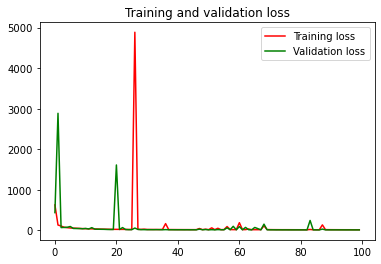

In [21]:
# plot loss charts
epochs_r = range(epochs)
plt.figure()
plt.plot(epochs_r, loss, 'r', label='Training loss')
plt.plot(epochs_r, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
boats_ds_o = load_test('boat')
sea_ds_o = load_test('sea')

In [23]:
boats_ds = condition(boats_ds_o, inShape, rgb_status)
sea_ds = condition(sea_ds_o, inShape, rgb_status)
print(sea_ds)

<MapDataset shapes: ((128, 128, 1), (128, 128, 1)), types: (tf.float32, tf.float32)>


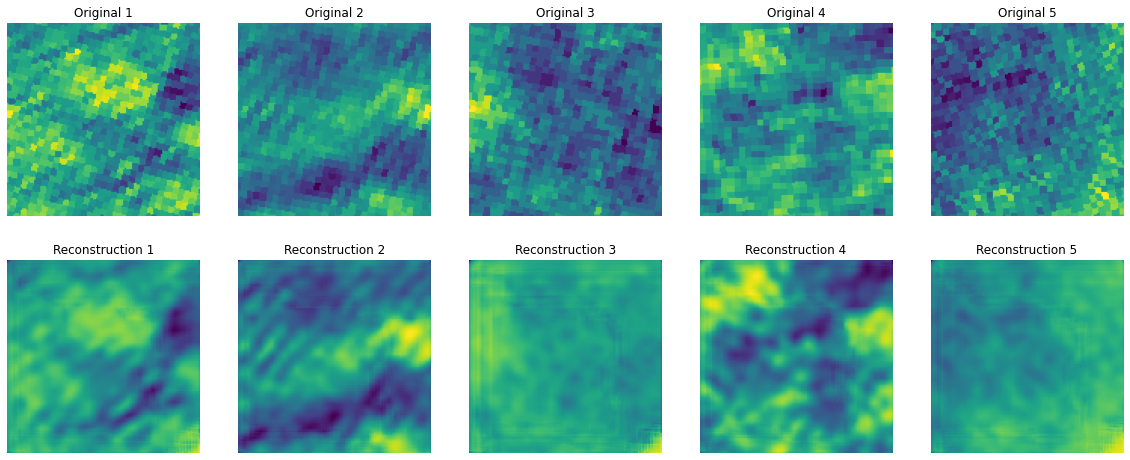

In [24]:
# view orignal and reconstructed versions of sea
iterable = iter(sea_ds.batch(20))
fig,axs=plt.subplots(2,5,figsize=(20,8))
img = iterable.next()[0]
#img = x_test_cnn[:6]
reconstruction = autoencoder(img)

for i in range(5):

    axs[0,i].imshow(tf.squeeze(img[i]))
    axs[0,i].title.set_text(f"Original {i+1}")
    axs[0,i].set_axis_off()
    axs[1,i].imshow(tf.squeeze(reconstruction[i]))
    axs[1,i].title.set_text(f"Reconstruction {i+1}")
    axs[1,i].set_axis_off()

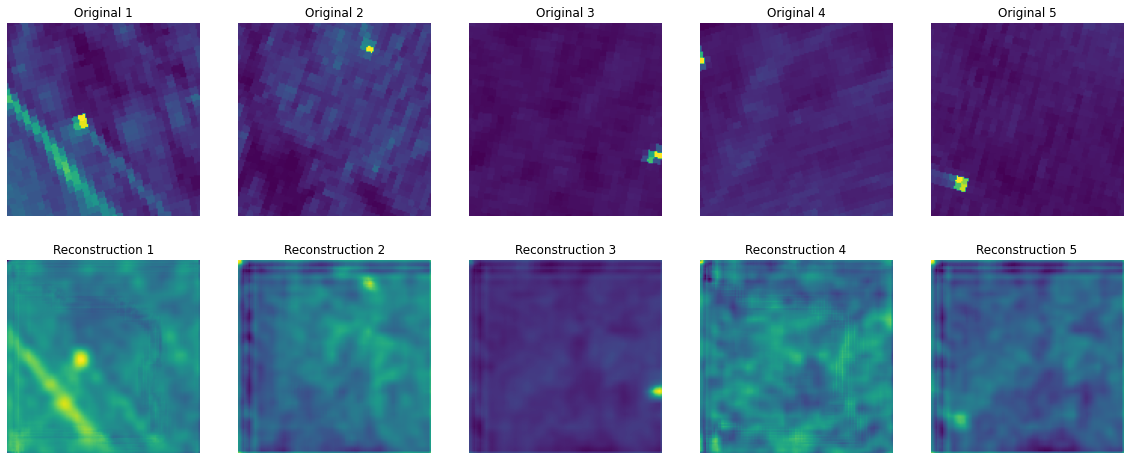

In [25]:
# view orignal and reconstructed versions of boats
iterable_boats = iter(boats_ds.batch(20))
fig,axs=plt.subplots(2,5,figsize=(20,8))
imgb = iterable_boats.next()[0]
#img = x_test_cnn[:6]
reconstruction = autoencoder(imgb)

for i in range(5):

    axs[0,i].imshow(tf.squeeze(imgb[i]))
    axs[0,i].title.set_text(f"Original {i+1}")
    axs[0,i].set_axis_off()
    axs[1,i].imshow(tf.squeeze(reconstruction[i]))
    axs[1,i].title.set_text(f"Reconstruction {i+1}")
    axs[1,i].set_axis_off()

In [26]:
# setup labels for evaluating autoencoder performance
sea_imgs=[]

for j, images in enumerate(sea_ds.take(1000)):
    sea_imgs.append(images[0])
    
boat_imgs=[]
for j, images in enumerate(boats_ds.take(800)):
    boat_imgs.append(images[0])


In [27]:
sea_tensor= np.array(sea_imgs)
boat_tensor = np.array(boat_imgs)

y_test_boats = []
y_test_sea = []

y_names_boats = []
y_names_sea = []

for i in range(0, len(boat_tensor)):
    y_test_boats.append(1)
    
    
for i in range(0, len(sea_tensor)):
    y_test_sea.append(0)

y_test = np.concatenate((y_test_sea, y_test_boats), axis=0)
test_tensor = np.concatenate((sea_tensor, boat_tensor), axis=0)
test_tensor.shape
print(y_test.shape)

(1800,)


In [28]:
#display first 10 latent representations
enc_out = encoder(img)


enc_outb = encoder(imgb)



In [29]:
#fig,axs=plt.subplots(2,5,figsize=(20,8))
test_tensor_c = tf.concat((sea_tensor, boat_tensor), axis=0)

print(sea_tensor.shape)
print(boat_tensor.shape)
print(test_tensor_c.shape)


for i in range(len(test_tensor_c)):
    img = test_tensor_c[i][None,...]
    
    if vae:
        output = encoder(img)[2]
    else:
        output = encoder(img)
    
    if i == 0:
        outTensor = output
        
    else:
        outTensor = tf.concat([outTensor,output], axis=0)

    




(1000, 128, 128, 1)
(800, 128, 128, 1)
(1800, 128, 128, 1)


tf.Tensor(
[[-0.07445753  3.68595     5.558333   ... -1.8121729  -0.69297045
  -3.0557954 ]
 [-0.50552917 -5.0061703   7.9109836  ... -1.7404926   3.0299509
  -3.0172    ]
 [ 1.492992    0.38826331 11.731255   ...  0.84298563  0.5715917
  -0.48544347]
 ...
 [-0.47942963  1.7089218   9.863091   ...  1.3102266   0.94396573
  -0.40342152]
 [-4.4212313   8.479443    2.3958998  ...  7.4265966  -6.889437
  -4.0430555 ]
 [ 0.5123675  -1.8826513  12.1551695  ... -0.636899    4.819679
   1.567764  ]], shape=(1800, 2500), dtype=float32)


(1800, 2)

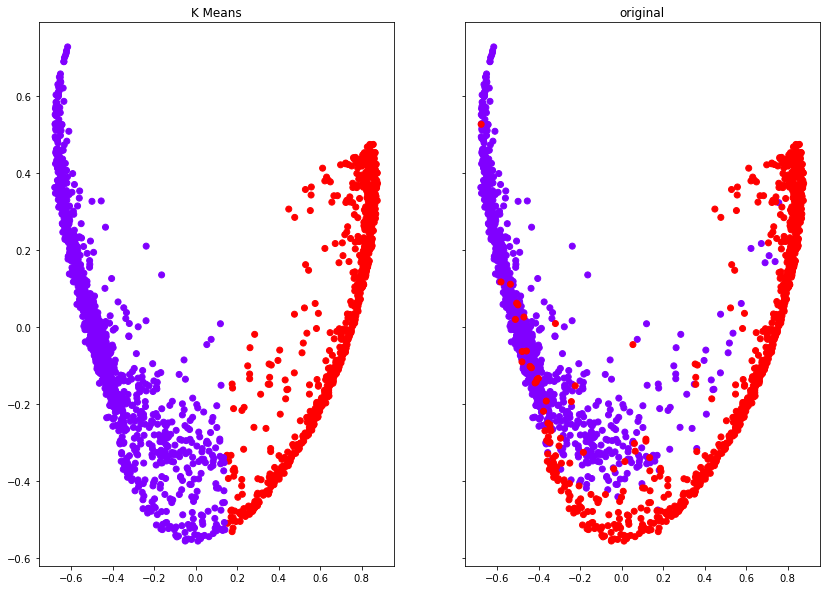

In [30]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# perform k menas
print(outTensor)

normalised_data = normalize(outTensor)     


from sklearn.cluster import KMeans
from sklearn import metrics

km = KMeans(n_clusters = 2)
km.fit(normalised_data)



km_labels = km.labels_

# TODO now PCA...
pca_2d = PCA(n_components=2)  #Principal component analysis object, for projecting data into 2D
encoder_projected = pca_2d.fit_transform(normalised_data) #PCA


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,10))
ax1.set_title('K Means')
ax1.scatter(encoder_projected[:,0],encoder_projected[:,1],c=km_labels,cmap='rainbow')

ax2.set_title('original')
ax2.scatter(encoder_projected[:,0],encoder_projected[:,1],c=y_test,cmap='rainbow')

encoder_projected.shape

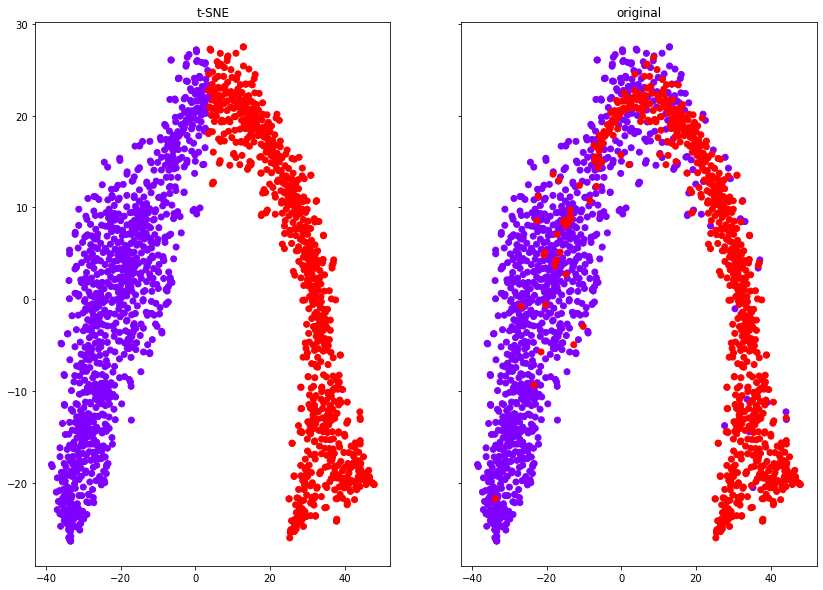

In [31]:
#t-SNE dimensionality reduction
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(normalised_data)
tsne_result.shape

#t_labels = tsne_result.labels_

km = KMeans(n_clusters = 2, init='k-means++', n_init=10, max_iter=100)
km.fit(tsne_result)

kmt_labels = km.labels_


tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_test})

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,10))
ax1.set_title('t-SNE')
#sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax1)
ax1.scatter(tsne_result[:,0],tsne_result[:,1],c=kmt_labels,cmap='rainbow')
ax2.set_title('original')
ax2.scatter(tsne_result[:,0],tsne_result[:,1],c=y_test,cmap='rainbow')

In [32]:
#TODO: 
print('#k-means')
km_metrics = compute_metrics(y_test, km_labels)

print('### t-sne ###')
SE_metrics = compute_metrics(y_test, kmt_labels)

#k-means
Model precision is: 0.9433139534883721
Model recall is: 0.81125
Model f1 score is: 0.8723118279569892
Model accuracy is: 0.8944444444444445
### t-sne ###
Model precision is: 0.8655256723716381
Model recall is: 0.885
Model f1 score is: 0.8751545117428925
Model accuracy is: 0.8877777777777778


In [33]:
f = open(fileName,"a")
f.write("KM METRICS: %s\r" % str(km_metrics))
f.write("SE METRICS: %s\r" % str(SE_metrics))
f.close()

In [34]:
test_tensor_c.shape
print()

In [35]:
# Taking k-menas labels as 1, and moving on to next round...

count_s = np.sum(kmt_labels)
count_r = len(test_tensor_c) - count_s

print(count_s)
print(count_r)

suspects = []
rejects = []
#names = 

for i in range(len(test_tensor_c)):
    stat = km_labels[i]
    img = test_tensor_c[i]
    
    if stat:
        suspects.append(img)
        
    else:
        rejects.append(img)
        


818
982


In [71]:
# detect bright spots within images...
suspects_a = np.array(suspects)
img = suspects_a[425:480, :]
# first, normalise again
reconstructions = autoencoder(img)
reconstructions_n = reconstructions/tf.reduce_max(reconstructions,axis=None)



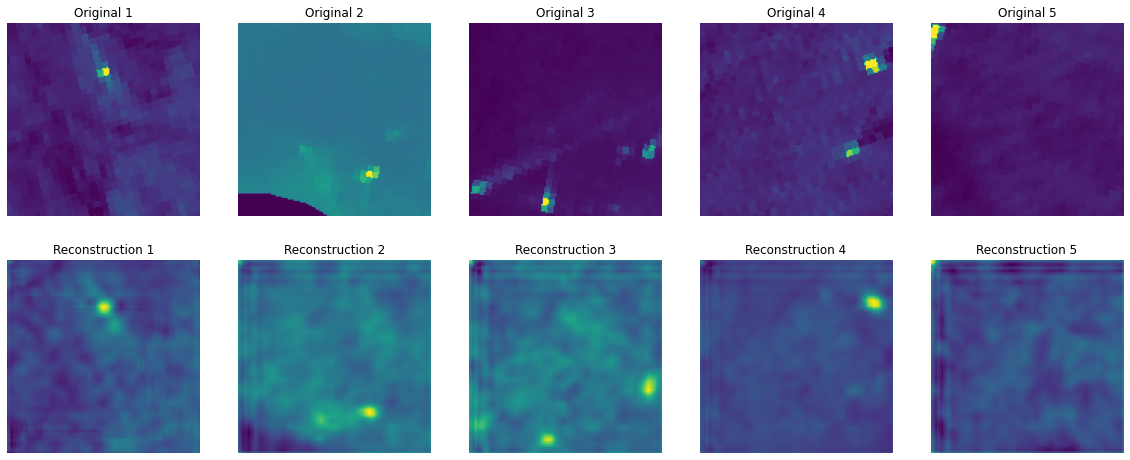

In [72]:
# view orignal and reconstructed versions of sea


fig,axs=plt.subplots(2,5,figsize=(20,8))

#img = x_test_cnn[:6]


for i in range(5):

    axs[0,i].imshow(tf.squeeze(img[i]))
    axs[0,i].title.set_text(f"Original {i+1}")
    axs[0,i].set_axis_off()
    axs[1,i].imshow(tf.squeeze(reconstructions_n[i]))
    axs[1,i].title.set_text(f"Reconstruction {i+1}")
    axs[1,i].set_axis_off()

In [73]:
def mm_norm(img):
    out = (img - img.min()) / (img.max() - img.min())
    return out

1.0


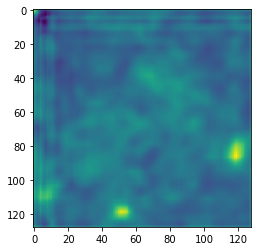

In [75]:

import cv2
test = reconstructions_n[2].numpy()
test_n = mm_norm(test)
plt.imshow(test_n)
print(np.max(test_n))

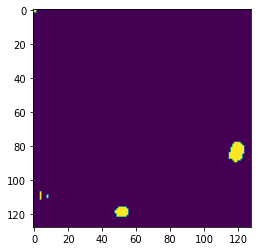

In [85]:
thresh = cv2.threshold(test_n,0.7,1.0,cv2.THRESH_BINARY)[1]


plt.imshow(thresh)

yup
yup
yup
yup
yup
yup
yup
yup
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


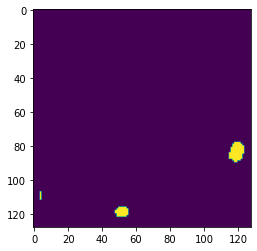

In [86]:
from skimage import measure
# perform connected component analysis
labels = measure.label(thresh, background=0)
mask = np.zeros(thresh.shape, dtype="uint8")


for label in np.unique(labels):
    if label == 0:
        continue
        
    labelMask = np.zeros(thresh.shape, dtype='uint8')
    labelMask[labels == label] = 1
    numPixels = cv2.countNonZero(labelMask)
    
    if numPixels < 110:
        print('yup')
        if numPixels > 4:
            print('yup')
            mask = cv2.add(mask,labelMask)

plt.imshow(mask)

print(mask)

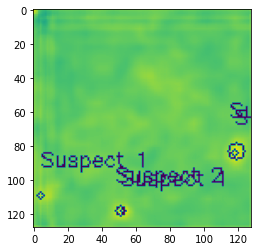

In [90]:
import imutils
from imutils import contours
plt.close()
# find the contours in the mask, then sort them from left to
image = test
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts)[0]
# loop over the contours
for (i, c) in enumerate(cnts):
	# draw the bright spot on the image
	(x, y, w, h) = cv2.boundingRect(c)
	((cX, cY), radius) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(cX), int(cY)), int(radius),
		(0, 0, 1), 1)
	cv2.putText(image, "Suspect {}".format(i + 1), (x, y - 15),
		cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 1), 1)
# show the output image
plt.clf()
plt.imshow(image)
